In [1]:
from contextlib import contextmanager
import gc
import os
from pathlib import Path
import pickle
import time

import catboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from lfm import calc_embeddings, calc_scores
from metric import apk, mapk
from utils import plot_images


In [2]:
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name}] {time.time() - start_time:.3f} s')

In [3]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [4]:
# class CFG:
#     model_type = 'LightGBM'
#     popular_num_items = 12
#     popular_days = 7
#     train_weeks = 1
#     repurchase_weeks = 12345
#     repurchase_num_items = 100
#     item2item_weeks = 12345
#     item2item_num_items = 24
#     cooc_weeks = 12
#     cooc_threshold = 50
#     dynamic_feature_weeks = 8
#     volume_feature_days = 7


# BEST
class CFG:
    model_type = 'CatBoost'
    popular_num_items = 36
    popular_days = 7
    train_weeks = 3
    repurchase_weeks = 123456
    repurchase_num_items = 123456
    item2item_weeks = 123456
    item2item_num_items = 24
    cooc_weeks = 12
    cooc_threshold = 50
    dynamic_feature_weeks = 8
    volume_feature_days = 7

In [5]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"create candidates (week: {week})")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            max_items_per_user: int) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("user in @target_users and @week_start <= week < @week_end")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
        ) -> pd.DataFrame:
        day_start = 7 * week_start
        tr = transactions.query("@day_start <= day < @day_start + @CFG.popular_days")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:CFG.popular_num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(CFG.popular_num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_cooc(
            strategy: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_num: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        week_end = week_start + week_num
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_item_count = tr.groupby('item').size().reset_index(name='item_count')
        gr_pair_count = tr.groupby(['item', 'item_with']).size().reset_index(name='pair_count')
        item2item = gr_pair_count.merge(gr_item_count, on='item')
        item2item['ratio'] = item2item['pair_count'] / item2item['item_count']
        item2item = item2item.query("pair_count > @CFG.cooc_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'pair_count'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': f'{strategy}_ratio', 'item_count': f'{strategy}_item_count'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    def create_candidates_same_product_code(
            strategy: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    with timer("repurchase"):
        candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week, CFG.repurchase_weeks, CFG.repurchase_num_items)
    with timer("popular"):
        candidates_popular = create_candidates_popular('pop', transactions, target_users, week)
    with timer("item2item"):
        candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.repurchase_weeks, CFG.item2item_num_items)
    with timer("cooccurrence"):
        candidates_cooc = create_candidates_cooc('cooc', transactions, week, CFG.cooc_weeks, candidates_item2item)
    with timer("same_product_code"):
        candidates_same_product_code = create_candidates_same_product_code('same_product_code', items, candidates_item2item)

    def create_candidates_ohe_distance(transactions, users, items, target_users, week):
        num_items = 32
        import faiss
        users_with_ohe = users[['user']].query("user in @target_users")
        cols = [c for c in items.columns if c.endswith('_idx')]
        for c in cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            cs = [c for c in tmp.columns if c.endswith('_mean')]
            users_with_ohe = users_with_ohe.merge(tmp[['user'] + cs], on='user')

        users_with_ohe = users_with_ohe.dropna().reset_index(drop=True)
        limited_users = users_with_ohe['user'].values

        recent_items = transactions.query("@week <= week < @week + 1")['item'].unique()
        items_with_ohe = pd.get_dummies(items[['item'] + cols], columns=cols)
        items_with_ohe = items_with_ohe.query("item in @recent_items").reset_index(drop=True)
        limited_items = items_with_ohe['item'].values

        item_cols = [c for c in items_with_ohe.columns if c != 'item']
        user_cols = [f'user_ohe_agg_{c}_mean' for c in item_cols]
        users_with_ohe = users_with_ohe[['user'] + user_cols]
        items_with_ohe = items_with_ohe[['item'] + item_cols]

        a_users = users_with_ohe.drop('user', axis=1).values.astype(np.float32)
        a_items = items_with_ohe.drop('item', axis=1).values.astype(np.float32)
        a_users = np.ascontiguousarray(a_users)
        a_items = np.ascontiguousarray(a_items)
        index = faiss.index_factory(a_items.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)
        index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index)
        index.add(a_items)
        distances, idxs = index.search(a_users, num_items)

        return pd.DataFrame({
            'user': np.repeat(limited_users, num_items),
            'item': limited_items[idxs.flatten()],
            'distance': distances.flatten(),
            'strategy': 'ohe',
        })
    with timer("ohe distance"):
        candidates_ohe_distance = create_candidates_ohe_distance(transactions, users, items, target_users, week)

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)


    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)
    candidates_ohe_distance = drop_common_user_item(candidates_ohe_distance, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_cooc,
        candidates_same_product_code,
        candidates_ohe_distance,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [6]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

create candidates (week: 1)


[repurchase] 8.947 s


[popular] 0.458 s


[item2item] 7.935 s


[cooccurrence] 13.636 s


[same_product_code] 5.457 s


[ohe distance] 16.737 s


volume: 15991626


duplicates: 1.0552836520584024


            strategy   volume     ratio
0  same_product_code  6876142  0.429984
1         repurchase  3446562  0.215523
2                pop  2483424  0.155295
3                ohe  1981757  0.123925
4               cooc  1203741  0.075273


create candidates (week: 2)


[repurchase] 9.236 s


[popular] 0.493 s


[item2item] 8.405 s


[cooccurrence] 15.423 s


[same_product_code] 5.543 s


[ohe distance] 16.241 s


volume: 16956677


duplicates: 1.0592206643477098


            strategy   volume     ratio
0  same_product_code  7228749  0.426307
1         repurchase  3637145  0.214496
2                pop  2592684  0.152900
3                ohe  2080062  0.122669
4               cooc  1418037  0.083627


create candidates (week: 3)


[repurchase] 9.402 s


[popular] 0.532 s


[item2item] 8.946 s


[cooccurrence] 15.547 s


[same_product_code] 5.627 s


[ohe distance] 16.351 s


volume: 17930210


duplicates: 1.0620907696093247


            strategy   volume     ratio
0  same_product_code  7678831  0.428262
1         repurchase  3742824  0.208744
2                pop  2729592  0.152234
3                ohe  2188278  0.122044
4               cooc  1590685  0.088715


create candidates (week: 4)


[repurchase] 9.801 s


[popular] 0.523 s


[item2item] 9.023 s


[cooccurrence] 16.320 s


[same_product_code] 6.223 s


[ohe distance] 16.804 s


volume: 19100294


duplicates: 1.066212805655061


            strategy   volume     ratio
0  same_product_code  8177755  0.428148
1         repurchase  3915353  0.204989
2                pop  2889108  0.151260
3                ohe  2320500  0.121490
4               cooc  1797578  0.094113


In [7]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"merge labels (week: {week})")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [8]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


merge labels (week: 0)


Recall: 0.14038871837101363


            strategy        y   volume    recall  hit_ratio
0                pop  11811.0  2483424  0.055262   0.004756
1         repurchase   8437.0  3446562  0.039475   0.002448
2  same_product_code   7888.0  6876142  0.036907   0.001147
3               cooc   5096.0  1203741  0.023843   0.004233
4                ohe   2440.0  1981757  0.011416   0.001231
merge labels (week: 1)


Recall: 0.13065683822561538


            strategy        y   volume    recall  hit_ratio
0                pop  10203.0  2592684  0.044768   0.003935
1         repurchase   8955.0  3637145  0.039292   0.002462
2  same_product_code   8554.0  7228749  0.037532   0.001183
3               cooc   5210.0  1418037  0.022860   0.003674
4                ohe   2680.0  2080062  0.011759   0.001288
merge labels (week: 2)


Recall: 0.13371472735367995


            strategy        y   volume    recall  hit_ratio
0                pop  11942.0  2729592  0.050161   0.004375
1         repurchase   9195.0  3742824  0.038622   0.002457
2  same_product_code   8829.0  7678831  0.037085   0.001150
3               cooc   5376.0  1590685  0.022581   0.003380
4                ohe   2526.0  2188278  0.010610   0.001154
merge labels (week: 3)


Recall: 0.13197372752496356


            strategy        y   volume    recall  hit_ratio
0                pop  13485.0  2889108  0.052847   0.004668
1  same_product_code   9328.0  8177755  0.036556   0.001141
2         repurchase   9002.0  3915353  0.035278   0.002299
3               cooc   5609.0  1797578  0.021981   0.003120
4                ohe   2856.0  2320500  0.011192   0.001231


In [9]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 15991626 -> 5450623


drop trivial queries: 16956677 -> 5718264


drop trivial queries: 17930210 -> 6126511


drop trivial queries: 19100294 -> 6474396


In [10]:
# age==25でのアイテムボリューム以上になるような幅を各年齢に対して求める
tr = transactions[['user', 'item']].merge(users[['user', 'age']], on='user')
age_volume_threshold = len(tr.query("24 <= age <= 26"))

age_volumes = {age: len(tr.query("age == @age")) for age in range(16, 100)}

age_shifts = {}
for age in range(16, 100):
    for i in range(0, 100):
        low = age - i
        high = age + i
        age_volume = 0
        for j in range(low, high+1):
            age_volume += age_volumes.get(j, 0)
        if age_volume >= age_volume_threshold:
            age_shifts[age] = i
            break
print(age_shifts)

{16: 7, 17: 6, 18: 5, 19: 4, 20: 3, 21: 2, 22: 2, 23: 2, 24: 2, 25: 1, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 3, 33: 3, 34: 4, 35: 4, 36: 5, 37: 5, 38: 5, 39: 5, 40: 6, 41: 6, 42: 5, 43: 5, 44: 5, 45: 5, 46: 4, 47: 4, 48: 4, 49: 4, 50: 4, 51: 4, 52: 4, 53: 4, 54: 4, 55: 5, 56: 5, 57: 6, 58: 7, 59: 7, 60: 8, 61: 9, 62: 10, 63: 11, 64: 12, 65: 13, 66: 14, 67: 15, 68: 16, 69: 17, 70: 18, 71: 19, 72: 20, 73: 21, 74: 22, 75: 23, 76: 24, 77: 25, 78: 26, 79: 27, 80: 28, 81: 29, 82: 30, 83: 31, 84: 32, 85: 33, 86: 34, 87: 35, 88: 36, 89: 37, 90: 38, 91: 39, 92: 40, 93: 41, 94: 42, 95: 43, 96: 44, 97: 45, 98: 46, 99: 47}


In [11]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"attach features (week: {week})")
    n_original = len(candidates)
    df = candidates.copy()

    with timer("user static fetaures"):
        user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
        df = df.merge(users[['user'] + user_features], on='user')

    with timer("item stacic features"):
        item_features = [c for c in items.columns if c.endswith('idx')]
        df = df.merge(items[['item'] + item_features], on='item')

    with timer("user dynamic features (transactions)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='user', how='left')

    with timer("item dynamic features (transactions)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item dynamic features (user features)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
        tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
        tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item freshness features"):
        tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
        tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='item', how='left')

    with timer("item volume features"):
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby('item').size().reset_index(name='item_volume')
        df = df.merge(tmp, on='item', how='left')

    with timer("user freshness features"):
        tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
        tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='user', how='left')

    with timer("user volume features"):
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby('user').size().reset_index(name='user_volume')
        df = df.merge(tmp, on='user', how='left')

    with timer("user-item freshness features"):
        tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
        tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on=['item', 'user'], how='left')

    with timer("user-item volume features"):
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

    with timer("item age volume features"):
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tr = transactions.query("@day_start <= day < @day_end")[['user', 'item']].merge(users[['user', 'age']], on='user')
        item_age_volumes = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            tmp = tr.query("@low <= age <= @high").groupby('item').size().reset_index(name='age_volume')
            tmp['age_volume'] = tmp['age_volume'].rank(ascending=False)
            tmp['age'] = age
            item_age_volumes.append(tmp)
        item_age_volumes = pd.concat(item_age_volumes)
        df = df.merge(item_age_volumes, on=['item', 'age'], how='left')

    with timer("ohe dot products"):
        item_target_cols = [c for c in items.columns if c.endswith('_idx')]

        items_with_ohe = pd.get_dummies(items[['item'] + item_target_cols], columns=item_target_cols)

        users_with_ohe = users[['user']]
        for c in item_target_cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            assert tmp['user'].tolist() == users_with_ohe['user'].tolist()
            tmp = tmp[['user'] + [c for c in tmp.columns if c.endswith('_mean')]]
            tmp = tmp.drop('user', axis=1)
            users_with_ohe = pd.concat([users_with_ohe, tmp], axis=1)

        assert items_with_ohe['item'].tolist() == items['item'].tolist()
        assert users_with_ohe['user'].tolist() == users['user'].tolist()

        users_items = df[['user', 'item']].drop_duplicates().reset_index(drop=True)
        n_split = 10
        n_chunk = (len(users_items) + n_split - 1)// n_split
        ohe = []
        for i in range(0, len(users_items), n_chunk):
            users_items_small = users_items.iloc[i:i+n_chunk].reset_index(drop=True)
            users_small = users_items_small['user'].values
            items_small = users_items_small['item'].values

            for item_col in item_target_cols:
                i_cols = [c for c in items_with_ohe.columns if c.startswith(item_col)]
                u_cols = [f"user_ohe_agg_{c}_mean" for c in i_cols]
                users_items_small[f'{item_col}_ohe_score'] = (items_with_ohe[i_cols].values[items_small] * users_with_ohe[u_cols].values[users_small]).sum(axis=1)

            ohe_cols = [f'{col}_ohe_score' for col in item_target_cols]
            users_items_small = users_items_small[['user', 'item'] + ohe_cols]

            ohe.append(users_items_small)
        ohe = pd.concat(ohe)
        df = df.merge(ohe, on=['user', 'item'])

    with timer("lfm features"):
        user_reps, _ = calc_embeddings('i_i', dataset, pretrain_week, 16)
        df = df.merge(user_reps, on='user')



    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

attach features (week: 1)


[user static fetaures] 1.684 s


[item stacic features] 4.583 s


[user dynamic features (transactions)] 3.055 s


[item dynamic features (transactions)] 2.476 s


[item dynamic features (user features)] 3.031 s


[item freshness features] 4.476 s


[item volume features] 2.686 s


[user freshness features] 6.099 s


[user volume features] 3.229 s


[user-item freshness features] 24.543 s


[user-item volume features] 5.965 s


[item age volume features] 4.923 s


[ohe dot products] 119.213 s


[lfm features] 8.639 s
attach features (week: 1)


[user static fetaures] 0.592 s


[item stacic features] 1.412 s


[user dynamic features (transactions)] 1.262 s


[item dynamic features (transactions)] 1.013 s


[item dynamic features (user features)] 1.453 s


[item freshness features] 2.844 s


[item volume features] 0.995 s


[user freshness features] 4.036 s


[user volume features] 1.146 s


[user-item freshness features] 21.334 s


[user-item volume features] 1.893 s


[item age volume features] 2.267 s


[ohe dot products] 55.294 s


[lfm features] 2.946 s
attach features (week: 2)


[user static fetaures] 0.609 s


[item stacic features] 1.474 s


[user dynamic features (transactions)] 1.270 s


[item dynamic features (transactions)] 1.053 s


[item dynamic features (user features)] 1.510 s


[item freshness features] 2.870 s


[item volume features] 1.042 s


[user freshness features] 4.052 s


[user volume features] 1.195 s


[user-item freshness features] 21.134 s


[user-item volume features] 2.053 s


[item age volume features] 2.345 s


[ohe dot products] 56.891 s


[lfm features] 3.041 s
attach features (week: 3)


[user static fetaures] 0.667 s


[item stacic features] 1.594 s


[user dynamic features (transactions)] 1.327 s


[item dynamic features (transactions)] 1.103 s


[item dynamic features (user features)] 1.578 s


[item freshness features] 2.929 s


[item volume features] 1.110 s


[user freshness features] 4.136 s


[user volume features] 1.271 s


[user-item freshness features] 21.087 s


[user-item volume features] 2.270 s


[item age volume features] 2.417 s


[ohe dot products] 62.082 s


[lfm features] 3.604 s
attach features (week: 4)


[user static fetaures] 0.697 s


[item stacic features] 1.762 s


[user dynamic features (transactions)] 1.513 s


[item dynamic features (transactions)] 1.221 s


[item dynamic features (user features)] 1.690 s


[item freshness features] 3.066 s


[item volume features] 1.257 s


[user freshness features] 4.281 s


[user volume features] 1.443 s


[user-item freshness features] 21.721 s


[user-item volume features] 2.260 s


[item age volume features] 2.475 s


[ohe dot products] 64.935 s


[lfm features] 3.598 s


In [12]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [13]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [14]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_item_count', 'cooc_ratio', 'same_product_code_item2item_week_rank', 'same_product_code_item2item_volume_rank', 'distance', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_day_min', 'user_volume', 'user_item_day_min', 'user_item_volume', 'age_volume', 'product_type_no_idx_ohe_score', 'product_group_

In [15]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [16]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

0:	test: 0.1752266	best: 0.1752266 (0)	total: 4.99s	remaining: 6h 55m 42s


1:	test: 0.2052631	best: 0.2052631 (1)	total: 9.78s	remaining: 6h 47m 22s


2:	test: 0.2299667	best: 0.2299667 (2)	total: 14.6s	remaining: 6h 45m 10s


3:	test: 0.2303499	best: 0.2303499 (3)	total: 19.4s	remaining: 6h 43m 59s


4:	test: 0.2355434	best: 0.2355434 (4)	total: 24.3s	remaining: 6h 44m 15s


5:	test: 0.2413086	best: 0.2413086 (5)	total: 29.2s	remaining: 6h 44m 29s


6:	test: 0.2436925	best: 0.2436925 (6)	total: 34.3s	remaining: 6h 47m 33s


7:	test: 0.2428460	best: 0.2436925 (6)	total: 39.3s	remaining: 6h 48m 36s


8:	test: 0.2442637	best: 0.2442637 (8)	total: 44.2s	remaining: 6h 48m 38s


9:	test: 0.2460173	best: 0.2460173 (9)	total: 49.1s	remaining: 6h 48m 33s


10:	test: 0.2471239	best: 0.2471239 (10)	total: 54.1s	remaining: 6h 49m 3s


11:	test: 0.2484182	best: 0.2484182 (11)	total: 58.9s	remaining: 6h 48m 18s


12:	test: 0.2502919	best: 0.2502919 (12)	total: 1m 3s	remaining: 6h 47m 49s


13:	test: 0.2515728	best: 0.2515728 (13)	total: 1m 8s	remaining: 6h 47m 35s


14:	test: 0.2527529	best: 0.2527529 (14)	total: 1m 13s	remaining: 6h 47m 44s


15:	test: 0.2612110	best: 0.2612110 (15)	total: 1m 18s	remaining: 6h 48m 3s


16:	test: 0.2617361	best: 0.2617361 (16)	total: 1m 23s	remaining: 6h 48m


17:	test: 0.2625288	best: 0.2625288 (17)	total: 1m 28s	remaining: 6h 48m 21s


18:	test: 0.2638436	best: 0.2638436 (18)	total: 1m 33s	remaining: 6h 48m 20s


19:	test: 0.2666235	best: 0.2666235 (19)	total: 1m 38s	remaining: 6h 48m


20:	test: 0.2692486	best: 0.2692486 (20)	total: 1m 43s	remaining: 6h 48m 5s


21:	test: 0.2707775	best: 0.2707775 (21)	total: 1m 48s	remaining: 6h 47m 53s


22:	test: 0.2704106	best: 0.2707775 (21)	total: 1m 53s	remaining: 6h 47m 44s


23:	test: 0.2707126	best: 0.2707775 (21)	total: 1m 57s	remaining: 6h 47m 20s


24:	test: 0.2707728	best: 0.2707775 (21)	total: 2m 2s	remaining: 6h 47m 5s


25:	test: 0.2718446	best: 0.2718446 (25)	total: 2m 7s	remaining: 6h 46m 43s


26:	test: 0.2734806	best: 0.2734806 (26)	total: 2m 12s	remaining: 6h 46m 22s


27:	test: 0.2744483	best: 0.2744483 (27)	total: 2m 17s	remaining: 6h 46m 5s


28:	test: 0.2748716	best: 0.2748716 (28)	total: 2m 22s	remaining: 6h 46m 20s


29:	test: 0.2752722	best: 0.2752722 (29)	total: 2m 27s	remaining: 6h 46m 31s


30:	test: 0.2754380	best: 0.2754380 (30)	total: 2m 32s	remaining: 6h 46m 16s


31:	test: 0.2762499	best: 0.2762499 (31)	total: 2m 36s	remaining: 6h 45m 53s


32:	test: 0.2764680	best: 0.2764680 (32)	total: 2m 41s	remaining: 6h 45m 31s


33:	test: 0.2763556	best: 0.2764680 (32)	total: 2m 46s	remaining: 6h 45m 15s


34:	test: 0.2766017	best: 0.2766017 (34)	total: 2m 51s	remaining: 6h 45m 1s


35:	test: 0.2815601	best: 0.2815601 (35)	total: 2m 56s	remaining: 6h 45m 3s


36:	test: 0.2818183	best: 0.2818183 (36)	total: 3m 1s	remaining: 6h 45m 10s


37:	test: 0.2828853	best: 0.2828853 (37)	total: 3m 6s	remaining: 6h 45m 11s


38:	test: 0.2833408	best: 0.2833408 (38)	total: 3m 11s	remaining: 6h 45m 15s


39:	test: 0.2836426	best: 0.2836426 (39)	total: 3m 16s	remaining: 6h 45m 16s


40:	test: 0.2839298	best: 0.2839298 (40)	total: 3m 21s	remaining: 6h 45m 36s


41:	test: 0.2841600	best: 0.2841600 (41)	total: 3m 26s	remaining: 6h 45m 28s


42:	test: 0.2843526	best: 0.2843526 (42)	total: 3m 30s	remaining: 6h 45m 22s


43:	test: 0.2850543	best: 0.2850543 (43)	total: 3m 35s	remaining: 6h 45m 27s


44:	test: 0.2852822	best: 0.2852822 (44)	total: 3m 40s	remaining: 6h 45m 13s


45:	test: 0.2853738	best: 0.2853738 (45)	total: 3m 45s	remaining: 6h 45m 31s


46:	test: 0.2859471	best: 0.2859471 (46)	total: 3m 51s	remaining: 6h 45m 44s


47:	test: 0.2862247	best: 0.2862247 (47)	total: 3m 56s	remaining: 6h 46m 1s


48:	test: 0.2864425	best: 0.2864425 (48)	total: 4m 1s	remaining: 6h 46m 41s


49:	test: 0.2866841	best: 0.2866841 (49)	total: 4m 6s	remaining: 6h 47m 6s


50:	test: 0.2879281	best: 0.2879281 (50)	total: 4m 11s	remaining: 6h 47m 25s


51:	test: 0.2883974	best: 0.2883974 (51)	total: 4m 16s	remaining: 6h 47m 30s


52:	test: 0.2887351	best: 0.2887351 (52)	total: 4m 21s	remaining: 6h 47m 21s


53:	test: 0.2887914	best: 0.2887914 (53)	total: 4m 26s	remaining: 6h 47m 25s


54:	test: 0.2891590	best: 0.2891590 (54)	total: 4m 31s	remaining: 6h 47m 23s


55:	test: 0.2900336	best: 0.2900336 (55)	total: 4m 36s	remaining: 6h 47m 24s


56:	test: 0.2903807	best: 0.2903807 (56)	total: 4m 41s	remaining: 6h 47m 19s


57:	test: 0.2906879	best: 0.2906879 (57)	total: 4m 46s	remaining: 6h 47m 12s


58:	test: 0.2908117	best: 0.2908117 (58)	total: 4m 51s	remaining: 6h 47m 7s


59:	test: 0.2913552	best: 0.2913552 (59)	total: 4m 56s	remaining: 6h 47m 26s


60:	test: 0.2915800	best: 0.2915800 (60)	total: 5m 1s	remaining: 6h 47m 25s


61:	test: 0.2922753	best: 0.2922753 (61)	total: 5m 6s	remaining: 6h 47m 22s


62:	test: 0.2923547	best: 0.2923547 (62)	total: 5m 11s	remaining: 6h 47m 22s


63:	test: 0.2927456	best: 0.2927456 (63)	total: 5m 16s	remaining: 6h 47m 21s


64:	test: 0.2930196	best: 0.2930196 (64)	total: 5m 21s	remaining: 6h 47m 19s


65:	test: 0.2932672	best: 0.2932672 (65)	total: 5m 26s	remaining: 6h 47m 14s


66:	test: 0.2934804	best: 0.2934804 (66)	total: 5m 31s	remaining: 6h 47m


67:	test: 0.2937524	best: 0.2937524 (67)	total: 5m 36s	remaining: 6h 46m 52s


68:	test: 0.2940226	best: 0.2940226 (68)	total: 5m 41s	remaining: 6h 46m 38s


69:	test: 0.2940010	best: 0.2940226 (68)	total: 5m 46s	remaining: 6h 46m 38s


70:	test: 0.2941368	best: 0.2941368 (70)	total: 5m 51s	remaining: 6h 46m 41s


71:	test: 0.2942257	best: 0.2942257 (71)	total: 5m 56s	remaining: 6h 46m 40s


72:	test: 0.2944277	best: 0.2944277 (72)	total: 6m 1s	remaining: 6h 46m 34s


73:	test: 0.2948130	best: 0.2948130 (73)	total: 6m 6s	remaining: 6h 46m 28s


74:	test: 0.2951459	best: 0.2951459 (74)	total: 6m 11s	remaining: 6h 46m 22s


75:	test: 0.2956694	best: 0.2956694 (75)	total: 6m 16s	remaining: 6h 46m 21s


76:	test: 0.2958046	best: 0.2958046 (76)	total: 6m 21s	remaining: 6h 46m 26s


77:	test: 0.2959073	best: 0.2959073 (77)	total: 6m 26s	remaining: 6h 46m 32s


78:	test: 0.2956992	best: 0.2959073 (77)	total: 6m 31s	remaining: 6h 46m 34s


79:	test: 0.2959898	best: 0.2959898 (79)	total: 6m 36s	remaining: 6h 46m 27s


80:	test: 0.2961812	best: 0.2961812 (80)	total: 6m 41s	remaining: 6h 46m 25s


81:	test: 0.2966843	best: 0.2966843 (81)	total: 6m 46s	remaining: 6h 46m 24s


82:	test: 0.2968482	best: 0.2968482 (82)	total: 6m 51s	remaining: 6h 46m 10s


83:	test: 0.2970694	best: 0.2970694 (83)	total: 6m 56s	remaining: 6h 46m 16s


84:	test: 0.2972960	best: 0.2972960 (84)	total: 7m 1s	remaining: 6h 46m 23s


85:	test: 0.2974340	best: 0.2974340 (85)	total: 7m 6s	remaining: 6h 46m 13s


86:	test: 0.2975014	best: 0.2975014 (86)	total: 7m 11s	remaining: 6h 45m 56s


87:	test: 0.2975567	best: 0.2975567 (87)	total: 7m 15s	remaining: 6h 45m 34s


88:	test: 0.2978163	best: 0.2978163 (88)	total: 7m 20s	remaining: 6h 45m 20s


89:	test: 0.2981441	best: 0.2981441 (89)	total: 7m 25s	remaining: 6h 45m 9s


90:	test: 0.2982471	best: 0.2982471 (90)	total: 7m 30s	remaining: 6h 44m 58s


91:	test: 0.2986592	best: 0.2986592 (91)	total: 7m 35s	remaining: 6h 44m 51s


92:	test: 0.2990419	best: 0.2990419 (92)	total: 7m 40s	remaining: 6h 44m 40s


93:	test: 0.2989558	best: 0.2990419 (92)	total: 7m 44s	remaining: 6h 44m 26s


94:	test: 0.2990763	best: 0.2990763 (94)	total: 7m 49s	remaining: 6h 44m 21s


95:	test: 0.2991782	best: 0.2991782 (95)	total: 7m 54s	remaining: 6h 44m 14s


96:	test: 0.2991655	best: 0.2991782 (95)	total: 7m 59s	remaining: 6h 44m 3s


97:	test: 0.2994210	best: 0.2994210 (97)	total: 8m 4s	remaining: 6h 44m 3s


98:	test: 0.2996043	best: 0.2996043 (98)	total: 8m 9s	remaining: 6h 43m 56s


99:	test: 0.2995697	best: 0.2996043 (98)	total: 8m 14s	remaining: 6h 43m 58s


100:	test: 0.2998235	best: 0.2998235 (100)	total: 8m 19s	remaining: 6h 43m 45s


101:	test: 0.2999413	best: 0.2999413 (101)	total: 8m 24s	remaining: 6h 43m 33s


102:	test: 0.3002206	best: 0.3002206 (102)	total: 8m 29s	remaining: 6h 43m 25s


103:	test: 0.3006317	best: 0.3006317 (103)	total: 8m 34s	remaining: 6h 43m 17s


104:	test: 0.3006038	best: 0.3006317 (103)	total: 8m 38s	remaining: 6h 43m 7s


105:	test: 0.3007923	best: 0.3007923 (105)	total: 8m 43s	remaining: 6h 42m 55s


106:	test: 0.3009616	best: 0.3009616 (106)	total: 8m 48s	remaining: 6h 42m 40s


107:	test: 0.3007395	best: 0.3009616 (106)	total: 8m 53s	remaining: 6h 42m 32s


108:	test: 0.3011778	best: 0.3011778 (108)	total: 8m 58s	remaining: 6h 42m 23s


109:	test: 0.3012523	best: 0.3012523 (109)	total: 9m 2s	remaining: 6h 42m 7s


110:	test: 0.3016348	best: 0.3016348 (110)	total: 9m 7s	remaining: 6h 42m 2s


111:	test: 0.3014572	best: 0.3016348 (110)	total: 9m 12s	remaining: 6h 41m 57s


112:	test: 0.3015812	best: 0.3016348 (110)	total: 9m 17s	remaining: 6h 41m 53s


113:	test: 0.3017052	best: 0.3017052 (113)	total: 9m 22s	remaining: 6h 41m 46s


114:	test: 0.3020746	best: 0.3020746 (114)	total: 9m 27s	remaining: 6h 41m 39s


115:	test: 0.3022845	best: 0.3022845 (115)	total: 9m 32s	remaining: 6h 41m 27s


116:	test: 0.3027004	best: 0.3027004 (116)	total: 9m 36s	remaining: 6h 41m 14s


117:	test: 0.3027659	best: 0.3027659 (117)	total: 9m 41s	remaining: 6h 41m 2s


118:	test: 0.3031960	best: 0.3031960 (118)	total: 9m 46s	remaining: 6h 40m 52s


119:	test: 0.3035602	best: 0.3035602 (119)	total: 9m 51s	remaining: 6h 40m 40s


120:	test: 0.3038362	best: 0.3038362 (120)	total: 9m 55s	remaining: 6h 40m 30s


121:	test: 0.3041402	best: 0.3041402 (121)	total: 10m	remaining: 6h 40m 19s


122:	test: 0.3042164	best: 0.3042164 (122)	total: 10m 5s	remaining: 6h 40m 19s


123:	test: 0.3044377	best: 0.3044377 (123)	total: 10m 10s	remaining: 6h 40m 12s


124:	test: 0.3045402	best: 0.3045402 (124)	total: 10m 15s	remaining: 6h 40m 3s


125:	test: 0.3047624	best: 0.3047624 (125)	total: 10m 20s	remaining: 6h 39m 58s


126:	test: 0.3046725	best: 0.3047624 (125)	total: 10m 25s	remaining: 6h 39m 41s


127:	test: 0.3051424	best: 0.3051424 (127)	total: 10m 29s	remaining: 6h 39m 29s


128:	test: 0.3053348	best: 0.3053348 (128)	total: 10m 34s	remaining: 6h 39m 17s


129:	test: 0.3054830	best: 0.3054830 (129)	total: 10m 39s	remaining: 6h 39m 13s


130:	test: 0.3056311	best: 0.3056311 (130)	total: 10m 44s	remaining: 6h 39m 10s


131:	test: 0.3057931	best: 0.3057931 (131)	total: 10m 49s	remaining: 6h 39m


132:	test: 0.3059548	best: 0.3059548 (132)	total: 10m 54s	remaining: 6h 38m 55s


133:	test: 0.3058485	best: 0.3059548 (132)	total: 10m 58s	remaining: 6h 38m 43s


134:	test: 0.3061400	best: 0.3061400 (134)	total: 11m 3s	remaining: 6h 38m 27s


135:	test: 0.3063164	best: 0.3063164 (135)	total: 11m 8s	remaining: 6h 38m 23s


136:	test: 0.3065468	best: 0.3065468 (136)	total: 11m 13s	remaining: 6h 38m 20s


137:	test: 0.3065351	best: 0.3065468 (136)	total: 11m 18s	remaining: 6h 38m 17s


138:	test: 0.3067182	best: 0.3067182 (138)	total: 11m 23s	remaining: 6h 38m 15s


139:	test: 0.3069891	best: 0.3069891 (139)	total: 11m 28s	remaining: 6h 38m 5s


140:	test: 0.3071465	best: 0.3071465 (140)	total: 11m 32s	remaining: 6h 37m 59s


141:	test: 0.3076013	best: 0.3076013 (141)	total: 11m 37s	remaining: 6h 37m 49s


142:	test: 0.3078216	best: 0.3078216 (142)	total: 11m 42s	remaining: 6h 37m 53s


143:	test: 0.3080554	best: 0.3080554 (143)	total: 11m 47s	remaining: 6h 37m 54s


144:	test: 0.3082398	best: 0.3082398 (144)	total: 11m 52s	remaining: 6h 37m 47s


145:	test: 0.3082207	best: 0.3082398 (144)	total: 11m 57s	remaining: 6h 37m 39s


146:	test: 0.3083699	best: 0.3083699 (146)	total: 12m 2s	remaining: 6h 37m 33s


147:	test: 0.3086609	best: 0.3086609 (147)	total: 12m 7s	remaining: 6h 37m 33s


148:	test: 0.3087649	best: 0.3087649 (148)	total: 12m 12s	remaining: 6h 37m 29s


149:	test: 0.3088604	best: 0.3088604 (149)	total: 12m 17s	remaining: 6h 37m 29s


150:	test: 0.3090997	best: 0.3090997 (150)	total: 12m 22s	remaining: 6h 37m 20s


151:	test: 0.3093050	best: 0.3093050 (151)	total: 12m 27s	remaining: 6h 37m 20s


152:	test: 0.3093790	best: 0.3093790 (152)	total: 12m 32s	remaining: 6h 37m 19s


153:	test: 0.3094613	best: 0.3094613 (153)	total: 12m 37s	remaining: 6h 37m 19s


154:	test: 0.3095256	best: 0.3095256 (154)	total: 12m 42s	remaining: 6h 37m 11s


155:	test: 0.3096593	best: 0.3096593 (155)	total: 12m 47s	remaining: 6h 37m 7s


156:	test: 0.3097484	best: 0.3097484 (156)	total: 12m 52s	remaining: 6h 37m 4s


157:	test: 0.3097569	best: 0.3097569 (157)	total: 12m 57s	remaining: 6h 36m 59s


158:	test: 0.3098617	best: 0.3098617 (158)	total: 13m 2s	remaining: 6h 36m 50s


159:	test: 0.3100729	best: 0.3100729 (159)	total: 13m 6s	remaining: 6h 36m 41s


160:	test: 0.3103114	best: 0.3103114 (160)	total: 13m 11s	remaining: 6h 36m 34s


161:	test: 0.3104408	best: 0.3104408 (161)	total: 13m 16s	remaining: 6h 36m 37s


162:	test: 0.3106182	best: 0.3106182 (162)	total: 13m 21s	remaining: 6h 36m 36s


163:	test: 0.3107476	best: 0.3107476 (163)	total: 13m 26s	remaining: 6h 36m 33s


164:	test: 0.3110617	best: 0.3110617 (164)	total: 13m 31s	remaining: 6h 36m 32s


165:	test: 0.3111369	best: 0.3111369 (165)	total: 13m 36s	remaining: 6h 36m 30s


166:	test: 0.3112582	best: 0.3112582 (166)	total: 13m 41s	remaining: 6h 36m 27s


167:	test: 0.3113263	best: 0.3113263 (167)	total: 13m 47s	remaining: 6h 36m 26s


168:	test: 0.3112942	best: 0.3113263 (167)	total: 13m 51s	remaining: 6h 36m 18s


169:	test: 0.3115695	best: 0.3115695 (169)	total: 13m 56s	remaining: 6h 36m 9s


170:	test: 0.3117702	best: 0.3117702 (170)	total: 14m 1s	remaining: 6h 36m 8s


171:	test: 0.3120186	best: 0.3120186 (171)	total: 14m 6s	remaining: 6h 36m 5s


172:	test: 0.3120193	best: 0.3120193 (172)	total: 14m 11s	remaining: 6h 35m 59s


173:	test: 0.3120132	best: 0.3120193 (172)	total: 14m 16s	remaining: 6h 35m 53s


174:	test: 0.3121235	best: 0.3121235 (174)	total: 14m 21s	remaining: 6h 35m 49s


175:	test: 0.3120975	best: 0.3121235 (174)	total: 14m 26s	remaining: 6h 35m 47s


176:	test: 0.3122838	best: 0.3122838 (176)	total: 14m 31s	remaining: 6h 35m 44s


177:	test: 0.3123146	best: 0.3123146 (177)	total: 14m 36s	remaining: 6h 35m 36s


178:	test: 0.3123383	best: 0.3123383 (178)	total: 14m 41s	remaining: 6h 35m 32s


179:	test: 0.3125409	best: 0.3125409 (179)	total: 14m 45s	remaining: 6h 35m 23s


180:	test: 0.3126056	best: 0.3126056 (180)	total: 14m 50s	remaining: 6h 35m 17s


181:	test: 0.3126067	best: 0.3126067 (181)	total: 14m 55s	remaining: 6h 35m 11s


182:	test: 0.3126155	best: 0.3126155 (182)	total: 15m	remaining: 6h 35m 5s


183:	test: 0.3126090	best: 0.3126155 (182)	total: 15m 5s	remaining: 6h 34m 55s


184:	test: 0.3127880	best: 0.3127880 (184)	total: 15m 10s	remaining: 6h 34m 53s


185:	test: 0.3128396	best: 0.3128396 (185)	total: 15m 15s	remaining: 6h 34m 50s


186:	test: 0.3129744	best: 0.3129744 (186)	total: 15m 20s	remaining: 6h 34m 45s


187:	test: 0.3132880	best: 0.3132880 (187)	total: 15m 25s	remaining: 6h 34m 45s


188:	test: 0.3133863	best: 0.3133863 (188)	total: 15m 30s	remaining: 6h 34m 38s


189:	test: 0.3134735	best: 0.3134735 (189)	total: 15m 35s	remaining: 6h 34m 30s


190:	test: 0.3137001	best: 0.3137001 (190)	total: 15m 39s	remaining: 6h 34m 22s


191:	test: 0.3139141	best: 0.3139141 (191)	total: 15m 44s	remaining: 6h 34m 17s


192:	test: 0.3139443	best: 0.3139443 (192)	total: 15m 49s	remaining: 6h 34m 10s


193:	test: 0.3140048	best: 0.3140048 (193)	total: 15m 54s	remaining: 6h 34m 1s


194:	test: 0.3141646	best: 0.3141646 (194)	total: 15m 58s	remaining: 6h 33m 49s


195:	test: 0.3143251	best: 0.3143251 (195)	total: 16m 3s	remaining: 6h 33m 44s


196:	test: 0.3144401	best: 0.3144401 (196)	total: 16m 8s	remaining: 6h 33m 44s


197:	test: 0.3145287	best: 0.3145287 (197)	total: 16m 13s	remaining: 6h 33m 40s


198:	test: 0.3146745	best: 0.3146745 (198)	total: 16m 18s	remaining: 6h 33m 33s


199:	test: 0.3147750	best: 0.3147750 (199)	total: 16m 23s	remaining: 6h 33m 27s


200:	test: 0.3149529	best: 0.3149529 (200)	total: 16m 28s	remaining: 6h 33m 20s


201:	test: 0.3150689	best: 0.3150689 (201)	total: 16m 33s	remaining: 6h 33m 14s


202:	test: 0.3150772	best: 0.3150772 (202)	total: 16m 38s	remaining: 6h 33m 9s


203:	test: 0.3151294	best: 0.3151294 (203)	total: 16m 43s	remaining: 6h 33m 6s


204:	test: 0.3151843	best: 0.3151843 (204)	total: 16m 48s	remaining: 6h 33m 2s


205:	test: 0.3152547	best: 0.3152547 (205)	total: 16m 53s	remaining: 6h 32m 57s


206:	test: 0.3154436	best: 0.3154436 (206)	total: 16m 57s	remaining: 6h 32m 46s


207:	test: 0.3154157	best: 0.3154436 (206)	total: 17m 2s	remaining: 6h 32m 47s


208:	test: 0.3154154	best: 0.3154436 (206)	total: 17m 7s	remaining: 6h 32m 40s


209:	test: 0.3155897	best: 0.3155897 (209)	total: 17m 12s	remaining: 6h 32m 39s


210:	test: 0.3155668	best: 0.3155897 (209)	total: 17m 17s	remaining: 6h 32m 36s


211:	test: 0.3155572	best: 0.3155897 (209)	total: 17m 22s	remaining: 6h 32m 32s


212:	test: 0.3155755	best: 0.3155897 (209)	total: 17m 27s	remaining: 6h 32m 26s


213:	test: 0.3158266	best: 0.3158266 (213)	total: 17m 32s	remaining: 6h 32m 25s


214:	test: 0.3160383	best: 0.3160383 (214)	total: 17m 37s	remaining: 6h 32m 21s


215:	test: 0.3160878	best: 0.3160878 (215)	total: 17m 42s	remaining: 6h 32m 14s


216:	test: 0.3160846	best: 0.3160878 (215)	total: 17m 47s	remaining: 6h 32m 7s


217:	test: 0.3161021	best: 0.3161021 (217)	total: 17m 52s	remaining: 6h 31m 58s


218:	test: 0.3161830	best: 0.3161830 (218)	total: 17m 57s	remaining: 6h 31m 52s


219:	test: 0.3163479	best: 0.3163479 (219)	total: 18m 1s	remaining: 6h 31m 45s


220:	test: 0.3163800	best: 0.3163800 (220)	total: 18m 6s	remaining: 6h 31m 40s


221:	test: 0.3164434	best: 0.3164434 (221)	total: 18m 11s	remaining: 6h 31m 41s


222:	test: 0.3165846	best: 0.3165846 (222)	total: 18m 16s	remaining: 6h 31m 35s


223:	test: 0.3165798	best: 0.3165846 (222)	total: 18m 21s	remaining: 6h 31m 28s


224:	test: 0.3165718	best: 0.3165846 (222)	total: 18m 26s	remaining: 6h 31m 20s


225:	test: 0.3166950	best: 0.3166950 (225)	total: 18m 31s	remaining: 6h 31m 13s


226:	test: 0.3166951	best: 0.3166951 (226)	total: 18m 36s	remaining: 6h 31m 9s


227:	test: 0.3167203	best: 0.3167203 (227)	total: 18m 41s	remaining: 6h 31m 4s


228:	test: 0.3168188	best: 0.3168188 (228)	total: 18m 46s	remaining: 6h 31m 2s


229:	test: 0.3168139	best: 0.3168188 (228)	total: 18m 50s	remaining: 6h 30m 53s


230:	test: 0.3167773	best: 0.3168188 (228)	total: 18m 55s	remaining: 6h 30m 48s


231:	test: 0.3170258	best: 0.3170258 (231)	total: 19m	remaining: 6h 30m 44s


232:	test: 0.3170114	best: 0.3170258 (231)	total: 19m 5s	remaining: 6h 30m 41s


233:	test: 0.3172139	best: 0.3172139 (233)	total: 19m 10s	remaining: 6h 30m 40s


234:	test: 0.3172336	best: 0.3172336 (234)	total: 19m 15s	remaining: 6h 30m 30s


235:	test: 0.3172519	best: 0.3172519 (235)	total: 19m 20s	remaining: 6h 30m 24s


236:	test: 0.3173215	best: 0.3173215 (236)	total: 19m 25s	remaining: 6h 30m 18s


237:	test: 0.3172681	best: 0.3173215 (236)	total: 19m 30s	remaining: 6h 30m 12s


238:	test: 0.3174333	best: 0.3174333 (238)	total: 19m 35s	remaining: 6h 30m 9s


239:	test: 0.3174322	best: 0.3174333 (238)	total: 19m 39s	remaining: 6h 30m 3s


240:	test: 0.3173836	best: 0.3174333 (238)	total: 19m 44s	remaining: 6h 29m 58s


241:	test: 0.3175287	best: 0.3175287 (241)	total: 19m 49s	remaining: 6h 29m 55s


242:	test: 0.3176855	best: 0.3176855 (242)	total: 19m 54s	remaining: 6h 29m 52s


243:	test: 0.3177396	best: 0.3177396 (243)	total: 19m 59s	remaining: 6h 29m 44s


244:	test: 0.3178056	best: 0.3178056 (244)	total: 20m 4s	remaining: 6h 29m 40s


245:	test: 0.3179490	best: 0.3179490 (245)	total: 20m 9s	remaining: 6h 29m 35s


246:	test: 0.3179812	best: 0.3179812 (246)	total: 20m 14s	remaining: 6h 29m 30s


247:	test: 0.3180814	best: 0.3180814 (247)	total: 20m 19s	remaining: 6h 29m 21s


248:	test: 0.3181534	best: 0.3181534 (248)	total: 20m 24s	remaining: 6h 29m 19s


249:	test: 0.3182223	best: 0.3182223 (249)	total: 20m 29s	remaining: 6h 29m 14s


250:	test: 0.3183331	best: 0.3183331 (250)	total: 20m 33s	remaining: 6h 29m 6s


251:	test: 0.3183622	best: 0.3183622 (251)	total: 20m 38s	remaining: 6h 28m 59s


252:	test: 0.3185676	best: 0.3185676 (252)	total: 20m 43s	remaining: 6h 28m 52s


253:	test: 0.3185945	best: 0.3185945 (253)	total: 20m 48s	remaining: 6h 28m 47s


254:	test: 0.3186420	best: 0.3186420 (254)	total: 20m 53s	remaining: 6h 28m 38s


255:	test: 0.3186261	best: 0.3186420 (254)	total: 20m 57s	remaining: 6h 28m 31s


256:	test: 0.3187218	best: 0.3187218 (256)	total: 21m 2s	remaining: 6h 28m 22s


257:	test: 0.3187534	best: 0.3187534 (257)	total: 21m 7s	remaining: 6h 28m 15s


258:	test: 0.3188747	best: 0.3188747 (258)	total: 21m 12s	remaining: 6h 28m 9s


259:	test: 0.3189086	best: 0.3189086 (259)	total: 21m 17s	remaining: 6h 28m 4s


260:	test: 0.3190373	best: 0.3190373 (260)	total: 21m 21s	remaining: 6h 27m 56s


261:	test: 0.3190566	best: 0.3190566 (261)	total: 21m 26s	remaining: 6h 27m 52s


262:	test: 0.3190883	best: 0.3190883 (262)	total: 21m 31s	remaining: 6h 27m 43s


263:	test: 0.3191404	best: 0.3191404 (263)	total: 21m 36s	remaining: 6h 27m 41s


264:	test: 0.3191340	best: 0.3191404 (263)	total: 21m 41s	remaining: 6h 27m 37s


265:	test: 0.3191624	best: 0.3191624 (265)	total: 21m 46s	remaining: 6h 27m 31s


266:	test: 0.3191653	best: 0.3191653 (266)	total: 21m 51s	remaining: 6h 27m 27s


267:	test: 0.3193222	best: 0.3193222 (267)	total: 21m 56s	remaining: 6h 27m 19s


268:	test: 0.3193061	best: 0.3193222 (267)	total: 22m 1s	remaining: 6h 27m 13s


269:	test: 0.3192555	best: 0.3193222 (267)	total: 22m 5s	remaining: 6h 27m 9s


270:	test: 0.3192211	best: 0.3193222 (267)	total: 22m 10s	remaining: 6h 27m 3s


271:	test: 0.3192796	best: 0.3193222 (267)	total: 22m 15s	remaining: 6h 26m 55s


272:	test: 0.3194347	best: 0.3194347 (272)	total: 22m 20s	remaining: 6h 26m 49s


273:	test: 0.3195265	best: 0.3195265 (273)	total: 22m 25s	remaining: 6h 26m 45s


274:	test: 0.3196065	best: 0.3196065 (274)	total: 22m 30s	remaining: 6h 26m 39s


275:	test: 0.3195987	best: 0.3196065 (274)	total: 22m 35s	remaining: 6h 26m 39s


276:	test: 0.3196546	best: 0.3196546 (276)	total: 22m 40s	remaining: 6h 26m 34s


277:	test: 0.3198003	best: 0.3198003 (277)	total: 22m 45s	remaining: 6h 26m 29s


278:	test: 0.3197500	best: 0.3198003 (277)	total: 22m 49s	remaining: 6h 26m 21s


279:	test: 0.3197853	best: 0.3198003 (277)	total: 22m 55s	remaining: 6h 26m 18s


280:	test: 0.3198095	best: 0.3198095 (280)	total: 22m 59s	remaining: 6h 26m 13s


281:	test: 0.3198471	best: 0.3198471 (281)	total: 23m 4s	remaining: 6h 26m 5s


282:	test: 0.3197774	best: 0.3198471 (281)	total: 23m 9s	remaining: 6h 26m 2s


283:	test: 0.3198879	best: 0.3198879 (283)	total: 23m 14s	remaining: 6h 25m 53s


284:	test: 0.3199857	best: 0.3199857 (284)	total: 23m 18s	remaining: 6h 25m 43s


285:	test: 0.3201337	best: 0.3201337 (285)	total: 23m 23s	remaining: 6h 25m 38s


286:	test: 0.3202051	best: 0.3202051 (286)	total: 23m 28s	remaining: 6h 25m 31s


287:	test: 0.3201870	best: 0.3202051 (286)	total: 23m 33s	remaining: 6h 25m 25s


288:	test: 0.3202091	best: 0.3202091 (288)	total: 23m 38s	remaining: 6h 25m 20s


289:	test: 0.3203163	best: 0.3203163 (289)	total: 23m 43s	remaining: 6h 25m 15s


290:	test: 0.3201746	best: 0.3203163 (289)	total: 23m 48s	remaining: 6h 25m 11s


291:	test: 0.3201775	best: 0.3203163 (289)	total: 23m 53s	remaining: 6h 25m 5s


292:	test: 0.3202744	best: 0.3203163 (289)	total: 23m 58s	remaining: 6h 25m 6s


293:	test: 0.3203239	best: 0.3203239 (293)	total: 24m 3s	remaining: 6h 25m 2s


294:	test: 0.3203409	best: 0.3203409 (294)	total: 24m 8s	remaining: 6h 24m 56s


295:	test: 0.3203772	best: 0.3203772 (295)	total: 24m 13s	remaining: 6h 24m 53s


296:	test: 0.3204615	best: 0.3204615 (296)	total: 24m 18s	remaining: 6h 24m 50s


297:	test: 0.3205121	best: 0.3205121 (297)	total: 24m 23s	remaining: 6h 24m 45s


298:	test: 0.3204808	best: 0.3205121 (297)	total: 24m 27s	remaining: 6h 24m 37s


299:	test: 0.3205490	best: 0.3205490 (299)	total: 24m 32s	remaining: 6h 24m 34s


300:	test: 0.3206002	best: 0.3206002 (300)	total: 24m 37s	remaining: 6h 24m 31s


301:	test: 0.3206270	best: 0.3206270 (301)	total: 24m 42s	remaining: 6h 24m 27s


302:	test: 0.3207386	best: 0.3207386 (302)	total: 24m 47s	remaining: 6h 24m 21s


303:	test: 0.3208689	best: 0.3208689 (303)	total: 24m 52s	remaining: 6h 24m 15s


304:	test: 0.3208233	best: 0.3208689 (303)	total: 24m 57s	remaining: 6h 24m 9s


305:	test: 0.3207942	best: 0.3208689 (303)	total: 25m 2s	remaining: 6h 24m 4s


306:	test: 0.3208887	best: 0.3208887 (306)	total: 25m 7s	remaining: 6h 23m 58s


307:	test: 0.3208756	best: 0.3208887 (306)	total: 25m 11s	remaining: 6h 23m 50s


308:	test: 0.3209355	best: 0.3209355 (308)	total: 25m 16s	remaining: 6h 23m 46s


309:	test: 0.3211011	best: 0.3211011 (309)	total: 25m 21s	remaining: 6h 23m 43s


310:	test: 0.3210310	best: 0.3211011 (309)	total: 25m 26s	remaining: 6h 23m 36s


311:	test: 0.3210784	best: 0.3211011 (309)	total: 25m 31s	remaining: 6h 23m 32s


312:	test: 0.3210663	best: 0.3211011 (309)	total: 25m 36s	remaining: 6h 23m 28s


313:	test: 0.3210819	best: 0.3211011 (309)	total: 25m 41s	remaining: 6h 23m 22s


314:	test: 0.3212894	best: 0.3212894 (314)	total: 25m 46s	remaining: 6h 23m 15s


315:	test: 0.3213441	best: 0.3213441 (315)	total: 25m 50s	remaining: 6h 23m 8s


316:	test: 0.3213536	best: 0.3213536 (316)	total: 25m 55s	remaining: 6h 23m 5s


317:	test: 0.3214150	best: 0.3214150 (317)	total: 26m	remaining: 6h 22m 57s


318:	test: 0.3214131	best: 0.3214150 (317)	total: 26m 5s	remaining: 6h 22m 50s


319:	test: 0.3213567	best: 0.3214150 (317)	total: 26m 10s	remaining: 6h 22m 43s


320:	test: 0.3214271	best: 0.3214271 (320)	total: 26m 15s	remaining: 6h 22m 40s


321:	test: 0.3214444	best: 0.3214444 (321)	total: 26m 19s	remaining: 6h 22m 31s


322:	test: 0.3215202	best: 0.3215202 (322)	total: 26m 24s	remaining: 6h 22m 22s


323:	test: 0.3215731	best: 0.3215731 (323)	total: 26m 29s	remaining: 6h 22m 17s


324:	test: 0.3216826	best: 0.3216826 (324)	total: 26m 33s	remaining: 6h 22m 8s


325:	test: 0.3217695	best: 0.3217695 (325)	total: 26m 38s	remaining: 6h 22m


326:	test: 0.3217483	best: 0.3217695 (325)	total: 26m 43s	remaining: 6h 21m 53s


327:	test: 0.3218799	best: 0.3218799 (327)	total: 26m 48s	remaining: 6h 21m 47s


328:	test: 0.3219040	best: 0.3219040 (328)	total: 26m 52s	remaining: 6h 21m 39s


329:	test: 0.3218559	best: 0.3219040 (328)	total: 26m 57s	remaining: 6h 21m 35s


330:	test: 0.3219359	best: 0.3219359 (330)	total: 27m 2s	remaining: 6h 21m 31s


331:	test: 0.3219959	best: 0.3219959 (331)	total: 27m 7s	remaining: 6h 21m 25s


332:	test: 0.3221224	best: 0.3221224 (332)	total: 27m 12s	remaining: 6h 21m 19s


333:	test: 0.3220465	best: 0.3221224 (332)	total: 27m 17s	remaining: 6h 21m 12s


334:	test: 0.3221116	best: 0.3221224 (332)	total: 27m 22s	remaining: 6h 21m 6s


335:	test: 0.3221658	best: 0.3221658 (335)	total: 27m 26s	remaining: 6h 21m 1s


336:	test: 0.3221935	best: 0.3221935 (336)	total: 27m 31s	remaining: 6h 20m 57s


337:	test: 0.3222989	best: 0.3222989 (337)	total: 27m 36s	remaining: 6h 20m 49s


338:	test: 0.3222323	best: 0.3222989 (337)	total: 27m 41s	remaining: 6h 20m 43s


339:	test: 0.3222398	best: 0.3222989 (337)	total: 27m 46s	remaining: 6h 20m 37s


340:	test: 0.3223600	best: 0.3223600 (340)	total: 27m 51s	remaining: 6h 20m 30s


341:	test: 0.3223587	best: 0.3223600 (340)	total: 27m 56s	remaining: 6h 20m 27s


342:	test: 0.3223960	best: 0.3223960 (342)	total: 28m	remaining: 6h 20m 19s


343:	test: 0.3224754	best: 0.3224754 (343)	total: 28m 5s	remaining: 6h 20m 13s


344:	test: 0.3224725	best: 0.3224754 (343)	total: 28m 10s	remaining: 6h 20m 9s


345:	test: 0.3224564	best: 0.3224754 (343)	total: 28m 15s	remaining: 6h 20m 4s


346:	test: 0.3223870	best: 0.3224754 (343)	total: 28m 20s	remaining: 6h 19m 56s


347:	test: 0.3223451	best: 0.3224754 (343)	total: 28m 24s	remaining: 6h 19m 51s


348:	test: 0.3224225	best: 0.3224754 (343)	total: 28m 29s	remaining: 6h 19m 48s


349:	test: 0.3224153	best: 0.3224754 (343)	total: 28m 34s	remaining: 6h 19m 43s


350:	test: 0.3225208	best: 0.3225208 (350)	total: 28m 39s	remaining: 6h 19m 39s


351:	test: 0.3224508	best: 0.3225208 (350)	total: 28m 44s	remaining: 6h 19m 31s


352:	test: 0.3225029	best: 0.3225208 (350)	total: 28m 49s	remaining: 6h 19m 29s


353:	test: 0.3224690	best: 0.3225208 (350)	total: 28m 54s	remaining: 6h 19m 23s


354:	test: 0.3224654	best: 0.3225208 (350)	total: 28m 59s	remaining: 6h 19m 18s


355:	test: 0.3224430	best: 0.3225208 (350)	total: 29m 4s	remaining: 6h 19m 11s


356:	test: 0.3224813	best: 0.3225208 (350)	total: 29m 8s	remaining: 6h 19m 6s


357:	test: 0.3225129	best: 0.3225208 (350)	total: 29m 14s	remaining: 6h 19m 3s


358:	test: 0.3225195	best: 0.3225208 (350)	total: 29m 18s	remaining: 6h 18m 56s


359:	test: 0.3226750	best: 0.3226750 (359)	total: 29m 23s	remaining: 6h 18m 52s


360:	test: 0.3227267	best: 0.3227267 (360)	total: 29m 28s	remaining: 6h 18m 46s


361:	test: 0.3226301	best: 0.3227267 (360)	total: 29m 33s	remaining: 6h 18m 44s


362:	test: 0.3226530	best: 0.3227267 (360)	total: 29m 38s	remaining: 6h 18m 38s


363:	test: 0.3226383	best: 0.3227267 (360)	total: 29m 43s	remaining: 6h 18m 34s


364:	test: 0.3226815	best: 0.3227267 (360)	total: 29m 48s	remaining: 6h 18m 27s


365:	test: 0.3227923	best: 0.3227923 (365)	total: 29m 52s	remaining: 6h 18m 21s


366:	test: 0.3228712	best: 0.3228712 (366)	total: 29m 57s	remaining: 6h 18m 15s


367:	test: 0.3228775	best: 0.3228775 (367)	total: 30m 2s	remaining: 6h 18m 9s


368:	test: 0.3228873	best: 0.3228873 (368)	total: 30m 7s	remaining: 6h 18m 5s


369:	test: 0.3229493	best: 0.3229493 (369)	total: 30m 12s	remaining: 6h 17m 59s


370:	test: 0.3230944	best: 0.3230944 (370)	total: 30m 17s	remaining: 6h 17m 55s


371:	test: 0.3230257	best: 0.3230944 (370)	total: 30m 22s	remaining: 6h 17m 49s


372:	test: 0.3230256	best: 0.3230944 (370)	total: 30m 27s	remaining: 6h 17m 44s


373:	test: 0.3230593	best: 0.3230944 (370)	total: 30m 32s	remaining: 6h 17m 40s


374:	test: 0.3230828	best: 0.3230944 (370)	total: 30m 37s	remaining: 6h 17m 36s


375:	test: 0.3231348	best: 0.3231348 (375)	total: 30m 41s	remaining: 6h 17m 32s


376:	test: 0.3232036	best: 0.3232036 (376)	total: 30m 46s	remaining: 6h 17m 27s


377:	test: 0.3232843	best: 0.3232843 (377)	total: 30m 51s	remaining: 6h 17m 24s


378:	test: 0.3232837	best: 0.3232843 (377)	total: 30m 56s	remaining: 6h 17m 18s


379:	test: 0.3234084	best: 0.3234084 (379)	total: 31m 1s	remaining: 6h 17m 11s


380:	test: 0.3235301	best: 0.3235301 (380)	total: 31m 6s	remaining: 6h 17m 4s


381:	test: 0.3235124	best: 0.3235301 (380)	total: 31m 11s	remaining: 6h 16m 58s


382:	test: 0.3235510	best: 0.3235510 (382)	total: 31m 15s	remaining: 6h 16m 52s


383:	test: 0.3235347	best: 0.3235510 (382)	total: 31m 20s	remaining: 6h 16m 46s


384:	test: 0.3235296	best: 0.3235510 (382)	total: 31m 25s	remaining: 6h 16m 43s


385:	test: 0.3235233	best: 0.3235510 (382)	total: 31m 30s	remaining: 6h 16m 38s


386:	test: 0.3235520	best: 0.3235520 (386)	total: 31m 35s	remaining: 6h 16m 32s


387:	test: 0.3236035	best: 0.3236035 (387)	total: 31m 40s	remaining: 6h 16m 27s


388:	test: 0.3236915	best: 0.3236915 (388)	total: 31m 45s	remaining: 6h 16m 22s


389:	test: 0.3236983	best: 0.3236983 (389)	total: 31m 50s	remaining: 6h 16m 17s


390:	test: 0.3237155	best: 0.3237155 (390)	total: 31m 54s	remaining: 6h 16m 11s


391:	test: 0.3237862	best: 0.3237862 (391)	total: 31m 59s	remaining: 6h 16m 8s


392:	test: 0.3237723	best: 0.3237862 (391)	total: 32m 4s	remaining: 6h 16m 4s


393:	test: 0.3237010	best: 0.3237862 (391)	total: 32m 9s	remaining: 6h 15m 58s


394:	test: 0.3238161	best: 0.3238161 (394)	total: 32m 14s	remaining: 6h 15m 51s


395:	test: 0.3237988	best: 0.3238161 (394)	total: 32m 19s	remaining: 6h 15m 45s


396:	test: 0.3238353	best: 0.3238353 (396)	total: 32m 24s	remaining: 6h 15m 41s


397:	test: 0.3238610	best: 0.3238610 (397)	total: 32m 28s	remaining: 6h 15m 35s


398:	test: 0.3239088	best: 0.3239088 (398)	total: 32m 33s	remaining: 6h 15m 29s


399:	test: 0.3239420	best: 0.3239420 (399)	total: 32m 38s	remaining: 6h 15m 23s


400:	test: 0.3240291	best: 0.3240291 (400)	total: 32m 43s	remaining: 6h 15m 19s


401:	test: 0.3240017	best: 0.3240291 (400)	total: 32m 48s	remaining: 6h 15m 17s


402:	test: 0.3239638	best: 0.3240291 (400)	total: 32m 53s	remaining: 6h 15m 14s


403:	test: 0.3239439	best: 0.3240291 (400)	total: 32m 58s	remaining: 6h 15m 9s


404:	test: 0.3239423	best: 0.3240291 (400)	total: 33m 3s	remaining: 6h 15m 4s


405:	test: 0.3239861	best: 0.3240291 (400)	total: 33m 8s	remaining: 6h 15m 1s


406:	test: 0.3239881	best: 0.3240291 (400)	total: 33m 13s	remaining: 6h 14m 55s


407:	test: 0.3239780	best: 0.3240291 (400)	total: 33m 18s	remaining: 6h 14m 51s


408:	test: 0.3239837	best: 0.3240291 (400)	total: 33m 23s	remaining: 6h 14m 43s


409:	test: 0.3239946	best: 0.3240291 (400)	total: 33m 27s	remaining: 6h 14m 37s


410:	test: 0.3240421	best: 0.3240421 (410)	total: 33m 32s	remaining: 6h 14m 34s


411:	test: 0.3240622	best: 0.3240622 (411)	total: 33m 37s	remaining: 6h 14m 28s


412:	test: 0.3242110	best: 0.3242110 (412)	total: 33m 42s	remaining: 6h 14m 23s


413:	test: 0.3241627	best: 0.3242110 (412)	total: 33m 47s	remaining: 6h 14m 16s


414:	test: 0.3242449	best: 0.3242449 (414)	total: 33m 52s	remaining: 6h 14m 11s


415:	test: 0.3242642	best: 0.3242642 (415)	total: 33m 56s	remaining: 6h 14m 5s


416:	test: 0.3242984	best: 0.3242984 (416)	total: 34m 1s	remaining: 6h 13m 58s


417:	test: 0.3243238	best: 0.3243238 (417)	total: 34m 6s	remaining: 6h 13m 54s


418:	test: 0.3243162	best: 0.3243238 (417)	total: 34m 11s	remaining: 6h 13m 48s


419:	test: 0.3243593	best: 0.3243593 (419)	total: 34m 16s	remaining: 6h 13m 42s


420:	test: 0.3244753	best: 0.3244753 (420)	total: 34m 21s	remaining: 6h 13m 38s


421:	test: 0.3244629	best: 0.3244753 (420)	total: 34m 26s	remaining: 6h 13m 34s


422:	test: 0.3245204	best: 0.3245204 (422)	total: 34m 30s	remaining: 6h 13m 27s


423:	test: 0.3245604	best: 0.3245604 (423)	total: 34m 35s	remaining: 6h 13m 22s


424:	test: 0.3245245	best: 0.3245604 (423)	total: 34m 40s	remaining: 6h 13m 15s


425:	test: 0.3244524	best: 0.3245604 (423)	total: 34m 45s	remaining: 6h 13m 12s


426:	test: 0.3244431	best: 0.3245604 (423)	total: 34m 50s	remaining: 6h 13m 6s


427:	test: 0.3244634	best: 0.3245604 (423)	total: 34m 55s	remaining: 6h 13m


428:	test: 0.3244744	best: 0.3245604 (423)	total: 34m 59s	remaining: 6h 12m 53s


429:	test: 0.3244430	best: 0.3245604 (423)	total: 35m 4s	remaining: 6h 12m 47s


430:	test: 0.3245364	best: 0.3245604 (423)	total: 35m 9s	remaining: 6h 12m 41s


431:	test: 0.3245082	best: 0.3245604 (423)	total: 35m 14s	remaining: 6h 12m 36s


432:	test: 0.3244367	best: 0.3245604 (423)	total: 35m 18s	remaining: 6h 12m 29s


433:	test: 0.3244645	best: 0.3245604 (423)	total: 35m 23s	remaining: 6h 12m 25s


434:	test: 0.3244960	best: 0.3245604 (423)	total: 35m 28s	remaining: 6h 12m 21s


435:	test: 0.3245409	best: 0.3245604 (423)	total: 35m 33s	remaining: 6h 12m 15s


436:	test: 0.3245894	best: 0.3245894 (436)	total: 35m 38s	remaining: 6h 12m 11s


437:	test: 0.3246263	best: 0.3246263 (437)	total: 35m 43s	remaining: 6h 12m 4s


438:	test: 0.3246719	best: 0.3246719 (438)	total: 35m 47s	remaining: 6h 11m 56s


439:	test: 0.3246728	best: 0.3246728 (439)	total: 35m 52s	remaining: 6h 11m 50s


440:	test: 0.3246800	best: 0.3246800 (440)	total: 35m 57s	remaining: 6h 11m 46s


441:	test: 0.3248063	best: 0.3248063 (441)	total: 36m 2s	remaining: 6h 11m 42s


442:	test: 0.3247865	best: 0.3248063 (441)	total: 36m 7s	remaining: 6h 11m 36s


443:	test: 0.3247605	best: 0.3248063 (441)	total: 36m 12s	remaining: 6h 11m 31s


444:	test: 0.3248203	best: 0.3248203 (444)	total: 36m 17s	remaining: 6h 11m 25s


445:	test: 0.3248654	best: 0.3248654 (445)	total: 36m 22s	remaining: 6h 11m 20s


446:	test: 0.3249009	best: 0.3249009 (446)	total: 36m 26s	remaining: 6h 11m 15s


447:	test: 0.3249557	best: 0.3249557 (447)	total: 36m 31s	remaining: 6h 11m 7s


448:	test: 0.3249288	best: 0.3249557 (447)	total: 36m 36s	remaining: 6h 11m 3s


449:	test: 0.3250061	best: 0.3250061 (449)	total: 36m 41s	remaining: 6h 10m 57s


450:	test: 0.3250150	best: 0.3250150 (450)	total: 36m 46s	remaining: 6h 10m 52s


451:	test: 0.3249964	best: 0.3250150 (450)	total: 36m 51s	remaining: 6h 10m 49s


452:	test: 0.3250317	best: 0.3250317 (452)	total: 36m 55s	remaining: 6h 10m 42s


453:	test: 0.3250273	best: 0.3250317 (452)	total: 37m	remaining: 6h 10m 36s


454:	test: 0.3251237	best: 0.3251237 (454)	total: 37m 5s	remaining: 6h 10m 31s


455:	test: 0.3250356	best: 0.3251237 (454)	total: 37m 10s	remaining: 6h 10m 28s


456:	test: 0.3251008	best: 0.3251237 (454)	total: 37m 15s	remaining: 6h 10m 23s


457:	test: 0.3251232	best: 0.3251237 (454)	total: 37m 20s	remaining: 6h 10m 20s


458:	test: 0.3252402	best: 0.3252402 (458)	total: 37m 25s	remaining: 6h 10m 18s


459:	test: 0.3253602	best: 0.3253602 (459)	total: 37m 30s	remaining: 6h 10m 14s


460:	test: 0.3254285	best: 0.3254285 (460)	total: 37m 35s	remaining: 6h 10m 7s


461:	test: 0.3255290	best: 0.3255290 (461)	total: 37m 40s	remaining: 6h 10m 3s


462:	test: 0.3254972	best: 0.3255290 (461)	total: 37m 45s	remaining: 6h 9m 56s


463:	test: 0.3254972	best: 0.3255290 (461)	total: 37m 50s	remaining: 6h 9m 52s


464:	test: 0.3256346	best: 0.3256346 (464)	total: 37m 55s	remaining: 6h 9m 47s


465:	test: 0.3255960	best: 0.3256346 (464)	total: 37m 59s	remaining: 6h 9m 41s


466:	test: 0.3256406	best: 0.3256406 (466)	total: 38m 4s	remaining: 6h 9m 34s


467:	test: 0.3256248	best: 0.3256406 (466)	total: 38m 9s	remaining: 6h 9m 30s


468:	test: 0.3256764	best: 0.3256764 (468)	total: 38m 14s	remaining: 6h 9m 25s


469:	test: 0.3256974	best: 0.3256974 (469)	total: 38m 19s	remaining: 6h 9m 22s


470:	test: 0.3256371	best: 0.3256974 (469)	total: 38m 24s	remaining: 6h 9m 19s


471:	test: 0.3257739	best: 0.3257739 (471)	total: 38m 29s	remaining: 6h 9m 11s


472:	test: 0.3257102	best: 0.3257739 (471)	total: 38m 33s	remaining: 6h 9m 5s


473:	test: 0.3257640	best: 0.3257739 (471)	total: 38m 38s	remaining: 6h 9m 1s


474:	test: 0.3258285	best: 0.3258285 (474)	total: 38m 43s	remaining: 6h 8m 57s


475:	test: 0.3257454	best: 0.3258285 (474)	total: 38m 48s	remaining: 6h 8m 52s


476:	test: 0.3258853	best: 0.3258853 (476)	total: 38m 53s	remaining: 6h 8m 48s


477:	test: 0.3258613	best: 0.3258853 (476)	total: 38m 58s	remaining: 6h 8m 43s


478:	test: 0.3259429	best: 0.3259429 (478)	total: 39m 3s	remaining: 6h 8m 39s


479:	test: 0.3259209	best: 0.3259429 (478)	total: 39m 8s	remaining: 6h 8m 34s


480:	test: 0.3259447	best: 0.3259447 (480)	total: 39m 13s	remaining: 6h 8m 27s


481:	test: 0.3258960	best: 0.3259447 (480)	total: 39m 17s	remaining: 6h 8m 22s


482:	test: 0.3259503	best: 0.3259503 (482)	total: 39m 22s	remaining: 6h 8m 18s


483:	test: 0.3260532	best: 0.3260532 (483)	total: 39m 27s	remaining: 6h 8m 12s


484:	test: 0.3260639	best: 0.3260639 (484)	total: 39m 32s	remaining: 6h 8m 5s


485:	test: 0.3260446	best: 0.3260639 (484)	total: 39m 37s	remaining: 6h 7m 58s


486:	test: 0.3261493	best: 0.3261493 (486)	total: 39m 41s	remaining: 6h 7m 53s


487:	test: 0.3261368	best: 0.3261493 (486)	total: 39m 46s	remaining: 6h 7m 47s


488:	test: 0.3261445	best: 0.3261493 (486)	total: 39m 51s	remaining: 6h 7m 43s


489:	test: 0.3261405	best: 0.3261493 (486)	total: 39m 56s	remaining: 6h 7m 36s


490:	test: 0.3261425	best: 0.3261493 (486)	total: 40m 1s	remaining: 6h 7m 30s


491:	test: 0.3261765	best: 0.3261765 (491)	total: 40m 6s	remaining: 6h 7m 25s


492:	test: 0.3261704	best: 0.3261765 (491)	total: 40m 10s	remaining: 6h 7m 20s


493:	test: 0.3262091	best: 0.3262091 (493)	total: 40m 15s	remaining: 6h 7m 14s


494:	test: 0.3262077	best: 0.3262091 (493)	total: 40m 20s	remaining: 6h 7m 10s


495:	test: 0.3262498	best: 0.3262498 (495)	total: 40m 25s	remaining: 6h 7m 4s


496:	test: 0.3262702	best: 0.3262702 (496)	total: 40m 30s	remaining: 6h 6m 58s


497:	test: 0.3263595	best: 0.3263595 (497)	total: 40m 35s	remaining: 6h 6m 52s


498:	test: 0.3263455	best: 0.3263595 (497)	total: 40m 40s	remaining: 6h 6m 50s


499:	test: 0.3263384	best: 0.3263595 (497)	total: 40m 45s	remaining: 6h 6m 45s


500:	test: 0.3263231	best: 0.3263595 (497)	total: 40m 49s	remaining: 6h 6m 40s


501:	test: 0.3263428	best: 0.3263595 (497)	total: 40m 54s	remaining: 6h 6m 34s


502:	test: 0.3263633	best: 0.3263633 (502)	total: 40m 59s	remaining: 6h 6m 29s


503:	test: 0.3264265	best: 0.3264265 (503)	total: 41m 4s	remaining: 6h 6m 25s


504:	test: 0.3264621	best: 0.3264621 (504)	total: 41m 9s	remaining: 6h 6m 20s


505:	test: 0.3264751	best: 0.3264751 (505)	total: 41m 14s	remaining: 6h 6m 14s


506:	test: 0.3264614	best: 0.3264751 (505)	total: 41m 18s	remaining: 6h 6m 7s


507:	test: 0.3265160	best: 0.3265160 (507)	total: 41m 23s	remaining: 6h 6m 1s


508:	test: 0.3265764	best: 0.3265764 (508)	total: 41m 28s	remaining: 6h 5m 57s


509:	test: 0.3265608	best: 0.3265764 (508)	total: 41m 33s	remaining: 6h 5m 49s


510:	test: 0.3266882	best: 0.3266882 (510)	total: 41m 37s	remaining: 6h 5m 43s


511:	test: 0.3266915	best: 0.3266915 (511)	total: 41m 42s	remaining: 6h 5m 36s


512:	test: 0.3267105	best: 0.3267105 (512)	total: 41m 47s	remaining: 6h 5m 32s


513:	test: 0.3267240	best: 0.3267240 (513)	total: 41m 52s	remaining: 6h 5m 28s


514:	test: 0.3267830	best: 0.3267830 (514)	total: 41m 57s	remaining: 6h 5m 23s


515:	test: 0.3267346	best: 0.3267830 (514)	total: 42m 2s	remaining: 6h 5m 18s


516:	test: 0.3267160	best: 0.3267830 (514)	total: 42m 7s	remaining: 6h 5m 14s


517:	test: 0.3267102	best: 0.3267830 (514)	total: 42m 12s	remaining: 6h 5m 11s


518:	test: 0.3266930	best: 0.3267830 (514)	total: 42m 17s	remaining: 6h 5m 6s


519:	test: 0.3267101	best: 0.3267830 (514)	total: 42m 22s	remaining: 6h 5m


520:	test: 0.3267147	best: 0.3267830 (514)	total: 42m 26s	remaining: 6h 4m 55s


521:	test: 0.3267347	best: 0.3267830 (514)	total: 42m 31s	remaining: 6h 4m 49s


522:	test: 0.3267571	best: 0.3267830 (514)	total: 42m 36s	remaining: 6h 4m 45s


523:	test: 0.3267178	best: 0.3267830 (514)	total: 42m 41s	remaining: 6h 4m 41s


524:	test: 0.3267873	best: 0.3267873 (524)	total: 42m 46s	remaining: 6h 4m 37s


525:	test: 0.3267707	best: 0.3267873 (524)	total: 42m 51s	remaining: 6h 4m 32s


526:	test: 0.3267866	best: 0.3267873 (524)	total: 42m 56s	remaining: 6h 4m 29s


527:	test: 0.3267852	best: 0.3267873 (524)	total: 43m 1s	remaining: 6h 4m 24s


528:	test: 0.3268050	best: 0.3268050 (528)	total: 43m 6s	remaining: 6h 4m 20s


529:	test: 0.3268933	best: 0.3268933 (529)	total: 43m 11s	remaining: 6h 4m 14s


530:	test: 0.3268575	best: 0.3268933 (529)	total: 43m 16s	remaining: 6h 4m 10s


531:	test: 0.3268858	best: 0.3268933 (529)	total: 43m 21s	remaining: 6h 4m 5s


532:	test: 0.3269331	best: 0.3269331 (532)	total: 43m 25s	remaining: 6h 3m 58s


533:	test: 0.3269708	best: 0.3269708 (533)	total: 43m 30s	remaining: 6h 3m 51s


534:	test: 0.3270395	best: 0.3270395 (534)	total: 43m 35s	remaining: 6h 3m 45s


535:	test: 0.3270215	best: 0.3270395 (534)	total: 43m 40s	remaining: 6h 3m 42s


536:	test: 0.3271354	best: 0.3271354 (536)	total: 43m 45s	remaining: 6h 3m 38s


537:	test: 0.3271967	best: 0.3271967 (537)	total: 43m 49s	remaining: 6h 3m 30s


538:	test: 0.3271516	best: 0.3271967 (537)	total: 43m 54s	remaining: 6h 3m 26s


539:	test: 0.3271212	best: 0.3271967 (537)	total: 43m 59s	remaining: 6h 3m 21s


540:	test: 0.3271791	best: 0.3271967 (537)	total: 44m 4s	remaining: 6h 3m 15s


541:	test: 0.3272111	best: 0.3272111 (541)	total: 44m 9s	remaining: 6h 3m 10s


542:	test: 0.3272827	best: 0.3272827 (542)	total: 44m 14s	remaining: 6h 3m 5s


543:	test: 0.3273009	best: 0.3273009 (543)	total: 44m 19s	remaining: 6h 3m


544:	test: 0.3273097	best: 0.3273097 (544)	total: 44m 23s	remaining: 6h 2m 56s


545:	test: 0.3273389	best: 0.3273389 (545)	total: 44m 29s	remaining: 6h 2m 52s


546:	test: 0.3273936	best: 0.3273936 (546)	total: 44m 33s	remaining: 6h 2m 48s


547:	test: 0.3273938	best: 0.3273938 (547)	total: 44m 38s	remaining: 6h 2m 44s


548:	test: 0.3274241	best: 0.3274241 (548)	total: 44m 43s	remaining: 6h 2m 39s


549:	test: 0.3274873	best: 0.3274873 (549)	total: 44m 48s	remaining: 6h 2m 33s


550:	test: 0.3274936	best: 0.3274936 (550)	total: 44m 53s	remaining: 6h 2m 27s


551:	test: 0.3274554	best: 0.3274936 (550)	total: 44m 58s	remaining: 6h 2m 23s


552:	test: 0.3274810	best: 0.3274936 (550)	total: 45m 3s	remaining: 6h 2m 18s


553:	test: 0.3275308	best: 0.3275308 (553)	total: 45m 8s	remaining: 6h 2m 13s


554:	test: 0.3275554	best: 0.3275554 (554)	total: 45m 12s	remaining: 6h 2m 8s


555:	test: 0.3275003	best: 0.3275554 (554)	total: 45m 17s	remaining: 6h 2m 2s


556:	test: 0.3274850	best: 0.3275554 (554)	total: 45m 22s	remaining: 6h 1m 55s


557:	test: 0.3275994	best: 0.3275994 (557)	total: 45m 27s	remaining: 6h 1m 51s


558:	test: 0.3275538	best: 0.3275994 (557)	total: 45m 32s	remaining: 6h 1m 45s


559:	test: 0.3276310	best: 0.3276310 (559)	total: 45m 37s	remaining: 6h 1m 40s


560:	test: 0.3275920	best: 0.3276310 (559)	total: 45m 41s	remaining: 6h 1m 35s


561:	test: 0.3275379	best: 0.3276310 (559)	total: 45m 46s	remaining: 6h 1m 30s


562:	test: 0.3275827	best: 0.3276310 (559)	total: 45m 51s	remaining: 6h 1m 23s


563:	test: 0.3276458	best: 0.3276458 (563)	total: 45m 56s	remaining: 6h 1m 17s


564:	test: 0.3276818	best: 0.3276818 (564)	total: 46m	remaining: 6h 1m 11s


565:	test: 0.3277351	best: 0.3277351 (565)	total: 46m 5s	remaining: 6h 1m 5s


566:	test: 0.3277527	best: 0.3277527 (566)	total: 46m 10s	remaining: 6h 59s


567:	test: 0.3277963	best: 0.3277963 (567)	total: 46m 15s	remaining: 6h 55s


568:	test: 0.3278387	best: 0.3278387 (568)	total: 46m 20s	remaining: 6h 50s


569:	test: 0.3278662	best: 0.3278662 (569)	total: 46m 25s	remaining: 6h 45s


570:	test: 0.3278790	best: 0.3278790 (570)	total: 46m 30s	remaining: 6h 41s


571:	test: 0.3278654	best: 0.3278790 (570)	total: 46m 35s	remaining: 6h 38s


572:	test: 0.3278780	best: 0.3278790 (570)	total: 46m 40s	remaining: 6h 33s


573:	test: 0.3278476	best: 0.3278790 (570)	total: 46m 45s	remaining: 6h 29s


574:	test: 0.3278748	best: 0.3278790 (570)	total: 46m 49s	remaining: 6h 24s


575:	test: 0.3279531	best: 0.3279531 (575)	total: 46m 55s	remaining: 6h 20s


576:	test: 0.3279970	best: 0.3279970 (576)	total: 46m 59s	remaining: 6h 16s


577:	test: 0.3279643	best: 0.3279970 (576)	total: 47m 4s	remaining: 6h 12s


578:	test: 0.3279303	best: 0.3279970 (576)	total: 47m 9s	remaining: 6h 6s


579:	test: 0.3279290	best: 0.3279970 (576)	total: 47m 14s	remaining: 5h 59m 59s


580:	test: 0.3278674	best: 0.3279970 (576)	total: 47m 19s	remaining: 5h 59m 55s


581:	test: 0.3278395	best: 0.3279970 (576)	total: 47m 24s	remaining: 5h 59m 50s


582:	test: 0.3278956	best: 0.3279970 (576)	total: 47m 28s	remaining: 5h 59m 44s


583:	test: 0.3279659	best: 0.3279970 (576)	total: 47m 33s	remaining: 5h 59m 38s


584:	test: 0.3280322	best: 0.3280322 (584)	total: 47m 38s	remaining: 5h 59m 32s


585:	test: 0.3280125	best: 0.3280322 (584)	total: 47m 43s	remaining: 5h 59m 26s


586:	test: 0.3280341	best: 0.3280341 (586)	total: 47m 48s	remaining: 5h 59m 22s


587:	test: 0.3279948	best: 0.3280341 (586)	total: 47m 53s	remaining: 5h 59m 18s


588:	test: 0.3279786	best: 0.3280341 (586)	total: 47m 58s	remaining: 5h 59m 15s


589:	test: 0.3279389	best: 0.3280341 (586)	total: 48m 3s	remaining: 5h 59m 10s


590:	test: 0.3279301	best: 0.3280341 (586)	total: 48m 8s	remaining: 5h 59m 5s


591:	test: 0.3279568	best: 0.3280341 (586)	total: 48m 12s	remaining: 5h 58m 59s


592:	test: 0.3279873	best: 0.3280341 (586)	total: 48m 17s	remaining: 5h 58m 54s


593:	test: 0.3280094	best: 0.3280341 (586)	total: 48m 22s	remaining: 5h 58m 49s


594:	test: 0.3279849	best: 0.3280341 (586)	total: 48m 27s	remaining: 5h 58m 45s


595:	test: 0.3281092	best: 0.3281092 (595)	total: 48m 32s	remaining: 5h 58m 41s


596:	test: 0.3280626	best: 0.3281092 (595)	total: 48m 37s	remaining: 5h 58m 33s


597:	test: 0.3280865	best: 0.3281092 (595)	total: 48m 41s	remaining: 5h 58m 28s


598:	test: 0.3280950	best: 0.3281092 (595)	total: 48m 46s	remaining: 5h 58m 23s


599:	test: 0.3281759	best: 0.3281759 (599)	total: 48m 51s	remaining: 5h 58m 17s


600:	test: 0.3281813	best: 0.3281813 (600)	total: 48m 56s	remaining: 5h 58m 13s


601:	test: 0.3281568	best: 0.3281813 (600)	total: 49m 1s	remaining: 5h 58m 8s


602:	test: 0.3282494	best: 0.3282494 (602)	total: 49m 6s	remaining: 5h 58m 4s


603:	test: 0.3282680	best: 0.3282680 (603)	total: 49m 10s	remaining: 5h 57m 56s


604:	test: 0.3283047	best: 0.3283047 (604)	total: 49m 15s	remaining: 5h 57m 50s


605:	test: 0.3283797	best: 0.3283797 (605)	total: 49m 20s	remaining: 5h 57m 45s


606:	test: 0.3282853	best: 0.3283797 (605)	total: 49m 25s	remaining: 5h 57m 40s


607:	test: 0.3283590	best: 0.3283797 (605)	total: 49m 30s	remaining: 5h 57m 35s


608:	test: 0.3283459	best: 0.3283797 (605)	total: 49m 34s	remaining: 5h 57m 30s


609:	test: 0.3283338	best: 0.3283797 (605)	total: 49m 39s	remaining: 5h 57m 25s


610:	test: 0.3283673	best: 0.3283797 (605)	total: 49m 44s	remaining: 5h 57m 20s


611:	test: 0.3283665	best: 0.3283797 (605)	total: 49m 49s	remaining: 5h 57m 15s


612:	test: 0.3283779	best: 0.3283797 (605)	total: 49m 54s	remaining: 5h 57m 10s


613:	test: 0.3284437	best: 0.3284437 (613)	total: 49m 59s	remaining: 5h 57m 5s


614:	test: 0.3284377	best: 0.3284437 (613)	total: 50m 4s	remaining: 5h 57m 1s


615:	test: 0.3285159	best: 0.3285159 (615)	total: 50m 9s	remaining: 5h 56m 57s


616:	test: 0.3284118	best: 0.3285159 (615)	total: 50m 14s	remaining: 5h 56m 55s


617:	test: 0.3284142	best: 0.3285159 (615)	total: 50m 19s	remaining: 5h 56m 49s


618:	test: 0.3283994	best: 0.3285159 (615)	total: 50m 24s	remaining: 5h 56m 43s


619:	test: 0.3284490	best: 0.3285159 (615)	total: 50m 28s	remaining: 5h 56m 37s


620:	test: 0.3284874	best: 0.3285159 (615)	total: 50m 34s	remaining: 5h 56m 35s


621:	test: 0.3284831	best: 0.3285159 (615)	total: 50m 39s	remaining: 5h 56m 30s


622:	test: 0.3284190	best: 0.3285159 (615)	total: 50m 44s	remaining: 5h 56m 26s


623:	test: 0.3284617	best: 0.3285159 (615)	total: 50m 48s	remaining: 5h 56m 21s


624:	test: 0.3284710	best: 0.3285159 (615)	total: 50m 53s	remaining: 5h 56m 17s


625:	test: 0.3284642	best: 0.3285159 (615)	total: 50m 58s	remaining: 5h 56m 11s


626:	test: 0.3285027	best: 0.3285159 (615)	total: 51m 3s	remaining: 5h 56m 6s


627:	test: 0.3285400	best: 0.3285400 (627)	total: 51m 8s	remaining: 5h 56m 3s


628:	test: 0.3286037	best: 0.3286037 (628)	total: 51m 13s	remaining: 5h 55m 58s


629:	test: 0.3285232	best: 0.3286037 (628)	total: 51m 18s	remaining: 5h 55m 53s


630:	test: 0.3285550	best: 0.3286037 (628)	total: 51m 23s	remaining: 5h 55m 47s


631:	test: 0.3285624	best: 0.3286037 (628)	total: 51m 27s	remaining: 5h 55m 41s


632:	test: 0.3285753	best: 0.3286037 (628)	total: 51m 32s	remaining: 5h 55m 36s


633:	test: 0.3285811	best: 0.3286037 (628)	total: 51m 37s	remaining: 5h 55m 32s


634:	test: 0.3286208	best: 0.3286208 (634)	total: 51m 42s	remaining: 5h 55m 26s


635:	test: 0.3287040	best: 0.3287040 (635)	total: 51m 47s	remaining: 5h 55m 20s


636:	test: 0.3287020	best: 0.3287040 (635)	total: 51m 52s	remaining: 5h 55m 15s


637:	test: 0.3286389	best: 0.3287040 (635)	total: 51m 56s	remaining: 5h 55m 10s


638:	test: 0.3286930	best: 0.3287040 (635)	total: 52m 1s	remaining: 5h 55m 4s


639:	test: 0.3285868	best: 0.3287040 (635)	total: 52m 6s	remaining: 5h 55m


640:	test: 0.3285720	best: 0.3287040 (635)	total: 52m 11s	remaining: 5h 54m 53s


641:	test: 0.3285455	best: 0.3287040 (635)	total: 52m 16s	remaining: 5h 54m 49s


642:	test: 0.3285563	best: 0.3287040 (635)	total: 52m 21s	remaining: 5h 54m 44s


643:	test: 0.3286248	best: 0.3287040 (635)	total: 52m 26s	remaining: 5h 54m 40s


644:	test: 0.3286380	best: 0.3287040 (635)	total: 52m 30s	remaining: 5h 54m 35s


645:	test: 0.3286432	best: 0.3287040 (635)	total: 52m 36s	remaining: 5h 54m 31s


646:	test: 0.3286630	best: 0.3287040 (635)	total: 52m 41s	remaining: 5h 54m 27s


647:	test: 0.3287329	best: 0.3287329 (647)	total: 52m 46s	remaining: 5h 54m 23s


648:	test: 0.3287220	best: 0.3287329 (647)	total: 52m 51s	remaining: 5h 54m 19s


649:	test: 0.3287633	best: 0.3287633 (649)	total: 52m 56s	remaining: 5h 54m 15s


650:	test: 0.3287278	best: 0.3287633 (649)	total: 53m	remaining: 5h 54m 10s


651:	test: 0.3287466	best: 0.3287633 (649)	total: 53m 5s	remaining: 5h 54m 5s


652:	test: 0.3287028	best: 0.3287633 (649)	total: 53m 10s	remaining: 5h 53m 59s


653:	test: 0.3286973	best: 0.3287633 (649)	total: 53m 15s	remaining: 5h 53m 54s


654:	test: 0.3286983	best: 0.3287633 (649)	total: 53m 20s	remaining: 5h 53m 48s


655:	test: 0.3287564	best: 0.3287633 (649)	total: 53m 25s	remaining: 5h 53m 46s


656:	test: 0.3287366	best: 0.3287633 (649)	total: 53m 30s	remaining: 5h 53m 41s


657:	test: 0.3287172	best: 0.3287633 (649)	total: 53m 35s	remaining: 5h 53m 36s


658:	test: 0.3287865	best: 0.3287865 (658)	total: 53m 40s	remaining: 5h 53m 33s


659:	test: 0.3287450	best: 0.3287865 (658)	total: 53m 45s	remaining: 5h 53m 28s


660:	test: 0.3287107	best: 0.3287865 (658)	total: 53m 50s	remaining: 5h 53m 23s


661:	test: 0.3287605	best: 0.3287865 (658)	total: 53m 55s	remaining: 5h 53m 19s


662:	test: 0.3287887	best: 0.3287887 (662)	total: 54m	remaining: 5h 53m 15s


663:	test: 0.3288839	best: 0.3288839 (663)	total: 54m 5s	remaining: 5h 53m 10s


664:	test: 0.3288425	best: 0.3288839 (663)	total: 54m 9s	remaining: 5h 53m 4s


665:	test: 0.3288462	best: 0.3288839 (663)	total: 54m 15s	remaining: 5h 53m 2s


666:	test: 0.3288201	best: 0.3288839 (663)	total: 54m 19s	remaining: 5h 52m 57s


667:	test: 0.3288139	best: 0.3288839 (663)	total: 54m 24s	remaining: 5h 52m 52s


668:	test: 0.3288103	best: 0.3288839 (663)	total: 54m 29s	remaining: 5h 52m 48s


669:	test: 0.3288070	best: 0.3288839 (663)	total: 54m 34s	remaining: 5h 52m 42s


670:	test: 0.3288564	best: 0.3288839 (663)	total: 54m 39s	remaining: 5h 52m 38s


671:	test: 0.3289281	best: 0.3289281 (671)	total: 54m 44s	remaining: 5h 52m 33s


672:	test: 0.3289612	best: 0.3289612 (672)	total: 54m 49s	remaining: 5h 52m 28s


673:	test: 0.3290127	best: 0.3290127 (673)	total: 54m 54s	remaining: 5h 52m 23s


674:	test: 0.3289566	best: 0.3290127 (673)	total: 54m 59s	remaining: 5h 52m 18s


675:	test: 0.3289666	best: 0.3290127 (673)	total: 55m 3s	remaining: 5h 52m 12s


676:	test: 0.3289801	best: 0.3290127 (673)	total: 55m 8s	remaining: 5h 52m 6s


677:	test: 0.3289944	best: 0.3290127 (673)	total: 55m 13s	remaining: 5h 52m


678:	test: 0.3289527	best: 0.3290127 (673)	total: 55m 18s	remaining: 5h 51m 56s


679:	test: 0.3289723	best: 0.3290127 (673)	total: 55m 23s	remaining: 5h 51m 50s


680:	test: 0.3290606	best: 0.3290606 (680)	total: 55m 27s	remaining: 5h 51m 45s


681:	test: 0.3289674	best: 0.3290606 (680)	total: 55m 32s	remaining: 5h 51m 40s


682:	test: 0.3290281	best: 0.3290606 (680)	total: 55m 37s	remaining: 5h 51m 35s


683:	test: 0.3290403	best: 0.3290606 (680)	total: 55m 42s	remaining: 5h 51m 30s


684:	test: 0.3290177	best: 0.3290606 (680)	total: 55m 47s	remaining: 5h 51m 23s


685:	test: 0.3290402	best: 0.3290606 (680)	total: 55m 51s	remaining: 5h 51m 18s


686:	test: 0.3290953	best: 0.3290953 (686)	total: 55m 56s	remaining: 5h 51m 13s


687:	test: 0.3291490	best: 0.3291490 (687)	total: 56m 1s	remaining: 5h 51m 9s


688:	test: 0.3292266	best: 0.3292266 (688)	total: 56m 6s	remaining: 5h 51m 3s


689:	test: 0.3291981	best: 0.3292266 (688)	total: 56m 11s	remaining: 5h 50m 58s


690:	test: 0.3291695	best: 0.3292266 (688)	total: 56m 16s	remaining: 5h 50m 53s


691:	test: 0.3292082	best: 0.3292266 (688)	total: 56m 20s	remaining: 5h 50m 47s


692:	test: 0.3291473	best: 0.3292266 (688)	total: 56m 25s	remaining: 5h 50m 41s


693:	test: 0.3291341	best: 0.3292266 (688)	total: 56m 30s	remaining: 5h 50m 35s


694:	test: 0.3292190	best: 0.3292266 (688)	total: 56m 35s	remaining: 5h 50m 29s


695:	test: 0.3291471	best: 0.3292266 (688)	total: 56m 39s	remaining: 5h 50m 25s


696:	test: 0.3292285	best: 0.3292285 (696)	total: 56m 44s	remaining: 5h 50m 20s


697:	test: 0.3292593	best: 0.3292593 (697)	total: 56m 49s	remaining: 5h 50m 15s


698:	test: 0.3292043	best: 0.3292593 (697)	total: 56m 54s	remaining: 5h 50m 11s


699:	test: 0.3291243	best: 0.3292593 (697)	total: 56m 59s	remaining: 5h 50m 5s


700:	test: 0.3292325	best: 0.3292593 (697)	total: 57m 4s	remaining: 5h 50m


701:	test: 0.3292157	best: 0.3292593 (697)	total: 57m 9s	remaining: 5h 49m 54s


702:	test: 0.3291752	best: 0.3292593 (697)	total: 57m 14s	remaining: 5h 49m 50s


703:	test: 0.3292282	best: 0.3292593 (697)	total: 57m 18s	remaining: 5h 49m 44s


704:	test: 0.3293444	best: 0.3293444 (704)	total: 57m 23s	remaining: 5h 49m 39s


705:	test: 0.3293856	best: 0.3293856 (705)	total: 57m 28s	remaining: 5h 49m 34s


706:	test: 0.3293342	best: 0.3293856 (705)	total: 57m 33s	remaining: 5h 49m 28s


707:	test: 0.3294031	best: 0.3294031 (707)	total: 57m 38s	remaining: 5h 49m 23s


708:	test: 0.3293659	best: 0.3294031 (707)	total: 57m 42s	remaining: 5h 49m 17s


709:	test: 0.3294001	best: 0.3294031 (707)	total: 57m 47s	remaining: 5h 49m 12s


710:	test: 0.3294405	best: 0.3294405 (710)	total: 57m 52s	remaining: 5h 49m 6s


711:	test: 0.3294505	best: 0.3294505 (711)	total: 57m 57s	remaining: 5h 49m 1s


712:	test: 0.3294782	best: 0.3294782 (712)	total: 58m 1s	remaining: 5h 48m 55s


713:	test: 0.3294647	best: 0.3294782 (712)	total: 58m 6s	remaining: 5h 48m 50s


714:	test: 0.3294311	best: 0.3294782 (712)	total: 58m 11s	remaining: 5h 48m 44s


715:	test: 0.3295283	best: 0.3295283 (715)	total: 58m 16s	remaining: 5h 48m 40s


716:	test: 0.3297055	best: 0.3297055 (716)	total: 58m 21s	remaining: 5h 48m 34s


717:	test: 0.3296877	best: 0.3297055 (716)	total: 58m 26s	remaining: 5h 48m 29s


718:	test: 0.3296651	best: 0.3297055 (716)	total: 58m 30s	remaining: 5h 48m 24s


719:	test: 0.3297074	best: 0.3297074 (719)	total: 58m 35s	remaining: 5h 48m 18s


720:	test: 0.3297273	best: 0.3297273 (720)	total: 58m 40s	remaining: 5h 48m 12s


721:	test: 0.3297488	best: 0.3297488 (721)	total: 58m 45s	remaining: 5h 48m 7s


722:	test: 0.3296874	best: 0.3297488 (721)	total: 58m 50s	remaining: 5h 48m 2s


723:	test: 0.3297002	best: 0.3297488 (721)	total: 58m 54s	remaining: 5h 47m 57s


724:	test: 0.3296608	best: 0.3297488 (721)	total: 58m 59s	remaining: 5h 47m 51s


725:	test: 0.3296682	best: 0.3297488 (721)	total: 59m 4s	remaining: 5h 47m 47s


726:	test: 0.3297174	best: 0.3297488 (721)	total: 59m 9s	remaining: 5h 47m 43s


727:	test: 0.3297164	best: 0.3297488 (721)	total: 59m 14s	remaining: 5h 47m 38s


728:	test: 0.3296781	best: 0.3297488 (721)	total: 59m 19s	remaining: 5h 47m 34s


729:	test: 0.3296633	best: 0.3297488 (721)	total: 59m 24s	remaining: 5h 47m 30s


730:	test: 0.3296458	best: 0.3297488 (721)	total: 59m 29s	remaining: 5h 47m 23s


731:	test: 0.3297372	best: 0.3297488 (721)	total: 59m 34s	remaining: 5h 47m 18s


732:	test: 0.3297895	best: 0.3297895 (732)	total: 59m 39s	remaining: 5h 47m 14s


733:	test: 0.3297934	best: 0.3297934 (733)	total: 59m 44s	remaining: 5h 47m 10s


734:	test: 0.3298076	best: 0.3298076 (734)	total: 59m 48s	remaining: 5h 47m 5s


735:	test: 0.3298763	best: 0.3298763 (735)	total: 59m 53s	remaining: 5h 46m 59s


736:	test: 0.3299119	best: 0.3299119 (736)	total: 59m 58s	remaining: 5h 46m 53s


737:	test: 0.3299262	best: 0.3299262 (737)	total: 1h 3s	remaining: 5h 46m 49s


738:	test: 0.3298931	best: 0.3299262 (737)	total: 1h 8s	remaining: 5h 46m 43s


739:	test: 0.3298833	best: 0.3299262 (737)	total: 1h 12s	remaining: 5h 46m 38s


740:	test: 0.3298701	best: 0.3299262 (737)	total: 1h 17s	remaining: 5h 46m 33s


741:	test: 0.3299518	best: 0.3299518 (741)	total: 1h 22s	remaining: 5h 46m 28s


742:	test: 0.3299891	best: 0.3299891 (742)	total: 1h 27s	remaining: 5h 46m 24s


743:	test: 0.3300105	best: 0.3300105 (743)	total: 1h 32s	remaining: 5h 46m 19s


744:	test: 0.3299854	best: 0.3300105 (743)	total: 1h 37s	remaining: 5h 46m 15s


745:	test: 0.3299969	best: 0.3300105 (743)	total: 1h 42s	remaining: 5h 46m 10s


746:	test: 0.3300124	best: 0.3300124 (746)	total: 1h 47s	remaining: 5h 46m 5s


747:	test: 0.3299802	best: 0.3300124 (746)	total: 1h 52s	remaining: 5h 46m


748:	test: 0.3299163	best: 0.3300124 (746)	total: 1h 56s	remaining: 5h 45m 54s


749:	test: 0.3299364	best: 0.3300124 (746)	total: 1h 1m 1s	remaining: 5h 45m 50s


750:	test: 0.3300155	best: 0.3300155 (750)	total: 1h 1m 6s	remaining: 5h 45m 45s


751:	test: 0.3300243	best: 0.3300243 (751)	total: 1h 1m 11s	remaining: 5h 45m 39s


752:	test: 0.3300183	best: 0.3300243 (751)	total: 1h 1m 16s	remaining: 5h 45m 33s


753:	test: 0.3300000	best: 0.3300243 (751)	total: 1h 1m 20s	remaining: 5h 45m 27s


754:	test: 0.3300615	best: 0.3300615 (754)	total: 1h 1m 25s	remaining: 5h 45m 22s


755:	test: 0.3300710	best: 0.3300710 (755)	total: 1h 1m 30s	remaining: 5h 45m 16s


756:	test: 0.3301652	best: 0.3301652 (756)	total: 1h 1m 35s	remaining: 5h 45m 12s


757:	test: 0.3301894	best: 0.3301894 (757)	total: 1h 1m 40s	remaining: 5h 45m 7s


758:	test: 0.3302108	best: 0.3302108 (758)	total: 1h 1m 45s	remaining: 5h 45m 2s


759:	test: 0.3302258	best: 0.3302258 (759)	total: 1h 1m 49s	remaining: 5h 44m 57s


760:	test: 0.3301993	best: 0.3302258 (759)	total: 1h 1m 54s	remaining: 5h 44m 52s


761:	test: 0.3302375	best: 0.3302375 (761)	total: 1h 1m 59s	remaining: 5h 44m 46s


762:	test: 0.3302568	best: 0.3302568 (762)	total: 1h 2m 4s	remaining: 5h 44m 40s


763:	test: 0.3303236	best: 0.3303236 (763)	total: 1h 2m 8s	remaining: 5h 44m 35s


764:	test: 0.3303035	best: 0.3303236 (763)	total: 1h 2m 14s	remaining: 5h 44m 31s


765:	test: 0.3302788	best: 0.3303236 (763)	total: 1h 2m 18s	remaining: 5h 44m 26s


766:	test: 0.3303456	best: 0.3303456 (766)	total: 1h 2m 23s	remaining: 5h 44m 21s


767:	test: 0.3303283	best: 0.3303456 (766)	total: 1h 2m 28s	remaining: 5h 44m 17s


768:	test: 0.3303992	best: 0.3303992 (768)	total: 1h 2m 33s	remaining: 5h 44m 12s


769:	test: 0.3304650	best: 0.3304650 (769)	total: 1h 2m 38s	remaining: 5h 44m 8s


770:	test: 0.3305279	best: 0.3305279 (770)	total: 1h 2m 43s	remaining: 5h 44m 2s


771:	test: 0.3305352	best: 0.3305352 (771)	total: 1h 2m 48s	remaining: 5h 43m 58s


772:	test: 0.3305604	best: 0.3305604 (772)	total: 1h 2m 53s	remaining: 5h 43m 54s


773:	test: 0.3306393	best: 0.3306393 (773)	total: 1h 2m 58s	remaining: 5h 43m 49s


774:	test: 0.3305431	best: 0.3306393 (773)	total: 1h 3m 3s	remaining: 5h 43m 44s


775:	test: 0.3305409	best: 0.3306393 (773)	total: 1h 3m 8s	remaining: 5h 43m 40s


776:	test: 0.3305257	best: 0.3306393 (773)	total: 1h 3m 13s	remaining: 5h 43m 35s


777:	test: 0.3304981	best: 0.3306393 (773)	total: 1h 3m 18s	remaining: 5h 43m 30s


778:	test: 0.3304985	best: 0.3306393 (773)	total: 1h 3m 22s	remaining: 5h 43m 25s


779:	test: 0.3305616	best: 0.3306393 (773)	total: 1h 3m 27s	remaining: 5h 43m 20s


780:	test: 0.3305460	best: 0.3306393 (773)	total: 1h 3m 32s	remaining: 5h 43m 15s


781:	test: 0.3305610	best: 0.3306393 (773)	total: 1h 3m 37s	remaining: 5h 43m 10s


782:	test: 0.3304463	best: 0.3306393 (773)	total: 1h 3m 42s	remaining: 5h 43m 6s


783:	test: 0.3304754	best: 0.3306393 (773)	total: 1h 3m 47s	remaining: 5h 43m 1s


784:	test: 0.3304300	best: 0.3306393 (773)	total: 1h 3m 52s	remaining: 5h 42m 57s


785:	test: 0.3305154	best: 0.3306393 (773)	total: 1h 3m 57s	remaining: 5h 42m 52s


786:	test: 0.3305187	best: 0.3306393 (773)	total: 1h 4m 2s	remaining: 5h 42m 48s


787:	test: 0.3305089	best: 0.3306393 (773)	total: 1h 4m 7s	remaining: 5h 42m 44s


788:	test: 0.3305597	best: 0.3306393 (773)	total: 1h 4m 12s	remaining: 5h 42m 39s


789:	test: 0.3305694	best: 0.3306393 (773)	total: 1h 4m 16s	remaining: 5h 42m 33s


790:	test: 0.3305171	best: 0.3306393 (773)	total: 1h 4m 21s	remaining: 5h 42m 29s


791:	test: 0.3305402	best: 0.3306393 (773)	total: 1h 4m 26s	remaining: 5h 42m 24s


792:	test: 0.3305903	best: 0.3306393 (773)	total: 1h 4m 31s	remaining: 5h 42m 19s


793:	test: 0.3305848	best: 0.3306393 (773)	total: 1h 4m 36s	remaining: 5h 42m 14s


794:	test: 0.3305631	best: 0.3306393 (773)	total: 1h 4m 41s	remaining: 5h 42m 10s


795:	test: 0.3305699	best: 0.3306393 (773)	total: 1h 4m 46s	remaining: 5h 42m 6s


796:	test: 0.3306029	best: 0.3306393 (773)	total: 1h 4m 51s	remaining: 5h 42m


797:	test: 0.3306609	best: 0.3306609 (797)	total: 1h 4m 56s	remaining: 5h 41m 56s


798:	test: 0.3307348	best: 0.3307348 (798)	total: 1h 5m 1s	remaining: 5h 41m 51s


799:	test: 0.3307539	best: 0.3307539 (799)	total: 1h 5m 6s	remaining: 5h 41m 46s


800:	test: 0.3307905	best: 0.3307905 (800)	total: 1h 5m 10s	remaining: 5h 41m 41s


801:	test: 0.3308009	best: 0.3308009 (801)	total: 1h 5m 15s	remaining: 5h 41m 36s


802:	test: 0.3307860	best: 0.3308009 (801)	total: 1h 5m 20s	remaining: 5h 41m 31s


803:	test: 0.3307356	best: 0.3308009 (801)	total: 1h 5m 25s	remaining: 5h 41m 27s


804:	test: 0.3307491	best: 0.3308009 (801)	total: 1h 5m 30s	remaining: 5h 41m 23s


805:	test: 0.3308321	best: 0.3308321 (805)	total: 1h 5m 35s	remaining: 5h 41m 18s


806:	test: 0.3308052	best: 0.3308321 (805)	total: 1h 5m 40s	remaining: 5h 41m 14s


807:	test: 0.3308057	best: 0.3308321 (805)	total: 1h 5m 45s	remaining: 5h 41m 8s


808:	test: 0.3308384	best: 0.3308384 (808)	total: 1h 5m 50s	remaining: 5h 41m 3s


809:	test: 0.3310241	best: 0.3310241 (809)	total: 1h 5m 54s	remaining: 5h 40m 58s


810:	test: 0.3310599	best: 0.3310599 (810)	total: 1h 5m 59s	remaining: 5h 40m 52s


811:	test: 0.3310805	best: 0.3310805 (811)	total: 1h 6m 4s	remaining: 5h 40m 48s


812:	test: 0.3309994	best: 0.3310805 (811)	total: 1h 6m 9s	remaining: 5h 40m 43s


813:	test: 0.3308961	best: 0.3310805 (811)	total: 1h 6m 14s	remaining: 5h 40m 39s


814:	test: 0.3309429	best: 0.3310805 (811)	total: 1h 6m 19s	remaining: 5h 40m 34s


815:	test: 0.3309281	best: 0.3310805 (811)	total: 1h 6m 24s	remaining: 5h 40m 30s


816:	test: 0.3309600	best: 0.3310805 (811)	total: 1h 6m 29s	remaining: 5h 40m 26s


817:	test: 0.3309882	best: 0.3310805 (811)	total: 1h 6m 34s	remaining: 5h 40m 21s


818:	test: 0.3310541	best: 0.3310805 (811)	total: 1h 6m 39s	remaining: 5h 40m 17s


819:	test: 0.3311042	best: 0.3311042 (819)	total: 1h 6m 44s	remaining: 5h 40m 12s


820:	test: 0.3311570	best: 0.3311570 (820)	total: 1h 6m 49s	remaining: 5h 40m 7s


821:	test: 0.3311731	best: 0.3311731 (821)	total: 1h 6m 54s	remaining: 5h 40m 2s


822:	test: 0.3311867	best: 0.3311867 (822)	total: 1h 6m 58s	remaining: 5h 39m 57s


823:	test: 0.3311394	best: 0.3311867 (822)	total: 1h 7m 3s	remaining: 5h 39m 53s


824:	test: 0.3310979	best: 0.3311867 (822)	total: 1h 7m 8s	remaining: 5h 39m 48s


825:	test: 0.3311486	best: 0.3311867 (822)	total: 1h 7m 13s	remaining: 5h 39m 42s


826:	test: 0.3311699	best: 0.3311867 (822)	total: 1h 7m 18s	remaining: 5h 39m 37s


827:	test: 0.3312171	best: 0.3312171 (827)	total: 1h 7m 23s	remaining: 5h 39m 32s


828:	test: 0.3311186	best: 0.3312171 (827)	total: 1h 7m 28s	remaining: 5h 39m 28s


829:	test: 0.3311311	best: 0.3312171 (827)	total: 1h 7m 32s	remaining: 5h 39m 22s


830:	test: 0.3311403	best: 0.3312171 (827)	total: 1h 7m 37s	remaining: 5h 39m 16s


831:	test: 0.3311771	best: 0.3312171 (827)	total: 1h 7m 42s	remaining: 5h 39m 11s


832:	test: 0.3312041	best: 0.3312171 (827)	total: 1h 7m 47s	remaining: 5h 39m 6s


833:	test: 0.3312160	best: 0.3312171 (827)	total: 1h 7m 52s	remaining: 5h 39m 2s


834:	test: 0.3312251	best: 0.3312251 (834)	total: 1h 7m 57s	remaining: 5h 38m 57s


835:	test: 0.3311792	best: 0.3312251 (834)	total: 1h 8m 2s	remaining: 5h 38m 52s


836:	test: 0.3312058	best: 0.3312251 (834)	total: 1h 8m 6s	remaining: 5h 38m 46s


837:	test: 0.3312928	best: 0.3312928 (837)	total: 1h 8m 12s	remaining: 5h 38m 43s


838:	test: 0.3313465	best: 0.3313465 (838)	total: 1h 8m 16s	remaining: 5h 38m 38s


839:	test: 0.3313543	best: 0.3313543 (839)	total: 1h 8m 21s	remaining: 5h 38m 33s


840:	test: 0.3312958	best: 0.3313543 (839)	total: 1h 8m 26s	remaining: 5h 38m 28s


841:	test: 0.3312841	best: 0.3313543 (839)	total: 1h 8m 31s	remaining: 5h 38m 23s


842:	test: 0.3313415	best: 0.3313543 (839)	total: 1h 8m 36s	remaining: 5h 38m 18s


843:	test: 0.3313747	best: 0.3313747 (843)	total: 1h 8m 41s	remaining: 5h 38m 14s


844:	test: 0.3313509	best: 0.3313747 (843)	total: 1h 8m 46s	remaining: 5h 38m 9s


845:	test: 0.3313178	best: 0.3313747 (843)	total: 1h 8m 51s	remaining: 5h 38m 4s


846:	test: 0.3313573	best: 0.3313747 (843)	total: 1h 8m 56s	remaining: 5h 38m 1s


847:	test: 0.3313543	best: 0.3313747 (843)	total: 1h 9m 1s	remaining: 5h 37m 56s


848:	test: 0.3313437	best: 0.3313747 (843)	total: 1h 9m 6s	remaining: 5h 37m 51s


849:	test: 0.3313664	best: 0.3313747 (843)	total: 1h 9m 10s	remaining: 5h 37m 46s


850:	test: 0.3313551	best: 0.3313747 (843)	total: 1h 9m 15s	remaining: 5h 37m 42s


851:	test: 0.3313636	best: 0.3313747 (843)	total: 1h 9m 20s	remaining: 5h 37m 37s


852:	test: 0.3313941	best: 0.3313941 (852)	total: 1h 9m 25s	remaining: 5h 37m 33s


853:	test: 0.3314115	best: 0.3314115 (853)	total: 1h 9m 30s	remaining: 5h 37m 27s


854:	test: 0.3313888	best: 0.3314115 (853)	total: 1h 9m 35s	remaining: 5h 37m 23s


855:	test: 0.3313967	best: 0.3314115 (853)	total: 1h 9m 40s	remaining: 5h 37m 18s


856:	test: 0.3313635	best: 0.3314115 (853)	total: 1h 9m 45s	remaining: 5h 37m 14s


857:	test: 0.3313588	best: 0.3314115 (853)	total: 1h 9m 50s	remaining: 5h 37m 9s


858:	test: 0.3313930	best: 0.3314115 (853)	total: 1h 9m 55s	remaining: 5h 37m 5s


859:	test: 0.3313378	best: 0.3314115 (853)	total: 1h 10m	remaining: 5h 37m


860:	test: 0.3314024	best: 0.3314115 (853)	total: 1h 10m 5s	remaining: 5h 36m 56s


861:	test: 0.3313516	best: 0.3314115 (853)	total: 1h 10m 10s	remaining: 5h 36m 52s


862:	test: 0.3315304	best: 0.3315304 (862)	total: 1h 10m 15s	remaining: 5h 36m 46s


863:	test: 0.3314575	best: 0.3315304 (862)	total: 1h 10m 20s	remaining: 5h 36m 41s


864:	test: 0.3315322	best: 0.3315322 (864)	total: 1h 10m 24s	remaining: 5h 36m 36s


865:	test: 0.3315025	best: 0.3315322 (864)	total: 1h 10m 29s	remaining: 5h 36m 31s


866:	test: 0.3315998	best: 0.3315998 (866)	total: 1h 10m 34s	remaining: 5h 36m 25s


867:	test: 0.3316093	best: 0.3316093 (867)	total: 1h 10m 39s	remaining: 5h 36m 22s


868:	test: 0.3317011	best: 0.3317011 (868)	total: 1h 10m 44s	remaining: 5h 36m 17s


869:	test: 0.3317469	best: 0.3317469 (869)	total: 1h 10m 49s	remaining: 5h 36m 13s


870:	test: 0.3317188	best: 0.3317469 (869)	total: 1h 10m 54s	remaining: 5h 36m 8s


871:	test: 0.3316678	best: 0.3317469 (869)	total: 1h 10m 59s	remaining: 5h 36m 3s


872:	test: 0.3317584	best: 0.3317584 (872)	total: 1h 11m 4s	remaining: 5h 35m 58s


873:	test: 0.3317156	best: 0.3317584 (872)	total: 1h 11m 9s	remaining: 5h 35m 53s


874:	test: 0.3317902	best: 0.3317902 (874)	total: 1h 11m 13s	remaining: 5h 35m 47s


875:	test: 0.3317800	best: 0.3317902 (874)	total: 1h 11m 18s	remaining: 5h 35m 43s


876:	test: 0.3317539	best: 0.3317902 (874)	total: 1h 11m 23s	remaining: 5h 35m 37s


877:	test: 0.3318139	best: 0.3318139 (877)	total: 1h 11m 28s	remaining: 5h 35m 32s


878:	test: 0.3318346	best: 0.3318346 (878)	total: 1h 11m 33s	remaining: 5h 35m 27s


879:	test: 0.3317964	best: 0.3318346 (878)	total: 1h 11m 38s	remaining: 5h 35m 22s


880:	test: 0.3317526	best: 0.3318346 (878)	total: 1h 11m 42s	remaining: 5h 35m 16s


881:	test: 0.3318291	best: 0.3318346 (878)	total: 1h 11m 47s	remaining: 5h 35m 11s


882:	test: 0.3318148	best: 0.3318346 (878)	total: 1h 11m 52s	remaining: 5h 35m 6s


883:	test: 0.3318988	best: 0.3318988 (883)	total: 1h 11m 57s	remaining: 5h 35m 1s


884:	test: 0.3318898	best: 0.3318988 (883)	total: 1h 12m 2s	remaining: 5h 34m 56s


885:	test: 0.3318835	best: 0.3318988 (883)	total: 1h 12m 6s	remaining: 5h 34m 51s


886:	test: 0.3318850	best: 0.3318988 (883)	total: 1h 12m 11s	remaining: 5h 34m 46s


887:	test: 0.3319881	best: 0.3319881 (887)	total: 1h 12m 16s	remaining: 5h 34m 40s


888:	test: 0.3319267	best: 0.3319881 (887)	total: 1h 12m 21s	remaining: 5h 34m 35s


889:	test: 0.3319528	best: 0.3319881 (887)	total: 1h 12m 26s	remaining: 5h 34m 30s


890:	test: 0.3319467	best: 0.3319881 (887)	total: 1h 12m 30s	remaining: 5h 34m 24s


891:	test: 0.3318674	best: 0.3319881 (887)	total: 1h 12m 35s	remaining: 5h 34m 20s


892:	test: 0.3319499	best: 0.3319881 (887)	total: 1h 12m 40s	remaining: 5h 34m 15s


893:	test: 0.3319198	best: 0.3319881 (887)	total: 1h 12m 45s	remaining: 5h 34m 10s


894:	test: 0.3319506	best: 0.3319881 (887)	total: 1h 12m 50s	remaining: 5h 34m 5s


895:	test: 0.3319315	best: 0.3319881 (887)	total: 1h 12m 55s	remaining: 5h 33m 59s


896:	test: 0.3319471	best: 0.3319881 (887)	total: 1h 12m 59s	remaining: 5h 33m 54s


897:	test: 0.3319511	best: 0.3319881 (887)	total: 1h 13m 4s	remaining: 5h 33m 49s


898:	test: 0.3319291	best: 0.3319881 (887)	total: 1h 13m 9s	remaining: 5h 33m 45s


899:	test: 0.3320189	best: 0.3320189 (899)	total: 1h 13m 14s	remaining: 5h 33m 41s


900:	test: 0.3320064	best: 0.3320189 (899)	total: 1h 13m 19s	remaining: 5h 33m 36s


901:	test: 0.3320082	best: 0.3320189 (899)	total: 1h 13m 24s	remaining: 5h 33m 31s


902:	test: 0.3319940	best: 0.3320189 (899)	total: 1h 13m 29s	remaining: 5h 33m 28s


903:	test: 0.3320084	best: 0.3320189 (899)	total: 1h 13m 34s	remaining: 5h 33m 23s


904:	test: 0.3320621	best: 0.3320621 (904)	total: 1h 13m 39s	remaining: 5h 33m 18s


905:	test: 0.3321045	best: 0.3321045 (905)	total: 1h 13m 44s	remaining: 5h 33m 13s


906:	test: 0.3320769	best: 0.3321045 (905)	total: 1h 13m 49s	remaining: 5h 33m 8s


907:	test: 0.3320577	best: 0.3321045 (905)	total: 1h 13m 53s	remaining: 5h 33m 1s


908:	test: 0.3320167	best: 0.3321045 (905)	total: 1h 13m 58s	remaining: 5h 32m 56s


909:	test: 0.3320730	best: 0.3321045 (905)	total: 1h 14m 3s	remaining: 5h 32m 51s


910:	test: 0.3321450	best: 0.3321450 (910)	total: 1h 14m 8s	remaining: 5h 32m 45s


911:	test: 0.3321080	best: 0.3321450 (910)	total: 1h 14m 13s	remaining: 5h 32m 40s


912:	test: 0.3321271	best: 0.3321450 (910)	total: 1h 14m 17s	remaining: 5h 32m 35s


913:	test: 0.3321633	best: 0.3321633 (913)	total: 1h 14m 22s	remaining: 5h 32m 30s


914:	test: 0.3321609	best: 0.3321633 (913)	total: 1h 14m 27s	remaining: 5h 32m 25s


915:	test: 0.3321204	best: 0.3321633 (913)	total: 1h 14m 32s	remaining: 5h 32m 19s


916:	test: 0.3321182	best: 0.3321633 (913)	total: 1h 14m 37s	remaining: 5h 32m 14s


917:	test: 0.3321156	best: 0.3321633 (913)	total: 1h 14m 41s	remaining: 5h 32m 9s


918:	test: 0.3321129	best: 0.3321633 (913)	total: 1h 14m 46s	remaining: 5h 32m 5s


919:	test: 0.3321222	best: 0.3321633 (913)	total: 1h 14m 51s	remaining: 5h 32m


920:	test: 0.3321552	best: 0.3321633 (913)	total: 1h 14m 56s	remaining: 5h 31m 55s


921:	test: 0.3320740	best: 0.3321633 (913)	total: 1h 15m 1s	remaining: 5h 31m 51s


922:	test: 0.3321547	best: 0.3321633 (913)	total: 1h 15m 6s	remaining: 5h 31m 46s


923:	test: 0.3322096	best: 0.3322096 (923)	total: 1h 15m 11s	remaining: 5h 31m 40s


924:	test: 0.3322398	best: 0.3322398 (924)	total: 1h 15m 16s	remaining: 5h 31m 35s


925:	test: 0.3322485	best: 0.3322485 (925)	total: 1h 15m 20s	remaining: 5h 31m 30s


926:	test: 0.3322959	best: 0.3322959 (926)	total: 1h 15m 25s	remaining: 5h 31m 24s


927:	test: 0.3323293	best: 0.3323293 (927)	total: 1h 15m 30s	remaining: 5h 31m 19s


928:	test: 0.3323289	best: 0.3323293 (927)	total: 1h 15m 35s	remaining: 5h 31m 15s


929:	test: 0.3322852	best: 0.3323293 (927)	total: 1h 15m 40s	remaining: 5h 31m 9s


930:	test: 0.3323380	best: 0.3323380 (930)	total: 1h 15m 44s	remaining: 5h 31m 4s


931:	test: 0.3323175	best: 0.3323380 (930)	total: 1h 15m 49s	remaining: 5h 30m 58s


932:	test: 0.3323891	best: 0.3323891 (932)	total: 1h 15m 54s	remaining: 5h 30m 53s


933:	test: 0.3322831	best: 0.3323891 (932)	total: 1h 15m 59s	remaining: 5h 30m 48s


934:	test: 0.3323254	best: 0.3323891 (932)	total: 1h 16m 4s	remaining: 5h 30m 43s


935:	test: 0.3323116	best: 0.3323891 (932)	total: 1h 16m 8s	remaining: 5h 30m 37s


936:	test: 0.3323871	best: 0.3323891 (932)	total: 1h 16m 13s	remaining: 5h 30m 32s


937:	test: 0.3323233	best: 0.3323891 (932)	total: 1h 16m 18s	remaining: 5h 30m 28s


938:	test: 0.3323163	best: 0.3323891 (932)	total: 1h 16m 23s	remaining: 5h 30m 23s


939:	test: 0.3323076	best: 0.3323891 (932)	total: 1h 16m 28s	remaining: 5h 30m 18s


940:	test: 0.3323309	best: 0.3323891 (932)	total: 1h 16m 33s	remaining: 5h 30m 13s


941:	test: 0.3323407	best: 0.3323891 (932)	total: 1h 16m 38s	remaining: 5h 30m 8s


942:	test: 0.3323335	best: 0.3323891 (932)	total: 1h 16m 43s	remaining: 5h 30m 3s


943:	test: 0.3323681	best: 0.3323891 (932)	total: 1h 16m 48s	remaining: 5h 29m 59s


944:	test: 0.3324415	best: 0.3324415 (944)	total: 1h 16m 52s	remaining: 5h 29m 53s


945:	test: 0.3325047	best: 0.3325047 (945)	total: 1h 16m 57s	remaining: 5h 29m 49s


946:	test: 0.3324975	best: 0.3325047 (945)	total: 1h 17m 2s	remaining: 5h 29m 44s


947:	test: 0.3325162	best: 0.3325162 (947)	total: 1h 17m 7s	remaining: 5h 29m 39s


948:	test: 0.3325259	best: 0.3325259 (948)	total: 1h 17m 12s	remaining: 5h 29m 33s


949:	test: 0.3325177	best: 0.3325259 (948)	total: 1h 17m 17s	remaining: 5h 29m 28s


950:	test: 0.3325604	best: 0.3325604 (950)	total: 1h 17m 21s	remaining: 5h 29m 23s


951:	test: 0.3325600	best: 0.3325604 (950)	total: 1h 17m 26s	remaining: 5h 29m 18s


952:	test: 0.3325880	best: 0.3325880 (952)	total: 1h 17m 31s	remaining: 5h 29m 14s


953:	test: 0.3325335	best: 0.3325880 (952)	total: 1h 17m 36s	remaining: 5h 29m 9s


954:	test: 0.3326096	best: 0.3326096 (954)	total: 1h 17m 41s	remaining: 5h 29m 5s


955:	test: 0.3325474	best: 0.3326096 (954)	total: 1h 17m 46s	remaining: 5h 29m 1s


956:	test: 0.3325741	best: 0.3326096 (954)	total: 1h 17m 51s	remaining: 5h 28m 56s


957:	test: 0.3326120	best: 0.3326120 (957)	total: 1h 17m 56s	remaining: 5h 28m 51s


958:	test: 0.3325601	best: 0.3326120 (957)	total: 1h 18m 1s	remaining: 5h 28m 46s


959:	test: 0.3325453	best: 0.3326120 (957)	total: 1h 18m 6s	remaining: 5h 28m 40s


960:	test: 0.3325462	best: 0.3326120 (957)	total: 1h 18m 10s	remaining: 5h 28m 35s


961:	test: 0.3325576	best: 0.3326120 (957)	total: 1h 18m 15s	remaining: 5h 28m 30s


962:	test: 0.3326076	best: 0.3326120 (957)	total: 1h 18m 20s	remaining: 5h 28m 25s


963:	test: 0.3326765	best: 0.3326765 (963)	total: 1h 18m 25s	remaining: 5h 28m 19s


964:	test: 0.3326818	best: 0.3326818 (964)	total: 1h 18m 30s	remaining: 5h 28m 14s


965:	test: 0.3326043	best: 0.3326818 (964)	total: 1h 18m 35s	remaining: 5h 28m 10s


966:	test: 0.3325933	best: 0.3326818 (964)	total: 1h 18m 39s	remaining: 5h 28m 4s


967:	test: 0.3325926	best: 0.3326818 (964)	total: 1h 18m 44s	remaining: 5h 28m


968:	test: 0.3326366	best: 0.3326818 (964)	total: 1h 18m 49s	remaining: 5h 27m 55s


969:	test: 0.3326771	best: 0.3326818 (964)	total: 1h 18m 54s	remaining: 5h 27m 49s


970:	test: 0.3327093	best: 0.3327093 (970)	total: 1h 18m 59s	remaining: 5h 27m 44s


971:	test: 0.3326920	best: 0.3327093 (970)	total: 1h 19m 3s	remaining: 5h 27m 38s


972:	test: 0.3327304	best: 0.3327304 (972)	total: 1h 19m 8s	remaining: 5h 27m 33s


973:	test: 0.3326937	best: 0.3327304 (972)	total: 1h 19m 13s	remaining: 5h 27m 28s


974:	test: 0.3327150	best: 0.3327304 (972)	total: 1h 19m 18s	remaining: 5h 27m 24s


975:	test: 0.3327281	best: 0.3327304 (972)	total: 1h 19m 23s	remaining: 5h 27m 19s


976:	test: 0.3328029	best: 0.3328029 (976)	total: 1h 19m 28s	remaining: 5h 27m 13s


977:	test: 0.3328352	best: 0.3328352 (977)	total: 1h 19m 32s	remaining: 5h 27m 8s


978:	test: 0.3328332	best: 0.3328352 (977)	total: 1h 19m 37s	remaining: 5h 27m 3s


979:	test: 0.3328357	best: 0.3328357 (979)	total: 1h 19m 42s	remaining: 5h 26m 58s


980:	test: 0.3328477	best: 0.3328477 (980)	total: 1h 19m 47s	remaining: 5h 26m 52s


981:	test: 0.3328692	best: 0.3328692 (981)	total: 1h 19m 51s	remaining: 5h 26m 47s


982:	test: 0.3328928	best: 0.3328928 (982)	total: 1h 19m 56s	remaining: 5h 26m 41s


983:	test: 0.3329094	best: 0.3329094 (983)	total: 1h 20m 1s	remaining: 5h 26m 37s


984:	test: 0.3329277	best: 0.3329277 (984)	total: 1h 20m 6s	remaining: 5h 26m 33s


985:	test: 0.3329987	best: 0.3329987 (985)	total: 1h 20m 11s	remaining: 5h 26m 27s


986:	test: 0.3330340	best: 0.3330340 (986)	total: 1h 20m 16s	remaining: 5h 26m 22s


987:	test: 0.3330619	best: 0.3330619 (987)	total: 1h 20m 21s	remaining: 5h 26m 19s


988:	test: 0.3330378	best: 0.3330619 (987)	total: 1h 20m 26s	remaining: 5h 26m 14s


989:	test: 0.3330701	best: 0.3330701 (989)	total: 1h 20m 31s	remaining: 5h 26m 9s


990:	test: 0.3330386	best: 0.3330701 (989)	total: 1h 20m 36s	remaining: 5h 26m 4s


991:	test: 0.3330218	best: 0.3330701 (989)	total: 1h 20m 41s	remaining: 5h 26m


992:	test: 0.3331136	best: 0.3331136 (992)	total: 1h 20m 46s	remaining: 5h 25m 55s


993:	test: 0.3330963	best: 0.3331136 (992)	total: 1h 20m 50s	remaining: 5h 25m 49s


994:	test: 0.3330295	best: 0.3331136 (992)	total: 1h 20m 55s	remaining: 5h 25m 44s


995:	test: 0.3329905	best: 0.3331136 (992)	total: 1h 21m	remaining: 5h 25m 39s


996:	test: 0.3330453	best: 0.3331136 (992)	total: 1h 21m 5s	remaining: 5h 25m 33s


997:	test: 0.3330249	best: 0.3331136 (992)	total: 1h 21m 10s	remaining: 5h 25m 29s


998:	test: 0.3330604	best: 0.3331136 (992)	total: 1h 21m 14s	remaining: 5h 25m 23s


999:	test: 0.3331164	best: 0.3331164 (999)	total: 1h 21m 19s	remaining: 5h 25m 17s


1000:	test: 0.3330921	best: 0.3331164 (999)	total: 1h 21m 24s	remaining: 5h 25m 13s


1001:	test: 0.3331176	best: 0.3331176 (1001)	total: 1h 21m 29s	remaining: 5h 25m 8s


1002:	test: 0.3331325	best: 0.3331325 (1002)	total: 1h 21m 34s	remaining: 5h 25m 4s


1003:	test: 0.3331398	best: 0.3331398 (1003)	total: 1h 21m 39s	remaining: 5h 24m 59s


1004:	test: 0.3331742	best: 0.3331742 (1004)	total: 1h 21m 44s	remaining: 5h 24m 54s


1005:	test: 0.3331649	best: 0.3331742 (1004)	total: 1h 21m 49s	remaining: 5h 24m 49s


1006:	test: 0.3331950	best: 0.3331950 (1006)	total: 1h 21m 53s	remaining: 5h 24m 44s


1007:	test: 0.3331882	best: 0.3331950 (1006)	total: 1h 21m 58s	remaining: 5h 24m 38s


1008:	test: 0.3332266	best: 0.3332266 (1008)	total: 1h 22m 3s	remaining: 5h 24m 33s


1009:	test: 0.3332082	best: 0.3332266 (1008)	total: 1h 22m 7s	remaining: 5h 24m 27s


1010:	test: 0.3331820	best: 0.3332266 (1008)	total: 1h 22m 12s	remaining: 5h 24m 23s


1011:	test: 0.3332024	best: 0.3332266 (1008)	total: 1h 22m 17s	remaining: 5h 24m 17s


1012:	test: 0.3332050	best: 0.3332266 (1008)	total: 1h 22m 22s	remaining: 5h 24m 13s


1013:	test: 0.3331793	best: 0.3332266 (1008)	total: 1h 22m 27s	remaining: 5h 24m 7s


1014:	test: 0.3331865	best: 0.3332266 (1008)	total: 1h 22m 32s	remaining: 5h 24m 2s


1015:	test: 0.3331768	best: 0.3332266 (1008)	total: 1h 22m 36s	remaining: 5h 23m 57s


1016:	test: 0.3332061	best: 0.3332266 (1008)	total: 1h 22m 41s	remaining: 5h 23m 53s


1017:	test: 0.3333186	best: 0.3333186 (1017)	total: 1h 22m 46s	remaining: 5h 23m 48s


1018:	test: 0.3332204	best: 0.3333186 (1017)	total: 1h 22m 51s	remaining: 5h 23m 43s


1019:	test: 0.3332540	best: 0.3333186 (1017)	total: 1h 22m 56s	remaining: 5h 23m 39s


1020:	test: 0.3333419	best: 0.3333419 (1020)	total: 1h 23m 1s	remaining: 5h 23m 35s


1021:	test: 0.3332966	best: 0.3333419 (1020)	total: 1h 23m 6s	remaining: 5h 23m 30s


1022:	test: 0.3334106	best: 0.3334106 (1022)	total: 1h 23m 11s	remaining: 5h 23m 25s


1023:	test: 0.3334161	best: 0.3334161 (1023)	total: 1h 23m 16s	remaining: 5h 23m 20s


1024:	test: 0.3333688	best: 0.3334161 (1023)	total: 1h 23m 21s	remaining: 5h 23m 14s


1025:	test: 0.3333953	best: 0.3334161 (1023)	total: 1h 23m 26s	remaining: 5h 23m 10s


1026:	test: 0.3334197	best: 0.3334197 (1026)	total: 1h 23m 31s	remaining: 5h 23m 5s


1027:	test: 0.3334158	best: 0.3334197 (1026)	total: 1h 23m 36s	remaining: 5h 23m 1s


1028:	test: 0.3333805	best: 0.3334197 (1026)	total: 1h 23m 40s	remaining: 5h 22m 55s


1029:	test: 0.3333799	best: 0.3334197 (1026)	total: 1h 23m 45s	remaining: 5h 22m 50s


1030:	test: 0.3333772	best: 0.3334197 (1026)	total: 1h 23m 50s	remaining: 5h 22m 44s


1031:	test: 0.3334050	best: 0.3334197 (1026)	total: 1h 23m 55s	remaining: 5h 22m 39s


1032:	test: 0.3334173	best: 0.3334197 (1026)	total: 1h 23m 59s	remaining: 5h 22m 34s


1033:	test: 0.3334683	best: 0.3334683 (1033)	total: 1h 24m 4s	remaining: 5h 22m 28s


1034:	test: 0.3334744	best: 0.3334744 (1034)	total: 1h 24m 9s	remaining: 5h 22m 24s


1035:	test: 0.3334418	best: 0.3334744 (1034)	total: 1h 24m 14s	remaining: 5h 22m 19s


1036:	test: 0.3334238	best: 0.3334744 (1034)	total: 1h 24m 19s	remaining: 5h 22m 14s


1037:	test: 0.3333853	best: 0.3334744 (1034)	total: 1h 24m 24s	remaining: 5h 22m 9s


1038:	test: 0.3334061	best: 0.3334744 (1034)	total: 1h 24m 28s	remaining: 5h 22m 4s


1039:	test: 0.3334016	best: 0.3334744 (1034)	total: 1h 24m 33s	remaining: 5h 21m 58s


1040:	test: 0.3334136	best: 0.3334744 (1034)	total: 1h 24m 38s	remaining: 5h 21m 52s


1041:	test: 0.3334401	best: 0.3334744 (1034)	total: 1h 24m 43s	remaining: 5h 21m 47s


1042:	test: 0.3334781	best: 0.3334781 (1042)	total: 1h 24m 48s	remaining: 5h 21m 43s


1043:	test: 0.3335128	best: 0.3335128 (1043)	total: 1h 24m 52s	remaining: 5h 21m 37s


1044:	test: 0.3335278	best: 0.3335278 (1044)	total: 1h 24m 57s	remaining: 5h 21m 31s


1045:	test: 0.3335036	best: 0.3335278 (1044)	total: 1h 25m 2s	remaining: 5h 21m 26s


1046:	test: 0.3335348	best: 0.3335348 (1046)	total: 1h 25m 6s	remaining: 5h 21m 21s


1047:	test: 0.3335239	best: 0.3335348 (1046)	total: 1h 25m 11s	remaining: 5h 21m 16s


1048:	test: 0.3334927	best: 0.3335348 (1046)	total: 1h 25m 16s	remaining: 5h 21m 11s


1049:	test: 0.3334714	best: 0.3335348 (1046)	total: 1h 25m 21s	remaining: 5h 21m 5s


1050:	test: 0.3335175	best: 0.3335348 (1046)	total: 1h 25m 25s	remaining: 5h 20m 59s


1051:	test: 0.3334944	best: 0.3335348 (1046)	total: 1h 25m 30s	remaining: 5h 20m 54s


1052:	test: 0.3335476	best: 0.3335476 (1052)	total: 1h 25m 35s	remaining: 5h 20m 49s


1053:	test: 0.3336247	best: 0.3336247 (1053)	total: 1h 25m 40s	remaining: 5h 20m 45s


1054:	test: 0.3336094	best: 0.3336247 (1053)	total: 1h 25m 45s	remaining: 5h 20m 39s


1055:	test: 0.3336279	best: 0.3336279 (1055)	total: 1h 25m 50s	remaining: 5h 20m 35s


1056:	test: 0.3336516	best: 0.3336516 (1056)	total: 1h 25m 55s	remaining: 5h 20m 30s


1057:	test: 0.3336335	best: 0.3336516 (1056)	total: 1h 26m	remaining: 5h 20m 25s


1058:	test: 0.3336402	best: 0.3336516 (1056)	total: 1h 26m 5s	remaining: 5h 20m 21s


1059:	test: 0.3337184	best: 0.3337184 (1059)	total: 1h 26m 10s	remaining: 5h 20m 17s


1060:	test: 0.3337309	best: 0.3337309 (1060)	total: 1h 26m 15s	remaining: 5h 20m 12s


1061:	test: 0.3337340	best: 0.3337340 (1061)	total: 1h 26m 19s	remaining: 5h 20m 7s


1062:	test: 0.3337813	best: 0.3337813 (1062)	total: 1h 26m 24s	remaining: 5h 20m 1s


1063:	test: 0.3337093	best: 0.3337813 (1062)	total: 1h 26m 29s	remaining: 5h 19m 57s


1064:	test: 0.3336799	best: 0.3337813 (1062)	total: 1h 26m 34s	remaining: 5h 19m 52s


1065:	test: 0.3336776	best: 0.3337813 (1062)	total: 1h 26m 39s	remaining: 5h 19m 46s


1066:	test: 0.3337064	best: 0.3337813 (1062)	total: 1h 26m 43s	remaining: 5h 19m 41s


1067:	test: 0.3336944	best: 0.3337813 (1062)	total: 1h 26m 48s	remaining: 5h 19m 35s


1068:	test: 0.3336919	best: 0.3337813 (1062)	total: 1h 26m 53s	remaining: 5h 19m 30s


1069:	test: 0.3337809	best: 0.3337813 (1062)	total: 1h 26m 57s	remaining: 5h 19m 25s


1070:	test: 0.3337681	best: 0.3337813 (1062)	total: 1h 27m 2s	remaining: 5h 19m 19s


1071:	test: 0.3337953	best: 0.3337953 (1071)	total: 1h 27m 7s	remaining: 5h 19m 15s


1072:	test: 0.3338083	best: 0.3338083 (1072)	total: 1h 27m 12s	remaining: 5h 19m 11s


1073:	test: 0.3338805	best: 0.3338805 (1073)	total: 1h 27m 17s	remaining: 5h 19m 6s


1074:	test: 0.3339544	best: 0.3339544 (1074)	total: 1h 27m 22s	remaining: 5h 19m 1s


1075:	test: 0.3339334	best: 0.3339544 (1074)	total: 1h 27m 27s	remaining: 5h 18m 56s


1076:	test: 0.3339736	best: 0.3339736 (1076)	total: 1h 27m 32s	remaining: 5h 18m 51s


1077:	test: 0.3338792	best: 0.3339736 (1076)	total: 1h 27m 37s	remaining: 5h 18m 46s


1078:	test: 0.3338859	best: 0.3339736 (1076)	total: 1h 27m 42s	remaining: 5h 18m 42s


1079:	test: 0.3338501	best: 0.3339736 (1076)	total: 1h 27m 46s	remaining: 5h 18m 36s


1080:	test: 0.3338987	best: 0.3339736 (1076)	total: 1h 27m 51s	remaining: 5h 18m 31s


1081:	test: 0.3338454	best: 0.3339736 (1076)	total: 1h 27m 56s	remaining: 5h 18m 27s


1082:	test: 0.3338480	best: 0.3339736 (1076)	total: 1h 28m 1s	remaining: 5h 18m 22s


1083:	test: 0.3339327	best: 0.3339736 (1076)	total: 1h 28m 6s	remaining: 5h 18m 17s


1084:	test: 0.3339134	best: 0.3339736 (1076)	total: 1h 28m 11s	remaining: 5h 18m 12s


1085:	test: 0.3339055	best: 0.3339736 (1076)	total: 1h 28m 16s	remaining: 5h 18m 7s


1086:	test: 0.3338970	best: 0.3339736 (1076)	total: 1h 28m 20s	remaining: 5h 18m 2s


1087:	test: 0.3339107	best: 0.3339736 (1076)	total: 1h 28m 25s	remaining: 5h 17m 56s


1088:	test: 0.3339391	best: 0.3339736 (1076)	total: 1h 28m 30s	remaining: 5h 17m 52s


1089:	test: 0.3339679	best: 0.3339736 (1076)	total: 1h 28m 35s	remaining: 5h 17m 47s


1090:	test: 0.3339555	best: 0.3339736 (1076)	total: 1h 28m 40s	remaining: 5h 17m 42s


1091:	test: 0.3339781	best: 0.3339781 (1091)	total: 1h 28m 45s	remaining: 5h 17m 37s


1092:	test: 0.3340564	best: 0.3340564 (1092)	total: 1h 28m 50s	remaining: 5h 17m 33s


1093:	test: 0.3340471	best: 0.3340564 (1092)	total: 1h 28m 55s	remaining: 5h 17m 29s


1094:	test: 0.3340906	best: 0.3340906 (1094)	total: 1h 29m	remaining: 5h 17m 23s


1095:	test: 0.3341247	best: 0.3341247 (1095)	total: 1h 29m 4s	remaining: 5h 17m 18s


1096:	test: 0.3340488	best: 0.3341247 (1095)	total: 1h 29m 9s	remaining: 5h 17m 14s


1097:	test: 0.3340778	best: 0.3341247 (1095)	total: 1h 29m 14s	remaining: 5h 17m 8s


1098:	test: 0.3340557	best: 0.3341247 (1095)	total: 1h 29m 19s	remaining: 5h 17m 4s


1099:	test: 0.3341044	best: 0.3341247 (1095)	total: 1h 29m 24s	remaining: 5h 16m 58s


1100:	test: 0.3340918	best: 0.3341247 (1095)	total: 1h 29m 29s	remaining: 5h 16m 53s


1101:	test: 0.3340779	best: 0.3341247 (1095)	total: 1h 29m 33s	remaining: 5h 16m 48s


1102:	test: 0.3341559	best: 0.3341559 (1102)	total: 1h 29m 38s	remaining: 5h 16m 42s


1103:	test: 0.3342100	best: 0.3342100 (1103)	total: 1h 29m 43s	remaining: 5h 16m 37s


1104:	test: 0.3342066	best: 0.3342100 (1103)	total: 1h 29m 48s	remaining: 5h 16m 32s


1105:	test: 0.3341799	best: 0.3342100 (1103)	total: 1h 29m 52s	remaining: 5h 16m 27s


1106:	test: 0.3342088	best: 0.3342100 (1103)	total: 1h 29m 57s	remaining: 5h 16m 22s


1107:	test: 0.3341754	best: 0.3342100 (1103)	total: 1h 30m 2s	remaining: 5h 16m 17s


1108:	test: 0.3341754	best: 0.3342100 (1103)	total: 1h 30m 7s	remaining: 5h 16m 11s


1109:	test: 0.3341382	best: 0.3342100 (1103)	total: 1h 30m 12s	remaining: 5h 16m 7s


1110:	test: 0.3341645	best: 0.3342100 (1103)	total: 1h 30m 17s	remaining: 5h 16m 2s


1111:	test: 0.3342356	best: 0.3342356 (1111)	total: 1h 30m 22s	remaining: 5h 15m 58s


1112:	test: 0.3342340	best: 0.3342356 (1111)	total: 1h 30m 26s	remaining: 5h 15m 52s


1113:	test: 0.3342116	best: 0.3342356 (1111)	total: 1h 30m 31s	remaining: 5h 15m 48s


1114:	test: 0.3342507	best: 0.3342507 (1114)	total: 1h 30m 36s	remaining: 5h 15m 43s


1115:	test: 0.3342507	best: 0.3342507 (1115)	total: 1h 30m 41s	remaining: 5h 15m 37s


1116:	test: 0.3341785	best: 0.3342507 (1115)	total: 1h 30m 46s	remaining: 5h 15m 32s


1117:	test: 0.3342317	best: 0.3342507 (1115)	total: 1h 30m 51s	remaining: 5h 15m 27s


1118:	test: 0.3342026	best: 0.3342507 (1115)	total: 1h 30m 55s	remaining: 5h 15m 22s


1119:	test: 0.3342719	best: 0.3342719 (1119)	total: 1h 31m	remaining: 5h 15m 16s


1120:	test: 0.3342797	best: 0.3342797 (1120)	total: 1h 31m 5s	remaining: 5h 15m 11s


1121:	test: 0.3342316	best: 0.3342797 (1120)	total: 1h 31m 10s	remaining: 5h 15m 6s


1122:	test: 0.3342605	best: 0.3342797 (1120)	total: 1h 31m 14s	remaining: 5h 15m 1s


1123:	test: 0.3343179	best: 0.3343179 (1123)	total: 1h 31m 19s	remaining: 5h 14m 56s


1124:	test: 0.3342909	best: 0.3343179 (1123)	total: 1h 31m 24s	remaining: 5h 14m 50s


1125:	test: 0.3343627	best: 0.3343627 (1125)	total: 1h 31m 29s	remaining: 5h 14m 45s


1126:	test: 0.3343331	best: 0.3343627 (1125)	total: 1h 31m 33s	remaining: 5h 14m 40s


1127:	test: 0.3343907	best: 0.3343907 (1127)	total: 1h 31m 38s	remaining: 5h 14m 35s


1128:	test: 0.3344456	best: 0.3344456 (1128)	total: 1h 31m 43s	remaining: 5h 14m 30s


1129:	test: 0.3344205	best: 0.3344456 (1128)	total: 1h 31m 48s	remaining: 5h 14m 25s


1130:	test: 0.3344255	best: 0.3344456 (1128)	total: 1h 31m 53s	remaining: 5h 14m 20s


1131:	test: 0.3344638	best: 0.3344638 (1131)	total: 1h 31m 58s	remaining: 5h 14m 15s


1132:	test: 0.3344783	best: 0.3344783 (1132)	total: 1h 32m 3s	remaining: 5h 14m 10s


1133:	test: 0.3344149	best: 0.3344783 (1132)	total: 1h 32m 8s	remaining: 5h 14m 6s


1134:	test: 0.3343860	best: 0.3344783 (1132)	total: 1h 32m 12s	remaining: 5h 14m


1135:	test: 0.3344232	best: 0.3344783 (1132)	total: 1h 32m 17s	remaining: 5h 13m 55s


1136:	test: 0.3343599	best: 0.3344783 (1132)	total: 1h 32m 22s	remaining: 5h 13m 49s


1137:	test: 0.3344072	best: 0.3344783 (1132)	total: 1h 32m 26s	remaining: 5h 13m 44s


1138:	test: 0.3344024	best: 0.3344783 (1132)	total: 1h 32m 31s	remaining: 5h 13m 39s


1139:	test: 0.3344298	best: 0.3344783 (1132)	total: 1h 32m 36s	remaining: 5h 13m 34s


1140:	test: 0.3344177	best: 0.3344783 (1132)	total: 1h 32m 41s	remaining: 5h 13m 28s


1141:	test: 0.3343856	best: 0.3344783 (1132)	total: 1h 32m 45s	remaining: 5h 13m 23s


1142:	test: 0.3344520	best: 0.3344783 (1132)	total: 1h 32m 50s	remaining: 5h 13m 18s


1143:	test: 0.3344635	best: 0.3344783 (1132)	total: 1h 32m 56s	remaining: 5h 13m 15s


1144:	test: 0.3344784	best: 0.3344784 (1144)	total: 1h 33m	remaining: 5h 13m 9s


1145:	test: 0.3346052	best: 0.3346052 (1145)	total: 1h 33m 5s	remaining: 5h 13m 4s


1146:	test: 0.3346156	best: 0.3346156 (1146)	total: 1h 33m 10s	remaining: 5h 12m 58s


1147:	test: 0.3346428	best: 0.3346428 (1147)	total: 1h 33m 15s	remaining: 5h 12m 53s


1148:	test: 0.3346353	best: 0.3346428 (1147)	total: 1h 33m 19s	remaining: 5h 12m 48s


1149:	test: 0.3346405	best: 0.3346428 (1147)	total: 1h 33m 24s	remaining: 5h 12m 42s


1150:	test: 0.3346288	best: 0.3346428 (1147)	total: 1h 33m 29s	remaining: 5h 12m 38s


1151:	test: 0.3346586	best: 0.3346586 (1151)	total: 1h 33m 34s	remaining: 5h 12m 33s


1152:	test: 0.3345776	best: 0.3346586 (1151)	total: 1h 33m 39s	remaining: 5h 12m 28s


1153:	test: 0.3345311	best: 0.3346586 (1151)	total: 1h 33m 44s	remaining: 5h 12m 23s


1154:	test: 0.3345450	best: 0.3346586 (1151)	total: 1h 33m 48s	remaining: 5h 12m 17s


1155:	test: 0.3345134	best: 0.3346586 (1151)	total: 1h 33m 53s	remaining: 5h 12m 13s


1156:	test: 0.3345174	best: 0.3346586 (1151)	total: 1h 33m 58s	remaining: 5h 12m 7s


1157:	test: 0.3344654	best: 0.3346586 (1151)	total: 1h 34m 3s	remaining: 5h 12m 3s


1158:	test: 0.3345275	best: 0.3346586 (1151)	total: 1h 34m 8s	remaining: 5h 11m 59s


1159:	test: 0.3345204	best: 0.3346586 (1151)	total: 1h 34m 13s	remaining: 5h 11m 55s


1160:	test: 0.3345409	best: 0.3346586 (1151)	total: 1h 34m 18s	remaining: 5h 11m 50s


1161:	test: 0.3345538	best: 0.3346586 (1151)	total: 1h 34m 23s	remaining: 5h 11m 44s


1162:	test: 0.3345838	best: 0.3346586 (1151)	total: 1h 34m 27s	remaining: 5h 11m 39s


1163:	test: 0.3345115	best: 0.3346586 (1151)	total: 1h 34m 32s	remaining: 5h 11m 34s


1164:	test: 0.3345997	best: 0.3346586 (1151)	total: 1h 34m 37s	remaining: 5h 11m 30s


1165:	test: 0.3346780	best: 0.3346780 (1165)	total: 1h 34m 42s	remaining: 5h 11m 24s


1166:	test: 0.3346806	best: 0.3346806 (1166)	total: 1h 34m 47s	remaining: 5h 11m 20s


1167:	test: 0.3346596	best: 0.3346806 (1166)	total: 1h 34m 52s	remaining: 5h 11m 15s


1168:	test: 0.3346448	best: 0.3346806 (1166)	total: 1h 34m 56s	remaining: 5h 11m 9s


1169:	test: 0.3346304	best: 0.3346806 (1166)	total: 1h 35m 1s	remaining: 5h 11m 5s


1170:	test: 0.3346575	best: 0.3346806 (1166)	total: 1h 35m 6s	remaining: 5h 10m 59s


1171:	test: 0.3346915	best: 0.3346915 (1171)	total: 1h 35m 11s	remaining: 5h 10m 54s


1172:	test: 0.3346808	best: 0.3346915 (1171)	total: 1h 35m 16s	remaining: 5h 10m 49s


1173:	test: 0.3346803	best: 0.3346915 (1171)	total: 1h 35m 21s	remaining: 5h 10m 44s


1174:	test: 0.3347053	best: 0.3347053 (1174)	total: 1h 35m 26s	remaining: 5h 10m 40s


1175:	test: 0.3347444	best: 0.3347444 (1175)	total: 1h 35m 31s	remaining: 5h 10m 35s


1176:	test: 0.3347983	best: 0.3347983 (1176)	total: 1h 35m 35s	remaining: 5h 10m 30s


1177:	test: 0.3347974	best: 0.3347983 (1176)	total: 1h 35m 40s	remaining: 5h 10m 24s


1178:	test: 0.3347761	best: 0.3347983 (1176)	total: 1h 35m 45s	remaining: 5h 10m 19s


1179:	test: 0.3347693	best: 0.3347983 (1176)	total: 1h 35m 50s	remaining: 5h 10m 14s


1180:	test: 0.3347357	best: 0.3347983 (1176)	total: 1h 35m 55s	remaining: 5h 10m 9s


1181:	test: 0.3346704	best: 0.3347983 (1176)	total: 1h 36m	remaining: 5h 10m 5s


1182:	test: 0.3346622	best: 0.3347983 (1176)	total: 1h 36m 4s	remaining: 5h 10m


1183:	test: 0.3347036	best: 0.3347983 (1176)	total: 1h 36m 9s	remaining: 5h 9m 55s


1184:	test: 0.3347121	best: 0.3347983 (1176)	total: 1h 36m 14s	remaining: 5h 9m 51s


1185:	test: 0.3347192	best: 0.3347983 (1176)	total: 1h 36m 19s	remaining: 5h 9m 46s


1186:	test: 0.3347184	best: 0.3347983 (1176)	total: 1h 36m 24s	remaining: 5h 9m 41s


1187:	test: 0.3347134	best: 0.3347983 (1176)	total: 1h 36m 29s	remaining: 5h 9m 36s


1188:	test: 0.3346868	best: 0.3347983 (1176)	total: 1h 36m 34s	remaining: 5h 9m 31s


1189:	test: 0.3347281	best: 0.3347983 (1176)	total: 1h 36m 39s	remaining: 5h 9m 27s


1190:	test: 0.3347519	best: 0.3347983 (1176)	total: 1h 36m 44s	remaining: 5h 9m 22s


1191:	test: 0.3347436	best: 0.3347983 (1176)	total: 1h 36m 48s	remaining: 5h 9m 17s


1192:	test: 0.3347048	best: 0.3347983 (1176)	total: 1h 36m 53s	remaining: 5h 9m 11s


1193:	test: 0.3347270	best: 0.3347983 (1176)	total: 1h 36m 58s	remaining: 5h 9m 7s


1194:	test: 0.3347210	best: 0.3347983 (1176)	total: 1h 37m 3s	remaining: 5h 9m 2s


1195:	test: 0.3346560	best: 0.3347983 (1176)	total: 1h 37m 8s	remaining: 5h 8m 58s


1196:	test: 0.3346659	best: 0.3347983 (1176)	total: 1h 37m 13s	remaining: 5h 8m 53s


1197:	test: 0.3346777	best: 0.3347983 (1176)	total: 1h 37m 18s	remaining: 5h 8m 48s


1198:	test: 0.3347270	best: 0.3347983 (1176)	total: 1h 37m 23s	remaining: 5h 8m 44s


1199:	test: 0.3347263	best: 0.3347983 (1176)	total: 1h 37m 28s	remaining: 5h 8m 38s


1200:	test: 0.3347153	best: 0.3347983 (1176)	total: 1h 37m 33s	remaining: 5h 8m 34s


1201:	test: 0.3346884	best: 0.3347983 (1176)	total: 1h 37m 37s	remaining: 5h 8m 29s


1202:	test: 0.3346968	best: 0.3347983 (1176)	total: 1h 37m 43s	remaining: 5h 8m 25s


1203:	test: 0.3347052	best: 0.3347983 (1176)	total: 1h 37m 48s	remaining: 5h 8m 21s


1204:	test: 0.3346538	best: 0.3347983 (1176)	total: 1h 37m 52s	remaining: 5h 8m 15s


1205:	test: 0.3346811	best: 0.3347983 (1176)	total: 1h 37m 57s	remaining: 5h 8m 10s


1206:	test: 0.3347080	best: 0.3347983 (1176)	total: 1h 38m 2s	remaining: 5h 8m 4s


1207:	test: 0.3346713	best: 0.3347983 (1176)	total: 1h 38m 7s	remaining: 5h 7m 59s


1208:	test: 0.3347080	best: 0.3347983 (1176)	total: 1h 38m 12s	remaining: 5h 7m 55s


1209:	test: 0.3347090	best: 0.3347983 (1176)	total: 1h 38m 16s	remaining: 5h 7m 50s


1210:	test: 0.3347349	best: 0.3347983 (1176)	total: 1h 38m 21s	remaining: 5h 7m 45s


1211:	test: 0.3347101	best: 0.3347983 (1176)	total: 1h 38m 26s	remaining: 5h 7m 40s


1212:	test: 0.3346953	best: 0.3347983 (1176)	total: 1h 38m 31s	remaining: 5h 7m 35s


1213:	test: 0.3347238	best: 0.3347983 (1176)	total: 1h 38m 36s	remaining: 5h 7m 31s


1214:	test: 0.3347211	best: 0.3347983 (1176)	total: 1h 38m 41s	remaining: 5h 7m 26s


1215:	test: 0.3347379	best: 0.3347983 (1176)	total: 1h 38m 46s	remaining: 5h 7m 21s


1216:	test: 0.3346948	best: 0.3347983 (1176)	total: 1h 38m 50s	remaining: 5h 7m 16s


1217:	test: 0.3347476	best: 0.3347983 (1176)	total: 1h 38m 56s	remaining: 5h 7m 11s


1218:	test: 0.3347635	best: 0.3347983 (1176)	total: 1h 39m	remaining: 5h 7m 6s


1219:	test: 0.3347606	best: 0.3347983 (1176)	total: 1h 39m 5s	remaining: 5h 7m 1s


1220:	test: 0.3347437	best: 0.3347983 (1176)	total: 1h 39m 10s	remaining: 5h 6m 56s


1221:	test: 0.3347405	best: 0.3347983 (1176)	total: 1h 39m 15s	remaining: 5h 6m 51s


1222:	test: 0.3347618	best: 0.3347983 (1176)	total: 1h 39m 20s	remaining: 5h 6m 46s


1223:	test: 0.3348228	best: 0.3348228 (1223)	total: 1h 39m 24s	remaining: 5h 6m 41s


1224:	test: 0.3347853	best: 0.3348228 (1223)	total: 1h 39m 29s	remaining: 5h 6m 37s


1225:	test: 0.3347732	best: 0.3348228 (1223)	total: 1h 39m 34s	remaining: 5h 6m 32s


1226:	test: 0.3347493	best: 0.3348228 (1223)	total: 1h 39m 39s	remaining: 5h 6m 27s


1227:	test: 0.3347316	best: 0.3348228 (1223)	total: 1h 39m 44s	remaining: 5h 6m 22s


1228:	test: 0.3347968	best: 0.3348228 (1223)	total: 1h 39m 49s	remaining: 5h 6m 17s


1229:	test: 0.3348504	best: 0.3348504 (1229)	total: 1h 39m 54s	remaining: 5h 6m 12s


1230:	test: 0.3348023	best: 0.3348504 (1229)	total: 1h 39m 59s	remaining: 5h 6m 8s


1231:	test: 0.3347737	best: 0.3348504 (1229)	total: 1h 40m 3s	remaining: 5h 6m 2s


1232:	test: 0.3348373	best: 0.3348504 (1229)	total: 1h 40m 8s	remaining: 5h 5m 57s


1233:	test: 0.3348030	best: 0.3348504 (1229)	total: 1h 40m 13s	remaining: 5h 5m 53s


1234:	test: 0.3348771	best: 0.3348771 (1234)	total: 1h 40m 18s	remaining: 5h 5m 48s


1235:	test: 0.3348112	best: 0.3348771 (1234)	total: 1h 40m 23s	remaining: 5h 5m 44s


1236:	test: 0.3348320	best: 0.3348771 (1234)	total: 1h 40m 28s	remaining: 5h 5m 39s


1237:	test: 0.3348768	best: 0.3348771 (1234)	total: 1h 40m 33s	remaining: 5h 5m 34s


1238:	test: 0.3348908	best: 0.3348908 (1238)	total: 1h 40m 38s	remaining: 5h 5m 28s


1239:	test: 0.3349163	best: 0.3349163 (1239)	total: 1h 40m 42s	remaining: 5h 5m 23s


1240:	test: 0.3349173	best: 0.3349173 (1240)	total: 1h 40m 47s	remaining: 5h 5m 18s


1241:	test: 0.3349150	best: 0.3349173 (1240)	total: 1h 40m 52s	remaining: 5h 5m 13s


1242:	test: 0.3349259	best: 0.3349259 (1242)	total: 1h 40m 57s	remaining: 5h 5m 8s


1243:	test: 0.3349231	best: 0.3349259 (1242)	total: 1h 41m 1s	remaining: 5h 5m 2s


1244:	test: 0.3348880	best: 0.3349259 (1242)	total: 1h 41m 6s	remaining: 5h 4m 58s


1245:	test: 0.3349443	best: 0.3349443 (1245)	total: 1h 41m 11s	remaining: 5h 4m 53s


1246:	test: 0.3349738	best: 0.3349738 (1246)	total: 1h 41m 16s	remaining: 5h 4m 48s


1247:	test: 0.3349384	best: 0.3349738 (1246)	total: 1h 41m 21s	remaining: 5h 4m 42s


1248:	test: 0.3349691	best: 0.3349738 (1246)	total: 1h 41m 26s	remaining: 5h 4m 37s


1249:	test: 0.3349934	best: 0.3349934 (1249)	total: 1h 41m 30s	remaining: 5h 4m 32s


1250:	test: 0.3349315	best: 0.3349934 (1249)	total: 1h 41m 35s	remaining: 5h 4m 26s


1251:	test: 0.3349416	best: 0.3349934 (1249)	total: 1h 41m 40s	remaining: 5h 4m 21s


1252:	test: 0.3349780	best: 0.3349934 (1249)	total: 1h 41m 45s	remaining: 5h 4m 17s


1253:	test: 0.3349781	best: 0.3349934 (1249)	total: 1h 41m 50s	remaining: 5h 4m 12s


1254:	test: 0.3349779	best: 0.3349934 (1249)	total: 1h 41m 55s	remaining: 5h 4m 8s


1255:	test: 0.3350213	best: 0.3350213 (1255)	total: 1h 42m	remaining: 5h 4m 3s


1256:	test: 0.3350354	best: 0.3350354 (1256)	total: 1h 42m 5s	remaining: 5h 3m 59s


1257:	test: 0.3351237	best: 0.3351237 (1257)	total: 1h 42m 10s	remaining: 5h 3m 54s


1258:	test: 0.3350840	best: 0.3351237 (1257)	total: 1h 42m 15s	remaining: 5h 3m 50s


1259:	test: 0.3351441	best: 0.3351441 (1259)	total: 1h 42m 20s	remaining: 5h 3m 45s


1260:	test: 0.3351051	best: 0.3351441 (1259)	total: 1h 42m 25s	remaining: 5h 3m 40s


1261:	test: 0.3351489	best: 0.3351489 (1261)	total: 1h 42m 29s	remaining: 5h 3m 35s


1262:	test: 0.3351494	best: 0.3351494 (1262)	total: 1h 42m 34s	remaining: 5h 3m 31s


1263:	test: 0.3351130	best: 0.3351494 (1262)	total: 1h 42m 39s	remaining: 5h 3m 26s


1264:	test: 0.3351453	best: 0.3351494 (1262)	total: 1h 42m 44s	remaining: 5h 3m 21s


1265:	test: 0.3351929	best: 0.3351929 (1265)	total: 1h 42m 49s	remaining: 5h 3m 17s


1266:	test: 0.3351550	best: 0.3351929 (1265)	total: 1h 42m 54s	remaining: 5h 3m 12s


1267:	test: 0.3351279	best: 0.3351929 (1265)	total: 1h 42m 59s	remaining: 5h 3m 7s


1268:	test: 0.3351307	best: 0.3351929 (1265)	total: 1h 43m 4s	remaining: 5h 3m 3s


1269:	test: 0.3351598	best: 0.3351929 (1265)	total: 1h 43m 9s	remaining: 5h 2m 58s


1270:	test: 0.3350920	best: 0.3351929 (1265)	total: 1h 43m 14s	remaining: 5h 2m 54s


1271:	test: 0.3350658	best: 0.3351929 (1265)	total: 1h 43m 19s	remaining: 5h 2m 49s


1272:	test: 0.3350648	best: 0.3351929 (1265)	total: 1h 43m 24s	remaining: 5h 2m 44s


1273:	test: 0.3350841	best: 0.3351929 (1265)	total: 1h 43m 29s	remaining: 5h 2m 39s


1274:	test: 0.3350581	best: 0.3351929 (1265)	total: 1h 43m 33s	remaining: 5h 2m 34s


1275:	test: 0.3350749	best: 0.3351929 (1265)	total: 1h 43m 38s	remaining: 5h 2m 29s


1276:	test: 0.3350387	best: 0.3351929 (1265)	total: 1h 43m 43s	remaining: 5h 2m 24s


1277:	test: 0.3350483	best: 0.3351929 (1265)	total: 1h 43m 48s	remaining: 5h 2m 19s


1278:	test: 0.3350689	best: 0.3351929 (1265)	total: 1h 43m 53s	remaining: 5h 2m 13s


1279:	test: 0.3351135	best: 0.3351929 (1265)	total: 1h 43m 57s	remaining: 5h 2m 8s


1280:	test: 0.3350811	best: 0.3351929 (1265)	total: 1h 44m 2s	remaining: 5h 2m 3s


1281:	test: 0.3351381	best: 0.3351929 (1265)	total: 1h 44m 7s	remaining: 5h 1m 58s


1282:	test: 0.3351159	best: 0.3351929 (1265)	total: 1h 44m 12s	remaining: 5h 1m 54s


1283:	test: 0.3351344	best: 0.3351929 (1265)	total: 1h 44m 17s	remaining: 5h 1m 49s


1284:	test: 0.3352535	best: 0.3352535 (1284)	total: 1h 44m 22s	remaining: 5h 1m 44s


1285:	test: 0.3351773	best: 0.3352535 (1284)	total: 1h 44m 27s	remaining: 5h 1m 39s


1286:	test: 0.3351409	best: 0.3352535 (1284)	total: 1h 44m 32s	remaining: 5h 1m 34s


1287:	test: 0.3351810	best: 0.3352535 (1284)	total: 1h 44m 37s	remaining: 5h 1m 30s


1288:	test: 0.3351397	best: 0.3352535 (1284)	total: 1h 44m 42s	remaining: 5h 1m 25s


1289:	test: 0.3351615	best: 0.3352535 (1284)	total: 1h 44m 47s	remaining: 5h 1m 21s


1290:	test: 0.3351599	best: 0.3352535 (1284)	total: 1h 44m 51s	remaining: 5h 1m 16s


1291:	test: 0.3352272	best: 0.3352535 (1284)	total: 1h 44m 56s	remaining: 5h 1m 11s


1292:	test: 0.3352107	best: 0.3352535 (1284)	total: 1h 45m 1s	remaining: 5h 1m 6s


1293:	test: 0.3351184	best: 0.3352535 (1284)	total: 1h 45m 6s	remaining: 5h 1m 1s


1294:	test: 0.3351573	best: 0.3352535 (1284)	total: 1h 45m 11s	remaining: 5h 57s


1295:	test: 0.3351910	best: 0.3352535 (1284)	total: 1h 45m 16s	remaining: 5h 51s


1296:	test: 0.3353348	best: 0.3353348 (1296)	total: 1h 45m 21s	remaining: 5h 46s


1297:	test: 0.3353596	best: 0.3353596 (1297)	total: 1h 45m 25s	remaining: 5h 41s


1298:	test: 0.3353417	best: 0.3353596 (1297)	total: 1h 45m 30s	remaining: 5h 36s


1299:	test: 0.3353357	best: 0.3353596 (1297)	total: 1h 45m 35s	remaining: 5h 31s


1300:	test: 0.3353486	best: 0.3353596 (1297)	total: 1h 45m 40s	remaining: 5h 25s


1301:	test: 0.3353888	best: 0.3353888 (1301)	total: 1h 45m 45s	remaining: 5h 21s


1302:	test: 0.3353669	best: 0.3353888 (1301)	total: 1h 45m 49s	remaining: 5h 16s


1303:	test: 0.3353626	best: 0.3353888 (1301)	total: 1h 45m 54s	remaining: 5h 11s


1304:	test: 0.3353823	best: 0.3353888 (1301)	total: 1h 45m 59s	remaining: 5h 7s


1305:	test: 0.3353182	best: 0.3353888 (1301)	total: 1h 46m 4s	remaining: 5h 2s


1306:	test: 0.3352954	best: 0.3353888 (1301)	total: 1h 46m 9s	remaining: 4h 59m 57s


1307:	test: 0.3352892	best: 0.3353888 (1301)	total: 1h 46m 14s	remaining: 4h 59m 51s


1308:	test: 0.3353024	best: 0.3353888 (1301)	total: 1h 46m 18s	remaining: 4h 59m 45s


1309:	test: 0.3352759	best: 0.3353888 (1301)	total: 1h 46m 23s	remaining: 4h 59m 41s


1310:	test: 0.3352815	best: 0.3353888 (1301)	total: 1h 46m 28s	remaining: 4h 59m 36s


1311:	test: 0.3352585	best: 0.3353888 (1301)	total: 1h 46m 33s	remaining: 4h 59m 31s


1312:	test: 0.3352795	best: 0.3353888 (1301)	total: 1h 46m 38s	remaining: 4h 59m 26s


1313:	test: 0.3352272	best: 0.3353888 (1301)	total: 1h 46m 42s	remaining: 4h 59m 21s


1314:	test: 0.3352703	best: 0.3353888 (1301)	total: 1h 46m 47s	remaining: 4h 59m 16s


1315:	test: 0.3352563	best: 0.3353888 (1301)	total: 1h 46m 52s	remaining: 4h 59m 11s


1316:	test: 0.3352342	best: 0.3353888 (1301)	total: 1h 46m 57s	remaining: 4h 59m 6s


1317:	test: 0.3352673	best: 0.3353888 (1301)	total: 1h 47m 2s	remaining: 4h 59m 1s


1318:	test: 0.3352901	best: 0.3353888 (1301)	total: 1h 47m 6s	remaining: 4h 58m 55s


1319:	test: 0.3352893	best: 0.3353888 (1301)	total: 1h 47m 11s	remaining: 4h 58m 50s


1320:	test: 0.3352560	best: 0.3353888 (1301)	total: 1h 47m 16s	remaining: 4h 58m 45s


1321:	test: 0.3353042	best: 0.3353888 (1301)	total: 1h 47m 20s	remaining: 4h 58m 39s


1322:	test: 0.3353174	best: 0.3353888 (1301)	total: 1h 47m 25s	remaining: 4h 58m 34s


1323:	test: 0.3353518	best: 0.3353888 (1301)	total: 1h 47m 30s	remaining: 4h 58m 29s


1324:	test: 0.3353487	best: 0.3353888 (1301)	total: 1h 47m 35s	remaining: 4h 58m 25s


1325:	test: 0.3354106	best: 0.3354106 (1325)	total: 1h 47m 40s	remaining: 4h 58m 21s


1326:	test: 0.3353964	best: 0.3354106 (1325)	total: 1h 47m 45s	remaining: 4h 58m 16s


1327:	test: 0.3353530	best: 0.3354106 (1325)	total: 1h 47m 50s	remaining: 4h 58m 11s


1328:	test: 0.3353928	best: 0.3354106 (1325)	total: 1h 47m 55s	remaining: 4h 58m 6s


1329:	test: 0.3353994	best: 0.3354106 (1325)	total: 1h 48m	remaining: 4h 58m 1s


1330:	test: 0.3354004	best: 0.3354106 (1325)	total: 1h 48m 4s	remaining: 4h 57m 56s


1331:	test: 0.3354420	best: 0.3354420 (1331)	total: 1h 48m 9s	remaining: 4h 57m 51s


1332:	test: 0.3353955	best: 0.3354420 (1331)	total: 1h 48m 14s	remaining: 4h 57m 46s


1333:	test: 0.3354442	best: 0.3354442 (1333)	total: 1h 48m 19s	remaining: 4h 57m 41s


1334:	test: 0.3354455	best: 0.3354455 (1334)	total: 1h 48m 24s	remaining: 4h 57m 36s


1335:	test: 0.3354986	best: 0.3354986 (1335)	total: 1h 48m 29s	remaining: 4h 57m 31s


1336:	test: 0.3354618	best: 0.3354986 (1335)	total: 1h 48m 33s	remaining: 4h 57m 26s


1337:	test: 0.3354665	best: 0.3354986 (1335)	total: 1h 48m 38s	remaining: 4h 57m 21s


1338:	test: 0.3355406	best: 0.3355406 (1338)	total: 1h 48m 43s	remaining: 4h 57m 17s


1339:	test: 0.3355298	best: 0.3355406 (1338)	total: 1h 48m 48s	remaining: 4h 57m 12s


1340:	test: 0.3356085	best: 0.3356085 (1340)	total: 1h 48m 53s	remaining: 4h 57m 8s


1341:	test: 0.3355382	best: 0.3356085 (1340)	total: 1h 48m 58s	remaining: 4h 57m 3s


1342:	test: 0.3355912	best: 0.3356085 (1340)	total: 1h 49m 3s	remaining: 4h 56m 59s


1343:	test: 0.3355700	best: 0.3356085 (1340)	total: 1h 49m 8s	remaining: 4h 56m 54s


1344:	test: 0.3355422	best: 0.3356085 (1340)	total: 1h 49m 13s	remaining: 4h 56m 50s


1345:	test: 0.3355641	best: 0.3356085 (1340)	total: 1h 49m 18s	remaining: 4h 56m 45s


1346:	test: 0.3355899	best: 0.3356085 (1340)	total: 1h 49m 23s	remaining: 4h 56m 40s


1347:	test: 0.3355924	best: 0.3356085 (1340)	total: 1h 49m 28s	remaining: 4h 56m 35s


1348:	test: 0.3356125	best: 0.3356125 (1348)	total: 1h 49m 33s	remaining: 4h 56m 30s


1349:	test: 0.3355874	best: 0.3356125 (1348)	total: 1h 49m 38s	remaining: 4h 56m 26s


1350:	test: 0.3356258	best: 0.3356258 (1350)	total: 1h 49m 43s	remaining: 4h 56m 20s


1351:	test: 0.3356338	best: 0.3356338 (1351)	total: 1h 49m 47s	remaining: 4h 56m 15s


1352:	test: 0.3356337	best: 0.3356338 (1351)	total: 1h 49m 52s	remaining: 4h 56m 9s


1353:	test: 0.3355817	best: 0.3356338 (1351)	total: 1h 49m 57s	remaining: 4h 56m 5s


1354:	test: 0.3355557	best: 0.3356338 (1351)	total: 1h 50m 2s	remaining: 4h 56m


1355:	test: 0.3355611	best: 0.3356338 (1351)	total: 1h 50m 7s	remaining: 4h 55m 55s


1356:	test: 0.3356300	best: 0.3356338 (1351)	total: 1h 50m 11s	remaining: 4h 55m 50s


1357:	test: 0.3356062	best: 0.3356338 (1351)	total: 1h 50m 16s	remaining: 4h 55m 45s


1358:	test: 0.3356168	best: 0.3356338 (1351)	total: 1h 50m 21s	remaining: 4h 55m 40s


1359:	test: 0.3356168	best: 0.3356338 (1351)	total: 1h 50m 26s	remaining: 4h 55m 34s


1360:	test: 0.3355852	best: 0.3356338 (1351)	total: 1h 50m 30s	remaining: 4h 55m 29s


1361:	test: 0.3355743	best: 0.3356338 (1351)	total: 1h 50m 35s	remaining: 4h 55m 23s


1362:	test: 0.3356034	best: 0.3356338 (1351)	total: 1h 50m 40s	remaining: 4h 55m 19s


1363:	test: 0.3355951	best: 0.3356338 (1351)	total: 1h 50m 45s	remaining: 4h 55m 14s


1364:	test: 0.3356361	best: 0.3356361 (1364)	total: 1h 50m 49s	remaining: 4h 55m 8s


1365:	test: 0.3357106	best: 0.3357106 (1365)	total: 1h 50m 54s	remaining: 4h 55m 4s


1366:	test: 0.3356614	best: 0.3357106 (1365)	total: 1h 50m 59s	remaining: 4h 54m 59s


1367:	test: 0.3356453	best: 0.3357106 (1365)	total: 1h 51m 4s	remaining: 4h 54m 54s


1368:	test: 0.3357544	best: 0.3357544 (1368)	total: 1h 51m 9s	remaining: 4h 54m 49s


1369:	test: 0.3357580	best: 0.3357580 (1369)	total: 1h 51m 14s	remaining: 4h 54m 45s


1370:	test: 0.3357548	best: 0.3357580 (1369)	total: 1h 51m 19s	remaining: 4h 54m 40s


1371:	test: 0.3357543	best: 0.3357580 (1369)	total: 1h 51m 24s	remaining: 4h 54m 36s


1372:	test: 0.3358147	best: 0.3358147 (1372)	total: 1h 51m 29s	remaining: 4h 54m 31s


1373:	test: 0.3357789	best: 0.3358147 (1372)	total: 1h 51m 34s	remaining: 4h 54m 26s


1374:	test: 0.3358319	best: 0.3358319 (1374)	total: 1h 51m 39s	remaining: 4h 54m 21s


1375:	test: 0.3357565	best: 0.3358319 (1374)	total: 1h 51m 44s	remaining: 4h 54m 16s


1376:	test: 0.3358200	best: 0.3358319 (1374)	total: 1h 51m 49s	remaining: 4h 54m 11s


1377:	test: 0.3358670	best: 0.3358670 (1377)	total: 1h 51m 53s	remaining: 4h 54m 6s


1378:	test: 0.3358625	best: 0.3358670 (1377)	total: 1h 51m 58s	remaining: 4h 54m 1s


1379:	test: 0.3359127	best: 0.3359127 (1379)	total: 1h 52m 3s	remaining: 4h 53m 56s


1380:	test: 0.3359273	best: 0.3359273 (1380)	total: 1h 52m 8s	remaining: 4h 53m 51s


1381:	test: 0.3358578	best: 0.3359273 (1380)	total: 1h 52m 12s	remaining: 4h 53m 46s


1382:	test: 0.3358442	best: 0.3359273 (1380)	total: 1h 52m 17s	remaining: 4h 53m 41s


1383:	test: 0.3358437	best: 0.3359273 (1380)	total: 1h 52m 22s	remaining: 4h 53m 36s


1384:	test: 0.3357987	best: 0.3359273 (1380)	total: 1h 52m 27s	remaining: 4h 53m 31s


1385:	test: 0.3358179	best: 0.3359273 (1380)	total: 1h 52m 32s	remaining: 4h 53m 26s


1386:	test: 0.3358478	best: 0.3359273 (1380)	total: 1h 52m 37s	remaining: 4h 53m 21s


1387:	test: 0.3357608	best: 0.3359273 (1380)	total: 1h 52m 42s	remaining: 4h 53m 17s


1388:	test: 0.3357561	best: 0.3359273 (1380)	total: 1h 52m 47s	remaining: 4h 53m 12s


1389:	test: 0.3357698	best: 0.3359273 (1380)	total: 1h 52m 51s	remaining: 4h 53m 7s


1390:	test: 0.3357635	best: 0.3359273 (1380)	total: 1h 52m 56s	remaining: 4h 53m 2s


1391:	test: 0.3357628	best: 0.3359273 (1380)	total: 1h 53m 1s	remaining: 4h 52m 57s


1392:	test: 0.3357657	best: 0.3359273 (1380)	total: 1h 53m 6s	remaining: 4h 52m 52s


1393:	test: 0.3357974	best: 0.3359273 (1380)	total: 1h 53m 11s	remaining: 4h 52m 47s


1394:	test: 0.3358392	best: 0.3359273 (1380)	total: 1h 53m 15s	remaining: 4h 52m 42s


1395:	test: 0.3359016	best: 0.3359273 (1380)	total: 1h 53m 20s	remaining: 4h 52m 37s


1396:	test: 0.3358554	best: 0.3359273 (1380)	total: 1h 53m 25s	remaining: 4h 52m 32s


1397:	test: 0.3358755	best: 0.3359273 (1380)	total: 1h 53m 30s	remaining: 4h 52m 27s


1398:	test: 0.3359355	best: 0.3359355 (1398)	total: 1h 53m 35s	remaining: 4h 52m 21s


1399:	test: 0.3359884	best: 0.3359884 (1399)	total: 1h 53m 39s	remaining: 4h 52m 16s


1400:	test: 0.3360584	best: 0.3360584 (1400)	total: 1h 53m 44s	remaining: 4h 52m 11s


1401:	test: 0.3361207	best: 0.3361207 (1401)	total: 1h 53m 49s	remaining: 4h 52m 5s


1402:	test: 0.3360583	best: 0.3361207 (1401)	total: 1h 53m 54s	remaining: 4h 52m 1s


1403:	test: 0.3360699	best: 0.3361207 (1401)	total: 1h 53m 59s	remaining: 4h 51m 56s


1404:	test: 0.3361014	best: 0.3361207 (1401)	total: 1h 54m 4s	remaining: 4h 51m 52s


1405:	test: 0.3361078	best: 0.3361207 (1401)	total: 1h 54m 8s	remaining: 4h 51m 46s


1406:	test: 0.3360648	best: 0.3361207 (1401)	total: 1h 54m 13s	remaining: 4h 51m 41s


1407:	test: 0.3361725	best: 0.3361725 (1407)	total: 1h 54m 18s	remaining: 4h 51m 36s


1408:	test: 0.3360674	best: 0.3361725 (1407)	total: 1h 54m 23s	remaining: 4h 51m 32s


1409:	test: 0.3361400	best: 0.3361725 (1407)	total: 1h 54m 28s	remaining: 4h 51m 27s


1410:	test: 0.3361270	best: 0.3361725 (1407)	total: 1h 54m 33s	remaining: 4h 51m 22s


1411:	test: 0.3361594	best: 0.3361725 (1407)	total: 1h 54m 38s	remaining: 4h 51m 17s


1412:	test: 0.3361313	best: 0.3361725 (1407)	total: 1h 54m 42s	remaining: 4h 51m 12s


1413:	test: 0.3361731	best: 0.3361731 (1413)	total: 1h 54m 47s	remaining: 4h 51m 7s


1414:	test: 0.3361635	best: 0.3361731 (1413)	total: 1h 54m 52s	remaining: 4h 51m 2s


1415:	test: 0.3361191	best: 0.3361731 (1413)	total: 1h 54m 56s	remaining: 4h 50m 56s


1416:	test: 0.3361892	best: 0.3361892 (1416)	total: 1h 55m 1s	remaining: 4h 50m 51s


1417:	test: 0.3361163	best: 0.3361892 (1416)	total: 1h 55m 6s	remaining: 4h 50m 46s


1418:	test: 0.3361825	best: 0.3361892 (1416)	total: 1h 55m 11s	remaining: 4h 50m 41s


1419:	test: 0.3361686	best: 0.3361892 (1416)	total: 1h 55m 16s	remaining: 4h 50m 37s


1420:	test: 0.3360998	best: 0.3361892 (1416)	total: 1h 55m 21s	remaining: 4h 50m 32s


1421:	test: 0.3361833	best: 0.3361892 (1416)	total: 1h 55m 26s	remaining: 4h 50m 27s


1422:	test: 0.3361626	best: 0.3361892 (1416)	total: 1h 55m 30s	remaining: 4h 50m 22s


1423:	test: 0.3362263	best: 0.3362263 (1423)	total: 1h 55m 35s	remaining: 4h 50m 17s


1424:	test: 0.3362160	best: 0.3362263 (1423)	total: 1h 55m 41s	remaining: 4h 50m 13s


1425:	test: 0.3362937	best: 0.3362937 (1425)	total: 1h 55m 45s	remaining: 4h 50m 8s


1426:	test: 0.3362416	best: 0.3362937 (1425)	total: 1h 55m 50s	remaining: 4h 50m 3s


1427:	test: 0.3362532	best: 0.3362937 (1425)	total: 1h 55m 55s	remaining: 4h 49m 59s


1428:	test: 0.3363169	best: 0.3363169 (1428)	total: 1h 56m	remaining: 4h 49m 54s


1429:	test: 0.3363232	best: 0.3363232 (1429)	total: 1h 56m 5s	remaining: 4h 49m 49s


1430:	test: 0.3363327	best: 0.3363327 (1430)	total: 1h 56m 10s	remaining: 4h 49m 44s


1431:	test: 0.3363478	best: 0.3363478 (1431)	total: 1h 56m 15s	remaining: 4h 49m 40s


1432:	test: 0.3363512	best: 0.3363512 (1432)	total: 1h 56m 20s	remaining: 4h 49m 35s


1433:	test: 0.3363294	best: 0.3363512 (1432)	total: 1h 56m 25s	remaining: 4h 49m 30s


1434:	test: 0.3363667	best: 0.3363667 (1434)	total: 1h 56m 30s	remaining: 4h 49m 25s


1435:	test: 0.3363766	best: 0.3363766 (1435)	total: 1h 56m 35s	remaining: 4h 49m 20s


1436:	test: 0.3363606	best: 0.3363766 (1435)	total: 1h 56m 39s	remaining: 4h 49m 15s


1437:	test: 0.3363900	best: 0.3363900 (1437)	total: 1h 56m 44s	remaining: 4h 49m 11s


1438:	test: 0.3363537	best: 0.3363900 (1437)	total: 1h 56m 49s	remaining: 4h 49m 6s


1439:	test: 0.3363026	best: 0.3363900 (1437)	total: 1h 56m 54s	remaining: 4h 49m 1s


1440:	test: 0.3363542	best: 0.3363900 (1437)	total: 1h 56m 59s	remaining: 4h 48m 56s


1441:	test: 0.3363618	best: 0.3363900 (1437)	total: 1h 57m 4s	remaining: 4h 48m 51s


1442:	test: 0.3363734	best: 0.3363900 (1437)	total: 1h 57m 8s	remaining: 4h 48m 46s


1443:	test: 0.3363301	best: 0.3363900 (1437)	total: 1h 57m 13s	remaining: 4h 48m 41s


1444:	test: 0.3363374	best: 0.3363900 (1437)	total: 1h 57m 18s	remaining: 4h 48m 37s


1445:	test: 0.3363848	best: 0.3363900 (1437)	total: 1h 57m 23s	remaining: 4h 48m 32s


1446:	test: 0.3363391	best: 0.3363900 (1437)	total: 1h 57m 28s	remaining: 4h 48m 26s


1447:	test: 0.3363864	best: 0.3363900 (1437)	total: 1h 57m 33s	remaining: 4h 48m 21s


1448:	test: 0.3363919	best: 0.3363919 (1448)	total: 1h 57m 38s	remaining: 4h 48m 17s


1449:	test: 0.3363441	best: 0.3363919 (1448)	total: 1h 57m 42s	remaining: 4h 48m 11s


1450:	test: 0.3363162	best: 0.3363919 (1448)	total: 1h 57m 47s	remaining: 4h 48m 6s


1451:	test: 0.3363390	best: 0.3363919 (1448)	total: 1h 57m 52s	remaining: 4h 48m 1s


1452:	test: 0.3363188	best: 0.3363919 (1448)	total: 1h 57m 57s	remaining: 4h 47m 56s


1453:	test: 0.3363428	best: 0.3363919 (1448)	total: 1h 58m 1s	remaining: 4h 47m 51s


1454:	test: 0.3363538	best: 0.3363919 (1448)	total: 1h 58m 6s	remaining: 4h 47m 46s


1455:	test: 0.3363458	best: 0.3363919 (1448)	total: 1h 58m 11s	remaining: 4h 47m 41s


1456:	test: 0.3363342	best: 0.3363919 (1448)	total: 1h 58m 16s	remaining: 4h 47m 36s


1457:	test: 0.3363923	best: 0.3363923 (1457)	total: 1h 58m 21s	remaining: 4h 47m 31s


1458:	test: 0.3363939	best: 0.3363939 (1458)	total: 1h 58m 26s	remaining: 4h 47m 26s


1459:	test: 0.3364384	best: 0.3364384 (1459)	total: 1h 58m 31s	remaining: 4h 47m 21s


1460:	test: 0.3363731	best: 0.3364384 (1459)	total: 1h 58m 36s	remaining: 4h 47m 17s


1461:	test: 0.3363700	best: 0.3364384 (1459)	total: 1h 58m 41s	remaining: 4h 47m 12s


1462:	test: 0.3362955	best: 0.3364384 (1459)	total: 1h 58m 46s	remaining: 4h 47m 8s


1463:	test: 0.3363444	best: 0.3364384 (1459)	total: 1h 58m 51s	remaining: 4h 47m 3s


1464:	test: 0.3363387	best: 0.3364384 (1459)	total: 1h 58m 56s	remaining: 4h 46m 59s


1465:	test: 0.3363740	best: 0.3364384 (1459)	total: 1h 59m 1s	remaining: 4h 46m 54s


1466:	test: 0.3363935	best: 0.3364384 (1459)	total: 1h 59m 6s	remaining: 4h 46m 49s


1467:	test: 0.3363456	best: 0.3364384 (1459)	total: 1h 59m 10s	remaining: 4h 46m 45s


1468:	test: 0.3362720	best: 0.3364384 (1459)	total: 1h 59m 15s	remaining: 4h 46m 40s


1469:	test: 0.3362900	best: 0.3364384 (1459)	total: 1h 59m 20s	remaining: 4h 46m 35s


1470:	test: 0.3363009	best: 0.3364384 (1459)	total: 1h 59m 25s	remaining: 4h 46m 29s


1471:	test: 0.3362882	best: 0.3364384 (1459)	total: 1h 59m 30s	remaining: 4h 46m 25s


1472:	test: 0.3363239	best: 0.3364384 (1459)	total: 1h 59m 35s	remaining: 4h 46m 20s


1473:	test: 0.3363560	best: 0.3364384 (1459)	total: 1h 59m 40s	remaining: 4h 46m 15s


1474:	test: 0.3363929	best: 0.3364384 (1459)	total: 1h 59m 45s	remaining: 4h 46m 11s


1475:	test: 0.3363928	best: 0.3364384 (1459)	total: 1h 59m 49s	remaining: 4h 46m 6s


1476:	test: 0.3364469	best: 0.3364469 (1476)	total: 1h 59m 54s	remaining: 4h 46m 1s


1477:	test: 0.3364616	best: 0.3364616 (1477)	total: 1h 59m 59s	remaining: 4h 45m 56s


1478:	test: 0.3364203	best: 0.3364616 (1477)	total: 2h 4s	remaining: 4h 45m 51s


1479:	test: 0.3364067	best: 0.3364616 (1477)	total: 2h 9s	remaining: 4h 45m 46s


1480:	test: 0.3364484	best: 0.3364616 (1477)	total: 2h 14s	remaining: 4h 45m 41s


1481:	test: 0.3364297	best: 0.3364616 (1477)	total: 2h 18s	remaining: 4h 45m 36s


1482:	test: 0.3364489	best: 0.3364616 (1477)	total: 2h 23s	remaining: 4h 45m 31s


1483:	test: 0.3364690	best: 0.3364690 (1483)	total: 2h 28s	remaining: 4h 45m 26s


1484:	test: 0.3364863	best: 0.3364863 (1484)	total: 2h 33s	remaining: 4h 45m 21s


1485:	test: 0.3365027	best: 0.3365027 (1485)	total: 2h 38s	remaining: 4h 45m 16s


1486:	test: 0.3364939	best: 0.3365027 (1485)	total: 2h 43s	remaining: 4h 45m 11s


1487:	test: 0.3365123	best: 0.3365123 (1487)	total: 2h 48s	remaining: 4h 45m 6s


1488:	test: 0.3365879	best: 0.3365879 (1488)	total: 2h 53s	remaining: 4h 45m 2s


1489:	test: 0.3365700	best: 0.3365879 (1488)	total: 2h 58s	remaining: 4h 44m 57s


1490:	test: 0.3365331	best: 0.3365879 (1488)	total: 2h 1m 2s	remaining: 4h 44m 52s


1491:	test: 0.3365034	best: 0.3365879 (1488)	total: 2h 1m 7s	remaining: 4h 44m 48s


1492:	test: 0.3365363	best: 0.3365879 (1488)	total: 2h 1m 12s	remaining: 4h 44m 43s


1493:	test: 0.3365026	best: 0.3365879 (1488)	total: 2h 1m 17s	remaining: 4h 44m 38s


1494:	test: 0.3365693	best: 0.3365879 (1488)	total: 2h 1m 22s	remaining: 4h 44m 33s


1495:	test: 0.3365828	best: 0.3365879 (1488)	total: 2h 1m 27s	remaining: 4h 44m 28s


1496:	test: 0.3365299	best: 0.3365879 (1488)	total: 2h 1m 32s	remaining: 4h 44m 24s


1497:	test: 0.3364957	best: 0.3365879 (1488)	total: 2h 1m 37s	remaining: 4h 44m 18s


1498:	test: 0.3365220	best: 0.3365879 (1488)	total: 2h 1m 41s	remaining: 4h 44m 14s


1499:	test: 0.3364526	best: 0.3365879 (1488)	total: 2h 1m 46s	remaining: 4h 44m 8s


1500:	test: 0.3365232	best: 0.3365879 (1488)	total: 2h 1m 51s	remaining: 4h 44m 4s


1501:	test: 0.3365955	best: 0.3365955 (1501)	total: 2h 1m 56s	remaining: 4h 43m 59s


1502:	test: 0.3365723	best: 0.3365955 (1501)	total: 2h 2m 1s	remaining: 4h 43m 54s


1503:	test: 0.3365905	best: 0.3365955 (1501)	total: 2h 2m 6s	remaining: 4h 43m 50s


1504:	test: 0.3365543	best: 0.3365955 (1501)	total: 2h 2m 11s	remaining: 4h 43m 45s


1505:	test: 0.3365945	best: 0.3365955 (1501)	total: 2h 2m 16s	remaining: 4h 43m 40s


1506:	test: 0.3366466	best: 0.3366466 (1506)	total: 2h 2m 21s	remaining: 4h 43m 36s


1507:	test: 0.3366292	best: 0.3366466 (1506)	total: 2h 2m 26s	remaining: 4h 43m 31s


1508:	test: 0.3366782	best: 0.3366782 (1508)	total: 2h 2m 31s	remaining: 4h 43m 26s


1509:	test: 0.3366612	best: 0.3366782 (1508)	total: 2h 2m 36s	remaining: 4h 43m 21s


1510:	test: 0.3366111	best: 0.3366782 (1508)	total: 2h 2m 41s	remaining: 4h 43m 17s


1511:	test: 0.3366075	best: 0.3366782 (1508)	total: 2h 2m 46s	remaining: 4h 43m 12s


1512:	test: 0.3365843	best: 0.3366782 (1508)	total: 2h 2m 50s	remaining: 4h 43m 7s


1513:	test: 0.3366590	best: 0.3366782 (1508)	total: 2h 2m 55s	remaining: 4h 43m 2s


1514:	test: 0.3366868	best: 0.3366868 (1514)	total: 2h 3m	remaining: 4h 42m 58s


1515:	test: 0.3366860	best: 0.3366868 (1514)	total: 2h 3m 5s	remaining: 4h 42m 52s


1516:	test: 0.3366941	best: 0.3366941 (1516)	total: 2h 3m 10s	remaining: 4h 42m 48s


1517:	test: 0.3366428	best: 0.3366941 (1516)	total: 2h 3m 15s	remaining: 4h 42m 44s


1518:	test: 0.3366677	best: 0.3366941 (1516)	total: 2h 3m 20s	remaining: 4h 42m 39s


1519:	test: 0.3366240	best: 0.3366941 (1516)	total: 2h 3m 25s	remaining: 4h 42m 34s


1520:	test: 0.3366522	best: 0.3366941 (1516)	total: 2h 3m 30s	remaining: 4h 42m 29s


1521:	test: 0.3366380	best: 0.3366941 (1516)	total: 2h 3m 35s	remaining: 4h 42m 24s


1522:	test: 0.3366941	best: 0.3366941 (1516)	total: 2h 3m 40s	remaining: 4h 42m 19s


1523:	test: 0.3367451	best: 0.3367451 (1523)	total: 2h 3m 44s	remaining: 4h 42m 14s


1524:	test: 0.3367297	best: 0.3367451 (1523)	total: 2h 3m 49s	remaining: 4h 42m 10s


1525:	test: 0.3367187	best: 0.3367451 (1523)	total: 2h 3m 54s	remaining: 4h 42m 5s


1526:	test: 0.3367492	best: 0.3367492 (1526)	total: 2h 3m 59s	remaining: 4h 42m


1527:	test: 0.3368103	best: 0.3368103 (1527)	total: 2h 4m 4s	remaining: 4h 41m 55s


1528:	test: 0.3367912	best: 0.3368103 (1527)	total: 2h 4m 9s	remaining: 4h 41m 50s


1529:	test: 0.3367785	best: 0.3368103 (1527)	total: 2h 4m 13s	remaining: 4h 41m 44s


1530:	test: 0.3367703	best: 0.3368103 (1527)	total: 2h 4m 18s	remaining: 4h 41m 40s


1531:	test: 0.3367790	best: 0.3368103 (1527)	total: 2h 4m 23s	remaining: 4h 41m 35s


1532:	test: 0.3367903	best: 0.3368103 (1527)	total: 2h 4m 28s	remaining: 4h 41m 31s


1533:	test: 0.3368440	best: 0.3368440 (1533)	total: 2h 4m 33s	remaining: 4h 41m 26s


1534:	test: 0.3367936	best: 0.3368440 (1533)	total: 2h 4m 38s	remaining: 4h 41m 21s


1535:	test: 0.3368753	best: 0.3368753 (1535)	total: 2h 4m 43s	remaining: 4h 41m 17s


1536:	test: 0.3368555	best: 0.3368753 (1535)	total: 2h 4m 48s	remaining: 4h 41m 12s


1537:	test: 0.3369017	best: 0.3369017 (1537)	total: 2h 4m 53s	remaining: 4h 41m 6s


1538:	test: 0.3368766	best: 0.3369017 (1537)	total: 2h 4m 58s	remaining: 4h 41m 2s


1539:	test: 0.3368082	best: 0.3369017 (1537)	total: 2h 5m 2s	remaining: 4h 40m 57s


1540:	test: 0.3368467	best: 0.3369017 (1537)	total: 2h 5m 7s	remaining: 4h 40m 51s


1541:	test: 0.3368440	best: 0.3369017 (1537)	total: 2h 5m 12s	remaining: 4h 40m 47s


1542:	test: 0.3368641	best: 0.3369017 (1537)	total: 2h 5m 17s	remaining: 4h 40m 42s


1543:	test: 0.3368449	best: 0.3369017 (1537)	total: 2h 5m 22s	remaining: 4h 40m 37s


1544:	test: 0.3368805	best: 0.3369017 (1537)	total: 2h 5m 27s	remaining: 4h 40m 32s


1545:	test: 0.3368914	best: 0.3369017 (1537)	total: 2h 5m 32s	remaining: 4h 40m 28s


1546:	test: 0.3368898	best: 0.3369017 (1537)	total: 2h 5m 37s	remaining: 4h 40m 23s


1547:	test: 0.3368729	best: 0.3369017 (1537)	total: 2h 5m 41s	remaining: 4h 40m 18s


1548:	test: 0.3368717	best: 0.3369017 (1537)	total: 2h 5m 46s	remaining: 4h 40m 13s


1549:	test: 0.3368529	best: 0.3369017 (1537)	total: 2h 5m 51s	remaining: 4h 40m 8s


1550:	test: 0.3368110	best: 0.3369017 (1537)	total: 2h 5m 56s	remaining: 4h 40m 3s


1551:	test: 0.3367686	best: 0.3369017 (1537)	total: 2h 6m 1s	remaining: 4h 39m 58s


1552:	test: 0.3367815	best: 0.3369017 (1537)	total: 2h 6m 5s	remaining: 4h 39m 53s


1553:	test: 0.3367881	best: 0.3369017 (1537)	total: 2h 6m 10s	remaining: 4h 39m 47s


1554:	test: 0.3367897	best: 0.3369017 (1537)	total: 2h 6m 15s	remaining: 4h 39m 42s


1555:	test: 0.3367650	best: 0.3369017 (1537)	total: 2h 6m 20s	remaining: 4h 39m 37s


1556:	test: 0.3367745	best: 0.3369017 (1537)	total: 2h 6m 24s	remaining: 4h 39m 32s


1557:	test: 0.3367470	best: 0.3369017 (1537)	total: 2h 6m 29s	remaining: 4h 39m 27s


1558:	test: 0.3367527	best: 0.3369017 (1537)	total: 2h 6m 34s	remaining: 4h 39m 22s


1559:	test: 0.3366997	best: 0.3369017 (1537)	total: 2h 6m 39s	remaining: 4h 39m 17s


1560:	test: 0.3367357	best: 0.3369017 (1537)	total: 2h 6m 44s	remaining: 4h 39m 12s


1561:	test: 0.3367112	best: 0.3369017 (1537)	total: 2h 6m 48s	remaining: 4h 39m 7s


1562:	test: 0.3367312	best: 0.3369017 (1537)	total: 2h 6m 53s	remaining: 4h 39m 2s


1563:	test: 0.3367492	best: 0.3369017 (1537)	total: 2h 6m 58s	remaining: 4h 38m 58s


1564:	test: 0.3368174	best: 0.3369017 (1537)	total: 2h 7m 4s	remaining: 4h 38m 54s


1565:	test: 0.3368238	best: 0.3369017 (1537)	total: 2h 7m 9s	remaining: 4h 38m 49s


1566:	test: 0.3368391	best: 0.3369017 (1537)	total: 2h 7m 13s	remaining: 4h 38m 44s


1567:	test: 0.3368416	best: 0.3369017 (1537)	total: 2h 7m 19s	remaining: 4h 38m 40s


1568:	test: 0.3368894	best: 0.3369017 (1537)	total: 2h 7m 23s	remaining: 4h 38m 35s


1569:	test: 0.3369217	best: 0.3369217 (1569)	total: 2h 7m 28s	remaining: 4h 38m 29s


1570:	test: 0.3369364	best: 0.3369364 (1570)	total: 2h 7m 33s	remaining: 4h 38m 24s


1571:	test: 0.3368799	best: 0.3369364 (1570)	total: 2h 7m 38s	remaining: 4h 38m 19s


1572:	test: 0.3368742	best: 0.3369364 (1570)	total: 2h 7m 42s	remaining: 4h 38m 14s


1573:	test: 0.3368484	best: 0.3369364 (1570)	total: 2h 7m 47s	remaining: 4h 38m 9s


1574:	test: 0.3368336	best: 0.3369364 (1570)	total: 2h 7m 52s	remaining: 4h 38m 4s


1575:	test: 0.3368116	best: 0.3369364 (1570)	total: 2h 7m 57s	remaining: 4h 37m 59s


1576:	test: 0.3368101	best: 0.3369364 (1570)	total: 2h 8m 2s	remaining: 4h 37m 54s


1577:	test: 0.3368360	best: 0.3369364 (1570)	total: 2h 8m 6s	remaining: 4h 37m 49s


1578:	test: 0.3368775	best: 0.3369364 (1570)	total: 2h 8m 11s	remaining: 4h 37m 44s


1579:	test: 0.3369337	best: 0.3369364 (1570)	total: 2h 8m 16s	remaining: 4h 37m 39s


1580:	test: 0.3369613	best: 0.3369613 (1580)	total: 2h 8m 21s	remaining: 4h 37m 34s


1581:	test: 0.3369516	best: 0.3369613 (1580)	total: 2h 8m 25s	remaining: 4h 37m 29s


1582:	test: 0.3369711	best: 0.3369711 (1582)	total: 2h 8m 30s	remaining: 4h 37m 23s


1583:	test: 0.3369268	best: 0.3369711 (1582)	total: 2h 8m 35s	remaining: 4h 37m 18s


1584:	test: 0.3369177	best: 0.3369711 (1582)	total: 2h 8m 40s	remaining: 4h 37m 13s


1585:	test: 0.3368942	best: 0.3369711 (1582)	total: 2h 8m 44s	remaining: 4h 37m 8s


1586:	test: 0.3368960	best: 0.3369711 (1582)	total: 2h 8m 49s	remaining: 4h 37m 4s


1587:	test: 0.3368870	best: 0.3369711 (1582)	total: 2h 8m 54s	remaining: 4h 36m 58s


1588:	test: 0.3368784	best: 0.3369711 (1582)	total: 2h 8m 59s	remaining: 4h 36m 54s


1589:	test: 0.3369029	best: 0.3369711 (1582)	total: 2h 9m 4s	remaining: 4h 36m 49s


1590:	test: 0.3369122	best: 0.3369711 (1582)	total: 2h 9m 9s	remaining: 4h 36m 44s


1591:	test: 0.3368967	best: 0.3369711 (1582)	total: 2h 9m 14s	remaining: 4h 36m 39s


1592:	test: 0.3369121	best: 0.3369711 (1582)	total: 2h 9m 19s	remaining: 4h 36m 34s


1593:	test: 0.3369319	best: 0.3369711 (1582)	total: 2h 9m 23s	remaining: 4h 36m 29s


1594:	test: 0.3369533	best: 0.3369711 (1582)	total: 2h 9m 28s	remaining: 4h 36m 24s


1595:	test: 0.3369552	best: 0.3369711 (1582)	total: 2h 9m 33s	remaining: 4h 36m 20s


1596:	test: 0.3369077	best: 0.3369711 (1582)	total: 2h 9m 38s	remaining: 4h 36m 15s


1597:	test: 0.3369824	best: 0.3369824 (1597)	total: 2h 9m 43s	remaining: 4h 36m 10s


1598:	test: 0.3370348	best: 0.3370348 (1598)	total: 2h 9m 48s	remaining: 4h 36m 5s


1599:	test: 0.3370200	best: 0.3370348 (1598)	total: 2h 9m 53s	remaining: 4h 36m 1s


1600:	test: 0.3370224	best: 0.3370348 (1598)	total: 2h 9m 58s	remaining: 4h 35m 56s


1601:	test: 0.3370240	best: 0.3370348 (1598)	total: 2h 10m 3s	remaining: 4h 35m 51s


1602:	test: 0.3369638	best: 0.3370348 (1598)	total: 2h 10m 8s	remaining: 4h 35m 47s


1603:	test: 0.3369503	best: 0.3370348 (1598)	total: 2h 10m 13s	remaining: 4h 35m 42s


1604:	test: 0.3369540	best: 0.3370348 (1598)	total: 2h 10m 18s	remaining: 4h 35m 37s


1605:	test: 0.3369257	best: 0.3370348 (1598)	total: 2h 10m 23s	remaining: 4h 35m 32s


1606:	test: 0.3369563	best: 0.3370348 (1598)	total: 2h 10m 28s	remaining: 4h 35m 28s


1607:	test: 0.3369976	best: 0.3370348 (1598)	total: 2h 10m 32s	remaining: 4h 35m 23s


1608:	test: 0.3369796	best: 0.3370348 (1598)	total: 2h 10m 37s	remaining: 4h 35m 18s


1609:	test: 0.3369545	best: 0.3370348 (1598)	total: 2h 10m 42s	remaining: 4h 35m 13s


1610:	test: 0.3369694	best: 0.3370348 (1598)	total: 2h 10m 47s	remaining: 4h 35m 8s


1611:	test: 0.3369776	best: 0.3370348 (1598)	total: 2h 10m 52s	remaining: 4h 35m 3s


1612:	test: 0.3370372	best: 0.3370372 (1612)	total: 2h 10m 57s	remaining: 4h 34m 58s


1613:	test: 0.3370773	best: 0.3370773 (1613)	total: 2h 11m 1s	remaining: 4h 34m 53s


1614:	test: 0.3370985	best: 0.3370985 (1614)	total: 2h 11m 6s	remaining: 4h 34m 48s


1615:	test: 0.3371304	best: 0.3371304 (1615)	total: 2h 11m 11s	remaining: 4h 34m 43s


1616:	test: 0.3371014	best: 0.3371304 (1615)	total: 2h 11m 16s	remaining: 4h 34m 37s


1617:	test: 0.3371046	best: 0.3371304 (1615)	total: 2h 11m 20s	remaining: 4h 34m 32s


1618:	test: 0.3370935	best: 0.3371304 (1615)	total: 2h 11m 25s	remaining: 4h 34m 27s


1619:	test: 0.3371003	best: 0.3371304 (1615)	total: 2h 11m 30s	remaining: 4h 34m 23s


1620:	test: 0.3371169	best: 0.3371304 (1615)	total: 2h 11m 35s	remaining: 4h 34m 18s


1621:	test: 0.3371057	best: 0.3371304 (1615)	total: 2h 11m 40s	remaining: 4h 34m 14s


1622:	test: 0.3371060	best: 0.3371304 (1615)	total: 2h 11m 45s	remaining: 4h 34m 9s


1623:	test: 0.3370928	best: 0.3371304 (1615)	total: 2h 11m 50s	remaining: 4h 34m 4s


1624:	test: 0.3370871	best: 0.3371304 (1615)	total: 2h 11m 55s	remaining: 4h 33m 59s


1625:	test: 0.3370357	best: 0.3371304 (1615)	total: 2h 12m	remaining: 4h 33m 54s


1626:	test: 0.3370960	best: 0.3371304 (1615)	total: 2h 12m 5s	remaining: 4h 33m 49s


1627:	test: 0.3370894	best: 0.3371304 (1615)	total: 2h 12m 9s	remaining: 4h 33m 44s


1628:	test: 0.3370611	best: 0.3371304 (1615)	total: 2h 12m 14s	remaining: 4h 33m 40s


1629:	test: 0.3371059	best: 0.3371304 (1615)	total: 2h 12m 19s	remaining: 4h 33m 35s


1630:	test: 0.3370635	best: 0.3371304 (1615)	total: 2h 12m 24s	remaining: 4h 33m 30s


1631:	test: 0.3371004	best: 0.3371304 (1615)	total: 2h 12m 29s	remaining: 4h 33m 25s


1632:	test: 0.3370786	best: 0.3371304 (1615)	total: 2h 12m 34s	remaining: 4h 33m 20s


1633:	test: 0.3370976	best: 0.3371304 (1615)	total: 2h 12m 39s	remaining: 4h 33m 15s


1634:	test: 0.3371644	best: 0.3371644 (1634)	total: 2h 12m 44s	remaining: 4h 33m 11s


1635:	test: 0.3371880	best: 0.3371880 (1635)	total: 2h 12m 49s	remaining: 4h 33m 6s


1636:	test: 0.3371780	best: 0.3371880 (1635)	total: 2h 12m 53s	remaining: 4h 33m 1s


1637:	test: 0.3371496	best: 0.3371880 (1635)	total: 2h 12m 58s	remaining: 4h 32m 56s


1638:	test: 0.3371675	best: 0.3371880 (1635)	total: 2h 13m 3s	remaining: 4h 32m 51s


1639:	test: 0.3371753	best: 0.3371880 (1635)	total: 2h 13m 8s	remaining: 4h 32m 46s


1640:	test: 0.3371732	best: 0.3371880 (1635)	total: 2h 13m 12s	remaining: 4h 32m 40s


1641:	test: 0.3371440	best: 0.3371880 (1635)	total: 2h 13m 17s	remaining: 4h 32m 36s


1642:	test: 0.3371304	best: 0.3371880 (1635)	total: 2h 13m 22s	remaining: 4h 32m 31s


1643:	test: 0.3372418	best: 0.3372418 (1643)	total: 2h 13m 27s	remaining: 4h 32m 26s


1644:	test: 0.3372549	best: 0.3372549 (1644)	total: 2h 13m 32s	remaining: 4h 32m 21s


1645:	test: 0.3371862	best: 0.3372549 (1644)	total: 2h 13m 37s	remaining: 4h 32m 15s


1646:	test: 0.3371987	best: 0.3372549 (1644)	total: 2h 13m 41s	remaining: 4h 32m 11s


1647:	test: 0.3372089	best: 0.3372549 (1644)	total: 2h 13m 46s	remaining: 4h 32m 6s


1648:	test: 0.3371900	best: 0.3372549 (1644)	total: 2h 13m 51s	remaining: 4h 32m 1s


1649:	test: 0.3372419	best: 0.3372549 (1644)	total: 2h 13m 56s	remaining: 4h 31m 56s


1650:	test: 0.3372551	best: 0.3372551 (1650)	total: 2h 14m 1s	remaining: 4h 31m 51s


1651:	test: 0.3372788	best: 0.3372788 (1651)	total: 2h 14m 6s	remaining: 4h 31m 46s


1652:	test: 0.3372303	best: 0.3372788 (1651)	total: 2h 14m 10s	remaining: 4h 31m 41s


1653:	test: 0.3372257	best: 0.3372788 (1651)	total: 2h 14m 16s	remaining: 4h 31m 37s


1654:	test: 0.3372399	best: 0.3372788 (1651)	total: 2h 14m 21s	remaining: 4h 31m 32s


1655:	test: 0.3372459	best: 0.3372788 (1651)	total: 2h 14m 26s	remaining: 4h 31m 28s


1656:	test: 0.3372459	best: 0.3372788 (1651)	total: 2h 14m 30s	remaining: 4h 31m 23s


1657:	test: 0.3372418	best: 0.3372788 (1651)	total: 2h 14m 35s	remaining: 4h 31m 17s


1658:	test: 0.3372395	best: 0.3372788 (1651)	total: 2h 14m 40s	remaining: 4h 31m 12s


1659:	test: 0.3373013	best: 0.3373013 (1659)	total: 2h 14m 45s	remaining: 4h 31m 7s


1660:	test: 0.3373230	best: 0.3373230 (1660)	total: 2h 14m 50s	remaining: 4h 31m 2s


1661:	test: 0.3372723	best: 0.3373230 (1660)	total: 2h 14m 54s	remaining: 4h 30m 57s


1662:	test: 0.3373217	best: 0.3373230 (1660)	total: 2h 14m 59s	remaining: 4h 30m 53s


1663:	test: 0.3373141	best: 0.3373230 (1660)	total: 2h 15m 4s	remaining: 4h 30m 48s


1664:	test: 0.3373057	best: 0.3373230 (1660)	total: 2h 15m 9s	remaining: 4h 30m 43s


1665:	test: 0.3373235	best: 0.3373235 (1665)	total: 2h 15m 14s	remaining: 4h 30m 38s


1666:	test: 0.3373394	best: 0.3373394 (1666)	total: 2h 15m 19s	remaining: 4h 30m 33s


1667:	test: 0.3373566	best: 0.3373566 (1667)	total: 2h 15m 24s	remaining: 4h 30m 29s


1668:	test: 0.3373230	best: 0.3373566 (1667)	total: 2h 15m 29s	remaining: 4h 30m 24s


1669:	test: 0.3373239	best: 0.3373566 (1667)	total: 2h 15m 34s	remaining: 4h 30m 19s


1670:	test: 0.3373670	best: 0.3373670 (1670)	total: 2h 15m 39s	remaining: 4h 30m 15s


1671:	test: 0.3373999	best: 0.3373999 (1671)	total: 2h 15m 44s	remaining: 4h 30m 10s


1672:	test: 0.3373773	best: 0.3373999 (1671)	total: 2h 15m 49s	remaining: 4h 30m 6s


1673:	test: 0.3373370	best: 0.3373999 (1671)	total: 2h 15m 54s	remaining: 4h 30m 1s


1674:	test: 0.3373087	best: 0.3373999 (1671)	total: 2h 15m 58s	remaining: 4h 29m 55s


1675:	test: 0.3373280	best: 0.3373999 (1671)	total: 2h 16m 3s	remaining: 4h 29m 50s


1676:	test: 0.3373280	best: 0.3373999 (1671)	total: 2h 16m 8s	remaining: 4h 29m 45s


1677:	test: 0.3373635	best: 0.3373999 (1671)	total: 2h 16m 13s	remaining: 4h 29m 40s


1678:	test: 0.3374250	best: 0.3374250 (1678)	total: 2h 16m 18s	remaining: 4h 29m 36s


1679:	test: 0.3374332	best: 0.3374332 (1679)	total: 2h 16m 22s	remaining: 4h 29m 30s


1680:	test: 0.3374619	best: 0.3374619 (1680)	total: 2h 16m 27s	remaining: 4h 29m 24s


1681:	test: 0.3374589	best: 0.3374619 (1680)	total: 2h 16m 32s	remaining: 4h 29m 20s


1682:	test: 0.3374304	best: 0.3374619 (1680)	total: 2h 16m 36s	remaining: 4h 29m 15s


1683:	test: 0.3374525	best: 0.3374619 (1680)	total: 2h 16m 41s	remaining: 4h 29m 10s


1684:	test: 0.3374262	best: 0.3374619 (1680)	total: 2h 16m 46s	remaining: 4h 29m 5s


1685:	test: 0.3374732	best: 0.3374732 (1685)	total: 2h 16m 51s	remaining: 4h 29m


1686:	test: 0.3375326	best: 0.3375326 (1686)	total: 2h 16m 56s	remaining: 4h 28m 55s


1687:	test: 0.3375204	best: 0.3375326 (1686)	total: 2h 17m 1s	remaining: 4h 28m 50s


1688:	test: 0.3375099	best: 0.3375326 (1686)	total: 2h 17m 6s	remaining: 4h 28m 46s


1689:	test: 0.3375215	best: 0.3375326 (1686)	total: 2h 17m 10s	remaining: 4h 28m 40s


1690:	test: 0.3375515	best: 0.3375515 (1690)	total: 2h 17m 15s	remaining: 4h 28m 36s


1691:	test: 0.3375639	best: 0.3375639 (1691)	total: 2h 17m 20s	remaining: 4h 28m 31s


1692:	test: 0.3375473	best: 0.3375639 (1691)	total: 2h 17m 25s	remaining: 4h 28m 25s


1693:	test: 0.3375765	best: 0.3375765 (1693)	total: 2h 17m 30s	remaining: 4h 28m 21s


1694:	test: 0.3375608	best: 0.3375765 (1693)	total: 2h 17m 35s	remaining: 4h 28m 16s


1695:	test: 0.3375811	best: 0.3375811 (1695)	total: 2h 17m 39s	remaining: 4h 28m 11s


1696:	test: 0.3375649	best: 0.3375811 (1695)	total: 2h 17m 44s	remaining: 4h 28m 6s


1697:	test: 0.3376167	best: 0.3376167 (1697)	total: 2h 17m 49s	remaining: 4h 28m 1s


1698:	test: 0.3376091	best: 0.3376167 (1697)	total: 2h 17m 54s	remaining: 4h 27m 56s


1699:	test: 0.3376757	best: 0.3376757 (1699)	total: 2h 17m 59s	remaining: 4h 27m 51s


1700:	test: 0.3376655	best: 0.3376757 (1699)	total: 2h 18m 4s	remaining: 4h 27m 46s


1701:	test: 0.3376283	best: 0.3376757 (1699)	total: 2h 18m 9s	remaining: 4h 27m 42s


1702:	test: 0.3375784	best: 0.3376757 (1699)	total: 2h 18m 14s	remaining: 4h 27m 37s


1703:	test: 0.3375687	best: 0.3376757 (1699)	total: 2h 18m 18s	remaining: 4h 27m 32s


1704:	test: 0.3375256	best: 0.3376757 (1699)	total: 2h 18m 23s	remaining: 4h 27m 27s


1705:	test: 0.3375284	best: 0.3376757 (1699)	total: 2h 18m 28s	remaining: 4h 27m 22s


1706:	test: 0.3375650	best: 0.3376757 (1699)	total: 2h 18m 33s	remaining: 4h 27m 17s


1707:	test: 0.3375994	best: 0.3376757 (1699)	total: 2h 18m 38s	remaining: 4h 27m 12s


1708:	test: 0.3375770	best: 0.3376757 (1699)	total: 2h 18m 43s	remaining: 4h 27m 7s


1709:	test: 0.3375545	best: 0.3376757 (1699)	total: 2h 18m 48s	remaining: 4h 27m 2s


1710:	test: 0.3375126	best: 0.3376757 (1699)	total: 2h 18m 52s	remaining: 4h 26m 58s


1711:	test: 0.3375473	best: 0.3376757 (1699)	total: 2h 18m 57s	remaining: 4h 26m 53s


1712:	test: 0.3375541	best: 0.3376757 (1699)	total: 2h 19m 2s	remaining: 4h 26m 48s


1713:	test: 0.3375724	best: 0.3376757 (1699)	total: 2h 19m 7s	remaining: 4h 26m 43s


1714:	test: 0.3375605	best: 0.3376757 (1699)	total: 2h 19m 12s	remaining: 4h 26m 38s


1715:	test: 0.3375926	best: 0.3376757 (1699)	total: 2h 19m 16s	remaining: 4h 26m 33s


1716:	test: 0.3375640	best: 0.3376757 (1699)	total: 2h 19m 22s	remaining: 4h 26m 28s


1717:	test: 0.3375668	best: 0.3376757 (1699)	total: 2h 19m 26s	remaining: 4h 26m 23s


1718:	test: 0.3375860	best: 0.3376757 (1699)	total: 2h 19m 31s	remaining: 4h 26m 18s


1719:	test: 0.3375144	best: 0.3376757 (1699)	total: 2h 19m 36s	remaining: 4h 26m 13s


1720:	test: 0.3375377	best: 0.3376757 (1699)	total: 2h 19m 41s	remaining: 4h 26m 9s


1721:	test: 0.3374996	best: 0.3376757 (1699)	total: 2h 19m 46s	remaining: 4h 26m 4s


1722:	test: 0.3374833	best: 0.3376757 (1699)	total: 2h 19m 51s	remaining: 4h 25m 59s


1723:	test: 0.3374996	best: 0.3376757 (1699)	total: 2h 19m 55s	remaining: 4h 25m 54s


1724:	test: 0.3375409	best: 0.3376757 (1699)	total: 2h 20m	remaining: 4h 25m 49s


1725:	test: 0.3375463	best: 0.3376757 (1699)	total: 2h 20m 5s	remaining: 4h 25m 43s


1726:	test: 0.3375780	best: 0.3376757 (1699)	total: 2h 20m 10s	remaining: 4h 25m 39s


1727:	test: 0.3376173	best: 0.3376757 (1699)	total: 2h 20m 15s	remaining: 4h 25m 34s


1728:	test: 0.3376225	best: 0.3376757 (1699)	total: 2h 20m 19s	remaining: 4h 25m 29s


1729:	test: 0.3375560	best: 0.3376757 (1699)	total: 2h 20m 24s	remaining: 4h 25m 24s


1730:	test: 0.3376209	best: 0.3376757 (1699)	total: 2h 20m 29s	remaining: 4h 25m 19s


1731:	test: 0.3376628	best: 0.3376757 (1699)	total: 2h 20m 34s	remaining: 4h 25m 14s


1732:	test: 0.3377004	best: 0.3377004 (1732)	total: 2h 20m 39s	remaining: 4h 25m 9s


1733:	test: 0.3376893	best: 0.3377004 (1732)	total: 2h 20m 44s	remaining: 4h 25m 4s


1734:	test: 0.3376644	best: 0.3377004 (1732)	total: 2h 20m 49s	remaining: 4h 24m 59s


1735:	test: 0.3376644	best: 0.3377004 (1732)	total: 2h 20m 53s	remaining: 4h 24m 54s


1736:	test: 0.3376510	best: 0.3377004 (1732)	total: 2h 20m 58s	remaining: 4h 24m 50s


1737:	test: 0.3377402	best: 0.3377402 (1737)	total: 2h 21m 3s	remaining: 4h 24m 45s


1738:	test: 0.3377276	best: 0.3377402 (1737)	total: 2h 21m 8s	remaining: 4h 24m 40s


1739:	test: 0.3376670	best: 0.3377402 (1737)	total: 2h 21m 13s	remaining: 4h 24m 35s


1740:	test: 0.3376530	best: 0.3377402 (1737)	total: 2h 21m 18s	remaining: 4h 24m 30s


1741:	test: 0.3376413	best: 0.3377402 (1737)	total: 2h 21m 23s	remaining: 4h 24m 25s


1742:	test: 0.3377007	best: 0.3377402 (1737)	total: 2h 21m 27s	remaining: 4h 24m 20s


1743:	test: 0.3377108	best: 0.3377402 (1737)	total: 2h 21m 32s	remaining: 4h 24m 15s


1744:	test: 0.3376949	best: 0.3377402 (1737)	total: 2h 21m 37s	remaining: 4h 24m 10s


1745:	test: 0.3376963	best: 0.3377402 (1737)	total: 2h 21m 42s	remaining: 4h 24m 5s


1746:	test: 0.3377553	best: 0.3377553 (1746)	total: 2h 21m 47s	remaining: 4h 24m


1747:	test: 0.3377536	best: 0.3377553 (1746)	total: 2h 21m 52s	remaining: 4h 23m 55s


1748:	test: 0.3377381	best: 0.3377553 (1746)	total: 2h 21m 57s	remaining: 4h 23m 51s


1749:	test: 0.3377189	best: 0.3377553 (1746)	total: 2h 22m 1s	remaining: 4h 23m 46s


1750:	test: 0.3377574	best: 0.3377574 (1750)	total: 2h 22m 6s	remaining: 4h 23m 41s


1751:	test: 0.3377757	best: 0.3377757 (1751)	total: 2h 22m 11s	remaining: 4h 23m 36s


1752:	test: 0.3378030	best: 0.3378030 (1752)	total: 2h 22m 16s	remaining: 4h 23m 31s


1753:	test: 0.3377840	best: 0.3378030 (1752)	total: 2h 22m 21s	remaining: 4h 23m 27s


1754:	test: 0.3377646	best: 0.3378030 (1752)	total: 2h 22m 26s	remaining: 4h 23m 22s


1755:	test: 0.3378111	best: 0.3378111 (1755)	total: 2h 22m 31s	remaining: 4h 23m 17s


1756:	test: 0.3378145	best: 0.3378145 (1756)	total: 2h 22m 35s	remaining: 4h 23m 12s


1757:	test: 0.3378219	best: 0.3378219 (1757)	total: 2h 22m 40s	remaining: 4h 23m 7s


1758:	test: 0.3378729	best: 0.3378729 (1758)	total: 2h 22m 45s	remaining: 4h 23m 2s


1759:	test: 0.3378737	best: 0.3378737 (1759)	total: 2h 22m 50s	remaining: 4h 22m 57s


1760:	test: 0.3378702	best: 0.3378737 (1759)	total: 2h 22m 55s	remaining: 4h 22m 52s


1761:	test: 0.3378325	best: 0.3378737 (1759)	total: 2h 23m	remaining: 4h 22m 48s


1762:	test: 0.3378152	best: 0.3378737 (1759)	total: 2h 23m 5s	remaining: 4h 22m 43s


1763:	test: 0.3378411	best: 0.3378737 (1759)	total: 2h 23m 10s	remaining: 4h 22m 38s


1764:	test: 0.3378669	best: 0.3378737 (1759)	total: 2h 23m 14s	remaining: 4h 22m 33s


1765:	test: 0.3378834	best: 0.3378834 (1765)	total: 2h 23m 19s	remaining: 4h 22m 28s


1766:	test: 0.3378885	best: 0.3378885 (1766)	total: 2h 23m 24s	remaining: 4h 22m 23s


1767:	test: 0.3378659	best: 0.3378885 (1766)	total: 2h 23m 29s	remaining: 4h 22m 18s


1768:	test: 0.3378692	best: 0.3378885 (1766)	total: 2h 23m 34s	remaining: 4h 22m 13s


1769:	test: 0.3378572	best: 0.3378885 (1766)	total: 2h 23m 39s	remaining: 4h 22m 8s


1770:	test: 0.3378337	best: 0.3378885 (1766)	total: 2h 23m 44s	remaining: 4h 22m 3s


1771:	test: 0.3378593	best: 0.3378885 (1766)	total: 2h 23m 49s	remaining: 4h 21m 59s


1772:	test: 0.3378594	best: 0.3378885 (1766)	total: 2h 23m 54s	remaining: 4h 21m 54s


1773:	test: 0.3378808	best: 0.3378885 (1766)	total: 2h 23m 59s	remaining: 4h 21m 50s


1774:	test: 0.3379056	best: 0.3379056 (1774)	total: 2h 24m 4s	remaining: 4h 21m 45s


1775:	test: 0.3378464	best: 0.3379056 (1774)	total: 2h 24m 9s	remaining: 4h 21m 40s


1776:	test: 0.3377827	best: 0.3379056 (1774)	total: 2h 24m 13s	remaining: 4h 21m 35s


1777:	test: 0.3378183	best: 0.3379056 (1774)	total: 2h 24m 18s	remaining: 4h 21m 31s


1778:	test: 0.3378376	best: 0.3379056 (1774)	total: 2h 24m 23s	remaining: 4h 21m 26s


1779:	test: 0.3378249	best: 0.3379056 (1774)	total: 2h 24m 28s	remaining: 4h 21m 20s


1780:	test: 0.3378683	best: 0.3379056 (1774)	total: 2h 24m 32s	remaining: 4h 21m 15s


1781:	test: 0.3379124	best: 0.3379124 (1781)	total: 2h 24m 37s	remaining: 4h 21m 10s


1782:	test: 0.3379085	best: 0.3379124 (1781)	total: 2h 24m 42s	remaining: 4h 21m 5s


1783:	test: 0.3379077	best: 0.3379124 (1781)	total: 2h 24m 47s	remaining: 4h 21m


1784:	test: 0.3379142	best: 0.3379142 (1784)	total: 2h 24m 52s	remaining: 4h 20m 55s


1785:	test: 0.3379175	best: 0.3379175 (1785)	total: 2h 24m 57s	remaining: 4h 20m 51s


1786:	test: 0.3378894	best: 0.3379175 (1785)	total: 2h 25m 2s	remaining: 4h 20m 46s


1787:	test: 0.3379166	best: 0.3379175 (1785)	total: 2h 25m 6s	remaining: 4h 20m 41s


1788:	test: 0.3379348	best: 0.3379348 (1788)	total: 2h 25m 11s	remaining: 4h 20m 36s


1789:	test: 0.3379387	best: 0.3379387 (1789)	total: 2h 25m 16s	remaining: 4h 20m 30s


1790:	test: 0.3379752	best: 0.3379752 (1790)	total: 2h 25m 21s	remaining: 4h 20m 25s


1791:	test: 0.3379954	best: 0.3379954 (1791)	total: 2h 25m 25s	remaining: 4h 20m 20s


1792:	test: 0.3379962	best: 0.3379962 (1792)	total: 2h 25m 30s	remaining: 4h 20m 15s


1793:	test: 0.3380506	best: 0.3380506 (1793)	total: 2h 25m 35s	remaining: 4h 20m 10s


1794:	test: 0.3380265	best: 0.3380506 (1793)	total: 2h 25m 40s	remaining: 4h 20m 5s


1795:	test: 0.3379985	best: 0.3380506 (1793)	total: 2h 25m 45s	remaining: 4h 20m 1s


1796:	test: 0.3380254	best: 0.3380506 (1793)	total: 2h 25m 50s	remaining: 4h 19m 56s


1797:	test: 0.3379748	best: 0.3380506 (1793)	total: 2h 25m 55s	remaining: 4h 19m 51s


1798:	test: 0.3379489	best: 0.3380506 (1793)	total: 2h 26m	remaining: 4h 19m 47s


1799:	test: 0.3379495	best: 0.3380506 (1793)	total: 2h 26m 4s	remaining: 4h 19m 42s


1800:	test: 0.3379637	best: 0.3380506 (1793)	total: 2h 26m 9s	remaining: 4h 19m 37s


1801:	test: 0.3379627	best: 0.3380506 (1793)	total: 2h 26m 14s	remaining: 4h 19m 32s


1802:	test: 0.3380309	best: 0.3380506 (1793)	total: 2h 26m 19s	remaining: 4h 19m 27s


1803:	test: 0.3379526	best: 0.3380506 (1793)	total: 2h 26m 24s	remaining: 4h 19m 22s


1804:	test: 0.3379194	best: 0.3380506 (1793)	total: 2h 26m 29s	remaining: 4h 19m 17s


1805:	test: 0.3378745	best: 0.3380506 (1793)	total: 2h 26m 34s	remaining: 4h 19m 12s


1806:	test: 0.3378684	best: 0.3380506 (1793)	total: 2h 26m 39s	remaining: 4h 19m 8s


1807:	test: 0.3378632	best: 0.3380506 (1793)	total: 2h 26m 44s	remaining: 4h 19m 3s


1808:	test: 0.3379148	best: 0.3380506 (1793)	total: 2h 26m 49s	remaining: 4h 18m 58s


1809:	test: 0.3379380	best: 0.3380506 (1793)	total: 2h 26m 53s	remaining: 4h 18m 53s


1810:	test: 0.3378862	best: 0.3380506 (1793)	total: 2h 26m 58s	remaining: 4h 18m 48s


1811:	test: 0.3378819	best: 0.3380506 (1793)	total: 2h 27m 3s	remaining: 4h 18m 44s


1812:	test: 0.3379251	best: 0.3380506 (1793)	total: 2h 27m 8s	remaining: 4h 18m 39s


1813:	test: 0.3379303	best: 0.3380506 (1793)	total: 2h 27m 13s	remaining: 4h 18m 34s


1814:	test: 0.3379094	best: 0.3380506 (1793)	total: 2h 27m 18s	remaining: 4h 18m 29s


1815:	test: 0.3378362	best: 0.3380506 (1793)	total: 2h 27m 23s	remaining: 4h 18m 24s


1816:	test: 0.3378844	best: 0.3380506 (1793)	total: 2h 27m 28s	remaining: 4h 18m 19s


1817:	test: 0.3379286	best: 0.3380506 (1793)	total: 2h 27m 32s	remaining: 4h 18m 15s


1818:	test: 0.3378857	best: 0.3380506 (1793)	total: 2h 27m 37s	remaining: 4h 18m 10s


1819:	test: 0.3379480	best: 0.3380506 (1793)	total: 2h 27m 42s	remaining: 4h 18m 4s


1820:	test: 0.3380058	best: 0.3380506 (1793)	total: 2h 27m 47s	remaining: 4h 18m


1821:	test: 0.3380258	best: 0.3380506 (1793)	total: 2h 27m 52s	remaining: 4h 17m 54s


1822:	test: 0.3379886	best: 0.3380506 (1793)	total: 2h 27m 56s	remaining: 4h 17m 50s


1823:	test: 0.3379798	best: 0.3380506 (1793)	total: 2h 28m 1s	remaining: 4h 17m 45s


1824:	test: 0.3380302	best: 0.3380506 (1793)	total: 2h 28m 6s	remaining: 4h 17m 40s


1825:	test: 0.3380562	best: 0.3380562 (1825)	total: 2h 28m 11s	remaining: 4h 17m 35s


1826:	test: 0.3380805	best: 0.3380805 (1826)	total: 2h 28m 16s	remaining: 4h 17m 31s


1827:	test: 0.3380606	best: 0.3380805 (1826)	total: 2h 28m 21s	remaining: 4h 17m 26s


1828:	test: 0.3380479	best: 0.3380805 (1826)	total: 2h 28m 26s	remaining: 4h 17m 20s


1829:	test: 0.3380247	best: 0.3380805 (1826)	total: 2h 28m 31s	remaining: 4h 17m 16s


1830:	test: 0.3379744	best: 0.3380805 (1826)	total: 2h 28m 36s	remaining: 4h 17m 11s


1831:	test: 0.3379939	best: 0.3380805 (1826)	total: 2h 28m 41s	remaining: 4h 17m 7s


1832:	test: 0.3380009	best: 0.3380805 (1826)	total: 2h 28m 46s	remaining: 4h 17m 2s


1833:	test: 0.3380223	best: 0.3380805 (1826)	total: 2h 28m 50s	remaining: 4h 16m 57s


1834:	test: 0.3380320	best: 0.3380805 (1826)	total: 2h 28m 55s	remaining: 4h 16m 52s


1835:	test: 0.3380320	best: 0.3380805 (1826)	total: 2h 29m	remaining: 4h 16m 47s


1836:	test: 0.3379978	best: 0.3380805 (1826)	total: 2h 29m 5s	remaining: 4h 16m 42s


1837:	test: 0.3380159	best: 0.3380805 (1826)	total: 2h 29m 10s	remaining: 4h 16m 37s


1838:	test: 0.3380002	best: 0.3380805 (1826)	total: 2h 29m 15s	remaining: 4h 16m 33s


1839:	test: 0.3380342	best: 0.3380805 (1826)	total: 2h 29m 20s	remaining: 4h 16m 28s


1840:	test: 0.3379807	best: 0.3380805 (1826)	total: 2h 29m 25s	remaining: 4h 16m 24s


1841:	test: 0.3380645	best: 0.3380805 (1826)	total: 2h 29m 30s	remaining: 4h 16m 19s


1842:	test: 0.3380085	best: 0.3380805 (1826)	total: 2h 29m 35s	remaining: 4h 16m 14s


1843:	test: 0.3380395	best: 0.3380805 (1826)	total: 2h 29m 40s	remaining: 4h 16m 9s


1844:	test: 0.3380256	best: 0.3380805 (1826)	total: 2h 29m 45s	remaining: 4h 16m 5s


1845:	test: 0.3380401	best: 0.3380805 (1826)	total: 2h 29m 50s	remaining: 4h 15m 59s


1846:	test: 0.3380511	best: 0.3380805 (1826)	total: 2h 29m 54s	remaining: 4h 15m 55s


1847:	test: 0.3381077	best: 0.3381077 (1847)	total: 2h 29m 59s	remaining: 4h 15m 50s


1848:	test: 0.3380796	best: 0.3381077 (1847)	total: 2h 30m 4s	remaining: 4h 15m 44s


1849:	test: 0.3380793	best: 0.3381077 (1847)	total: 2h 30m 9s	remaining: 4h 15m 40s


1850:	test: 0.3380840	best: 0.3381077 (1847)	total: 2h 30m 14s	remaining: 4h 15m 35s


1851:	test: 0.3380103	best: 0.3381077 (1847)	total: 2h 30m 19s	remaining: 4h 15m 30s


1852:	test: 0.3380563	best: 0.3381077 (1847)	total: 2h 30m 24s	remaining: 4h 15m 25s


1853:	test: 0.3380554	best: 0.3381077 (1847)	total: 2h 30m 28s	remaining: 4h 15m 20s


1854:	test: 0.3380614	best: 0.3381077 (1847)	total: 2h 30m 33s	remaining: 4h 15m 16s


1855:	test: 0.3381255	best: 0.3381255 (1855)	total: 2h 30m 38s	remaining: 4h 15m 11s


1856:	test: 0.3381449	best: 0.3381449 (1856)	total: 2h 30m 43s	remaining: 4h 15m 6s


1857:	test: 0.3381236	best: 0.3381449 (1856)	total: 2h 30m 48s	remaining: 4h 15m 1s


1858:	test: 0.3381481	best: 0.3381481 (1858)	total: 2h 30m 53s	remaining: 4h 14m 56s


1859:	test: 0.3381248	best: 0.3381481 (1858)	total: 2h 30m 58s	remaining: 4h 14m 52s


1860:	test: 0.3381074	best: 0.3381481 (1858)	total: 2h 31m 3s	remaining: 4h 14m 47s


1861:	test: 0.3381703	best: 0.3381703 (1861)	total: 2h 31m 8s	remaining: 4h 14m 42s


1862:	test: 0.3381856	best: 0.3381856 (1862)	total: 2h 31m 13s	remaining: 4h 14m 37s


1863:	test: 0.3382049	best: 0.3382049 (1863)	total: 2h 31m 18s	remaining: 4h 14m 33s


1864:	test: 0.3381375	best: 0.3382049 (1863)	total: 2h 31m 23s	remaining: 4h 14m 28s


1865:	test: 0.3381569	best: 0.3382049 (1863)	total: 2h 31m 27s	remaining: 4h 14m 23s


1866:	test: 0.3382065	best: 0.3382065 (1866)	total: 2h 31m 32s	remaining: 4h 14m 18s


1867:	test: 0.3381242	best: 0.3382065 (1866)	total: 2h 31m 37s	remaining: 4h 14m 14s


1868:	test: 0.3381099	best: 0.3382065 (1866)	total: 2h 31m 42s	remaining: 4h 14m 9s


1869:	test: 0.3381282	best: 0.3382065 (1866)	total: 2h 31m 47s	remaining: 4h 14m 4s


1870:	test: 0.3381102	best: 0.3382065 (1866)	total: 2h 31m 52s	remaining: 4h 13m 59s


1871:	test: 0.3381102	best: 0.3382065 (1866)	total: 2h 31m 57s	remaining: 4h 13m 54s


1872:	test: 0.3381170	best: 0.3382065 (1866)	total: 2h 32m 1s	remaining: 4h 13m 49s


1873:	test: 0.3381651	best: 0.3382065 (1866)	total: 2h 32m 7s	remaining: 4h 13m 44s


1874:	test: 0.3381222	best: 0.3382065 (1866)	total: 2h 32m 12s	remaining: 4h 13m 40s


1875:	test: 0.3381129	best: 0.3382065 (1866)	total: 2h 32m 16s	remaining: 4h 13m 35s


1876:	test: 0.3381859	best: 0.3382065 (1866)	total: 2h 32m 21s	remaining: 4h 13m 30s


1877:	test: 0.3381083	best: 0.3382065 (1866)	total: 2h 32m 26s	remaining: 4h 13m 25s


1878:	test: 0.3381424	best: 0.3382065 (1866)	total: 2h 32m 31s	remaining: 4h 13m 20s


1879:	test: 0.3381855	best: 0.3382065 (1866)	total: 2h 32m 36s	remaining: 4h 13m 16s


1880:	test: 0.3382275	best: 0.3382275 (1880)	total: 2h 32m 41s	remaining: 4h 13m 11s


1881:	test: 0.3382761	best: 0.3382761 (1881)	total: 2h 32m 46s	remaining: 4h 13m 6s


1882:	test: 0.3382823	best: 0.3382823 (1882)	total: 2h 32m 51s	remaining: 4h 13m 1s


1883:	test: 0.3382009	best: 0.3382823 (1882)	total: 2h 32m 55s	remaining: 4h 12m 56s


1884:	test: 0.3382020	best: 0.3382823 (1882)	total: 2h 33m	remaining: 4h 12m 50s


1885:	test: 0.3382415	best: 0.3382823 (1882)	total: 2h 33m 5s	remaining: 4h 12m 46s


1886:	test: 0.3382432	best: 0.3382823 (1882)	total: 2h 33m 10s	remaining: 4h 12m 41s


1887:	test: 0.3382141	best: 0.3382823 (1882)	total: 2h 33m 14s	remaining: 4h 12m 36s


1888:	test: 0.3382885	best: 0.3382885 (1888)	total: 2h 33m 19s	remaining: 4h 12m 31s


1889:	test: 0.3383291	best: 0.3383291 (1889)	total: 2h 33m 24s	remaining: 4h 12m 26s


1890:	test: 0.3382998	best: 0.3383291 (1889)	total: 2h 33m 29s	remaining: 4h 12m 20s


1891:	test: 0.3382380	best: 0.3383291 (1889)	total: 2h 33m 34s	remaining: 4h 12m 16s


1892:	test: 0.3382471	best: 0.3383291 (1889)	total: 2h 33m 39s	remaining: 4h 12m 11s


1893:	test: 0.3383577	best: 0.3383577 (1893)	total: 2h 33m 44s	remaining: 4h 12m 7s


1894:	test: 0.3383567	best: 0.3383577 (1893)	total: 2h 33m 49s	remaining: 4h 12m 2s


1895:	test: 0.3383643	best: 0.3383643 (1895)	total: 2h 33m 54s	remaining: 4h 11m 57s


1896:	test: 0.3383377	best: 0.3383643 (1895)	total: 2h 33m 58s	remaining: 4h 11m 52s


1897:	test: 0.3383857	best: 0.3383857 (1897)	total: 2h 34m 3s	remaining: 4h 11m 47s


1898:	test: 0.3383332	best: 0.3383857 (1897)	total: 2h 34m 8s	remaining: 4h 11m 42s


1899:	test: 0.3383164	best: 0.3383857 (1897)	total: 2h 34m 13s	remaining: 4h 11m 37s


1900:	test: 0.3383411	best: 0.3383857 (1897)	total: 2h 34m 18s	remaining: 4h 11m 33s


1901:	test: 0.3383056	best: 0.3383857 (1897)	total: 2h 34m 23s	remaining: 4h 11m 28s


1902:	test: 0.3382948	best: 0.3383857 (1897)	total: 2h 34m 28s	remaining: 4h 11m 24s


1903:	test: 0.3383453	best: 0.3383857 (1897)	total: 2h 34m 33s	remaining: 4h 11m 19s


1904:	test: 0.3383536	best: 0.3383857 (1897)	total: 2h 34m 38s	remaining: 4h 11m 14s


1905:	test: 0.3383441	best: 0.3383857 (1897)	total: 2h 34m 43s	remaining: 4h 11m 9s


1906:	test: 0.3383317	best: 0.3383857 (1897)	total: 2h 34m 48s	remaining: 4h 11m 4s


1907:	test: 0.3383591	best: 0.3383857 (1897)	total: 2h 34m 53s	remaining: 4h 11m


1908:	test: 0.3383671	best: 0.3383857 (1897)	total: 2h 34m 58s	remaining: 4h 10m 55s


1909:	test: 0.3383471	best: 0.3383857 (1897)	total: 2h 35m 3s	remaining: 4h 10m 50s


1910:	test: 0.3383287	best: 0.3383857 (1897)	total: 2h 35m 8s	remaining: 4h 10m 45s


1911:	test: 0.3383200	best: 0.3383857 (1897)	total: 2h 35m 12s	remaining: 4h 10m 40s


1912:	test: 0.3383211	best: 0.3383857 (1897)	total: 2h 35m 17s	remaining: 4h 10m 35s


1913:	test: 0.3383282	best: 0.3383857 (1897)	total: 2h 35m 22s	remaining: 4h 10m 30s


1914:	test: 0.3382785	best: 0.3383857 (1897)	total: 2h 35m 27s	remaining: 4h 10m 26s


1915:	test: 0.3382781	best: 0.3383857 (1897)	total: 2h 35m 32s	remaining: 4h 10m 21s


1916:	test: 0.3383116	best: 0.3383857 (1897)	total: 2h 35m 36s	remaining: 4h 10m 16s


1917:	test: 0.3383648	best: 0.3383857 (1897)	total: 2h 35m 41s	remaining: 4h 10m 11s


1918:	test: 0.3384274	best: 0.3384274 (1918)	total: 2h 35m 46s	remaining: 4h 10m 6s


1919:	test: 0.3384003	best: 0.3384274 (1918)	total: 2h 35m 51s	remaining: 4h 10m 1s


1920:	test: 0.3384203	best: 0.3384274 (1918)	total: 2h 35m 56s	remaining: 4h 9m 56s


1921:	test: 0.3383575	best: 0.3384274 (1918)	total: 2h 36m 1s	remaining: 4h 9m 51s


1922:	test: 0.3383625	best: 0.3384274 (1918)	total: 2h 36m 6s	remaining: 4h 9m 46s


1923:	test: 0.3383484	best: 0.3384274 (1918)	total: 2h 36m 11s	remaining: 4h 9m 42s


1924:	test: 0.3384063	best: 0.3384274 (1918)	total: 2h 36m 16s	remaining: 4h 9m 37s


1925:	test: 0.3384066	best: 0.3384274 (1918)	total: 2h 36m 20s	remaining: 4h 9m 31s


1926:	test: 0.3384428	best: 0.3384428 (1926)	total: 2h 36m 25s	remaining: 4h 9m 27s


1927:	test: 0.3384266	best: 0.3384428 (1926)	total: 2h 36m 30s	remaining: 4h 9m 22s


1928:	test: 0.3384193	best: 0.3384428 (1926)	total: 2h 36m 35s	remaining: 4h 9m 17s


1929:	test: 0.3384120	best: 0.3384428 (1926)	total: 2h 36m 40s	remaining: 4h 9m 12s


1930:	test: 0.3383971	best: 0.3384428 (1926)	total: 2h 36m 44s	remaining: 4h 9m 7s


1931:	test: 0.3384174	best: 0.3384428 (1926)	total: 2h 36m 49s	remaining: 4h 9m 2s


1932:	test: 0.3384206	best: 0.3384428 (1926)	total: 2h 36m 54s	remaining: 4h 8m 58s


1933:	test: 0.3384458	best: 0.3384458 (1933)	total: 2h 36m 59s	remaining: 4h 8m 53s


1934:	test: 0.3383541	best: 0.3384458 (1933)	total: 2h 37m 4s	remaining: 4h 8m 48s


1935:	test: 0.3383990	best: 0.3384458 (1933)	total: 2h 37m 9s	remaining: 4h 8m 43s


1936:	test: 0.3384623	best: 0.3384623 (1936)	total: 2h 37m 14s	remaining: 4h 8m 39s


1937:	test: 0.3384434	best: 0.3384623 (1936)	total: 2h 37m 19s	remaining: 4h 8m 34s


1938:	test: 0.3384214	best: 0.3384623 (1936)	total: 2h 37m 24s	remaining: 4h 8m 29s


1939:	test: 0.3384214	best: 0.3384623 (1936)	total: 2h 37m 29s	remaining: 4h 8m 25s


1940:	test: 0.3384080	best: 0.3384623 (1936)	total: 2h 37m 34s	remaining: 4h 8m 19s


1941:	test: 0.3384101	best: 0.3384623 (1936)	total: 2h 37m 39s	remaining: 4h 8m 14s


1942:	test: 0.3383929	best: 0.3384623 (1936)	total: 2h 37m 44s	remaining: 4h 8m 10s


1943:	test: 0.3383788	best: 0.3384623 (1936)	total: 2h 37m 48s	remaining: 4h 8m 5s


1944:	test: 0.3384733	best: 0.3384733 (1944)	total: 2h 37m 53s	remaining: 4h 8m


1945:	test: 0.3384603	best: 0.3384733 (1944)	total: 2h 37m 58s	remaining: 4h 7m 55s


1946:	test: 0.3384390	best: 0.3384733 (1944)	total: 2h 38m 3s	remaining: 4h 7m 51s


1947:	test: 0.3384426	best: 0.3384733 (1944)	total: 2h 38m 8s	remaining: 4h 7m 45s


1948:	test: 0.3384351	best: 0.3384733 (1944)	total: 2h 38m 13s	remaining: 4h 7m 41s


1949:	test: 0.3384340	best: 0.3384733 (1944)	total: 2h 38m 18s	remaining: 4h 7m 36s


1950:	test: 0.3384340	best: 0.3384733 (1944)	total: 2h 38m 23s	remaining: 4h 7m 31s


1951:	test: 0.3384454	best: 0.3384733 (1944)	total: 2h 38m 27s	remaining: 4h 7m 26s


1952:	test: 0.3384539	best: 0.3384733 (1944)	total: 2h 38m 32s	remaining: 4h 7m 21s


1953:	test: 0.3384427	best: 0.3384733 (1944)	total: 2h 38m 37s	remaining: 4h 7m 16s


1954:	test: 0.3384803	best: 0.3384803 (1954)	total: 2h 38m 42s	remaining: 4h 7m 12s


1955:	test: 0.3384525	best: 0.3384803 (1954)	total: 2h 38m 47s	remaining: 4h 7m 7s


1956:	test: 0.3384907	best: 0.3384907 (1956)	total: 2h 38m 52s	remaining: 4h 7m 2s


1957:	test: 0.3384672	best: 0.3384907 (1956)	total: 2h 38m 57s	remaining: 4h 6m 57s


1958:	test: 0.3384602	best: 0.3384907 (1956)	total: 2h 39m 2s	remaining: 4h 6m 52s


1959:	test: 0.3384697	best: 0.3384907 (1956)	total: 2h 39m 6s	remaining: 4h 6m 47s


1960:	test: 0.3384654	best: 0.3384907 (1956)	total: 2h 39m 11s	remaining: 4h 6m 42s


1961:	test: 0.3384629	best: 0.3384907 (1956)	total: 2h 39m 16s	remaining: 4h 6m 37s


1962:	test: 0.3384509	best: 0.3384907 (1956)	total: 2h 39m 21s	remaining: 4h 6m 32s


1963:	test: 0.3384509	best: 0.3384907 (1956)	total: 2h 39m 25s	remaining: 4h 6m 27s


1964:	test: 0.3384173	best: 0.3384907 (1956)	total: 2h 39m 30s	remaining: 4h 6m 22s


1965:	test: 0.3384571	best: 0.3384907 (1956)	total: 2h 39m 35s	remaining: 4h 6m 17s


1966:	test: 0.3384672	best: 0.3384907 (1956)	total: 2h 39m 40s	remaining: 4h 6m 12s


1967:	test: 0.3384622	best: 0.3384907 (1956)	total: 2h 39m 45s	remaining: 4h 6m 7s


1968:	test: 0.3384357	best: 0.3384907 (1956)	total: 2h 39m 49s	remaining: 4h 6m 2s


1969:	test: 0.3384630	best: 0.3384907 (1956)	total: 2h 39m 54s	remaining: 4h 5m 57s


1970:	test: 0.3384617	best: 0.3384907 (1956)	total: 2h 39m 59s	remaining: 4h 5m 52s


1971:	test: 0.3384546	best: 0.3384907 (1956)	total: 2h 40m 4s	remaining: 4h 5m 47s


1972:	test: 0.3384765	best: 0.3384907 (1956)	total: 2h 40m 9s	remaining: 4h 5m 42s


1973:	test: 0.3384725	best: 0.3384907 (1956)	total: 2h 40m 13s	remaining: 4h 5m 37s


1974:	test: 0.3384593	best: 0.3384907 (1956)	total: 2h 40m 18s	remaining: 4h 5m 32s


1975:	test: 0.3384616	best: 0.3384907 (1956)	total: 2h 40m 23s	remaining: 4h 5m 27s


1976:	test: 0.3385872	best: 0.3385872 (1976)	total: 2h 40m 28s	remaining: 4h 5m 22s


1977:	test: 0.3384868	best: 0.3385872 (1976)	total: 2h 40m 33s	remaining: 4h 5m 18s


1978:	test: 0.3385354	best: 0.3385872 (1976)	total: 2h 40m 38s	remaining: 4h 5m 12s


1979:	test: 0.3385307	best: 0.3385872 (1976)	total: 2h 40m 42s	remaining: 4h 5m 7s


1980:	test: 0.3385384	best: 0.3385872 (1976)	total: 2h 40m 47s	remaining: 4h 5m 2s


1981:	test: 0.3385329	best: 0.3385872 (1976)	total: 2h 40m 52s	remaining: 4h 4m 58s


1982:	test: 0.3384773	best: 0.3385872 (1976)	total: 2h 40m 57s	remaining: 4h 4m 53s


1983:	test: 0.3384494	best: 0.3385872 (1976)	total: 2h 41m 2s	remaining: 4h 4m 48s


1984:	test: 0.3384868	best: 0.3385872 (1976)	total: 2h 41m 7s	remaining: 4h 4m 43s


1985:	test: 0.3385332	best: 0.3385872 (1976)	total: 2h 41m 12s	remaining: 4h 4m 38s


1986:	test: 0.3385190	best: 0.3385872 (1976)	total: 2h 41m 17s	remaining: 4h 4m 33s


1987:	test: 0.3384943	best: 0.3385872 (1976)	total: 2h 41m 21s	remaining: 4h 4m 29s


1988:	test: 0.3385148	best: 0.3385872 (1976)	total: 2h 41m 26s	remaining: 4h 4m 24s


1989:	test: 0.3385647	best: 0.3385872 (1976)	total: 2h 41m 32s	remaining: 4h 4m 19s


1990:	test: 0.3385395	best: 0.3385872 (1976)	total: 2h 41m 36s	remaining: 4h 4m 14s


1991:	test: 0.3385106	best: 0.3385872 (1976)	total: 2h 41m 41s	remaining: 4h 4m 9s


1992:	test: 0.3385343	best: 0.3385872 (1976)	total: 2h 41m 46s	remaining: 4h 4m 4s


1993:	test: 0.3385678	best: 0.3385872 (1976)	total: 2h 41m 51s	remaining: 4h 3m 59s


1994:	test: 0.3385371	best: 0.3385872 (1976)	total: 2h 41m 56s	remaining: 4h 3m 55s


1995:	test: 0.3385538	best: 0.3385872 (1976)	total: 2h 42m	remaining: 4h 3m 49s


1996:	test: 0.3385523	best: 0.3385872 (1976)	total: 2h 42m 5s	remaining: 4h 3m 45s


1997:	test: 0.3385456	best: 0.3385872 (1976)	total: 2h 42m 10s	remaining: 4h 3m 39s


1998:	test: 0.3385840	best: 0.3385872 (1976)	total: 2h 42m 15s	remaining: 4h 3m 34s


1999:	test: 0.3386152	best: 0.3386152 (1999)	total: 2h 42m 19s	remaining: 4h 3m 29s


2000:	test: 0.3386609	best: 0.3386609 (2000)	total: 2h 42m 24s	remaining: 4h 3m 24s


2001:	test: 0.3386545	best: 0.3386609 (2000)	total: 2h 42m 29s	remaining: 4h 3m 19s


2002:	test: 0.3386266	best: 0.3386609 (2000)	total: 2h 42m 34s	remaining: 4h 3m 15s


2003:	test: 0.3385740	best: 0.3386609 (2000)	total: 2h 42m 39s	remaining: 4h 3m 10s


2004:	test: 0.3385867	best: 0.3386609 (2000)	total: 2h 42m 44s	remaining: 4h 3m 5s


2005:	test: 0.3385653	best: 0.3386609 (2000)	total: 2h 42m 48s	remaining: 4h 3m


2006:	test: 0.3385226	best: 0.3386609 (2000)	total: 2h 42m 53s	remaining: 4h 2m 55s


2007:	test: 0.3385471	best: 0.3386609 (2000)	total: 2h 42m 58s	remaining: 4h 2m 50s


2008:	test: 0.3385505	best: 0.3386609 (2000)	total: 2h 43m 4s	remaining: 4h 2m 46s


2009:	test: 0.3386262	best: 0.3386609 (2000)	total: 2h 43m 9s	remaining: 4h 2m 41s


2010:	test: 0.3386491	best: 0.3386609 (2000)	total: 2h 43m 14s	remaining: 4h 2m 37s


2011:	test: 0.3386883	best: 0.3386883 (2011)	total: 2h 43m 18s	remaining: 4h 2m 32s


2012:	test: 0.3386891	best: 0.3386891 (2012)	total: 2h 43m 23s	remaining: 4h 2m 27s


2013:	test: 0.3386904	best: 0.3386904 (2013)	total: 2h 43m 28s	remaining: 4h 2m 22s


2014:	test: 0.3386938	best: 0.3386938 (2014)	total: 2h 43m 33s	remaining: 4h 2m 16s


2015:	test: 0.3386703	best: 0.3386938 (2014)	total: 2h 43m 37s	remaining: 4h 2m 11s


2016:	test: 0.3386670	best: 0.3386938 (2014)	total: 2h 43m 42s	remaining: 4h 2m 6s


2017:	test: 0.3386094	best: 0.3386938 (2014)	total: 2h 43m 47s	remaining: 4h 2m 1s


2018:	test: 0.3386211	best: 0.3386938 (2014)	total: 2h 43m 52s	remaining: 4h 1m 56s


2019:	test: 0.3385961	best: 0.3386938 (2014)	total: 2h 43m 56s	remaining: 4h 1m 51s


2020:	test: 0.3385929	best: 0.3386938 (2014)	total: 2h 44m 1s	remaining: 4h 1m 46s


2021:	test: 0.3385940	best: 0.3386938 (2014)	total: 2h 44m 6s	remaining: 4h 1m 41s


2022:	test: 0.3385912	best: 0.3386938 (2014)	total: 2h 44m 11s	remaining: 4h 1m 37s


2023:	test: 0.3385951	best: 0.3386938 (2014)	total: 2h 44m 16s	remaining: 4h 1m 32s


2024:	test: 0.3385823	best: 0.3386938 (2014)	total: 2h 44m 21s	remaining: 4h 1m 27s


2025:	test: 0.3386273	best: 0.3386938 (2014)	total: 2h 44m 26s	remaining: 4h 1m 22s


2026:	test: 0.3386287	best: 0.3386938 (2014)	total: 2h 44m 31s	remaining: 4h 1m 17s


2027:	test: 0.3385977	best: 0.3386938 (2014)	total: 2h 44m 35s	remaining: 4h 1m 13s


2028:	test: 0.3386235	best: 0.3386938 (2014)	total: 2h 44m 40s	remaining: 4h 1m 8s


2029:	test: 0.3386254	best: 0.3386938 (2014)	total: 2h 44m 45s	remaining: 4h 1m 3s


2030:	test: 0.3385869	best: 0.3386938 (2014)	total: 2h 44m 50s	remaining: 4h 58s


2031:	test: 0.3385723	best: 0.3386938 (2014)	total: 2h 44m 55s	remaining: 4h 53s


2032:	test: 0.3385695	best: 0.3386938 (2014)	total: 2h 45m	remaining: 4h 48s


2033:	test: 0.3385789	best: 0.3386938 (2014)	total: 2h 45m 5s	remaining: 4h 43s


2034:	test: 0.3387194	best: 0.3387194 (2034)	total: 2h 45m 9s	remaining: 4h 38s


2035:	test: 0.3386960	best: 0.3387194 (2034)	total: 2h 45m 14s	remaining: 4h 33s


2036:	test: 0.3387164	best: 0.3387194 (2034)	total: 2h 45m 19s	remaining: 4h 28s


2037:	test: 0.3387185	best: 0.3387194 (2034)	total: 2h 45m 24s	remaining: 4h 23s


2038:	test: 0.3386363	best: 0.3387194 (2034)	total: 2h 45m 29s	remaining: 4h 19s


2039:	test: 0.3386405	best: 0.3387194 (2034)	total: 2h 45m 34s	remaining: 4h 14s


2040:	test: 0.3386398	best: 0.3387194 (2034)	total: 2h 45m 39s	remaining: 4h 9s


2041:	test: 0.3386847	best: 0.3387194 (2034)	total: 2h 45m 43s	remaining: 4h 4s


2042:	test: 0.3386943	best: 0.3387194 (2034)	total: 2h 45m 48s	remaining: 3h 59m 59s


2043:	test: 0.3386658	best: 0.3387194 (2034)	total: 2h 45m 53s	remaining: 3h 59m 54s


2044:	test: 0.3386481	best: 0.3387194 (2034)	total: 2h 45m 58s	remaining: 3h 59m 49s


2045:	test: 0.3386642	best: 0.3387194 (2034)	total: 2h 46m 3s	remaining: 3h 59m 45s


2046:	test: 0.3386642	best: 0.3387194 (2034)	total: 2h 46m 8s	remaining: 3h 59m 39s


2047:	test: 0.3386769	best: 0.3387194 (2034)	total: 2h 46m 12s	remaining: 3h 59m 35s


2048:	test: 0.3386618	best: 0.3387194 (2034)	total: 2h 46m 17s	remaining: 3h 59m 30s


2049:	test: 0.3386907	best: 0.3387194 (2034)	total: 2h 46m 22s	remaining: 3h 59m 25s


2050:	test: 0.3386864	best: 0.3387194 (2034)	total: 2h 46m 27s	remaining: 3h 59m 20s


2051:	test: 0.3386889	best: 0.3387194 (2034)	total: 2h 46m 32s	remaining: 3h 59m 15s


2052:	test: 0.3386972	best: 0.3387194 (2034)	total: 2h 46m 37s	remaining: 3h 59m 10s


2053:	test: 0.3387465	best: 0.3387465 (2053)	total: 2h 46m 41s	remaining: 3h 59m 5s


2054:	test: 0.3387478	best: 0.3387478 (2054)	total: 2h 46m 46s	remaining: 3h 59m


2055:	test: 0.3387905	best: 0.3387905 (2055)	total: 2h 46m 51s	remaining: 3h 58m 55s


2056:	test: 0.3387602	best: 0.3387905 (2055)	total: 2h 46m 56s	remaining: 3h 58m 50s


2057:	test: 0.3387722	best: 0.3387905 (2055)	total: 2h 47m 1s	remaining: 3h 58m 45s


2058:	test: 0.3387765	best: 0.3387905 (2055)	total: 2h 47m 6s	remaining: 3h 58m 41s


2059:	test: 0.3387425	best: 0.3387905 (2055)	total: 2h 47m 10s	remaining: 3h 58m 36s


2060:	test: 0.3387177	best: 0.3387905 (2055)	total: 2h 47m 15s	remaining: 3h 58m 31s


2061:	test: 0.3387489	best: 0.3387905 (2055)	total: 2h 47m 20s	remaining: 3h 58m 26s


2062:	test: 0.3387743	best: 0.3387905 (2055)	total: 2h 47m 25s	remaining: 3h 58m 21s


2063:	test: 0.3387687	best: 0.3387905 (2055)	total: 2h 47m 30s	remaining: 3h 58m 16s


2064:	test: 0.3388026	best: 0.3388026 (2064)	total: 2h 47m 35s	remaining: 3h 58m 12s


2065:	test: 0.3387903	best: 0.3388026 (2064)	total: 2h 47m 40s	remaining: 3h 58m 7s


2066:	test: 0.3387126	best: 0.3388026 (2064)	total: 2h 47m 45s	remaining: 3h 58m 2s


2067:	test: 0.3387110	best: 0.3388026 (2064)	total: 2h 47m 50s	remaining: 3h 57m 57s


2068:	test: 0.3387351	best: 0.3388026 (2064)	total: 2h 47m 55s	remaining: 3h 57m 53s


2069:	test: 0.3387039	best: 0.3388026 (2064)	total: 2h 48m	remaining: 3h 57m 48s


2070:	test: 0.3387246	best: 0.3388026 (2064)	total: 2h 48m 5s	remaining: 3h 57m 43s


2071:	test: 0.3387739	best: 0.3388026 (2064)	total: 2h 48m 9s	remaining: 3h 57m 38s


2072:	test: 0.3387541	best: 0.3388026 (2064)	total: 2h 48m 14s	remaining: 3h 57m 33s


2073:	test: 0.3387289	best: 0.3388026 (2064)	total: 2h 48m 19s	remaining: 3h 57m 28s


2074:	test: 0.3387611	best: 0.3388026 (2064)	total: 2h 48m 24s	remaining: 3h 57m 23s


2075:	test: 0.3387098	best: 0.3388026 (2064)	total: 2h 48m 29s	remaining: 3h 57m 18s


2076:	test: 0.3387358	best: 0.3388026 (2064)	total: 2h 48m 34s	remaining: 3h 57m 13s


2077:	test: 0.3386618	best: 0.3388026 (2064)	total: 2h 48m 39s	remaining: 3h 57m 9s


2078:	test: 0.3386700	best: 0.3388026 (2064)	total: 2h 48m 44s	remaining: 3h 57m 4s


2079:	test: 0.3386427	best: 0.3388026 (2064)	total: 2h 48m 48s	remaining: 3h 56m 59s


2080:	test: 0.3386271	best: 0.3388026 (2064)	total: 2h 48m 53s	remaining: 3h 56m 54s


2081:	test: 0.3386904	best: 0.3388026 (2064)	total: 2h 48m 58s	remaining: 3h 56m 49s


2082:	test: 0.3386474	best: 0.3388026 (2064)	total: 2h 49m 3s	remaining: 3h 56m 44s


2083:	test: 0.3386893	best: 0.3388026 (2064)	total: 2h 49m 8s	remaining: 3h 56m 39s


2084:	test: 0.3387273	best: 0.3388026 (2064)	total: 2h 49m 13s	remaining: 3h 56m 34s


2085:	test: 0.3387540	best: 0.3388026 (2064)	total: 2h 49m 17s	remaining: 3h 56m 30s


2086:	test: 0.3388234	best: 0.3388234 (2086)	total: 2h 49m 22s	remaining: 3h 56m 24s


2087:	test: 0.3388071	best: 0.3388234 (2086)	total: 2h 49m 27s	remaining: 3h 56m 19s


2088:	test: 0.3388131	best: 0.3388234 (2086)	total: 2h 49m 32s	remaining: 3h 56m 15s


2089:	test: 0.3388068	best: 0.3388234 (2086)	total: 2h 49m 37s	remaining: 3h 56m 10s


2090:	test: 0.3387796	best: 0.3388234 (2086)	total: 2h 49m 41s	remaining: 3h 56m 5s


2091:	test: 0.3387671	best: 0.3388234 (2086)	total: 2h 49m 46s	remaining: 3h 56m


2092:	test: 0.3387882	best: 0.3388234 (2086)	total: 2h 49m 51s	remaining: 3h 55m 55s


2093:	test: 0.3387765	best: 0.3388234 (2086)	total: 2h 49m 56s	remaining: 3h 55m 50s


2094:	test: 0.3388292	best: 0.3388292 (2094)	total: 2h 50m 1s	remaining: 3h 55m 45s


2095:	test: 0.3388301	best: 0.3388301 (2095)	total: 2h 50m 6s	remaining: 3h 55m 40s


2096:	test: 0.3388199	best: 0.3388301 (2095)	total: 2h 50m 10s	remaining: 3h 55m 35s


2097:	test: 0.3388449	best: 0.3388449 (2097)	total: 2h 50m 15s	remaining: 3h 55m 30s


2098:	test: 0.3388601	best: 0.3388601 (2098)	total: 2h 50m 20s	remaining: 3h 55m 26s


2099:	test: 0.3388704	best: 0.3388704 (2099)	total: 2h 50m 25s	remaining: 3h 55m 21s


2100:	test: 0.3389083	best: 0.3389083 (2100)	total: 2h 50m 30s	remaining: 3h 55m 16s


2101:	test: 0.3388090	best: 0.3389083 (2100)	total: 2h 50m 35s	remaining: 3h 55m 11s


2102:	test: 0.3388874	best: 0.3389083 (2100)	total: 2h 50m 40s	remaining: 3h 55m 6s


2103:	test: 0.3388517	best: 0.3389083 (2100)	total: 2h 50m 45s	remaining: 3h 55m 1s


2104:	test: 0.3389064	best: 0.3389083 (2100)	total: 2h 50m 50s	remaining: 3h 54m 57s


2105:	test: 0.3389216	best: 0.3389216 (2105)	total: 2h 50m 55s	remaining: 3h 54m 52s


2106:	test: 0.3389297	best: 0.3389297 (2106)	total: 2h 50m 59s	remaining: 3h 54m 47s


2107:	test: 0.3389201	best: 0.3389297 (2106)	total: 2h 51m 4s	remaining: 3h 54m 42s


2108:	test: 0.3389125	best: 0.3389297 (2106)	total: 2h 51m 9s	remaining: 3h 54m 37s


2109:	test: 0.3389466	best: 0.3389466 (2109)	total: 2h 51m 14s	remaining: 3h 54m 32s


2110:	test: 0.3389331	best: 0.3389466 (2109)	total: 2h 51m 19s	remaining: 3h 54m 27s


2111:	test: 0.3390078	best: 0.3390078 (2111)	total: 2h 51m 23s	remaining: 3h 54m 22s


2112:	test: 0.3390127	best: 0.3390127 (2112)	total: 2h 51m 28s	remaining: 3h 54m 17s


2113:	test: 0.3390127	best: 0.3390127 (2112)	total: 2h 51m 33s	remaining: 3h 54m 12s


2114:	test: 0.3390472	best: 0.3390472 (2114)	total: 2h 51m 38s	remaining: 3h 54m 7s


2115:	test: 0.3390544	best: 0.3390544 (2115)	total: 2h 51m 43s	remaining: 3h 54m 2s


2116:	test: 0.3390500	best: 0.3390544 (2115)	total: 2h 51m 47s	remaining: 3h 53m 57s


2117:	test: 0.3390552	best: 0.3390552 (2117)	total: 2h 51m 52s	remaining: 3h 53m 52s


2118:	test: 0.3390102	best: 0.3390552 (2117)	total: 2h 51m 57s	remaining: 3h 53m 47s


2119:	test: 0.3389884	best: 0.3390552 (2117)	total: 2h 52m 2s	remaining: 3h 53m 42s


2120:	test: 0.3389918	best: 0.3390552 (2117)	total: 2h 52m 7s	remaining: 3h 53m 37s


2121:	test: 0.3390331	best: 0.3390552 (2117)	total: 2h 52m 11s	remaining: 3h 53m 32s


2122:	test: 0.3390440	best: 0.3390552 (2117)	total: 2h 52m 16s	remaining: 3h 53m 27s


2123:	test: 0.3391394	best: 0.3391394 (2123)	total: 2h 52m 21s	remaining: 3h 53m 22s


2124:	test: 0.3390926	best: 0.3391394 (2123)	total: 2h 52m 26s	remaining: 3h 53m 18s


2125:	test: 0.3390573	best: 0.3391394 (2123)	total: 2h 52m 31s	remaining: 3h 53m 13s


2126:	test: 0.3390736	best: 0.3391394 (2123)	total: 2h 52m 36s	remaining: 3h 53m 8s


2127:	test: 0.3390362	best: 0.3391394 (2123)	total: 2h 52m 41s	remaining: 3h 53m 3s


2128:	test: 0.3390461	best: 0.3391394 (2123)	total: 2h 52m 45s	remaining: 3h 52m 58s


2129:	test: 0.3390068	best: 0.3391394 (2123)	total: 2h 52m 51s	remaining: 3h 52m 54s


2130:	test: 0.3390068	best: 0.3391394 (2123)	total: 2h 52m 55s	remaining: 3h 52m 49s


2131:	test: 0.3389863	best: 0.3391394 (2123)	total: 2h 53m	remaining: 3h 52m 44s


2132:	test: 0.3389528	best: 0.3391394 (2123)	total: 2h 53m 5s	remaining: 3h 52m 39s


2133:	test: 0.3389207	best: 0.3391394 (2123)	total: 2h 53m 10s	remaining: 3h 52m 34s


2134:	test: 0.3389190	best: 0.3391394 (2123)	total: 2h 53m 15s	remaining: 3h 52m 29s


2135:	test: 0.3389732	best: 0.3391394 (2123)	total: 2h 53m 20s	remaining: 3h 52m 24s


2136:	test: 0.3389374	best: 0.3391394 (2123)	total: 2h 53m 25s	remaining: 3h 52m 20s


2137:	test: 0.3389692	best: 0.3391394 (2123)	total: 2h 53m 30s	remaining: 3h 52m 15s


2138:	test: 0.3389922	best: 0.3391394 (2123)	total: 2h 53m 35s	remaining: 3h 52m 10s


2139:	test: 0.3389659	best: 0.3391394 (2123)	total: 2h 53m 40s	remaining: 3h 52m 5s


2140:	test: 0.3390156	best: 0.3391394 (2123)	total: 2h 53m 44s	remaining: 3h 52m


2141:	test: 0.3389603	best: 0.3391394 (2123)	total: 2h 53m 49s	remaining: 3h 51m 56s


2142:	test: 0.3389559	best: 0.3391394 (2123)	total: 2h 53m 54s	remaining: 3h 51m 51s


2143:	test: 0.3389644	best: 0.3391394 (2123)	total: 2h 53m 59s	remaining: 3h 51m 46s


2144:	test: 0.3389592	best: 0.3391394 (2123)	total: 2h 54m 4s	remaining: 3h 51m 41s


2145:	test: 0.3389439	best: 0.3391394 (2123)	total: 2h 54m 9s	remaining: 3h 51m 36s


2146:	test: 0.3389183	best: 0.3391394 (2123)	total: 2h 54m 14s	remaining: 3h 51m 31s


2147:	test: 0.3389084	best: 0.3391394 (2123)	total: 2h 54m 19s	remaining: 3h 51m 27s


2148:	test: 0.3389282	best: 0.3391394 (2123)	total: 2h 54m 24s	remaining: 3h 51m 22s


2149:	test: 0.3389258	best: 0.3391394 (2123)	total: 2h 54m 29s	remaining: 3h 51m 17s


2150:	test: 0.3389356	best: 0.3391394 (2123)	total: 2h 54m 34s	remaining: 3h 51m 13s


2151:	test: 0.3389218	best: 0.3391394 (2123)	total: 2h 54m 38s	remaining: 3h 51m 8s


2152:	test: 0.3389550	best: 0.3391394 (2123)	total: 2h 54m 43s	remaining: 3h 51m 3s


2153:	test: 0.3389651	best: 0.3391394 (2123)	total: 2h 54m 48s	remaining: 3h 50m 58s


2154:	test: 0.3389625	best: 0.3391394 (2123)	total: 2h 54m 53s	remaining: 3h 50m 53s


2155:	test: 0.3389195	best: 0.3391394 (2123)	total: 2h 54m 58s	remaining: 3h 50m 48s


2156:	test: 0.3389373	best: 0.3391394 (2123)	total: 2h 55m 3s	remaining: 3h 50m 43s


2157:	test: 0.3390097	best: 0.3391394 (2123)	total: 2h 55m 8s	remaining: 3h 50m 38s


2158:	test: 0.3390041	best: 0.3391394 (2123)	total: 2h 55m 13s	remaining: 3h 50m 34s


2159:	test: 0.3390745	best: 0.3391394 (2123)	total: 2h 55m 18s	remaining: 3h 50m 29s


2160:	test: 0.3390169	best: 0.3391394 (2123)	total: 2h 55m 23s	remaining: 3h 50m 24s


2161:	test: 0.3390427	best: 0.3391394 (2123)	total: 2h 55m 28s	remaining: 3h 50m 20s


2162:	test: 0.3390091	best: 0.3391394 (2123)	total: 2h 55m 33s	remaining: 3h 50m 15s


2163:	test: 0.3390172	best: 0.3391394 (2123)	total: 2h 55m 38s	remaining: 3h 50m 10s


2164:	test: 0.3389753	best: 0.3391394 (2123)	total: 2h 55m 43s	remaining: 3h 50m 6s


2165:	test: 0.3389568	best: 0.3391394 (2123)	total: 2h 55m 48s	remaining: 3h 50m 1s


2166:	test: 0.3389568	best: 0.3391394 (2123)	total: 2h 55m 52s	remaining: 3h 49m 56s


2167:	test: 0.3389529	best: 0.3391394 (2123)	total: 2h 55m 57s	remaining: 3h 49m 51s


2168:	test: 0.3389868	best: 0.3391394 (2123)	total: 2h 56m 2s	remaining: 3h 49m 46s


2169:	test: 0.3390146	best: 0.3391394 (2123)	total: 2h 56m 7s	remaining: 3h 49m 42s


2170:	test: 0.3390416	best: 0.3391394 (2123)	total: 2h 56m 12s	remaining: 3h 49m 36s


2171:	test: 0.3390143	best: 0.3391394 (2123)	total: 2h 56m 17s	remaining: 3h 49m 31s


2172:	test: 0.3390250	best: 0.3391394 (2123)	total: 2h 56m 22s	remaining: 3h 49m 27s


2173:	test: 0.3390541	best: 0.3391394 (2123)	total: 2h 56m 27s	remaining: 3h 49m 22s


2174:	test: 0.3390640	best: 0.3391394 (2123)	total: 2h 56m 31s	remaining: 3h 49m 17s


2175:	test: 0.3390778	best: 0.3391394 (2123)	total: 2h 56m 36s	remaining: 3h 49m 12s


2176:	test: 0.3390977	best: 0.3391394 (2123)	total: 2h 56m 41s	remaining: 3h 49m 7s


2177:	test: 0.3391502	best: 0.3391502 (2177)	total: 2h 56m 46s	remaining: 3h 49m 2s


2178:	test: 0.3391051	best: 0.3391502 (2177)	total: 2h 56m 50s	remaining: 3h 48m 57s


2179:	test: 0.3391236	best: 0.3391502 (2177)	total: 2h 56m 55s	remaining: 3h 48m 52s


2180:	test: 0.3391459	best: 0.3391502 (2177)	total: 2h 57m	remaining: 3h 48m 47s


2181:	test: 0.3390830	best: 0.3391502 (2177)	total: 2h 57m 5s	remaining: 3h 48m 42s


2182:	test: 0.3390830	best: 0.3391502 (2177)	total: 2h 57m 9s	remaining: 3h 48m 37s


2183:	test: 0.3390935	best: 0.3391502 (2177)	total: 2h 57m 14s	remaining: 3h 48m 32s


2184:	test: 0.3390845	best: 0.3391502 (2177)	total: 2h 57m 19s	remaining: 3h 48m 27s


2185:	test: 0.3390828	best: 0.3391502 (2177)	total: 2h 57m 24s	remaining: 3h 48m 22s


2186:	test: 0.3390828	best: 0.3391502 (2177)	total: 2h 57m 28s	remaining: 3h 48m 16s


2187:	test: 0.3391255	best: 0.3391502 (2177)	total: 2h 57m 33s	remaining: 3h 48m 12s


2188:	test: 0.3391191	best: 0.3391502 (2177)	total: 2h 57m 38s	remaining: 3h 48m 7s


2189:	test: 0.3390852	best: 0.3391502 (2177)	total: 2h 57m 43s	remaining: 3h 48m 2s


2190:	test: 0.3390792	best: 0.3391502 (2177)	total: 2h 57m 48s	remaining: 3h 47m 57s


2191:	test: 0.3391604	best: 0.3391604 (2191)	total: 2h 57m 53s	remaining: 3h 47m 52s


2192:	test: 0.3391420	best: 0.3391604 (2191)	total: 2h 57m 57s	remaining: 3h 47m 47s


2193:	test: 0.3391261	best: 0.3391604 (2191)	total: 2h 58m 2s	remaining: 3h 47m 42s


2194:	test: 0.3391355	best: 0.3391604 (2191)	total: 2h 58m 7s	remaining: 3h 47m 37s


2195:	test: 0.3391622	best: 0.3391622 (2195)	total: 2h 58m 12s	remaining: 3h 47m 33s


2196:	test: 0.3391657	best: 0.3391657 (2196)	total: 2h 58m 17s	remaining: 3h 47m 28s


2197:	test: 0.3391453	best: 0.3391657 (2196)	total: 2h 58m 22s	remaining: 3h 47m 23s


2198:	test: 0.3391283	best: 0.3391657 (2196)	total: 2h 58m 27s	remaining: 3h 47m 18s


2199:	test: 0.3391595	best: 0.3391657 (2196)	total: 2h 58m 32s	remaining: 3h 47m 13s


2200:	test: 0.3391782	best: 0.3391782 (2200)	total: 2h 58m 36s	remaining: 3h 47m 8s


2201:	test: 0.3391001	best: 0.3391782 (2200)	total: 2h 58m 41s	remaining: 3h 47m 3s


2202:	test: 0.3391001	best: 0.3391782 (2200)	total: 2h 58m 46s	remaining: 3h 46m 58s


2203:	test: 0.3391044	best: 0.3391782 (2200)	total: 2h 58m 51s	remaining: 3h 46m 53s


2204:	test: 0.3391933	best: 0.3391933 (2204)	total: 2h 58m 56s	remaining: 3h 46m 49s


2205:	test: 0.3391484	best: 0.3391933 (2204)	total: 2h 59m 1s	remaining: 3h 46m 44s


2206:	test: 0.3390996	best: 0.3391933 (2204)	total: 2h 59m 5s	remaining: 3h 46m 39s


2207:	test: 0.3390737	best: 0.3391933 (2204)	total: 2h 59m 11s	remaining: 3h 46m 34s


2208:	test: 0.3391086	best: 0.3391933 (2204)	total: 2h 59m 15s	remaining: 3h 46m 29s


2209:	test: 0.3391176	best: 0.3391933 (2204)	total: 2h 59m 20s	remaining: 3h 46m 25s


2210:	test: 0.3391617	best: 0.3391933 (2204)	total: 2h 59m 25s	remaining: 3h 46m 20s


2211:	test: 0.3391808	best: 0.3391933 (2204)	total: 2h 59m 30s	remaining: 3h 46m 15s


2212:	test: 0.3391932	best: 0.3391933 (2204)	total: 2h 59m 35s	remaining: 3h 46m 10s


2213:	test: 0.3392159	best: 0.3392159 (2213)	total: 2h 59m 40s	remaining: 3h 46m 5s


2214:	test: 0.3391637	best: 0.3392159 (2213)	total: 2h 59m 45s	remaining: 3h 46m


2215:	test: 0.3391971	best: 0.3392159 (2213)	total: 2h 59m 50s	remaining: 3h 45m 55s


2216:	test: 0.3391707	best: 0.3392159 (2213)	total: 2h 59m 54s	remaining: 3h 45m 50s


2217:	test: 0.3391433	best: 0.3392159 (2213)	total: 2h 59m 59s	remaining: 3h 45m 46s


2218:	test: 0.3391047	best: 0.3392159 (2213)	total: 3h 4s	remaining: 3h 45m 41s


2219:	test: 0.3391319	best: 0.3392159 (2213)	total: 3h 9s	remaining: 3h 45m 36s


2220:	test: 0.3391322	best: 0.3392159 (2213)	total: 3h 14s	remaining: 3h 45m 31s


2221:	test: 0.3391310	best: 0.3392159 (2213)	total: 3h 19s	remaining: 3h 45m 26s


2222:	test: 0.3391017	best: 0.3392159 (2213)	total: 3h 23s	remaining: 3h 45m 21s


2223:	test: 0.3391868	best: 0.3392159 (2213)	total: 3h 28s	remaining: 3h 45m 16s


2224:	test: 0.3392373	best: 0.3392373 (2224)	total: 3h 33s	remaining: 3h 45m 11s


2225:	test: 0.3392125	best: 0.3392373 (2224)	total: 3h 38s	remaining: 3h 45m 6s


2226:	test: 0.3391712	best: 0.3392373 (2224)	total: 3h 43s	remaining: 3h 45m 1s


2227:	test: 0.3392201	best: 0.3392373 (2224)	total: 3h 48s	remaining: 3h 44m 56s


2228:	test: 0.3391782	best: 0.3392373 (2224)	total: 3h 53s	remaining: 3h 44m 52s


2229:	test: 0.3392195	best: 0.3392373 (2224)	total: 3h 57s	remaining: 3h 44m 46s


2230:	test: 0.3391906	best: 0.3392373 (2224)	total: 3h 1m 2s	remaining: 3h 44m 41s


2231:	test: 0.3392209	best: 0.3392373 (2224)	total: 3h 1m 7s	remaining: 3h 44m 37s


2232:	test: 0.3391803	best: 0.3392373 (2224)	total: 3h 1m 12s	remaining: 3h 44m 32s


2233:	test: 0.3391741	best: 0.3392373 (2224)	total: 3h 1m 17s	remaining: 3h 44m 27s


2234:	test: 0.3392046	best: 0.3392373 (2224)	total: 3h 1m 21s	remaining: 3h 44m 22s


2235:	test: 0.3392187	best: 0.3392373 (2224)	total: 3h 1m 26s	remaining: 3h 44m 17s


2236:	test: 0.3392250	best: 0.3392373 (2224)	total: 3h 1m 31s	remaining: 3h 44m 12s


2237:	test: 0.3392594	best: 0.3392594 (2237)	total: 3h 1m 36s	remaining: 3h 44m 8s


2238:	test: 0.3392127	best: 0.3392594 (2237)	total: 3h 1m 41s	remaining: 3h 44m 3s


2239:	test: 0.3392003	best: 0.3392594 (2237)	total: 3h 1m 46s	remaining: 3h 43m 57s


2240:	test: 0.3392033	best: 0.3392594 (2237)	total: 3h 1m 51s	remaining: 3h 43m 53s


2241:	test: 0.3391393	best: 0.3392594 (2237)	total: 3h 1m 55s	remaining: 3h 43m 48s


2242:	test: 0.3392025	best: 0.3392594 (2237)	total: 3h 2m	remaining: 3h 43m 43s


2243:	test: 0.3392262	best: 0.3392594 (2237)	total: 3h 2m 5s	remaining: 3h 43m 38s


2244:	test: 0.3392107	best: 0.3392594 (2237)	total: 3h 2m 10s	remaining: 3h 43m 33s


2245:	test: 0.3391922	best: 0.3392594 (2237)	total: 3h 2m 15s	remaining: 3h 43m 28s


2246:	test: 0.3392328	best: 0.3392594 (2237)	total: 3h 2m 20s	remaining: 3h 43m 23s


2247:	test: 0.3393258	best: 0.3393258 (2247)	total: 3h 2m 24s	remaining: 3h 43m 18s


2248:	test: 0.3392899	best: 0.3393258 (2247)	total: 3h 2m 29s	remaining: 3h 43m 13s


2249:	test: 0.3392849	best: 0.3393258 (2247)	total: 3h 2m 34s	remaining: 3h 43m 8s


2250:	test: 0.3392889	best: 0.3393258 (2247)	total: 3h 2m 39s	remaining: 3h 43m 3s


2251:	test: 0.3393314	best: 0.3393314 (2251)	total: 3h 2m 44s	remaining: 3h 42m 59s


2252:	test: 0.3393346	best: 0.3393346 (2252)	total: 3h 2m 49s	remaining: 3h 42m 54s


2253:	test: 0.3393011	best: 0.3393346 (2252)	total: 3h 2m 54s	remaining: 3h 42m 49s


2254:	test: 0.3393555	best: 0.3393555 (2254)	total: 3h 2m 59s	remaining: 3h 42m 44s


2255:	test: 0.3393344	best: 0.3393555 (2254)	total: 3h 3m 4s	remaining: 3h 42m 40s


2256:	test: 0.3393844	best: 0.3393844 (2256)	total: 3h 3m 8s	remaining: 3h 42m 35s


2257:	test: 0.3393865	best: 0.3393865 (2257)	total: 3h 3m 13s	remaining: 3h 42m 30s


2258:	test: 0.3394083	best: 0.3394083 (2258)	total: 3h 3m 18s	remaining: 3h 42m 25s


2259:	test: 0.3394276	best: 0.3394276 (2259)	total: 3h 3m 23s	remaining: 3h 42m 20s


2260:	test: 0.3394437	best: 0.3394437 (2260)	total: 3h 3m 28s	remaining: 3h 42m 15s


2261:	test: 0.3394529	best: 0.3394529 (2261)	total: 3h 3m 33s	remaining: 3h 42m 10s


2262:	test: 0.3394555	best: 0.3394555 (2262)	total: 3h 3m 38s	remaining: 3h 42m 5s


2263:	test: 0.3394422	best: 0.3394555 (2262)	total: 3h 3m 43s	remaining: 3h 42m 1s


2264:	test: 0.3394902	best: 0.3394902 (2264)	total: 3h 3m 47s	remaining: 3h 41m 56s


2265:	test: 0.3394985	best: 0.3394985 (2265)	total: 3h 3m 52s	remaining: 3h 41m 51s


2266:	test: 0.3394374	best: 0.3394985 (2265)	total: 3h 3m 57s	remaining: 3h 41m 46s


2267:	test: 0.3394374	best: 0.3394985 (2265)	total: 3h 4m 2s	remaining: 3h 41m 41s


2268:	test: 0.3394581	best: 0.3394985 (2265)	total: 3h 4m 7s	remaining: 3h 41m 36s


2269:	test: 0.3394548	best: 0.3394985 (2265)	total: 3h 4m 12s	remaining: 3h 41m 31s


2270:	test: 0.3394170	best: 0.3394985 (2265)	total: 3h 4m 16s	remaining: 3h 41m 26s


2271:	test: 0.3394013	best: 0.3394985 (2265)	total: 3h 4m 21s	remaining: 3h 41m 22s


2272:	test: 0.3394214	best: 0.3394985 (2265)	total: 3h 4m 26s	remaining: 3h 41m 17s


2273:	test: 0.3394101	best: 0.3394985 (2265)	total: 3h 4m 31s	remaining: 3h 41m 12s


2274:	test: 0.3394069	best: 0.3394985 (2265)	total: 3h 4m 36s	remaining: 3h 41m 7s


2275:	test: 0.3394326	best: 0.3394985 (2265)	total: 3h 4m 41s	remaining: 3h 41m 2s


2276:	test: 0.3394030	best: 0.3394985 (2265)	total: 3h 4m 46s	remaining: 3h 40m 57s


2277:	test: 0.3394218	best: 0.3394985 (2265)	total: 3h 4m 51s	remaining: 3h 40m 52s


2278:	test: 0.3394111	best: 0.3394985 (2265)	total: 3h 4m 55s	remaining: 3h 40m 47s


2279:	test: 0.3394104	best: 0.3394985 (2265)	total: 3h 5m	remaining: 3h 40m 43s


2280:	test: 0.3394111	best: 0.3394985 (2265)	total: 3h 5m 5s	remaining: 3h 40m 38s


2281:	test: 0.3393750	best: 0.3394985 (2265)	total: 3h 5m 10s	remaining: 3h 40m 33s


2282:	test: 0.3394011	best: 0.3394985 (2265)	total: 3h 5m 15s	remaining: 3h 40m 28s


2283:	test: 0.3394062	best: 0.3394985 (2265)	total: 3h 5m 20s	remaining: 3h 40m 23s


2284:	test: 0.3394070	best: 0.3394985 (2265)	total: 3h 5m 24s	remaining: 3h 40m 18s


2285:	test: 0.3394128	best: 0.3394985 (2265)	total: 3h 5m 29s	remaining: 3h 40m 13s


2286:	test: 0.3394059	best: 0.3394985 (2265)	total: 3h 5m 34s	remaining: 3h 40m 8s


2287:	test: 0.3394059	best: 0.3394985 (2265)	total: 3h 5m 38s	remaining: 3h 40m 3s


2288:	test: 0.3394364	best: 0.3394985 (2265)	total: 3h 5m 43s	remaining: 3h 39m 57s


2289:	test: 0.3394243	best: 0.3394985 (2265)	total: 3h 5m 48s	remaining: 3h 39m 52s


2290:	test: 0.3394057	best: 0.3394985 (2265)	total: 3h 5m 53s	remaining: 3h 39m 48s


2291:	test: 0.3394664	best: 0.3394985 (2265)	total: 3h 5m 58s	remaining: 3h 39m 43s


2292:	test: 0.3394252	best: 0.3394985 (2265)	total: 3h 6m 3s	remaining: 3h 39m 38s


2293:	test: 0.3394033	best: 0.3394985 (2265)	total: 3h 6m 8s	remaining: 3h 39m 33s


2294:	test: 0.3393529	best: 0.3394985 (2265)	total: 3h 6m 12s	remaining: 3h 39m 28s


2295:	test: 0.3394209	best: 0.3394985 (2265)	total: 3h 6m 17s	remaining: 3h 39m 23s


2296:	test: 0.3393797	best: 0.3394985 (2265)	total: 3h 6m 22s	remaining: 3h 39m 18s


2297:	test: 0.3393718	best: 0.3394985 (2265)	total: 3h 6m 27s	remaining: 3h 39m 14s


2298:	test: 0.3393666	best: 0.3394985 (2265)	total: 3h 6m 32s	remaining: 3h 39m 9s


2299:	test: 0.3393897	best: 0.3394985 (2265)	total: 3h 6m 37s	remaining: 3h 39m 4s


2300:	test: 0.3394668	best: 0.3394985 (2265)	total: 3h 6m 42s	remaining: 3h 38m 59s


2301:	test: 0.3395292	best: 0.3395292 (2301)	total: 3h 6m 46s	remaining: 3h 38m 54s


2302:	test: 0.3394801	best: 0.3395292 (2301)	total: 3h 6m 51s	remaining: 3h 38m 50s


2303:	test: 0.3395124	best: 0.3395292 (2301)	total: 3h 6m 56s	remaining: 3h 38m 45s


2304:	test: 0.3395414	best: 0.3395414 (2304)	total: 3h 7m 1s	remaining: 3h 38m 40s


2305:	test: 0.3395055	best: 0.3395414 (2304)	total: 3h 7m 6s	remaining: 3h 38m 35s


2306:	test: 0.3394804	best: 0.3395414 (2304)	total: 3h 7m 11s	remaining: 3h 38m 30s


2307:	test: 0.3394324	best: 0.3395414 (2304)	total: 3h 7m 16s	remaining: 3h 38m 25s


2308:	test: 0.3394273	best: 0.3395414 (2304)	total: 3h 7m 21s	remaining: 3h 38m 20s


2309:	test: 0.3394078	best: 0.3395414 (2304)	total: 3h 7m 26s	remaining: 3h 38m 16s


2310:	test: 0.3393912	best: 0.3395414 (2304)	total: 3h 7m 30s	remaining: 3h 38m 11s


2311:	test: 0.3393544	best: 0.3395414 (2304)	total: 3h 7m 35s	remaining: 3h 38m 6s


2312:	test: 0.3393901	best: 0.3395414 (2304)	total: 3h 7m 40s	remaining: 3h 38m 1s


2313:	test: 0.3393908	best: 0.3395414 (2304)	total: 3h 7m 45s	remaining: 3h 37m 56s


2314:	test: 0.3393957	best: 0.3395414 (2304)	total: 3h 7m 50s	remaining: 3h 37m 52s


2315:	test: 0.3394082	best: 0.3395414 (2304)	total: 3h 7m 55s	remaining: 3h 37m 47s


2316:	test: 0.3393960	best: 0.3395414 (2304)	total: 3h 8m	remaining: 3h 37m 42s


2317:	test: 0.3394565	best: 0.3395414 (2304)	total: 3h 8m 5s	remaining: 3h 37m 37s


2318:	test: 0.3394151	best: 0.3395414 (2304)	total: 3h 8m 10s	remaining: 3h 37m 32s


2319:	test: 0.3393985	best: 0.3395414 (2304)	total: 3h 8m 14s	remaining: 3h 37m 27s


2320:	test: 0.3394781	best: 0.3395414 (2304)	total: 3h 8m 19s	remaining: 3h 37m 22s


2321:	test: 0.3394097	best: 0.3395414 (2304)	total: 3h 8m 24s	remaining: 3h 37m 17s


2322:	test: 0.3394078	best: 0.3395414 (2304)	total: 3h 8m 29s	remaining: 3h 37m 12s


2323:	test: 0.3394078	best: 0.3395414 (2304)	total: 3h 8m 33s	remaining: 3h 37m 7s


2324:	test: 0.3394811	best: 0.3395414 (2304)	total: 3h 8m 38s	remaining: 3h 37m 2s


2325:	test: 0.3394990	best: 0.3395414 (2304)	total: 3h 8m 43s	remaining: 3h 36m 57s


2326:	test: 0.3394700	best: 0.3395414 (2304)	total: 3h 8m 48s	remaining: 3h 36m 52s


2327:	test: 0.3394816	best: 0.3395414 (2304)	total: 3h 8m 53s	remaining: 3h 36m 47s


2328:	test: 0.3394825	best: 0.3395414 (2304)	total: 3h 8m 57s	remaining: 3h 36m 42s


2329:	test: 0.3394991	best: 0.3395414 (2304)	total: 3h 9m 2s	remaining: 3h 36m 37s


2330:	test: 0.3394840	best: 0.3395414 (2304)	total: 3h 9m 7s	remaining: 3h 36m 32s


2331:	test: 0.3394480	best: 0.3395414 (2304)	total: 3h 9m 11s	remaining: 3h 36m 27s


2332:	test: 0.3394232	best: 0.3395414 (2304)	total: 3h 9m 16s	remaining: 3h 36m 22s


2333:	test: 0.3394688	best: 0.3395414 (2304)	total: 3h 9m 21s	remaining: 3h 36m 17s


2334:	test: 0.3394289	best: 0.3395414 (2304)	total: 3h 9m 26s	remaining: 3h 36m 12s


2335:	test: 0.3394508	best: 0.3395414 (2304)	total: 3h 9m 30s	remaining: 3h 36m 7s


2336:	test: 0.3394854	best: 0.3395414 (2304)	total: 3h 9m 35s	remaining: 3h 36m 2s


2337:	test: 0.3395212	best: 0.3395414 (2304)	total: 3h 9m 40s	remaining: 3h 35m 57s


2338:	test: 0.3395905	best: 0.3395905 (2338)	total: 3h 9m 45s	remaining: 3h 35m 52s


2339:	test: 0.3395099	best: 0.3395905 (2338)	total: 3h 9m 49s	remaining: 3h 35m 47s


2340:	test: 0.3395114	best: 0.3395905 (2338)	total: 3h 9m 54s	remaining: 3h 35m 42s


2341:	test: 0.3395170	best: 0.3395905 (2338)	total: 3h 9m 59s	remaining: 3h 35m 37s


2342:	test: 0.3395240	best: 0.3395905 (2338)	total: 3h 10m 4s	remaining: 3h 35m 33s


2343:	test: 0.3394633	best: 0.3395905 (2338)	total: 3h 10m 9s	remaining: 3h 35m 28s


2344:	test: 0.3395192	best: 0.3395905 (2338)	total: 3h 10m 14s	remaining: 3h 35m 23s


2345:	test: 0.3394783	best: 0.3395905 (2338)	total: 3h 10m 19s	remaining: 3h 35m 18s


2346:	test: 0.3394716	best: 0.3395905 (2338)	total: 3h 10m 24s	remaining: 3h 35m 13s


2347:	test: 0.3394842	best: 0.3395905 (2338)	total: 3h 10m 29s	remaining: 3h 35m 8s


2348:	test: 0.3394514	best: 0.3395905 (2338)	total: 3h 10m 33s	remaining: 3h 35m 3s


2349:	test: 0.3393941	best: 0.3395905 (2338)	total: 3h 10m 39s	remaining: 3h 34m 59s


2350:	test: 0.3394070	best: 0.3395905 (2338)	total: 3h 10m 43s	remaining: 3h 34m 54s


2351:	test: 0.3394156	best: 0.3395905 (2338)	total: 3h 10m 48s	remaining: 3h 34m 49s


2352:	test: 0.3394135	best: 0.3395905 (2338)	total: 3h 10m 53s	remaining: 3h 34m 44s


2353:	test: 0.3393944	best: 0.3395905 (2338)	total: 3h 10m 57s	remaining: 3h 34m 39s


2354:	test: 0.3393571	best: 0.3395905 (2338)	total: 3h 11m 2s	remaining: 3h 34m 34s


2355:	test: 0.3393667	best: 0.3395905 (2338)	total: 3h 11m 7s	remaining: 3h 34m 29s


2356:	test: 0.3394125	best: 0.3395905 (2338)	total: 3h 11m 12s	remaining: 3h 34m 24s


2357:	test: 0.3394699	best: 0.3395905 (2338)	total: 3h 11m 17s	remaining: 3h 34m 19s


2358:	test: 0.3394451	best: 0.3395905 (2338)	total: 3h 11m 22s	remaining: 3h 34m 14s


2359:	test: 0.3394484	best: 0.3395905 (2338)	total: 3h 11m 27s	remaining: 3h 34m 9s


2360:	test: 0.3394506	best: 0.3395905 (2338)	total: 3h 11m 31s	remaining: 3h 34m 5s


2361:	test: 0.3394397	best: 0.3395905 (2338)	total: 3h 11m 36s	remaining: 3h 34m


2362:	test: 0.3394170	best: 0.3395905 (2338)	total: 3h 11m 41s	remaining: 3h 33m 55s


2363:	test: 0.3394562	best: 0.3395905 (2338)	total: 3h 11m 46s	remaining: 3h 33m 50s


2364:	test: 0.3394599	best: 0.3395905 (2338)	total: 3h 11m 51s	remaining: 3h 33m 45s


2365:	test: 0.3394699	best: 0.3395905 (2338)	total: 3h 11m 56s	remaining: 3h 33m 40s


2366:	test: 0.3395087	best: 0.3395905 (2338)	total: 3h 12m 1s	remaining: 3h 33m 35s


2367:	test: 0.3396145	best: 0.3396145 (2367)	total: 3h 12m 6s	remaining: 3h 33m 31s


2368:	test: 0.3395819	best: 0.3396145 (2367)	total: 3h 12m 11s	remaining: 3h 33m 26s


2369:	test: 0.3395836	best: 0.3396145 (2367)	total: 3h 12m 15s	remaining: 3h 33m 21s


2370:	test: 0.3395782	best: 0.3396145 (2367)	total: 3h 12m 20s	remaining: 3h 33m 16s


2371:	test: 0.3396236	best: 0.3396236 (2371)	total: 3h 12m 25s	remaining: 3h 33m 11s


2372:	test: 0.3396102	best: 0.3396236 (2371)	total: 3h 12m 30s	remaining: 3h 33m 6s


2373:	test: 0.3395887	best: 0.3396236 (2371)	total: 3h 12m 35s	remaining: 3h 33m 2s


2374:	test: 0.3395845	best: 0.3396236 (2371)	total: 3h 12m 40s	remaining: 3h 32m 57s


2375:	test: 0.3395993	best: 0.3396236 (2371)	total: 3h 12m 45s	remaining: 3h 32m 52s


2376:	test: 0.3396498	best: 0.3396498 (2376)	total: 3h 12m 50s	remaining: 3h 32m 47s


2377:	test: 0.3395847	best: 0.3396498 (2376)	total: 3h 12m 55s	remaining: 3h 32m 43s


2378:	test: 0.3395729	best: 0.3396498 (2376)	total: 3h 13m	remaining: 3h 32m 38s


2379:	test: 0.3396163	best: 0.3396498 (2376)	total: 3h 13m 5s	remaining: 3h 32m 33s


2380:	test: 0.3396516	best: 0.3396516 (2380)	total: 3h 13m 9s	remaining: 3h 32m 28s


2381:	test: 0.3395815	best: 0.3396516 (2380)	total: 3h 13m 15s	remaining: 3h 32m 23s


2382:	test: 0.3396510	best: 0.3396516 (2380)	total: 3h 13m 19s	remaining: 3h 32m 18s


2383:	test: 0.3396506	best: 0.3396516 (2380)	total: 3h 13m 24s	remaining: 3h 32m 13s


2384:	test: 0.3396275	best: 0.3396516 (2380)	total: 3h 13m 29s	remaining: 3h 32m 8s


2385:	test: 0.3395981	best: 0.3396516 (2380)	total: 3h 13m 34s	remaining: 3h 32m 4s


2386:	test: 0.3395448	best: 0.3396516 (2380)	total: 3h 13m 39s	remaining: 3h 31m 59s


2387:	test: 0.3395521	best: 0.3396516 (2380)	total: 3h 13m 43s	remaining: 3h 31m 54s


2388:	test: 0.3395840	best: 0.3396516 (2380)	total: 3h 13m 48s	remaining: 3h 31m 49s


2389:	test: 0.3395999	best: 0.3396516 (2380)	total: 3h 13m 53s	remaining: 3h 31m 44s


2390:	test: 0.3396280	best: 0.3396516 (2380)	total: 3h 13m 58s	remaining: 3h 31m 39s


2391:	test: 0.3396143	best: 0.3396516 (2380)	total: 3h 14m 3s	remaining: 3h 31m 34s


2392:	test: 0.3396233	best: 0.3396516 (2380)	total: 3h 14m 8s	remaining: 3h 31m 29s


2393:	test: 0.3396384	best: 0.3396516 (2380)	total: 3h 14m 13s	remaining: 3h 31m 25s


2394:	test: 0.3395755	best: 0.3396516 (2380)	total: 3h 14m 17s	remaining: 3h 31m 19s


2395:	test: 0.3395930	best: 0.3396516 (2380)	total: 3h 14m 22s	remaining: 3h 31m 15s


2396:	test: 0.3395961	best: 0.3396516 (2380)	total: 3h 14m 27s	remaining: 3h 31m 10s


2397:	test: 0.3396366	best: 0.3396516 (2380)	total: 3h 14m 32s	remaining: 3h 31m 5s


2398:	test: 0.3396323	best: 0.3396516 (2380)	total: 3h 14m 37s	remaining: 3h 31m


2399:	test: 0.3396728	best: 0.3396728 (2399)	total: 3h 14m 41s	remaining: 3h 30m 55s


2400:	test: 0.3396547	best: 0.3396728 (2399)	total: 3h 14m 46s	remaining: 3h 30m 50s


2401:	test: 0.3396388	best: 0.3396728 (2399)	total: 3h 14m 51s	remaining: 3h 30m 45s


2402:	test: 0.3396391	best: 0.3396728 (2399)	total: 3h 14m 55s	remaining: 3h 30m 40s


2403:	test: 0.3397064	best: 0.3397064 (2403)	total: 3h 15m	remaining: 3h 30m 35s


2404:	test: 0.3397064	best: 0.3397064 (2403)	total: 3h 15m 5s	remaining: 3h 30m 30s


2405:	test: 0.3397644	best: 0.3397644 (2405)	total: 3h 15m 10s	remaining: 3h 30m 25s


2406:	test: 0.3397644	best: 0.3397644 (2405)	total: 3h 15m 15s	remaining: 3h 30m 20s


2407:	test: 0.3397249	best: 0.3397644 (2405)	total: 3h 15m 20s	remaining: 3h 30m 15s


2408:	test: 0.3397119	best: 0.3397644 (2405)	total: 3h 15m 25s	remaining: 3h 30m 10s


2409:	test: 0.3397282	best: 0.3397644 (2405)	total: 3h 15m 29s	remaining: 3h 30m 5s


2410:	test: 0.3397328	best: 0.3397644 (2405)	total: 3h 15m 34s	remaining: 3h 30m


2411:	test: 0.3397372	best: 0.3397644 (2405)	total: 3h 15m 39s	remaining: 3h 29m 56s


2412:	test: 0.3396887	best: 0.3397644 (2405)	total: 3h 15m 44s	remaining: 3h 29m 51s


2413:	test: 0.3397289	best: 0.3397644 (2405)	total: 3h 15m 49s	remaining: 3h 29m 46s


2414:	test: 0.3397461	best: 0.3397644 (2405)	total: 3h 15m 54s	remaining: 3h 29m 41s


2415:	test: 0.3397544	best: 0.3397644 (2405)	total: 3h 15m 58s	remaining: 3h 29m 36s


2416:	test: 0.3397413	best: 0.3397644 (2405)	total: 3h 16m 3s	remaining: 3h 29m 31s


2417:	test: 0.3397849	best: 0.3397849 (2417)	total: 3h 16m 8s	remaining: 3h 29m 27s


2418:	test: 0.3397585	best: 0.3397849 (2417)	total: 3h 16m 13s	remaining: 3h 29m 22s


2419:	test: 0.3397893	best: 0.3397893 (2419)	total: 3h 16m 18s	remaining: 3h 29m 17s


2420:	test: 0.3397120	best: 0.3397893 (2419)	total: 3h 16m 23s	remaining: 3h 29m 12s


2421:	test: 0.3397650	best: 0.3397893 (2419)	total: 3h 16m 28s	remaining: 3h 29m 7s


2422:	test: 0.3397540	best: 0.3397893 (2419)	total: 3h 16m 33s	remaining: 3h 29m 2s


2423:	test: 0.3397259	best: 0.3397893 (2419)	total: 3h 16m 38s	remaining: 3h 28m 57s


2424:	test: 0.3397312	best: 0.3397893 (2419)	total: 3h 16m 42s	remaining: 3h 28m 52s


2425:	test: 0.3397436	best: 0.3397893 (2419)	total: 3h 16m 47s	remaining: 3h 28m 48s


2426:	test: 0.3397642	best: 0.3397893 (2419)	total: 3h 16m 52s	remaining: 3h 28m 43s


2427:	test: 0.3397899	best: 0.3397899 (2427)	total: 3h 16m 57s	remaining: 3h 28m 38s


2428:	test: 0.3398274	best: 0.3398274 (2428)	total: 3h 17m 2s	remaining: 3h 28m 33s


2429:	test: 0.3397738	best: 0.3398274 (2428)	total: 3h 17m 6s	remaining: 3h 28m 28s


2430:	test: 0.3397593	best: 0.3398274 (2428)	total: 3h 17m 11s	remaining: 3h 28m 23s


2431:	test: 0.3396867	best: 0.3398274 (2428)	total: 3h 17m 16s	remaining: 3h 28m 18s


2432:	test: 0.3397729	best: 0.3398274 (2428)	total: 3h 17m 21s	remaining: 3h 28m 13s


2433:	test: 0.3397898	best: 0.3398274 (2428)	total: 3h 17m 25s	remaining: 3h 28m 8s


2434:	test: 0.3398057	best: 0.3398274 (2428)	total: 3h 17m 30s	remaining: 3h 28m 3s


2435:	test: 0.3398693	best: 0.3398693 (2435)	total: 3h 17m 35s	remaining: 3h 27m 58s


2436:	test: 0.3398466	best: 0.3398693 (2435)	total: 3h 17m 40s	remaining: 3h 27m 53s


2437:	test: 0.3399145	best: 0.3399145 (2437)	total: 3h 17m 44s	remaining: 3h 27m 48s


2438:	test: 0.3399510	best: 0.3399510 (2438)	total: 3h 17m 49s	remaining: 3h 27m 43s


2439:	test: 0.3399492	best: 0.3399510 (2438)	total: 3h 17m 54s	remaining: 3h 27m 38s


2440:	test: 0.3399198	best: 0.3399510 (2438)	total: 3h 17m 59s	remaining: 3h 27m 33s


2441:	test: 0.3399134	best: 0.3399510 (2438)	total: 3h 18m 4s	remaining: 3h 27m 28s


2442:	test: 0.3398852	best: 0.3399510 (2438)	total: 3h 18m 9s	remaining: 3h 27m 24s


2443:	test: 0.3399165	best: 0.3399510 (2438)	total: 3h 18m 14s	remaining: 3h 27m 19s


2444:	test: 0.3399562	best: 0.3399562 (2444)	total: 3h 18m 18s	remaining: 3h 27m 14s


2445:	test: 0.3399737	best: 0.3399737 (2445)	total: 3h 18m 23s	remaining: 3h 27m 9s


2446:	test: 0.3399425	best: 0.3399737 (2445)	total: 3h 18m 28s	remaining: 3h 27m 4s


2447:	test: 0.3399449	best: 0.3399737 (2445)	total: 3h 18m 33s	remaining: 3h 26m 59s


2448:	test: 0.3399981	best: 0.3399981 (2448)	total: 3h 18m 38s	remaining: 3h 26m 55s


2449:	test: 0.3399740	best: 0.3399981 (2448)	total: 3h 18m 43s	remaining: 3h 26m 50s


2450:	test: 0.3400386	best: 0.3400386 (2450)	total: 3h 18m 48s	remaining: 3h 26m 45s


2451:	test: 0.3400034	best: 0.3400386 (2450)	total: 3h 18m 53s	remaining: 3h 26m 41s


2452:	test: 0.3400240	best: 0.3400386 (2450)	total: 3h 18m 58s	remaining: 3h 26m 36s


2453:	test: 0.3400182	best: 0.3400386 (2450)	total: 3h 19m 3s	remaining: 3h 26m 31s


2454:	test: 0.3400723	best: 0.3400723 (2454)	total: 3h 19m 8s	remaining: 3h 26m 26s


2455:	test: 0.3401217	best: 0.3401217 (2455)	total: 3h 19m 13s	remaining: 3h 26m 21s


2456:	test: 0.3401354	best: 0.3401354 (2456)	total: 3h 19m 18s	remaining: 3h 26m 16s


2457:	test: 0.3401176	best: 0.3401354 (2456)	total: 3h 19m 23s	remaining: 3h 26m 12s


2458:	test: 0.3401140	best: 0.3401354 (2456)	total: 3h 19m 28s	remaining: 3h 26m 7s


2459:	test: 0.3401116	best: 0.3401354 (2456)	total: 3h 19m 33s	remaining: 3h 26m 2s


2460:	test: 0.3400849	best: 0.3401354 (2456)	total: 3h 19m 37s	remaining: 3h 25m 57s


2461:	test: 0.3400852	best: 0.3401354 (2456)	total: 3h 19m 42s	remaining: 3h 25m 52s


2462:	test: 0.3400605	best: 0.3401354 (2456)	total: 3h 19m 47s	remaining: 3h 25m 47s


2463:	test: 0.3400605	best: 0.3401354 (2456)	total: 3h 19m 52s	remaining: 3h 25m 42s


2464:	test: 0.3400903	best: 0.3401354 (2456)	total: 3h 19m 57s	remaining: 3h 25m 37s


2465:	test: 0.3400937	best: 0.3401354 (2456)	total: 3h 20m 2s	remaining: 3h 25m 33s


2466:	test: 0.3400907	best: 0.3401354 (2456)	total: 3h 20m 7s	remaining: 3h 25m 28s


2467:	test: 0.3400737	best: 0.3401354 (2456)	total: 3h 20m 11s	remaining: 3h 25m 23s


2468:	test: 0.3401104	best: 0.3401354 (2456)	total: 3h 20m 16s	remaining: 3h 25m 18s


2469:	test: 0.3401050	best: 0.3401354 (2456)	total: 3h 20m 21s	remaining: 3h 25m 13s


2470:	test: 0.3401255	best: 0.3401354 (2456)	total: 3h 20m 26s	remaining: 3h 25m 8s


2471:	test: 0.3401318	best: 0.3401354 (2456)	total: 3h 20m 31s	remaining: 3h 25m 3s


2472:	test: 0.3401318	best: 0.3401354 (2456)	total: 3h 20m 36s	remaining: 3h 24m 58s


2473:	test: 0.3401552	best: 0.3401552 (2473)	total: 3h 20m 40s	remaining: 3h 24m 53s


2474:	test: 0.3401765	best: 0.3401765 (2474)	total: 3h 20m 45s	remaining: 3h 24m 49s


2475:	test: 0.3401765	best: 0.3401765 (2474)	total: 3h 20m 50s	remaining: 3h 24m 44s


2476:	test: 0.3401894	best: 0.3401894 (2476)	total: 3h 20m 55s	remaining: 3h 24m 39s


2477:	test: 0.3401376	best: 0.3401894 (2476)	total: 3h 21m	remaining: 3h 24m 34s


2478:	test: 0.3401453	best: 0.3401894 (2476)	total: 3h 21m 5s	remaining: 3h 24m 29s


2479:	test: 0.3401915	best: 0.3401915 (2479)	total: 3h 21m 10s	remaining: 3h 24m 24s


2480:	test: 0.3402092	best: 0.3402092 (2480)	total: 3h 21m 15s	remaining: 3h 24m 20s


2481:	test: 0.3402284	best: 0.3402284 (2481)	total: 3h 21m 19s	remaining: 3h 24m 15s


2482:	test: 0.3402713	best: 0.3402713 (2482)	total: 3h 21m 24s	remaining: 3h 24m 10s


2483:	test: 0.3402923	best: 0.3402923 (2483)	total: 3h 21m 29s	remaining: 3h 24m 5s


2484:	test: 0.3402922	best: 0.3402923 (2483)	total: 3h 21m 34s	remaining: 3h 24m


2485:	test: 0.3402841	best: 0.3402923 (2483)	total: 3h 21m 39s	remaining: 3h 23m 55s


2486:	test: 0.3402968	best: 0.3402968 (2486)	total: 3h 21m 43s	remaining: 3h 23m 50s


2487:	test: 0.3402627	best: 0.3402968 (2486)	total: 3h 21m 48s	remaining: 3h 23m 45s


2488:	test: 0.3402863	best: 0.3402968 (2486)	total: 3h 21m 53s	remaining: 3h 23m 40s


2489:	test: 0.3402628	best: 0.3402968 (2486)	total: 3h 21m 58s	remaining: 3h 23m 35s


2490:	test: 0.3401889	best: 0.3402968 (2486)	total: 3h 22m 3s	remaining: 3h 23m 30s


2491:	test: 0.3402161	best: 0.3402968 (2486)	total: 3h 22m 7s	remaining: 3h 23m 25s


2492:	test: 0.3402173	best: 0.3402968 (2486)	total: 3h 22m 12s	remaining: 3h 23m 20s


2493:	test: 0.3402433	best: 0.3402968 (2486)	total: 3h 22m 17s	remaining: 3h 23m 16s


2494:	test: 0.3402507	best: 0.3402968 (2486)	total: 3h 22m 22s	remaining: 3h 23m 11s


2495:	test: 0.3402436	best: 0.3402968 (2486)	total: 3h 22m 27s	remaining: 3h 23m 6s


2496:	test: 0.3402940	best: 0.3402968 (2486)	total: 3h 22m 32s	remaining: 3h 23m 1s


2497:	test: 0.3402934	best: 0.3402968 (2486)	total: 3h 22m 37s	remaining: 3h 22m 56s


2498:	test: 0.3403222	best: 0.3403222 (2498)	total: 3h 22m 41s	remaining: 3h 22m 51s


2499:	test: 0.3403230	best: 0.3403230 (2499)	total: 3h 22m 46s	remaining: 3h 22m 46s


2500:	test: 0.3403229	best: 0.3403230 (2499)	total: 3h 22m 51s	remaining: 3h 22m 41s


2501:	test: 0.3402604	best: 0.3403230 (2499)	total: 3h 22m 56s	remaining: 3h 22m 36s


2502:	test: 0.3403080	best: 0.3403230 (2499)	total: 3h 23m	remaining: 3h 22m 31s


2503:	test: 0.3402717	best: 0.3403230 (2499)	total: 3h 23m 5s	remaining: 3h 22m 26s


2504:	test: 0.3403324	best: 0.3403324 (2504)	total: 3h 23m 10s	remaining: 3h 22m 21s


2505:	test: 0.3403228	best: 0.3403324 (2504)	total: 3h 23m 15s	remaining: 3h 22m 17s


2506:	test: 0.3403304	best: 0.3403324 (2504)	total: 3h 23m 20s	remaining: 3h 22m 12s


2507:	test: 0.3403138	best: 0.3403324 (2504)	total: 3h 23m 25s	remaining: 3h 22m 7s


2508:	test: 0.3402744	best: 0.3403324 (2504)	total: 3h 23m 30s	remaining: 3h 22m 2s


2509:	test: 0.3402521	best: 0.3403324 (2504)	total: 3h 23m 34s	remaining: 3h 21m 57s


2510:	test: 0.3402579	best: 0.3403324 (2504)	total: 3h 23m 39s	remaining: 3h 21m 52s


2511:	test: 0.3403087	best: 0.3403324 (2504)	total: 3h 23m 44s	remaining: 3h 21m 47s


2512:	test: 0.3403147	best: 0.3403324 (2504)	total: 3h 23m 49s	remaining: 3h 21m 42s


2513:	test: 0.3403225	best: 0.3403324 (2504)	total: 3h 23m 54s	remaining: 3h 21m 38s


2514:	test: 0.3402819	best: 0.3403324 (2504)	total: 3h 23m 59s	remaining: 3h 21m 33s


2515:	test: 0.3402972	best: 0.3403324 (2504)	total: 3h 24m 4s	remaining: 3h 21m 28s


2516:	test: 0.3403049	best: 0.3403324 (2504)	total: 3h 24m 8s	remaining: 3h 21m 23s


2517:	test: 0.3403238	best: 0.3403324 (2504)	total: 3h 24m 13s	remaining: 3h 21m 18s


2518:	test: 0.3403507	best: 0.3403507 (2518)	total: 3h 24m 18s	remaining: 3h 21m 13s


2519:	test: 0.3403389	best: 0.3403507 (2518)	total: 3h 24m 23s	remaining: 3h 21m 8s


2520:	test: 0.3404216	best: 0.3404216 (2520)	total: 3h 24m 28s	remaining: 3h 21m 4s


2521:	test: 0.3404322	best: 0.3404322 (2521)	total: 3h 24m 33s	remaining: 3h 20m 59s


2522:	test: 0.3403827	best: 0.3404322 (2521)	total: 3h 24m 38s	remaining: 3h 20m 54s


2523:	test: 0.3403636	best: 0.3404322 (2521)	total: 3h 24m 43s	remaining: 3h 20m 49s


2524:	test: 0.3403971	best: 0.3404322 (2521)	total: 3h 24m 48s	remaining: 3h 20m 44s


2525:	test: 0.3403646	best: 0.3404322 (2521)	total: 3h 24m 53s	remaining: 3h 20m 40s


2526:	test: 0.3403504	best: 0.3404322 (2521)	total: 3h 24m 58s	remaining: 3h 20m 35s


2527:	test: 0.3403135	best: 0.3404322 (2521)	total: 3h 25m 2s	remaining: 3h 20m 30s


2528:	test: 0.3403158	best: 0.3404322 (2521)	total: 3h 25m 7s	remaining: 3h 20m 25s


2529:	test: 0.3403334	best: 0.3404322 (2521)	total: 3h 25m 12s	remaining: 3h 20m 20s


2530:	test: 0.3403444	best: 0.3404322 (2521)	total: 3h 25m 17s	remaining: 3h 20m 15s


2531:	test: 0.3403841	best: 0.3404322 (2521)	total: 3h 25m 22s	remaining: 3h 20m 10s


2532:	test: 0.3404156	best: 0.3404322 (2521)	total: 3h 25m 27s	remaining: 3h 20m 5s


2533:	test: 0.3404598	best: 0.3404598 (2533)	total: 3h 25m 31s	remaining: 3h 20m


2534:	test: 0.3403608	best: 0.3404598 (2533)	total: 3h 25m 36s	remaining: 3h 19m 55s


2535:	test: 0.3403813	best: 0.3404598 (2533)	total: 3h 25m 41s	remaining: 3h 19m 50s


2536:	test: 0.3403621	best: 0.3404598 (2533)	total: 3h 25m 46s	remaining: 3h 19m 46s


2537:	test: 0.3403569	best: 0.3404598 (2533)	total: 3h 25m 50s	remaining: 3h 19m 41s


2538:	test: 0.3403569	best: 0.3404598 (2533)	total: 3h 25m 55s	remaining: 3h 19m 35s


2539:	test: 0.3404046	best: 0.3404598 (2533)	total: 3h 26m	remaining: 3h 19m 31s


2540:	test: 0.3403809	best: 0.3404598 (2533)	total: 3h 26m 5s	remaining: 3h 19m 26s


2541:	test: 0.3403043	best: 0.3404598 (2533)	total: 3h 26m 10s	remaining: 3h 19m 21s


2542:	test: 0.3403133	best: 0.3404598 (2533)	total: 3h 26m 15s	remaining: 3h 19m 16s


2543:	test: 0.3403754	best: 0.3404598 (2533)	total: 3h 26m 20s	remaining: 3h 19m 12s


2544:	test: 0.3403784	best: 0.3404598 (2533)	total: 3h 26m 25s	remaining: 3h 19m 7s


2545:	test: 0.3403992	best: 0.3404598 (2533)	total: 3h 26m 30s	remaining: 3h 19m 3s


2546:	test: 0.3404041	best: 0.3404598 (2533)	total: 3h 26m 36s	remaining: 3h 18m 58s


2547:	test: 0.3404206	best: 0.3404598 (2533)	total: 3h 26m 40s	remaining: 3h 18m 53s


2548:	test: 0.3403482	best: 0.3404598 (2533)	total: 3h 26m 45s	remaining: 3h 18m 48s


2549:	test: 0.3403957	best: 0.3404598 (2533)	total: 3h 26m 50s	remaining: 3h 18m 44s


2550:	test: 0.3404041	best: 0.3404598 (2533)	total: 3h 26m 55s	remaining: 3h 18m 39s


2551:	test: 0.3403585	best: 0.3404598 (2533)	total: 3h 27m	remaining: 3h 18m 34s


2552:	test: 0.3403545	best: 0.3404598 (2533)	total: 3h 27m 5s	remaining: 3h 18m 29s


2553:	test: 0.3403298	best: 0.3404598 (2533)	total: 3h 27m 10s	remaining: 3h 18m 24s


2554:	test: 0.3403064	best: 0.3404598 (2533)	total: 3h 27m 15s	remaining: 3h 18m 19s


2555:	test: 0.3403424	best: 0.3404598 (2533)	total: 3h 27m 19s	remaining: 3h 18m 14s


2556:	test: 0.3403409	best: 0.3404598 (2533)	total: 3h 27m 24s	remaining: 3h 18m 10s


2557:	test: 0.3403195	best: 0.3404598 (2533)	total: 3h 27m 29s	remaining: 3h 18m 5s


2558:	test: 0.3403202	best: 0.3404598 (2533)	total: 3h 27m 34s	remaining: 3h 18m


2559:	test: 0.3403874	best: 0.3404598 (2533)	total: 3h 27m 39s	remaining: 3h 17m 55s


2560:	test: 0.3403938	best: 0.3404598 (2533)	total: 3h 27m 44s	remaining: 3h 17m 50s


2561:	test: 0.3403730	best: 0.3404598 (2533)	total: 3h 27m 48s	remaining: 3h 17m 45s


2562:	test: 0.3403730	best: 0.3404598 (2533)	total: 3h 27m 53s	remaining: 3h 17m 40s


2563:	test: 0.3403790	best: 0.3404598 (2533)	total: 3h 27m 58s	remaining: 3h 17m 35s


2564:	test: 0.3403784	best: 0.3404598 (2533)	total: 3h 28m 3s	remaining: 3h 17m 30s


2565:	test: 0.3403784	best: 0.3404598 (2533)	total: 3h 28m 8s	remaining: 3h 17m 25s


2566:	test: 0.3404120	best: 0.3404598 (2533)	total: 3h 28m 13s	remaining: 3h 17m 20s


2567:	test: 0.3404120	best: 0.3404598 (2533)	total: 3h 28m 17s	remaining: 3h 17m 15s


2568:	test: 0.3403795	best: 0.3404598 (2533)	total: 3h 28m 22s	remaining: 3h 17m 10s


2569:	test: 0.3403899	best: 0.3404598 (2533)	total: 3h 28m 27s	remaining: 3h 17m 6s


2570:	test: 0.3404027	best: 0.3404598 (2533)	total: 3h 28m 32s	remaining: 3h 17m 1s


2571:	test: 0.3404127	best: 0.3404598 (2533)	total: 3h 28m 37s	remaining: 3h 16m 56s


2572:	test: 0.3404644	best: 0.3404644 (2572)	total: 3h 28m 41s	remaining: 3h 16m 51s


2573:	test: 0.3404859	best: 0.3404859 (2573)	total: 3h 28m 46s	remaining: 3h 16m 46s


2574:	test: 0.3405015	best: 0.3405015 (2574)	total: 3h 28m 51s	remaining: 3h 16m 41s


2575:	test: 0.3404869	best: 0.3405015 (2574)	total: 3h 28m 56s	remaining: 3h 16m 36s


2576:	test: 0.3404867	best: 0.3405015 (2574)	total: 3h 29m 1s	remaining: 3h 16m 31s


2577:	test: 0.3404852	best: 0.3405015 (2574)	total: 3h 29m 5s	remaining: 3h 16m 26s


2578:	test: 0.3404722	best: 0.3405015 (2574)	total: 3h 29m 10s	remaining: 3h 16m 21s


2579:	test: 0.3404521	best: 0.3405015 (2574)	total: 3h 29m 15s	remaining: 3h 16m 16s


2580:	test: 0.3404347	best: 0.3405015 (2574)	total: 3h 29m 20s	remaining: 3h 16m 12s


2581:	test: 0.3404811	best: 0.3405015 (2574)	total: 3h 29m 25s	remaining: 3h 16m 7s


2582:	test: 0.3404542	best: 0.3405015 (2574)	total: 3h 29m 30s	remaining: 3h 16m 2s


2583:	test: 0.3404403	best: 0.3405015 (2574)	total: 3h 29m 35s	remaining: 3h 15m 58s


2584:	test: 0.3404148	best: 0.3405015 (2574)	total: 3h 29m 40s	remaining: 3h 15m 53s


2585:	test: 0.3403968	best: 0.3405015 (2574)	total: 3h 29m 45s	remaining: 3h 15m 48s


2586:	test: 0.3403968	best: 0.3405015 (2574)	total: 3h 29m 50s	remaining: 3h 15m 43s


2587:	test: 0.3404116	best: 0.3405015 (2574)	total: 3h 29m 54s	remaining: 3h 15m 38s


2588:	test: 0.3404557	best: 0.3405015 (2574)	total: 3h 29m 59s	remaining: 3h 15m 33s


2589:	test: 0.3404557	best: 0.3405015 (2574)	total: 3h 30m 4s	remaining: 3h 15m 28s


2590:	test: 0.3405572	best: 0.3405572 (2590)	total: 3h 30m 9s	remaining: 3h 15m 23s


2591:	test: 0.3404859	best: 0.3405572 (2590)	total: 3h 30m 13s	remaining: 3h 15m 18s


2592:	test: 0.3404315	best: 0.3405572 (2590)	total: 3h 30m 18s	remaining: 3h 15m 13s


2593:	test: 0.3404315	best: 0.3405572 (2590)	total: 3h 30m 23s	remaining: 3h 15m 8s


2594:	test: 0.3403776	best: 0.3405572 (2590)	total: 3h 30m 28s	remaining: 3h 15m 3s


2595:	test: 0.3404059	best: 0.3405572 (2590)	total: 3h 30m 33s	remaining: 3h 14m 58s


2596:	test: 0.3404014	best: 0.3405572 (2590)	total: 3h 30m 37s	remaining: 3h 14m 53s


2597:	test: 0.3404211	best: 0.3405572 (2590)	total: 3h 30m 42s	remaining: 3h 14m 48s


2598:	test: 0.3404422	best: 0.3405572 (2590)	total: 3h 30m 47s	remaining: 3h 14m 43s


2599:	test: 0.3404401	best: 0.3405572 (2590)	total: 3h 30m 51s	remaining: 3h 14m 38s


2600:	test: 0.3404398	best: 0.3405572 (2590)	total: 3h 30m 56s	remaining: 3h 14m 33s


2601:	test: 0.3405125	best: 0.3405572 (2590)	total: 3h 31m 1s	remaining: 3h 14m 29s


2602:	test: 0.3404492	best: 0.3405572 (2590)	total: 3h 31m 6s	remaining: 3h 14m 24s


2603:	test: 0.3404703	best: 0.3405572 (2590)	total: 3h 31m 11s	remaining: 3h 14m 19s


2604:	test: 0.3404307	best: 0.3405572 (2590)	total: 3h 31m 16s	remaining: 3h 14m 14s


2605:	test: 0.3404307	best: 0.3405572 (2590)	total: 3h 31m 21s	remaining: 3h 14m 9s


2606:	test: 0.3404658	best: 0.3405572 (2590)	total: 3h 31m 25s	remaining: 3h 14m 4s


2607:	test: 0.3404504	best: 0.3405572 (2590)	total: 3h 31m 30s	remaining: 3h 13m 59s


2608:	test: 0.3404346	best: 0.3405572 (2590)	total: 3h 31m 35s	remaining: 3h 13m 54s


2609:	test: 0.3404299	best: 0.3405572 (2590)	total: 3h 31m 40s	remaining: 3h 13m 49s


2610:	test: 0.3404376	best: 0.3405572 (2590)	total: 3h 31m 45s	remaining: 3h 13m 45s


2611:	test: 0.3404506	best: 0.3405572 (2590)	total: 3h 31m 50s	remaining: 3h 13m 40s


2612:	test: 0.3404658	best: 0.3405572 (2590)	total: 3h 31m 54s	remaining: 3h 13m 34s


2613:	test: 0.3404416	best: 0.3405572 (2590)	total: 3h 31m 59s	remaining: 3h 13m 29s


2614:	test: 0.3404786	best: 0.3405572 (2590)	total: 3h 32m 4s	remaining: 3h 13m 25s


2615:	test: 0.3404938	best: 0.3405572 (2590)	total: 3h 32m 8s	remaining: 3h 13m 20s


2616:	test: 0.3404722	best: 0.3405572 (2590)	total: 3h 32m 13s	remaining: 3h 13m 14s


2617:	test: 0.3404932	best: 0.3405572 (2590)	total: 3h 32m 18s	remaining: 3h 13m 10s


2618:	test: 0.3405240	best: 0.3405572 (2590)	total: 3h 32m 23s	remaining: 3h 13m 5s


2619:	test: 0.3405854	best: 0.3405854 (2619)	total: 3h 32m 28s	remaining: 3h 13m


2620:	test: 0.3405330	best: 0.3405854 (2619)	total: 3h 32m 33s	remaining: 3h 12m 55s


2621:	test: 0.3405458	best: 0.3405854 (2619)	total: 3h 32m 38s	remaining: 3h 12m 50s


2622:	test: 0.3405700	best: 0.3405854 (2619)	total: 3h 32m 42s	remaining: 3h 12m 45s


2623:	test: 0.3406028	best: 0.3406028 (2623)	total: 3h 32m 47s	remaining: 3h 12m 41s


2624:	test: 0.3405247	best: 0.3406028 (2623)	total: 3h 32m 52s	remaining: 3h 12m 36s


2625:	test: 0.3405559	best: 0.3406028 (2623)	total: 3h 32m 57s	remaining: 3h 12m 31s


2626:	test: 0.3405590	best: 0.3406028 (2623)	total: 3h 33m 2s	remaining: 3h 12m 26s


2627:	test: 0.3405552	best: 0.3406028 (2623)	total: 3h 33m 7s	remaining: 3h 12m 21s


2628:	test: 0.3404995	best: 0.3406028 (2623)	total: 3h 33m 11s	remaining: 3h 12m 16s


2629:	test: 0.3404995	best: 0.3406028 (2623)	total: 3h 33m 16s	remaining: 3h 12m 11s


2630:	test: 0.3404799	best: 0.3406028 (2623)	total: 3h 33m 21s	remaining: 3h 12m 6s


2631:	test: 0.3404322	best: 0.3406028 (2623)	total: 3h 33m 26s	remaining: 3h 12m 1s


2632:	test: 0.3404894	best: 0.3406028 (2623)	total: 3h 33m 30s	remaining: 3h 11m 56s


2633:	test: 0.3404864	best: 0.3406028 (2623)	total: 3h 33m 35s	remaining: 3h 11m 51s


2634:	test: 0.3405164	best: 0.3406028 (2623)	total: 3h 33m 40s	remaining: 3h 11m 46s


2635:	test: 0.3405103	best: 0.3406028 (2623)	total: 3h 33m 45s	remaining: 3h 11m 41s


2636:	test: 0.3404730	best: 0.3406028 (2623)	total: 3h 33m 50s	remaining: 3h 11m 37s


2637:	test: 0.3405196	best: 0.3406028 (2623)	total: 3h 33m 55s	remaining: 3h 11m 32s


2638:	test: 0.3404992	best: 0.3406028 (2623)	total: 3h 33m 59s	remaining: 3h 11m 27s


2639:	test: 0.3404938	best: 0.3406028 (2623)	total: 3h 34m 4s	remaining: 3h 11m 22s


2640:	test: 0.3405232	best: 0.3406028 (2623)	total: 3h 34m 9s	remaining: 3h 11m 17s


2641:	test: 0.3405622	best: 0.3406028 (2623)	total: 3h 34m 14s	remaining: 3h 11m 12s


2642:	test: 0.3405398	best: 0.3406028 (2623)	total: 3h 34m 19s	remaining: 3h 11m 7s


2643:	test: 0.3405230	best: 0.3406028 (2623)	total: 3h 34m 23s	remaining: 3h 11m 2s


2644:	test: 0.3404949	best: 0.3406028 (2623)	total: 3h 34m 28s	remaining: 3h 10m 57s


2645:	test: 0.3404958	best: 0.3406028 (2623)	total: 3h 34m 34s	remaining: 3h 10m 53s


2646:	test: 0.3404489	best: 0.3406028 (2623)	total: 3h 34m 38s	remaining: 3h 10m 48s


2647:	test: 0.3404333	best: 0.3406028 (2623)	total: 3h 34m 43s	remaining: 3h 10m 43s


2648:	test: 0.3404333	best: 0.3406028 (2623)	total: 3h 34m 48s	remaining: 3h 10m 38s


2649:	test: 0.3404263	best: 0.3406028 (2623)	total: 3h 34m 53s	remaining: 3h 10m 33s


2650:	test: 0.3404507	best: 0.3406028 (2623)	total: 3h 34m 57s	remaining: 3h 10m 28s


2651:	test: 0.3403826	best: 0.3406028 (2623)	total: 3h 35m 2s	remaining: 3h 10m 23s


2652:	test: 0.3404137	best: 0.3406028 (2623)	total: 3h 35m 7s	remaining: 3h 10m 18s


2653:	test: 0.3404137	best: 0.3406028 (2623)	total: 3h 35m 12s	remaining: 3h 10m 13s


2654:	test: 0.3403995	best: 0.3406028 (2623)	total: 3h 35m 17s	remaining: 3h 10m 8s


2655:	test: 0.3404495	best: 0.3406028 (2623)	total: 3h 35m 21s	remaining: 3h 10m 4s


2656:	test: 0.3404607	best: 0.3406028 (2623)	total: 3h 35m 26s	remaining: 3h 9m 58s


2657:	test: 0.3405014	best: 0.3406028 (2623)	total: 3h 35m 31s	remaining: 3h 9m 53s


2658:	test: 0.3404728	best: 0.3406028 (2623)	total: 3h 35m 35s	remaining: 3h 9m 48s


2659:	test: 0.3404709	best: 0.3406028 (2623)	total: 3h 35m 40s	remaining: 3h 9m 43s


2660:	test: 0.3404734	best: 0.3406028 (2623)	total: 3h 35m 45s	remaining: 3h 9m 39s


2661:	test: 0.3404117	best: 0.3406028 (2623)	total: 3h 35m 50s	remaining: 3h 9m 34s


2662:	test: 0.3404646	best: 0.3406028 (2623)	total: 3h 35m 55s	remaining: 3h 9m 29s


2663:	test: 0.3404636	best: 0.3406028 (2623)	total: 3h 36m	remaining: 3h 9m 24s


2664:	test: 0.3404350	best: 0.3406028 (2623)	total: 3h 36m 5s	remaining: 3h 9m 19s


2665:	test: 0.3404572	best: 0.3406028 (2623)	total: 3h 36m 9s	remaining: 3h 9m 14s


2666:	test: 0.3404622	best: 0.3406028 (2623)	total: 3h 36m 14s	remaining: 3h 9m 9s


2667:	test: 0.3404439	best: 0.3406028 (2623)	total: 3h 36m 19s	remaining: 3h 9m 4s


2668:	test: 0.3404439	best: 0.3406028 (2623)	total: 3h 36m 23s	remaining: 3h 8m 59s


2669:	test: 0.3404763	best: 0.3406028 (2623)	total: 3h 36m 28s	remaining: 3h 8m 54s


2670:	test: 0.3404043	best: 0.3406028 (2623)	total: 3h 36m 33s	remaining: 3h 8m 49s


2671:	test: 0.3404043	best: 0.3406028 (2623)	total: 3h 36m 38s	remaining: 3h 8m 44s


2672:	test: 0.3404043	best: 0.3406028 (2623)	total: 3h 36m 43s	remaining: 3h 8m 39s


2673:	test: 0.3404127	best: 0.3406028 (2623)	total: 3h 36m 47s	remaining: 3h 8m 35s


2674:	test: 0.3404089	best: 0.3406028 (2623)	total: 3h 36m 52s	remaining: 3h 8m 30s


2675:	test: 0.3404319	best: 0.3406028 (2623)	total: 3h 36m 57s	remaining: 3h 8m 25s


2676:	test: 0.3404200	best: 0.3406028 (2623)	total: 3h 37m 2s	remaining: 3h 8m 20s


2677:	test: 0.3404670	best: 0.3406028 (2623)	total: 3h 37m 7s	remaining: 3h 8m 15s


2678:	test: 0.3403723	best: 0.3406028 (2623)	total: 3h 37m 12s	remaining: 3h 8m 11s


2679:	test: 0.3403486	best: 0.3406028 (2623)	total: 3h 37m 17s	remaining: 3h 8m 6s


2680:	test: 0.3403563	best: 0.3406028 (2623)	total: 3h 37m 22s	remaining: 3h 8m 1s


2681:	test: 0.3403768	best: 0.3406028 (2623)	total: 3h 37m 27s	remaining: 3h 7m 56s


2682:	test: 0.3403863	best: 0.3406028 (2623)	total: 3h 37m 32s	remaining: 3h 7m 52s


2683:	test: 0.3403941	best: 0.3406028 (2623)	total: 3h 37m 37s	remaining: 3h 7m 47s


2684:	test: 0.3404086	best: 0.3406028 (2623)	total: 3h 37m 42s	remaining: 3h 7m 42s


2685:	test: 0.3403532	best: 0.3406028 (2623)	total: 3h 37m 47s	remaining: 3h 7m 37s


2686:	test: 0.3403081	best: 0.3406028 (2623)	total: 3h 37m 52s	remaining: 3h 7m 32s


2687:	test: 0.3403250	best: 0.3406028 (2623)	total: 3h 37m 56s	remaining: 3h 7m 27s


2688:	test: 0.3403441	best: 0.3406028 (2623)	total: 3h 38m 1s	remaining: 3h 7m 22s


2689:	test: 0.3403644	best: 0.3406028 (2623)	total: 3h 38m 6s	remaining: 3h 7m 17s


2690:	test: 0.3402742	best: 0.3406028 (2623)	total: 3h 38m 11s	remaining: 3h 7m 12s


2691:	test: 0.3402432	best: 0.3406028 (2623)	total: 3h 38m 16s	remaining: 3h 7m 8s


2692:	test: 0.3402715	best: 0.3406028 (2623)	total: 3h 38m 21s	remaining: 3h 7m 3s


2693:	test: 0.3403010	best: 0.3406028 (2623)	total: 3h 38m 26s	remaining: 3h 6m 58s


2694:	test: 0.3402945	best: 0.3406028 (2623)	total: 3h 38m 31s	remaining: 3h 6m 53s


2695:	test: 0.3402416	best: 0.3406028 (2623)	total: 3h 38m 35s	remaining: 3h 6m 48s


2696:	test: 0.3402470	best: 0.3406028 (2623)	total: 3h 38m 40s	remaining: 3h 6m 43s


2697:	test: 0.3401909	best: 0.3406028 (2623)	total: 3h 38m 45s	remaining: 3h 6m 39s


2698:	test: 0.3402719	best: 0.3406028 (2623)	total: 3h 38m 50s	remaining: 3h 6m 34s


2699:	test: 0.3403495	best: 0.3406028 (2623)	total: 3h 38m 55s	remaining: 3h 6m 29s


2700:	test: 0.3403480	best: 0.3406028 (2623)	total: 3h 39m	remaining: 3h 6m 24s


2701:	test: 0.3403277	best: 0.3406028 (2623)	total: 3h 39m 5s	remaining: 3h 6m 20s


2702:	test: 0.3403618	best: 0.3406028 (2623)	total: 3h 39m 10s	remaining: 3h 6m 15s


2703:	test: 0.3403633	best: 0.3406028 (2623)	total: 3h 39m 15s	remaining: 3h 6m 10s


2704:	test: 0.3403633	best: 0.3406028 (2623)	total: 3h 39m 19s	remaining: 3h 6m 5s


2705:	test: 0.3403549	best: 0.3406028 (2623)	total: 3h 39m 24s	remaining: 3h 6m


2706:	test: 0.3403549	best: 0.3406028 (2623)	total: 3h 39m 29s	remaining: 3h 5m 55s


2707:	test: 0.3403959	best: 0.3406028 (2623)	total: 3h 39m 34s	remaining: 3h 5m 50s


2708:	test: 0.3403793	best: 0.3406028 (2623)	total: 3h 39m 39s	remaining: 3h 5m 45s


2709:	test: 0.3403557	best: 0.3406028 (2623)	total: 3h 39m 44s	remaining: 3h 5m 40s


2710:	test: 0.3403557	best: 0.3406028 (2623)	total: 3h 39m 48s	remaining: 3h 5m 35s


2711:	test: 0.3403557	best: 0.3406028 (2623)	total: 3h 39m 53s	remaining: 3h 5m 30s


2712:	test: 0.3403640	best: 0.3406028 (2623)	total: 3h 39m 58s	remaining: 3h 5m 25s


2713:	test: 0.3403622	best: 0.3406028 (2623)	total: 3h 40m 3s	remaining: 3h 5m 21s


2714:	test: 0.3403688	best: 0.3406028 (2623)	total: 3h 40m 8s	remaining: 3h 5m 16s


2715:	test: 0.3403782	best: 0.3406028 (2623)	total: 3h 40m 13s	remaining: 3h 5m 11s


2716:	test: 0.3403758	best: 0.3406028 (2623)	total: 3h 40m 17s	remaining: 3h 5m 6s


2717:	test: 0.3403758	best: 0.3406028 (2623)	total: 3h 40m 22s	remaining: 3h 5m 1s


2718:	test: 0.3403383	best: 0.3406028 (2623)	total: 3h 40m 27s	remaining: 3h 4m 56s


2719:	test: 0.3403114	best: 0.3406028 (2623)	total: 3h 40m 32s	remaining: 3h 4m 51s


2720:	test: 0.3403418	best: 0.3406028 (2623)	total: 3h 40m 37s	remaining: 3h 4m 46s


2721:	test: 0.3403142	best: 0.3406028 (2623)	total: 3h 40m 42s	remaining: 3h 4m 42s


2722:	test: 0.3403910	best: 0.3406028 (2623)	total: 3h 40m 47s	remaining: 3h 4m 37s


2723:	test: 0.3404065	best: 0.3406028 (2623)	total: 3h 40m 51s	remaining: 3h 4m 32s


2724:	test: 0.3404065	best: 0.3406028 (2623)	total: 3h 40m 56s	remaining: 3h 4m 27s


2725:	test: 0.3403970	best: 0.3406028 (2623)	total: 3h 41m 1s	remaining: 3h 4m 22s


2726:	test: 0.3404969	best: 0.3406028 (2623)	total: 3h 41m 6s	remaining: 3h 4m 17s


2727:	test: 0.3405114	best: 0.3406028 (2623)	total: 3h 41m 11s	remaining: 3h 4m 13s


2728:	test: 0.3405239	best: 0.3406028 (2623)	total: 3h 41m 16s	remaining: 3h 4m 8s


2729:	test: 0.3405219	best: 0.3406028 (2623)	total: 3h 41m 20s	remaining: 3h 4m 3s


2730:	test: 0.3405015	best: 0.3406028 (2623)	total: 3h 41m 25s	remaining: 3h 3m 58s


2731:	test: 0.3404509	best: 0.3406028 (2623)	total: 3h 41m 30s	remaining: 3h 3m 53s


2732:	test: 0.3404603	best: 0.3406028 (2623)	total: 3h 41m 35s	remaining: 3h 3m 48s


2733:	test: 0.3403564	best: 0.3406028 (2623)	total: 3h 41m 40s	remaining: 3h 3m 43s


2734:	test: 0.3404113	best: 0.3406028 (2623)	total: 3h 41m 45s	remaining: 3h 3m 38s


2735:	test: 0.3404279	best: 0.3406028 (2623)	total: 3h 41m 49s	remaining: 3h 3m 33s


2736:	test: 0.3404800	best: 0.3406028 (2623)	total: 3h 41m 55s	remaining: 3h 3m 29s


2737:	test: 0.3404096	best: 0.3406028 (2623)	total: 3h 42m	remaining: 3h 3m 24s


2738:	test: 0.3403967	best: 0.3406028 (2623)	total: 3h 42m 4s	remaining: 3h 3m 19s


2739:	test: 0.3403725	best: 0.3406028 (2623)	total: 3h 42m 9s	remaining: 3h 3m 14s


2740:	test: 0.3403725	best: 0.3406028 (2623)	total: 3h 42m 14s	remaining: 3h 3m 9s


2741:	test: 0.3403817	best: 0.3406028 (2623)	total: 3h 42m 19s	remaining: 3h 3m 4s


2742:	test: 0.3403893	best: 0.3406028 (2623)	total: 3h 42m 24s	remaining: 3h 2m 59s


2743:	test: 0.3403716	best: 0.3406028 (2623)	total: 3h 42m 29s	remaining: 3h 2m 55s


2744:	test: 0.3404135	best: 0.3406028 (2623)	total: 3h 42m 34s	remaining: 3h 2m 50s


2745:	test: 0.3404194	best: 0.3406028 (2623)	total: 3h 42m 38s	remaining: 3h 2m 45s


2746:	test: 0.3404141	best: 0.3406028 (2623)	total: 3h 42m 43s	remaining: 3h 2m 40s


2747:	test: 0.3404395	best: 0.3406028 (2623)	total: 3h 42m 48s	remaining: 3h 2m 35s


2748:	test: 0.3404194	best: 0.3406028 (2623)	total: 3h 42m 53s	remaining: 3h 2m 30s


2749:	test: 0.3404290	best: 0.3406028 (2623)	total: 3h 42m 57s	remaining: 3h 2m 25s


2750:	test: 0.3404560	best: 0.3406028 (2623)	total: 3h 43m 2s	remaining: 3h 2m 20s


2751:	test: 0.3404316	best: 0.3406028 (2623)	total: 3h 43m 7s	remaining: 3h 2m 15s


2752:	test: 0.3404181	best: 0.3406028 (2623)	total: 3h 43m 12s	remaining: 3h 2m 10s


2753:	test: 0.3404430	best: 0.3406028 (2623)	total: 3h 43m 17s	remaining: 3h 2m 5s


2754:	test: 0.3404804	best: 0.3406028 (2623)	total: 3h 43m 22s	remaining: 3h 2m 1s


2755:	test: 0.3404677	best: 0.3406028 (2623)	total: 3h 43m 26s	remaining: 3h 1m 56s


2756:	test: 0.3404997	best: 0.3406028 (2623)	total: 3h 43m 31s	remaining: 3h 1m 51s


2757:	test: 0.3404572	best: 0.3406028 (2623)	total: 3h 43m 36s	remaining: 3h 1m 46s


2758:	test: 0.3404572	best: 0.3406028 (2623)	total: 3h 43m 41s	remaining: 3h 1m 41s


2759:	test: 0.3405464	best: 0.3406028 (2623)	total: 3h 43m 46s	remaining: 3h 1m 36s


2760:	test: 0.3405502	best: 0.3406028 (2623)	total: 3h 43m 51s	remaining: 3h 1m 31s


2761:	test: 0.3406005	best: 0.3406028 (2623)	total: 3h 43m 56s	remaining: 3h 1m 26s


2762:	test: 0.3405678	best: 0.3406028 (2623)	total: 3h 44m	remaining: 3h 1m 22s


2763:	test: 0.3405739	best: 0.3406028 (2623)	total: 3h 44m 5s	remaining: 3h 1m 17s


2764:	test: 0.3405891	best: 0.3406028 (2623)	total: 3h 44m 10s	remaining: 3h 1m 12s


2765:	test: 0.3405886	best: 0.3406028 (2623)	total: 3h 44m 15s	remaining: 3h 1m 7s


2766:	test: 0.3405542	best: 0.3406028 (2623)	total: 3h 44m 20s	remaining: 3h 1m 2s


2767:	test: 0.3405542	best: 0.3406028 (2623)	total: 3h 44m 25s	remaining: 3h 57s


2768:	test: 0.3406222	best: 0.3406222 (2768)	total: 3h 44m 30s	remaining: 3h 52s


2769:	test: 0.3406064	best: 0.3406222 (2768)	total: 3h 44m 34s	remaining: 3h 48s


2770:	test: 0.3405570	best: 0.3406222 (2768)	total: 3h 44m 40s	remaining: 3h 43s


2771:	test: 0.3406038	best: 0.3406222 (2768)	total: 3h 44m 44s	remaining: 3h 38s


2772:	test: 0.3405395	best: 0.3406222 (2768)	total: 3h 44m 49s	remaining: 3h 33s


2773:	test: 0.3405425	best: 0.3406222 (2768)	total: 3h 44m 54s	remaining: 3h 28s


2774:	test: 0.3405536	best: 0.3406222 (2768)	total: 3h 44m 59s	remaining: 3h 23s


2775:	test: 0.3405536	best: 0.3406222 (2768)	total: 3h 45m 4s	remaining: 3h 18s


2776:	test: 0.3405868	best: 0.3406222 (2768)	total: 3h 45m 8s	remaining: 3h 14s


2777:	test: 0.3405735	best: 0.3406222 (2768)	total: 3h 45m 14s	remaining: 3h 9s


2778:	test: 0.3406431	best: 0.3406431 (2778)	total: 3h 45m 19s	remaining: 3h 4s


2779:	test: 0.3406542	best: 0.3406542 (2779)	total: 3h 45m 24s	remaining: 2h 59m 59s


2780:	test: 0.3406515	best: 0.3406542 (2779)	total: 3h 45m 29s	remaining: 2h 59m 55s


2781:	test: 0.3406268	best: 0.3406542 (2779)	total: 3h 45m 34s	remaining: 2h 59m 50s


2782:	test: 0.3406042	best: 0.3406542 (2779)	total: 3h 45m 38s	remaining: 2h 59m 45s


2783:	test: 0.3404885	best: 0.3406542 (2779)	total: 3h 45m 44s	remaining: 2h 59m 40s


2784:	test: 0.3405379	best: 0.3406542 (2779)	total: 3h 45m 48s	remaining: 2h 59m 35s


2785:	test: 0.3405359	best: 0.3406542 (2779)	total: 3h 45m 53s	remaining: 2h 59m 31s


2786:	test: 0.3404783	best: 0.3406542 (2779)	total: 3h 45m 58s	remaining: 2h 59m 26s


2787:	test: 0.3405387	best: 0.3406542 (2779)	total: 3h 46m 3s	remaining: 2h 59m 21s


2788:	test: 0.3405695	best: 0.3406542 (2779)	total: 3h 46m 8s	remaining: 2h 59m 16s


2789:	test: 0.3406024	best: 0.3406542 (2779)	total: 3h 46m 13s	remaining: 2h 59m 11s


2790:	test: 0.3406406	best: 0.3406542 (2779)	total: 3h 46m 18s	remaining: 2h 59m 6s


2791:	test: 0.3406735	best: 0.3406735 (2791)	total: 3h 46m 23s	remaining: 2h 59m 1s


2792:	test: 0.3406735	best: 0.3406735 (2791)	total: 3h 46m 27s	remaining: 2h 58m 56s


2793:	test: 0.3406398	best: 0.3406735 (2791)	total: 3h 46m 32s	remaining: 2h 58m 52s


2794:	test: 0.3406308	best: 0.3406735 (2791)	total: 3h 46m 37s	remaining: 2h 58m 47s


2795:	test: 0.3406680	best: 0.3406735 (2791)	total: 3h 46m 42s	remaining: 2h 58m 42s


2796:	test: 0.3407219	best: 0.3407219 (2796)	total: 3h 46m 47s	remaining: 2h 58m 37s


2797:	test: 0.3407136	best: 0.3407219 (2796)	total: 3h 46m 52s	remaining: 2h 58m 32s


2798:	test: 0.3407222	best: 0.3407222 (2798)	total: 3h 46m 56s	remaining: 2h 58m 27s


2799:	test: 0.3406396	best: 0.3407222 (2798)	total: 3h 47m 1s	remaining: 2h 58m 22s


2800:	test: 0.3406639	best: 0.3407222 (2798)	total: 3h 47m 6s	remaining: 2h 58m 17s


2801:	test: 0.3406639	best: 0.3407222 (2798)	total: 3h 47m 11s	remaining: 2h 58m 12s


2802:	test: 0.3407236	best: 0.3407236 (2802)	total: 3h 47m 16s	remaining: 2h 58m 7s


2803:	test: 0.3407382	best: 0.3407382 (2803)	total: 3h 47m 20s	remaining: 2h 58m 3s


2804:	test: 0.3407593	best: 0.3407593 (2804)	total: 3h 47m 25s	remaining: 2h 57m 58s


2805:	test: 0.3407446	best: 0.3407593 (2804)	total: 3h 47m 30s	remaining: 2h 57m 53s


2806:	test: 0.3407142	best: 0.3407593 (2804)	total: 3h 47m 35s	remaining: 2h 57m 48s


2807:	test: 0.3407572	best: 0.3407593 (2804)	total: 3h 47m 40s	remaining: 2h 57m 43s


2808:	test: 0.3407844	best: 0.3407844 (2808)	total: 3h 47m 45s	remaining: 2h 57m 38s


2809:	test: 0.3407804	best: 0.3407844 (2808)	total: 3h 47m 49s	remaining: 2h 57m 33s


2810:	test: 0.3407899	best: 0.3407899 (2810)	total: 3h 47m 54s	remaining: 2h 57m 29s


2811:	test: 0.3408012	best: 0.3408012 (2811)	total: 3h 47m 59s	remaining: 2h 57m 24s


2812:	test: 0.3407828	best: 0.3408012 (2811)	total: 3h 48m 4s	remaining: 2h 57m 19s


2813:	test: 0.3407178	best: 0.3408012 (2811)	total: 3h 48m 9s	remaining: 2h 57m 14s


2814:	test: 0.3407589	best: 0.3408012 (2811)	total: 3h 48m 14s	remaining: 2h 57m 9s


2815:	test: 0.3407947	best: 0.3408012 (2811)	total: 3h 48m 19s	remaining: 2h 57m 4s


2816:	test: 0.3407948	best: 0.3408012 (2811)	total: 3h 48m 24s	remaining: 2h 57m


2817:	test: 0.3407948	best: 0.3408012 (2811)	total: 3h 48m 28s	remaining: 2h 56m 54s


2818:	test: 0.3408043	best: 0.3408043 (2818)	total: 3h 48m 33s	remaining: 2h 56m 49s


2819:	test: 0.3408262	best: 0.3408262 (2819)	total: 3h 48m 38s	remaining: 2h 56m 45s


2820:	test: 0.3408191	best: 0.3408262 (2819)	total: 3h 48m 43s	remaining: 2h 56m 40s


2821:	test: 0.3408474	best: 0.3408474 (2821)	total: 3h 48m 48s	remaining: 2h 56m 35s


2822:	test: 0.3408485	best: 0.3408485 (2822)	total: 3h 48m 52s	remaining: 2h 56m 30s


2823:	test: 0.3408652	best: 0.3408652 (2823)	total: 3h 48m 57s	remaining: 2h 56m 25s


2824:	test: 0.3408601	best: 0.3408652 (2823)	total: 3h 49m 2s	remaining: 2h 56m 20s


2825:	test: 0.3408867	best: 0.3408867 (2825)	total: 3h 49m 7s	remaining: 2h 56m 15s


2826:	test: 0.3408131	best: 0.3408867 (2825)	total: 3h 49m 11s	remaining: 2h 56m 10s


2827:	test: 0.3408143	best: 0.3408867 (2825)	total: 3h 49m 16s	remaining: 2h 56m 5s


2828:	test: 0.3408654	best: 0.3408867 (2825)	total: 3h 49m 21s	remaining: 2h 56m


2829:	test: 0.3409356	best: 0.3409356 (2829)	total: 3h 49m 26s	remaining: 2h 55m 55s


2830:	test: 0.3408973	best: 0.3409356 (2829)	total: 3h 49m 31s	remaining: 2h 55m 50s


2831:	test: 0.3408539	best: 0.3409356 (2829)	total: 3h 49m 36s	remaining: 2h 55m 46s


2832:	test: 0.3408576	best: 0.3409356 (2829)	total: 3h 49m 40s	remaining: 2h 55m 41s


2833:	test: 0.3408440	best: 0.3409356 (2829)	total: 3h 49m 45s	remaining: 2h 55m 36s


2834:	test: 0.3408221	best: 0.3409356 (2829)	total: 3h 49m 50s	remaining: 2h 55m 31s


2835:	test: 0.3407792	best: 0.3409356 (2829)	total: 3h 49m 55s	remaining: 2h 55m 26s


2836:	test: 0.3408358	best: 0.3409356 (2829)	total: 3h 50m	remaining: 2h 55m 21s


2837:	test: 0.3407914	best: 0.3409356 (2829)	total: 3h 50m 4s	remaining: 2h 55m 16s


2838:	test: 0.3407914	best: 0.3409356 (2829)	total: 3h 50m 9s	remaining: 2h 55m 11s


2839:	test: 0.3408247	best: 0.3409356 (2829)	total: 3h 50m 14s	remaining: 2h 55m 6s


2840:	test: 0.3408063	best: 0.3409356 (2829)	total: 3h 50m 19s	remaining: 2h 55m 1s


2841:	test: 0.3407896	best: 0.3409356 (2829)	total: 3h 50m 23s	remaining: 2h 54m 56s


2842:	test: 0.3407858	best: 0.3409356 (2829)	total: 3h 50m 28s	remaining: 2h 54m 51s


2843:	test: 0.3408053	best: 0.3409356 (2829)	total: 3h 50m 33s	remaining: 2h 54m 47s


2844:	test: 0.3408163	best: 0.3409356 (2829)	total: 3h 50m 38s	remaining: 2h 54m 42s


2845:	test: 0.3408753	best: 0.3409356 (2829)	total: 3h 50m 43s	remaining: 2h 54m 37s


2846:	test: 0.3408871	best: 0.3409356 (2829)	total: 3h 50m 48s	remaining: 2h 54m 32s


2847:	test: 0.3409029	best: 0.3409356 (2829)	total: 3h 50m 53s	remaining: 2h 54m 27s


2848:	test: 0.3408307	best: 0.3409356 (2829)	total: 3h 50m 58s	remaining: 2h 54m 23s


2849:	test: 0.3408379	best: 0.3409356 (2829)	total: 3h 51m 3s	remaining: 2h 54m 18s


2850:	test: 0.3408268	best: 0.3409356 (2829)	total: 3h 51m 8s	remaining: 2h 54m 13s


2851:	test: 0.3408533	best: 0.3409356 (2829)	total: 3h 51m 13s	remaining: 2h 54m 8s


2852:	test: 0.3408533	best: 0.3409356 (2829)	total: 3h 51m 17s	remaining: 2h 54m 3s


2853:	test: 0.3408405	best: 0.3409356 (2829)	total: 3h 51m 22s	remaining: 2h 53m 58s


2854:	test: 0.3408133	best: 0.3409356 (2829)	total: 3h 51m 27s	remaining: 2h 53m 54s


2855:	test: 0.3408224	best: 0.3409356 (2829)	total: 3h 51m 32s	remaining: 2h 53m 49s


2856:	test: 0.3408528	best: 0.3409356 (2829)	total: 3h 51m 37s	remaining: 2h 53m 44s


2857:	test: 0.3408840	best: 0.3409356 (2829)	total: 3h 51m 42s	remaining: 2h 53m 39s


2858:	test: 0.3408857	best: 0.3409356 (2829)	total: 3h 51m 47s	remaining: 2h 53m 34s


2859:	test: 0.3408481	best: 0.3409356 (2829)	total: 3h 51m 52s	remaining: 2h 53m 29s


2860:	test: 0.3408527	best: 0.3409356 (2829)	total: 3h 51m 57s	remaining: 2h 53m 25s


2861:	test: 0.3408393	best: 0.3409356 (2829)	total: 3h 52m 2s	remaining: 2h 53m 20s


2862:	test: 0.3408393	best: 0.3409356 (2829)	total: 3h 52m 6s	remaining: 2h 53m 15s


2863:	test: 0.3408490	best: 0.3409356 (2829)	total: 3h 52m 11s	remaining: 2h 53m 10s


2864:	test: 0.3408784	best: 0.3409356 (2829)	total: 3h 52m 16s	remaining: 2h 53m 5s


2865:	test: 0.3408812	best: 0.3409356 (2829)	total: 3h 52m 21s	remaining: 2h 53m


2866:	test: 0.3409765	best: 0.3409765 (2866)	total: 3h 52m 26s	remaining: 2h 52m 55s


2867:	test: 0.3409897	best: 0.3409897 (2867)	total: 3h 52m 31s	remaining: 2h 52m 51s


2868:	test: 0.3409921	best: 0.3409921 (2868)	total: 3h 52m 36s	remaining: 2h 52m 46s


2869:	test: 0.3409841	best: 0.3409921 (2868)	total: 3h 52m 41s	remaining: 2h 52m 41s


2870:	test: 0.3409893	best: 0.3409921 (2868)	total: 3h 52m 46s	remaining: 2h 52m 36s


2871:	test: 0.3410205	best: 0.3410205 (2871)	total: 3h 52m 51s	remaining: 2h 52m 31s


2872:	test: 0.3410566	best: 0.3410566 (2872)	total: 3h 52m 55s	remaining: 2h 52m 26s


2873:	test: 0.3410566	best: 0.3410566 (2872)	total: 3h 53m	remaining: 2h 52m 21s


2874:	test: 0.3410094	best: 0.3410566 (2872)	total: 3h 53m 5s	remaining: 2h 52m 17s


2875:	test: 0.3409969	best: 0.3410566 (2872)	total: 3h 53m 10s	remaining: 2h 52m 12s


2876:	test: 0.3409789	best: 0.3410566 (2872)	total: 3h 53m 15s	remaining: 2h 52m 7s


2877:	test: 0.3409544	best: 0.3410566 (2872)	total: 3h 53m 20s	remaining: 2h 52m 2s


2878:	test: 0.3409281	best: 0.3410566 (2872)	total: 3h 53m 25s	remaining: 2h 51m 57s


2879:	test: 0.3409277	best: 0.3410566 (2872)	total: 3h 53m 30s	remaining: 2h 51m 53s


2880:	test: 0.3409463	best: 0.3410566 (2872)	total: 3h 53m 35s	remaining: 2h 51m 48s


2881:	test: 0.3409672	best: 0.3410566 (2872)	total: 3h 53m 39s	remaining: 2h 51m 43s


2882:	test: 0.3409427	best: 0.3410566 (2872)	total: 3h 53m 44s	remaining: 2h 51m 38s


2883:	test: 0.3409817	best: 0.3410566 (2872)	total: 3h 53m 49s	remaining: 2h 51m 33s


2884:	test: 0.3410021	best: 0.3410566 (2872)	total: 3h 53m 54s	remaining: 2h 51m 29s


2885:	test: 0.3410186	best: 0.3410566 (2872)	total: 3h 53m 59s	remaining: 2h 51m 24s


2886:	test: 0.3410345	best: 0.3410566 (2872)	total: 3h 54m 4s	remaining: 2h 51m 19s


2887:	test: 0.3410738	best: 0.3410738 (2887)	total: 3h 54m 9s	remaining: 2h 51m 14s


2888:	test: 0.3410738	best: 0.3410738 (2887)	total: 3h 54m 14s	remaining: 2h 51m 9s


2889:	test: 0.3410406	best: 0.3410738 (2887)	total: 3h 54m 18s	remaining: 2h 51m 4s


2890:	test: 0.3410635	best: 0.3410738 (2887)	total: 3h 54m 23s	remaining: 2h 50m 59s


2891:	test: 0.3410401	best: 0.3410738 (2887)	total: 3h 54m 28s	remaining: 2h 50m 54s


2892:	test: 0.3410394	best: 0.3410738 (2887)	total: 3h 54m 33s	remaining: 2h 50m 49s


2893:	test: 0.3410630	best: 0.3410738 (2887)	total: 3h 54m 38s	remaining: 2h 50m 44s


2894:	test: 0.3410228	best: 0.3410738 (2887)	total: 3h 54m 43s	remaining: 2h 50m 40s


2895:	test: 0.3410203	best: 0.3410738 (2887)	total: 3h 54m 47s	remaining: 2h 50m 35s


2896:	test: 0.3410258	best: 0.3410738 (2887)	total: 3h 54m 52s	remaining: 2h 50m 30s


2897:	test: 0.3410317	best: 0.3410738 (2887)	total: 3h 54m 57s	remaining: 2h 50m 25s


2898:	test: 0.3410273	best: 0.3410738 (2887)	total: 3h 55m 2s	remaining: 2h 50m 20s


2899:	test: 0.3409940	best: 0.3410738 (2887)	total: 3h 55m 7s	remaining: 2h 50m 15s


2900:	test: 0.3409656	best: 0.3410738 (2887)	total: 3h 55m 12s	remaining: 2h 50m 10s


2901:	test: 0.3409263	best: 0.3410738 (2887)	total: 3h 55m 16s	remaining: 2h 50m 5s


2902:	test: 0.3409230	best: 0.3410738 (2887)	total: 3h 55m 21s	remaining: 2h 50m


2903:	test: 0.3409298	best: 0.3410738 (2887)	total: 3h 55m 26s	remaining: 2h 49m 55s


2904:	test: 0.3409431	best: 0.3410738 (2887)	total: 3h 55m 31s	remaining: 2h 49m 51s


2905:	test: 0.3409605	best: 0.3410738 (2887)	total: 3h 55m 36s	remaining: 2h 49m 46s


2906:	test: 0.3409769	best: 0.3410738 (2887)	total: 3h 55m 41s	remaining: 2h 49m 41s


2907:	test: 0.3409748	best: 0.3410738 (2887)	total: 3h 55m 46s	remaining: 2h 49m 36s


2908:	test: 0.3409832	best: 0.3410738 (2887)	total: 3h 55m 50s	remaining: 2h 49m 31s


2909:	test: 0.3409843	best: 0.3410738 (2887)	total: 3h 55m 55s	remaining: 2h 49m 26s


2910:	test: 0.3410163	best: 0.3410738 (2887)	total: 3h 56m	remaining: 2h 49m 21s


2911:	test: 0.3409842	best: 0.3410738 (2887)	total: 3h 56m 5s	remaining: 2h 49m 17s


2912:	test: 0.3410095	best: 0.3410738 (2887)	total: 3h 56m 10s	remaining: 2h 49m 12s


2913:	test: 0.3409547	best: 0.3410738 (2887)	total: 3h 56m 15s	remaining: 2h 49m 7s


2914:	test: 0.3409501	best: 0.3410738 (2887)	total: 3h 56m 19s	remaining: 2h 49m 2s


2915:	test: 0.3410774	best: 0.3410774 (2915)	total: 3h 56m 24s	remaining: 2h 48m 57s


2916:	test: 0.3410774	best: 0.3410774 (2915)	total: 3h 56m 29s	remaining: 2h 48m 52s


2917:	test: 0.3410484	best: 0.3410774 (2915)	total: 3h 56m 34s	remaining: 2h 48m 47s


2918:	test: 0.3410544	best: 0.3410774 (2915)	total: 3h 56m 39s	remaining: 2h 48m 42s


2919:	test: 0.3410119	best: 0.3410774 (2915)	total: 3h 56m 44s	remaining: 2h 48m 38s


2920:	test: 0.3411045	best: 0.3411045 (2920)	total: 3h 56m 49s	remaining: 2h 48m 33s


2921:	test: 0.3410975	best: 0.3411045 (2920)	total: 3h 56m 54s	remaining: 2h 48m 28s


2922:	test: 0.3411161	best: 0.3411161 (2922)	total: 3h 56m 59s	remaining: 2h 48m 23s


2923:	test: 0.3411086	best: 0.3411161 (2922)	total: 3h 57m 4s	remaining: 2h 48m 18s


2924:	test: 0.3410711	best: 0.3411161 (2922)	total: 3h 57m 9s	remaining: 2h 48m 14s


2925:	test: 0.3411101	best: 0.3411161 (2922)	total: 3h 57m 13s	remaining: 2h 48m 9s


2926:	test: 0.3411214	best: 0.3411214 (2926)	total: 3h 57m 18s	remaining: 2h 48m 4s


2927:	test: 0.3411296	best: 0.3411296 (2927)	total: 3h 57m 23s	remaining: 2h 47m 59s


2928:	test: 0.3410909	best: 0.3411296 (2927)	total: 3h 57m 28s	remaining: 2h 47m 54s


2929:	test: 0.3411065	best: 0.3411296 (2927)	total: 3h 57m 33s	remaining: 2h 47m 49s


2930:	test: 0.3411110	best: 0.3411296 (2927)	total: 3h 57m 38s	remaining: 2h 47m 44s


2931:	test: 0.3411570	best: 0.3411570 (2931)	total: 3h 57m 42s	remaining: 2h 47m 39s


2932:	test: 0.3411570	best: 0.3411570 (2931)	total: 3h 57m 47s	remaining: 2h 47m 35s


2933:	test: 0.3411372	best: 0.3411570 (2931)	total: 3h 57m 52s	remaining: 2h 47m 30s


2934:	test: 0.3411315	best: 0.3411570 (2931)	total: 3h 57m 57s	remaining: 2h 47m 25s


2935:	test: 0.3411545	best: 0.3411570 (2931)	total: 3h 58m 2s	remaining: 2h 47m 20s


2936:	test: 0.3411317	best: 0.3411570 (2931)	total: 3h 58m 7s	remaining: 2h 47m 15s


2937:	test: 0.3411435	best: 0.3411570 (2931)	total: 3h 58m 11s	remaining: 2h 47m 10s


2938:	test: 0.3410957	best: 0.3411570 (2931)	total: 3h 58m 16s	remaining: 2h 47m 5s


2939:	test: 0.3411275	best: 0.3411570 (2931)	total: 3h 58m 21s	remaining: 2h 47m


2940:	test: 0.3411122	best: 0.3411570 (2931)	total: 3h 58m 26s	remaining: 2h 46m 55s


2941:	test: 0.3410968	best: 0.3411570 (2931)	total: 3h 58m 31s	remaining: 2h 46m 51s


2942:	test: 0.3411841	best: 0.3411841 (2942)	total: 3h 58m 35s	remaining: 2h 46m 46s


2943:	test: 0.3411520	best: 0.3411841 (2942)	total: 3h 58m 40s	remaining: 2h 46m 41s


2944:	test: 0.3410770	best: 0.3411841 (2942)	total: 3h 58m 45s	remaining: 2h 46m 36s


2945:	test: 0.3410620	best: 0.3411841 (2942)	total: 3h 58m 50s	remaining: 2h 46m 31s


2946:	test: 0.3410620	best: 0.3411841 (2942)	total: 3h 58m 55s	remaining: 2h 46m 26s


2947:	test: 0.3411380	best: 0.3411841 (2942)	total: 3h 58m 59s	remaining: 2h 46m 21s


2948:	test: 0.3411767	best: 0.3411841 (2942)	total: 3h 59m 4s	remaining: 2h 46m 16s


2949:	test: 0.3411184	best: 0.3411841 (2942)	total: 3h 59m 9s	remaining: 2h 46m 11s


2950:	test: 0.3411389	best: 0.3411841 (2942)	total: 3h 59m 14s	remaining: 2h 46m 7s


2951:	test: 0.3411098	best: 0.3411841 (2942)	total: 3h 59m 19s	remaining: 2h 46m 2s


2952:	test: 0.3411175	best: 0.3411841 (2942)	total: 3h 59m 24s	remaining: 2h 45m 57s


2953:	test: 0.3411276	best: 0.3411841 (2942)	total: 3h 59m 29s	remaining: 2h 45m 52s


2954:	test: 0.3411308	best: 0.3411841 (2942)	total: 3h 59m 34s	remaining: 2h 45m 47s


2955:	test: 0.3410837	best: 0.3411841 (2942)	total: 3h 59m 39s	remaining: 2h 45m 42s


2956:	test: 0.3410500	best: 0.3411841 (2942)	total: 3h 59m 44s	remaining: 2h 45m 38s


2957:	test: 0.3410695	best: 0.3411841 (2942)	total: 3h 59m 48s	remaining: 2h 45m 33s


2958:	test: 0.3411198	best: 0.3411841 (2942)	total: 3h 59m 53s	remaining: 2h 45m 28s


2959:	test: 0.3411157	best: 0.3411841 (2942)	total: 3h 59m 58s	remaining: 2h 45m 23s


2960:	test: 0.3411186	best: 0.3411841 (2942)	total: 4h 3s	remaining: 2h 45m 18s


2961:	test: 0.3411295	best: 0.3411841 (2942)	total: 4h 8s	remaining: 2h 45m 13s


2962:	test: 0.3410894	best: 0.3411841 (2942)	total: 4h 12s	remaining: 2h 45m 8s


2963:	test: 0.3411094	best: 0.3411841 (2942)	total: 4h 17s	remaining: 2h 45m 3s


2964:	test: 0.3411418	best: 0.3411841 (2942)	total: 4h 22s	remaining: 2h 44m 58s


2965:	test: 0.3411268	best: 0.3411841 (2942)	total: 4h 27s	remaining: 2h 44m 53s


2966:	test: 0.3411428	best: 0.3411841 (2942)	total: 4h 32s	remaining: 2h 44m 49s


2967:	test: 0.3411264	best: 0.3411841 (2942)	total: 4h 37s	remaining: 2h 44m 44s


2968:	test: 0.3411336	best: 0.3411841 (2942)	total: 4h 41s	remaining: 2h 44m 39s


2969:	test: 0.3411874	best: 0.3411874 (2969)	total: 4h 46s	remaining: 2h 44m 34s


2970:	test: 0.3411769	best: 0.3411874 (2969)	total: 4h 51s	remaining: 2h 44m 29s


2971:	test: 0.3411687	best: 0.3411874 (2969)	total: 4h 56s	remaining: 2h 44m 24s


2972:	test: 0.3411687	best: 0.3411874 (2969)	total: 4h 1m 1s	remaining: 2h 44m 19s


2973:	test: 0.3411699	best: 0.3411874 (2969)	total: 4h 1m 6s	remaining: 2h 44m 14s


2974:	test: 0.3411158	best: 0.3411874 (2969)	total: 4h 1m 11s	remaining: 2h 44m 10s


2975:	test: 0.3411439	best: 0.3411874 (2969)	total: 4h 1m 15s	remaining: 2h 44m 5s


2976:	test: 0.3411560	best: 0.3411874 (2969)	total: 4h 1m 20s	remaining: 2h 44m


2977:	test: 0.3411560	best: 0.3411874 (2969)	total: 4h 1m 25s	remaining: 2h 43m 55s


2978:	test: 0.3412006	best: 0.3412006 (2978)	total: 4h 1m 30s	remaining: 2h 43m 50s


2979:	test: 0.3412160	best: 0.3412160 (2979)	total: 4h 1m 34s	remaining: 2h 43m 45s


2980:	test: 0.3411990	best: 0.3412160 (2979)	total: 4h 1m 40s	remaining: 2h 43m 40s


2981:	test: 0.3411762	best: 0.3412160 (2979)	total: 4h 1m 44s	remaining: 2h 43m 35s


2982:	test: 0.3412171	best: 0.3412171 (2982)	total: 4h 1m 49s	remaining: 2h 43m 30s


2983:	test: 0.3412389	best: 0.3412389 (2983)	total: 4h 1m 54s	remaining: 2h 43m 25s


2984:	test: 0.3412425	best: 0.3412425 (2984)	total: 4h 1m 59s	remaining: 2h 43m 21s


2985:	test: 0.3412855	best: 0.3412855 (2985)	total: 4h 2m 4s	remaining: 2h 43m 16s


2986:	test: 0.3412341	best: 0.3412855 (2985)	total: 4h 2m 9s	remaining: 2h 43m 11s


2987:	test: 0.3411926	best: 0.3412855 (2985)	total: 4h 2m 14s	remaining: 2h 43m 6s


2988:	test: 0.3412214	best: 0.3412855 (2985)	total: 4h 2m 19s	remaining: 2h 43m 1s


2989:	test: 0.3412208	best: 0.3412855 (2985)	total: 4h 2m 24s	remaining: 2h 42m 57s


2990:	test: 0.3412014	best: 0.3412855 (2985)	total: 4h 2m 28s	remaining: 2h 42m 52s


2991:	test: 0.3412110	best: 0.3412855 (2985)	total: 4h 2m 33s	remaining: 2h 42m 47s


2992:	test: 0.3412160	best: 0.3412855 (2985)	total: 4h 2m 38s	remaining: 2h 42m 42s


2993:	test: 0.3411935	best: 0.3412855 (2985)	total: 4h 2m 43s	remaining: 2h 42m 37s


2994:	test: 0.3411635	best: 0.3412855 (2985)	total: 4h 2m 49s	remaining: 2h 42m 33s


2995:	test: 0.3411745	best: 0.3412855 (2985)	total: 4h 2m 54s	remaining: 2h 42m 28s


2996:	test: 0.3411406	best: 0.3412855 (2985)	total: 4h 2m 59s	remaining: 2h 42m 23s


2997:	test: 0.3411803	best: 0.3412855 (2985)	total: 4h 3m 4s	remaining: 2h 42m 19s


2998:	test: 0.3411516	best: 0.3412855 (2985)	total: 4h 3m 9s	remaining: 2h 42m 14s


2999:	test: 0.3412355	best: 0.3412855 (2985)	total: 4h 3m 14s	remaining: 2h 42m 9s


3000:	test: 0.3412341	best: 0.3412855 (2985)	total: 4h 3m 19s	remaining: 2h 42m 5s


3001:	test: 0.3412167	best: 0.3412855 (2985)	total: 4h 3m 24s	remaining: 2h 42m


3002:	test: 0.3411994	best: 0.3412855 (2985)	total: 4h 3m 29s	remaining: 2h 41m 55s


3003:	test: 0.3412010	best: 0.3412855 (2985)	total: 4h 3m 34s	remaining: 2h 41m 50s


3004:	test: 0.3411746	best: 0.3412855 (2985)	total: 4h 3m 39s	remaining: 2h 41m 45s


3005:	test: 0.3411251	best: 0.3412855 (2985)	total: 4h 3m 44s	remaining: 2h 41m 40s


3006:	test: 0.3411460	best: 0.3412855 (2985)	total: 4h 3m 49s	remaining: 2h 41m 36s


3007:	test: 0.3411778	best: 0.3412855 (2985)	total: 4h 3m 54s	remaining: 2h 41m 31s


3008:	test: 0.3411918	best: 0.3412855 (2985)	total: 4h 3m 59s	remaining: 2h 41m 26s


3009:	test: 0.3411636	best: 0.3412855 (2985)	total: 4h 4m 4s	remaining: 2h 41m 22s


3010:	test: 0.3411606	best: 0.3412855 (2985)	total: 4h 4m 9s	remaining: 2h 41m 17s


3011:	test: 0.3411262	best: 0.3412855 (2985)	total: 4h 4m 14s	remaining: 2h 41m 12s


3012:	test: 0.3410849	best: 0.3412855 (2985)	total: 4h 4m 19s	remaining: 2h 41m 7s


3013:	test: 0.3410876	best: 0.3412855 (2985)	total: 4h 4m 24s	remaining: 2h 41m 2s


3014:	test: 0.3410895	best: 0.3412855 (2985)	total: 4h 4m 28s	remaining: 2h 40m 57s


3015:	test: 0.3410783	best: 0.3412855 (2985)	total: 4h 4m 33s	remaining: 2h 40m 52s


3016:	test: 0.3410272	best: 0.3412855 (2985)	total: 4h 4m 38s	remaining: 2h 40m 47s


3017:	test: 0.3410391	best: 0.3412855 (2985)	total: 4h 4m 43s	remaining: 2h 40m 42s


3018:	test: 0.3410343	best: 0.3412855 (2985)	total: 4h 4m 47s	remaining: 2h 40m 37s


3019:	test: 0.3410357	best: 0.3412855 (2985)	total: 4h 4m 52s	remaining: 2h 40m 33s


3020:	test: 0.3410390	best: 0.3412855 (2985)	total: 4h 4m 57s	remaining: 2h 40m 28s


3021:	test: 0.3411107	best: 0.3412855 (2985)	total: 4h 5m 2s	remaining: 2h 40m 23s


3022:	test: 0.3411263	best: 0.3412855 (2985)	total: 4h 5m 7s	remaining: 2h 40m 18s


3023:	test: 0.3411263	best: 0.3412855 (2985)	total: 4h 5m 11s	remaining: 2h 40m 13s


3024:	test: 0.3411388	best: 0.3412855 (2985)	total: 4h 5m 16s	remaining: 2h 40m 8s


3025:	test: 0.3411998	best: 0.3412855 (2985)	total: 4h 5m 21s	remaining: 2h 40m 3s


3026:	test: 0.3411789	best: 0.3412855 (2985)	total: 4h 5m 26s	remaining: 2h 39m 58s


3027:	test: 0.3411650	best: 0.3412855 (2985)	total: 4h 5m 31s	remaining: 2h 39m 53s


3028:	test: 0.3411643	best: 0.3412855 (2985)	total: 4h 5m 36s	remaining: 2h 39m 49s


3029:	test: 0.3411723	best: 0.3412855 (2985)	total: 4h 5m 41s	remaining: 2h 39m 44s


3030:	test: 0.3412117	best: 0.3412855 (2985)	total: 4h 5m 47s	remaining: 2h 39m 40s


3031:	test: 0.3412333	best: 0.3412855 (2985)	total: 4h 5m 52s	remaining: 2h 39m 35s


3032:	test: 0.3412383	best: 0.3412855 (2985)	total: 4h 5m 57s	remaining: 2h 39m 30s


3033:	test: 0.3412024	best: 0.3412855 (2985)	total: 4h 6m 2s	remaining: 2h 39m 25s


3034:	test: 0.3412148	best: 0.3412855 (2985)	total: 4h 6m 7s	remaining: 2h 39m 20s


3035:	test: 0.3412413	best: 0.3412855 (2985)	total: 4h 6m 12s	remaining: 2h 39m 16s


3036:	test: 0.3412397	best: 0.3412855 (2985)	total: 4h 6m 16s	remaining: 2h 39m 11s


3037:	test: 0.3412298	best: 0.3412855 (2985)	total: 4h 6m 22s	remaining: 2h 39m 6s


3038:	test: 0.3412476	best: 0.3412855 (2985)	total: 4h 6m 27s	remaining: 2h 39m 1s


3039:	test: 0.3412476	best: 0.3412855 (2985)	total: 4h 6m 32s	remaining: 2h 38m 57s


3040:	test: 0.3411835	best: 0.3412855 (2985)	total: 4h 6m 37s	remaining: 2h 38m 52s


3041:	test: 0.3411823	best: 0.3412855 (2985)	total: 4h 6m 42s	remaining: 2h 38m 47s


3042:	test: 0.3412692	best: 0.3412855 (2985)	total: 4h 6m 47s	remaining: 2h 38m 42s


3043:	test: 0.3412532	best: 0.3412855 (2985)	total: 4h 6m 52s	remaining: 2h 38m 38s


3044:	test: 0.3412061	best: 0.3412855 (2985)	total: 4h 6m 57s	remaining: 2h 38m 33s


3045:	test: 0.3412097	best: 0.3412855 (2985)	total: 4h 7m 2s	remaining: 2h 38m 28s


3046:	test: 0.3412247	best: 0.3412855 (2985)	total: 4h 7m 7s	remaining: 2h 38m 23s


3047:	test: 0.3412821	best: 0.3412855 (2985)	total: 4h 7m 12s	remaining: 2h 38m 18s


3048:	test: 0.3413083	best: 0.3413083 (3048)	total: 4h 7m 17s	remaining: 2h 38m 13s


3049:	test: 0.3413229	best: 0.3413229 (3049)	total: 4h 7m 21s	remaining: 2h 38m 9s


3050:	test: 0.3413190	best: 0.3413229 (3049)	total: 4h 7m 27s	remaining: 2h 38m 4s


3051:	test: 0.3412955	best: 0.3413229 (3049)	total: 4h 7m 32s	remaining: 2h 37m 59s


3052:	test: 0.3412806	best: 0.3413229 (3049)	total: 4h 7m 36s	remaining: 2h 37m 54s


3053:	test: 0.3412661	best: 0.3413229 (3049)	total: 4h 7m 41s	remaining: 2h 37m 49s


3054:	test: 0.3412520	best: 0.3413229 (3049)	total: 4h 7m 46s	remaining: 2h 37m 44s


3055:	test: 0.3412340	best: 0.3413229 (3049)	total: 4h 7m 51s	remaining: 2h 37m 40s


3056:	test: 0.3412589	best: 0.3413229 (3049)	total: 4h 7m 56s	remaining: 2h 37m 35s


3057:	test: 0.3413004	best: 0.3413229 (3049)	total: 4h 8m 1s	remaining: 2h 37m 30s


3058:	test: 0.3413101	best: 0.3413229 (3049)	total: 4h 8m 6s	remaining: 2h 37m 25s


3059:	test: 0.3413028	best: 0.3413229 (3049)	total: 4h 8m 10s	remaining: 2h 37m 20s


3060:	test: 0.3413308	best: 0.3413308 (3060)	total: 4h 8m 16s	remaining: 2h 37m 16s


3061:	test: 0.3413143	best: 0.3413308 (3060)	total: 4h 8m 21s	remaining: 2h 37m 11s


3062:	test: 0.3413363	best: 0.3413363 (3062)	total: 4h 8m 26s	remaining: 2h 37m 6s


3063:	test: 0.3413083	best: 0.3413363 (3062)	total: 4h 8m 30s	remaining: 2h 37m 1s


3064:	test: 0.3412952	best: 0.3413363 (3062)	total: 4h 8m 35s	remaining: 2h 36m 56s


3065:	test: 0.3413325	best: 0.3413363 (3062)	total: 4h 8m 41s	remaining: 2h 36m 52s


3066:	test: 0.3413373	best: 0.3413373 (3066)	total: 4h 8m 46s	remaining: 2h 36m 47s


3067:	test: 0.3413042	best: 0.3413373 (3066)	total: 4h 8m 51s	remaining: 2h 36m 42s


3068:	test: 0.3413390	best: 0.3413390 (3068)	total: 4h 8m 56s	remaining: 2h 36m 37s


3069:	test: 0.3413220	best: 0.3413390 (3068)	total: 4h 9m 1s	remaining: 2h 36m 32s


3070:	test: 0.3413362	best: 0.3413390 (3068)	total: 4h 9m 6s	remaining: 2h 36m 28s


3071:	test: 0.3413287	best: 0.3413390 (3068)	total: 4h 9m 11s	remaining: 2h 36m 23s


3072:	test: 0.3413144	best: 0.3413390 (3068)	total: 4h 9m 16s	remaining: 2h 36m 19s


3073:	test: 0.3412661	best: 0.3413390 (3068)	total: 4h 9m 21s	remaining: 2h 36m 14s


3074:	test: 0.3412956	best: 0.3413390 (3068)	total: 4h 9m 26s	remaining: 2h 36m 9s


3075:	test: 0.3413096	best: 0.3413390 (3068)	total: 4h 9m 31s	remaining: 2h 36m 4s


3076:	test: 0.3413333	best: 0.3413390 (3068)	total: 4h 9m 36s	remaining: 2h 35m 59s


3077:	test: 0.3413333	best: 0.3413390 (3068)	total: 4h 9m 41s	remaining: 2h 35m 54s


3078:	test: 0.3412908	best: 0.3413390 (3068)	total: 4h 9m 46s	remaining: 2h 35m 50s


3079:	test: 0.3413189	best: 0.3413390 (3068)	total: 4h 9m 51s	remaining: 2h 35m 45s


3080:	test: 0.3413193	best: 0.3413390 (3068)	total: 4h 9m 56s	remaining: 2h 35m 40s


3081:	test: 0.3413211	best: 0.3413390 (3068)	total: 4h 10m 1s	remaining: 2h 35m 35s


3082:	test: 0.3413909	best: 0.3413909 (3082)	total: 4h 10m 6s	remaining: 2h 35m 31s


3083:	test: 0.3413856	best: 0.3413909 (3082)	total: 4h 10m 11s	remaining: 2h 35m 26s


3084:	test: 0.3413856	best: 0.3413909 (3082)	total: 4h 10m 16s	remaining: 2h 35m 21s


3085:	test: 0.3413837	best: 0.3413909 (3082)	total: 4h 10m 22s	remaining: 2h 35m 17s


3086:	test: 0.3414032	best: 0.3414032 (3086)	total: 4h 10m 27s	remaining: 2h 35m 12s


3087:	test: 0.3413580	best: 0.3414032 (3086)	total: 4h 10m 32s	remaining: 2h 35m 7s


3088:	test: 0.3413989	best: 0.3414032 (3086)	total: 4h 10m 37s	remaining: 2h 35m 3s


3089:	test: 0.3414148	best: 0.3414148 (3089)	total: 4h 10m 42s	remaining: 2h 34m 58s


3090:	test: 0.3413423	best: 0.3414148 (3089)	total: 4h 10m 47s	remaining: 2h 34m 53s


3091:	test: 0.3413352	best: 0.3414148 (3089)	total: 4h 10m 52s	remaining: 2h 34m 48s


3092:	test: 0.3413838	best: 0.3414148 (3089)	total: 4h 10m 57s	remaining: 2h 34m 43s


3093:	test: 0.3413808	best: 0.3414148 (3089)	total: 4h 11m 2s	remaining: 2h 34m 39s


3094:	test: 0.3413918	best: 0.3414148 (3089)	total: 4h 11m 7s	remaining: 2h 34m 34s


3095:	test: 0.3413349	best: 0.3414148 (3089)	total: 4h 11m 12s	remaining: 2h 34m 29s


3096:	test: 0.3413610	best: 0.3414148 (3089)	total: 4h 11m 17s	remaining: 2h 34m 24s


3097:	test: 0.3413372	best: 0.3414148 (3089)	total: 4h 11m 22s	remaining: 2h 34m 19s


3098:	test: 0.3413401	best: 0.3414148 (3089)	total: 4h 11m 27s	remaining: 2h 34m 15s


3099:	test: 0.3413303	best: 0.3414148 (3089)	total: 4h 11m 33s	remaining: 2h 34m 10s


3100:	test: 0.3413543	best: 0.3414148 (3089)	total: 4h 11m 38s	remaining: 2h 34m 5s


3101:	test: 0.3413080	best: 0.3414148 (3089)	total: 4h 11m 43s	remaining: 2h 34m 1s


3102:	test: 0.3413076	best: 0.3414148 (3089)	total: 4h 11m 48s	remaining: 2h 33m 56s


3103:	test: 0.3412951	best: 0.3414148 (3089)	total: 4h 11m 53s	remaining: 2h 33m 51s


3104:	test: 0.3413211	best: 0.3414148 (3089)	total: 4h 11m 58s	remaining: 2h 33m 46s


3105:	test: 0.3413211	best: 0.3414148 (3089)	total: 4h 12m 3s	remaining: 2h 33m 41s


3106:	test: 0.3413113	best: 0.3414148 (3089)	total: 4h 12m 7s	remaining: 2h 33m 36s


3107:	test: 0.3413198	best: 0.3414148 (3089)	total: 4h 12m 12s	remaining: 2h 33m 32s


3108:	test: 0.3413370	best: 0.3414148 (3089)	total: 4h 12m 17s	remaining: 2h 33m 27s


3109:	test: 0.3413072	best: 0.3414148 (3089)	total: 4h 12m 22s	remaining: 2h 33m 22s


3110:	test: 0.3412963	best: 0.3414148 (3089)	total: 4h 12m 28s	remaining: 2h 33m 18s


3111:	test: 0.3413348	best: 0.3414148 (3089)	total: 4h 12m 34s	remaining: 2h 33m 13s


3112:	test: 0.3413475	best: 0.3414148 (3089)	total: 4h 12m 40s	remaining: 2h 33m 9s


3113:	test: 0.3413475	best: 0.3414148 (3089)	total: 4h 12m 45s	remaining: 2h 33m 4s


3114:	test: 0.3413724	best: 0.3414148 (3089)	total: 4h 12m 50s	remaining: 2h 33m


3115:	test: 0.3413431	best: 0.3414148 (3089)	total: 4h 12m 55s	remaining: 2h 32m 55s


3116:	test: 0.3413431	best: 0.3414148 (3089)	total: 4h 13m	remaining: 2h 32m 50s


3117:	test: 0.3413644	best: 0.3414148 (3089)	total: 4h 13m 6s	remaining: 2h 32m 46s


3118:	test: 0.3413164	best: 0.3414148 (3089)	total: 4h 13m 11s	remaining: 2h 32m 41s


3119:	test: 0.3413049	best: 0.3414148 (3089)	total: 4h 13m 16s	remaining: 2h 32m 36s


3120:	test: 0.3413049	best: 0.3414148 (3089)	total: 4h 13m 21s	remaining: 2h 32m 32s


3121:	test: 0.3412368	best: 0.3414148 (3089)	total: 4h 13m 27s	remaining: 2h 32m 27s


3122:	test: 0.3412031	best: 0.3414148 (3089)	total: 4h 13m 32s	remaining: 2h 32m 23s


3123:	test: 0.3412293	best: 0.3414148 (3089)	total: 4h 13m 37s	remaining: 2h 32m 18s


3124:	test: 0.3412200	best: 0.3414148 (3089)	total: 4h 13m 42s	remaining: 2h 32m 13s


3125:	test: 0.3412205	best: 0.3414148 (3089)	total: 4h 13m 48s	remaining: 2h 32m 9s


3126:	test: 0.3412205	best: 0.3414148 (3089)	total: 4h 13m 52s	remaining: 2h 32m 4s


3127:	test: 0.3412795	best: 0.3414148 (3089)	total: 4h 13m 58s	remaining: 2h 31m 59s


3128:	test: 0.3412852	best: 0.3414148 (3089)	total: 4h 14m 3s	remaining: 2h 31m 55s


3129:	test: 0.3412908	best: 0.3414148 (3089)	total: 4h 14m 9s	remaining: 2h 31m 50s


3130:	test: 0.3412597	best: 0.3414148 (3089)	total: 4h 14m 14s	remaining: 2h 31m 45s


3131:	test: 0.3412643	best: 0.3414148 (3089)	total: 4h 14m 19s	remaining: 2h 31m 40s


3132:	test: 0.3412991	best: 0.3414148 (3089)	total: 4h 14m 24s	remaining: 2h 31m 36s


3133:	test: 0.3412966	best: 0.3414148 (3089)	total: 4h 14m 28s	remaining: 2h 31m 31s


3134:	test: 0.3412997	best: 0.3414148 (3089)	total: 4h 14m 34s	remaining: 2h 31m 26s


3135:	test: 0.3412659	best: 0.3414148 (3089)	total: 4h 14m 39s	remaining: 2h 31m 21s


3136:	test: 0.3412315	best: 0.3414148 (3089)	total: 4h 14m 44s	remaining: 2h 31m 17s


3137:	test: 0.3412468	best: 0.3414148 (3089)	total: 4h 14m 50s	remaining: 2h 31m 12s


3138:	test: 0.3412717	best: 0.3414148 (3089)	total: 4h 14m 55s	remaining: 2h 31m 8s


3139:	test: 0.3412104	best: 0.3414148 (3089)	total: 4h 15m 1s	remaining: 2h 31m 3s


3140:	test: 0.3411906	best: 0.3414148 (3089)	total: 4h 15m 6s	remaining: 2h 30m 59s


3141:	test: 0.3411906	best: 0.3414148 (3089)	total: 4h 15m 11s	remaining: 2h 30m 54s


3142:	test: 0.3412037	best: 0.3414148 (3089)	total: 4h 15m 17s	remaining: 2h 30m 50s


3143:	test: 0.3412037	best: 0.3414148 (3089)	total: 4h 15m 22s	remaining: 2h 30m 45s


3144:	test: 0.3412259	best: 0.3414148 (3089)	total: 4h 15m 27s	remaining: 2h 30m 40s


3145:	test: 0.3412325	best: 0.3414148 (3089)	total: 4h 15m 32s	remaining: 2h 30m 35s


3146:	test: 0.3412253	best: 0.3414148 (3089)	total: 4h 15m 37s	remaining: 2h 30m 30s


3147:	test: 0.3412261	best: 0.3414148 (3089)	total: 4h 15m 42s	remaining: 2h 30m 26s


3148:	test: 0.3412879	best: 0.3414148 (3089)	total: 4h 15m 47s	remaining: 2h 30m 21s


3149:	test: 0.3412737	best: 0.3414148 (3089)	total: 4h 15m 52s	remaining: 2h 30m 16s


3150:	test: 0.3412618	best: 0.3414148 (3089)	total: 4h 15m 57s	remaining: 2h 30m 11s


3151:	test: 0.3412671	best: 0.3414148 (3089)	total: 4h 16m 3s	remaining: 2h 30m 7s


3152:	test: 0.3412483	best: 0.3414148 (3089)	total: 4h 16m 8s	remaining: 2h 30m 2s


3153:	test: 0.3412400	best: 0.3414148 (3089)	total: 4h 16m 13s	remaining: 2h 29m 58s


3154:	test: 0.3412238	best: 0.3414148 (3089)	total: 4h 16m 18s	remaining: 2h 29m 53s


3155:	test: 0.3412639	best: 0.3414148 (3089)	total: 4h 16m 24s	remaining: 2h 29m 48s


3156:	test: 0.3412691	best: 0.3414148 (3089)	total: 4h 16m 29s	remaining: 2h 29m 43s


3157:	test: 0.3412428	best: 0.3414148 (3089)	total: 4h 16m 34s	remaining: 2h 29m 39s


3158:	test: 0.3412605	best: 0.3414148 (3089)	total: 4h 16m 39s	remaining: 2h 29m 34s


3159:	test: 0.3412681	best: 0.3414148 (3089)	total: 4h 16m 44s	remaining: 2h 29m 29s


3160:	test: 0.3412934	best: 0.3414148 (3089)	total: 4h 16m 49s	remaining: 2h 29m 25s


3161:	test: 0.3412824	best: 0.3414148 (3089)	total: 4h 16m 55s	remaining: 2h 29m 20s


3162:	test: 0.3412708	best: 0.3414148 (3089)	total: 4h 17m	remaining: 2h 29m 15s


3163:	test: 0.3412596	best: 0.3414148 (3089)	total: 4h 17m 5s	remaining: 2h 29m 11s


3164:	test: 0.3412811	best: 0.3414148 (3089)	total: 4h 17m 10s	remaining: 2h 29m 6s


3165:	test: 0.3412535	best: 0.3414148 (3089)	total: 4h 17m 15s	remaining: 2h 29m 1s


3166:	test: 0.3412359	best: 0.3414148 (3089)	total: 4h 17m 21s	remaining: 2h 28m 57s


3167:	test: 0.3412234	best: 0.3414148 (3089)	total: 4h 17m 26s	remaining: 2h 28m 52s


3168:	test: 0.3412246	best: 0.3414148 (3089)	total: 4h 17m 32s	remaining: 2h 28m 47s


3169:	test: 0.3412050	best: 0.3414148 (3089)	total: 4h 17m 37s	remaining: 2h 28m 43s


3170:	test: 0.3412000	best: 0.3414148 (3089)	total: 4h 17m 41s	remaining: 2h 28m 38s


3171:	test: 0.3412061	best: 0.3414148 (3089)	total: 4h 17m 47s	remaining: 2h 28m 33s


3172:	test: 0.3412044	best: 0.3414148 (3089)	total: 4h 17m 52s	remaining: 2h 28m 28s


3173:	test: 0.3412208	best: 0.3414148 (3089)	total: 4h 17m 57s	remaining: 2h 28m 24s


3174:	test: 0.3412255	best: 0.3414148 (3089)	total: 4h 18m 2s	remaining: 2h 28m 19s


3175:	test: 0.3412255	best: 0.3414148 (3089)	total: 4h 18m 7s	remaining: 2h 28m 14s


3176:	test: 0.3411850	best: 0.3414148 (3089)	total: 4h 18m 13s	remaining: 2h 28m 10s


3177:	test: 0.3412090	best: 0.3414148 (3089)	total: 4h 18m 18s	remaining: 2h 28m 5s


3178:	test: 0.3412207	best: 0.3414148 (3089)	total: 4h 18m 23s	remaining: 2h 28m


3179:	test: 0.3412113	best: 0.3414148 (3089)	total: 4h 18m 28s	remaining: 2h 27m 55s


3180:	test: 0.3412980	best: 0.3414148 (3089)	total: 4h 18m 33s	remaining: 2h 27m 51s


3181:	test: 0.3413143	best: 0.3414148 (3089)	total: 4h 18m 38s	remaining: 2h 27m 46s


3182:	test: 0.3412937	best: 0.3414148 (3089)	total: 4h 18m 43s	remaining: 2h 27m 41s


3183:	test: 0.3412686	best: 0.3414148 (3089)	total: 4h 18m 48s	remaining: 2h 27m 36s


3184:	test: 0.3412651	best: 0.3414148 (3089)	total: 4h 18m 54s	remaining: 2h 27m 32s


3185:	test: 0.3412484	best: 0.3414148 (3089)	total: 4h 18m 59s	remaining: 2h 27m 27s


3186:	test: 0.3413056	best: 0.3414148 (3089)	total: 4h 19m 4s	remaining: 2h 27m 22s


3187:	test: 0.3412810	best: 0.3414148 (3089)	total: 4h 19m 9s	remaining: 2h 27m 18s


3188:	test: 0.3412800	best: 0.3414148 (3089)	total: 4h 19m 14s	remaining: 2h 27m 13s


3189:	test: 0.3412882	best: 0.3414148 (3089)	total: 4h 19m 19s	remaining: 2h 27m 8s


3190:	test: 0.3412782	best: 0.3414148 (3089)	total: 4h 19m 24s	remaining: 2h 27m 3s


3191:	test: 0.3412444	best: 0.3414148 (3089)	total: 4h 19m 29s	remaining: 2h 26m 58s


3192:	test: 0.3412477	best: 0.3414148 (3089)	total: 4h 19m 34s	remaining: 2h 26m 53s


3193:	test: 0.3413133	best: 0.3414148 (3089)	total: 4h 19m 38s	remaining: 2h 26m 48s


3194:	test: 0.3413446	best: 0.3414148 (3089)	total: 4h 19m 43s	remaining: 2h 26m 44s


3195:	test: 0.3413248	best: 0.3414148 (3089)	total: 4h 19m 48s	remaining: 2h 26m 39s


3196:	test: 0.3413071	best: 0.3414148 (3089)	total: 4h 19m 53s	remaining: 2h 26m 34s


3197:	test: 0.3413144	best: 0.3414148 (3089)	total: 4h 19m 58s	remaining: 2h 26m 29s


3198:	test: 0.3412837	best: 0.3414148 (3089)	total: 4h 20m 3s	remaining: 2h 26m 24s


3199:	test: 0.3412829	best: 0.3414148 (3089)	total: 4h 20m 8s	remaining: 2h 26m 19s


3200:	test: 0.3413108	best: 0.3414148 (3089)	total: 4h 20m 13s	remaining: 2h 26m 14s


3201:	test: 0.3413034	best: 0.3414148 (3089)	total: 4h 20m 18s	remaining: 2h 26m 10s


3202:	test: 0.3412783	best: 0.3414148 (3089)	total: 4h 20m 23s	remaining: 2h 26m 5s


3203:	test: 0.3412806	best: 0.3414148 (3089)	total: 4h 20m 29s	remaining: 2h 26m


3204:	test: 0.3413138	best: 0.3414148 (3089)	total: 4h 20m 34s	remaining: 2h 25m 56s


3205:	test: 0.3413138	best: 0.3414148 (3089)	total: 4h 20m 38s	remaining: 2h 25m 51s


3206:	test: 0.3413814	best: 0.3414148 (3089)	total: 4h 20m 44s	remaining: 2h 25m 46s


3207:	test: 0.3413709	best: 0.3414148 (3089)	total: 4h 20m 49s	remaining: 2h 25m 41s


3208:	test: 0.3413464	best: 0.3414148 (3089)	total: 4h 20m 54s	remaining: 2h 25m 36s


3209:	test: 0.3413698	best: 0.3414148 (3089)	total: 4h 20m 59s	remaining: 2h 25m 32s


3210:	test: 0.3413205	best: 0.3414148 (3089)	total: 4h 21m 4s	remaining: 2h 25m 27s


3211:	test: 0.3412970	best: 0.3414148 (3089)	total: 4h 21m 11s	remaining: 2h 25m 23s


3212:	test: 0.3412876	best: 0.3414148 (3089)	total: 4h 21m 17s	remaining: 2h 25m 19s


3213:	test: 0.3413026	best: 0.3414148 (3089)	total: 4h 21m 23s	remaining: 2h 25m 15s


3214:	test: 0.3412635	best: 0.3414148 (3089)	total: 4h 21m 29s	remaining: 2h 25m 10s


3215:	test: 0.3412538	best: 0.3414148 (3089)	total: 4h 21m 34s	remaining: 2h 25m 6s


3216:	test: 0.3412940	best: 0.3414148 (3089)	total: 4h 21m 41s	remaining: 2h 25m 2s


3217:	test: 0.3412693	best: 0.3414148 (3089)	total: 4h 21m 47s	remaining: 2h 24m 58s


3218:	test: 0.3412424	best: 0.3414148 (3089)	total: 4h 21m 52s	remaining: 2h 24m 53s


3219:	test: 0.3412899	best: 0.3414148 (3089)	total: 4h 21m 59s	remaining: 2h 24m 49s


3220:	test: 0.3412713	best: 0.3414148 (3089)	total: 4h 22m 11s	remaining: 2h 24m 48s


3221:	test: 0.3413196	best: 0.3414148 (3089)	total: 4h 22m 22s	remaining: 2h 24m 47s


3222:	test: 0.3413114	best: 0.3414148 (3089)	total: 4h 22m 28s	remaining: 2h 24m 42s


3223:	test: 0.3413507	best: 0.3414148 (3089)	total: 4h 22m 33s	remaining: 2h 24m 37s


3224:	test: 0.3413034	best: 0.3414148 (3089)	total: 4h 22m 38s	remaining: 2h 24m 33s


3225:	test: 0.3412861	best: 0.3414148 (3089)	total: 4h 22m 43s	remaining: 2h 24m 28s


3226:	test: 0.3412861	best: 0.3414148 (3089)	total: 4h 22m 48s	remaining: 2h 24m 23s


3227:	test: 0.3412615	best: 0.3414148 (3089)	total: 4h 22m 53s	remaining: 2h 24m 18s


3228:	test: 0.3412806	best: 0.3414148 (3089)	total: 4h 22m 58s	remaining: 2h 24m 13s


3229:	test: 0.3413136	best: 0.3414148 (3089)	total: 4h 23m 3s	remaining: 2h 24m 9s


3230:	test: 0.3412824	best: 0.3414148 (3089)	total: 4h 23m 9s	remaining: 2h 24m 4s


3231:	test: 0.3412850	best: 0.3414148 (3089)	total: 4h 23m 14s	remaining: 2h 24m


3232:	test: 0.3412848	best: 0.3414148 (3089)	total: 4h 23m 21s	remaining: 2h 23m 56s


3233:	test: 0.3413590	best: 0.3414148 (3089)	total: 4h 23m 27s	remaining: 2h 23m 51s


3234:	test: 0.3413614	best: 0.3414148 (3089)	total: 4h 23m 33s	remaining: 2h 23m 47s


3235:	test: 0.3413880	best: 0.3414148 (3089)	total: 4h 23m 40s	remaining: 2h 23m 43s


3236:	test: 0.3413475	best: 0.3414148 (3089)	total: 4h 23m 47s	remaining: 2h 23m 40s


3237:	test: 0.3413206	best: 0.3414148 (3089)	total: 4h 23m 53s	remaining: 2h 23m 36s


3238:	test: 0.3413180	best: 0.3414148 (3089)	total: 4h 23m 59s	remaining: 2h 23m 31s


3239:	test: 0.3413046	best: 0.3414148 (3089)	total: 4h 24m 4s	remaining: 2h 23m 26s


3240:	test: 0.3413106	best: 0.3414148 (3089)	total: 4h 24m 10s	remaining: 2h 23m 22s


3241:	test: 0.3413637	best: 0.3414148 (3089)	total: 4h 24m 15s	remaining: 2h 23m 17s


3242:	test: 0.3413312	best: 0.3414148 (3089)	total: 4h 24m 21s	remaining: 2h 23m 13s


3243:	test: 0.3413259	best: 0.3414148 (3089)	total: 4h 24m 26s	remaining: 2h 23m 8s


3244:	test: 0.3413614	best: 0.3414148 (3089)	total: 4h 24m 32s	remaining: 2h 23m 4s


3245:	test: 0.3413565	best: 0.3414148 (3089)	total: 4h 24m 37s	remaining: 2h 22m 59s


3246:	test: 0.3413338	best: 0.3414148 (3089)	total: 4h 24m 43s	remaining: 2h 22m 54s


3247:	test: 0.3414022	best: 0.3414148 (3089)	total: 4h 24m 48s	remaining: 2h 22m 50s


3248:	test: 0.3413524	best: 0.3414148 (3089)	total: 4h 24m 53s	remaining: 2h 22m 45s


3249:	test: 0.3413129	best: 0.3414148 (3089)	total: 4h 24m 59s	remaining: 2h 22m 41s


3250:	test: 0.3412814	best: 0.3414148 (3089)	total: 4h 25m 5s	remaining: 2h 22m 36s


3251:	test: 0.3412956	best: 0.3414148 (3089)	total: 4h 25m 11s	remaining: 2h 22m 32s


3252:	test: 0.3412956	best: 0.3414148 (3089)	total: 4h 25m 17s	remaining: 2h 22m 28s


3253:	test: 0.3412944	best: 0.3414148 (3089)	total: 4h 25m 23s	remaining: 2h 22m 23s


3254:	test: 0.3412944	best: 0.3414148 (3089)	total: 4h 25m 28s	remaining: 2h 22m 19s


3255:	test: 0.3413142	best: 0.3414148 (3089)	total: 4h 25m 33s	remaining: 2h 22m 14s


3256:	test: 0.3413468	best: 0.3414148 (3089)	total: 4h 25m 38s	remaining: 2h 22m 9s


3257:	test: 0.3413667	best: 0.3414148 (3089)	total: 4h 25m 43s	remaining: 2h 22m 4s


3258:	test: 0.3413451	best: 0.3414148 (3089)	total: 4h 25m 48s	remaining: 2h 21m 59s


3259:	test: 0.3413840	best: 0.3414148 (3089)	total: 4h 25m 53s	remaining: 2h 21m 55s


3260:	test: 0.3413792	best: 0.3414148 (3089)	total: 4h 25m 58s	remaining: 2h 21m 50s


3261:	test: 0.3413606	best: 0.3414148 (3089)	total: 4h 26m 4s	remaining: 2h 21m 45s


3262:	test: 0.3413840	best: 0.3414148 (3089)	total: 4h 26m 9s	remaining: 2h 21m 41s


3263:	test: 0.3413690	best: 0.3414148 (3089)	total: 4h 26m 14s	remaining: 2h 21m 36s


3264:	test: 0.3413720	best: 0.3414148 (3089)	total: 4h 26m 20s	remaining: 2h 21m 31s


3265:	test: 0.3413413	best: 0.3414148 (3089)	total: 4h 26m 25s	remaining: 2h 21m 27s


3266:	test: 0.3413580	best: 0.3414148 (3089)	total: 4h 26m 30s	remaining: 2h 21m 22s


3267:	test: 0.3413985	best: 0.3414148 (3089)	total: 4h 26m 34s	remaining: 2h 21m 17s


3268:	test: 0.3413632	best: 0.3414148 (3089)	total: 4h 26m 39s	remaining: 2h 21m 12s


3269:	test: 0.3413151	best: 0.3414148 (3089)	total: 4h 26m 44s	remaining: 2h 21m 7s


3270:	test: 0.3413195	best: 0.3414148 (3089)	total: 4h 26m 50s	remaining: 2h 21m 2s


3271:	test: 0.3413888	best: 0.3414148 (3089)	total: 4h 26m 54s	remaining: 2h 20m 57s


3272:	test: 0.3413942	best: 0.3414148 (3089)	total: 4h 26m 59s	remaining: 2h 20m 52s


3273:	test: 0.3413758	best: 0.3414148 (3089)	total: 4h 27m 4s	remaining: 2h 20m 47s


3274:	test: 0.3414093	best: 0.3414148 (3089)	total: 4h 27m 9s	remaining: 2h 20m 42s


3275:	test: 0.3414327	best: 0.3414327 (3275)	total: 4h 27m 14s	remaining: 2h 20m 38s


3276:	test: 0.3415030	best: 0.3415030 (3276)	total: 4h 27m 19s	remaining: 2h 20m 33s


3277:	test: 0.3415393	best: 0.3415393 (3277)	total: 4h 27m 24s	remaining: 2h 20m 28s


3278:	test: 0.3415474	best: 0.3415474 (3278)	total: 4h 27m 28s	remaining: 2h 20m 23s


3279:	test: 0.3415470	best: 0.3415474 (3278)	total: 4h 27m 34s	remaining: 2h 20m 18s


3280:	test: 0.3415395	best: 0.3415474 (3278)	total: 4h 27m 38s	remaining: 2h 20m 13s


3281:	test: 0.3415261	best: 0.3415474 (3278)	total: 4h 27m 43s	remaining: 2h 20m 8s


3282:	test: 0.3415261	best: 0.3415474 (3278)	total: 4h 27m 48s	remaining: 2h 20m 3s


3283:	test: 0.3415144	best: 0.3415474 (3278)	total: 4h 27m 53s	remaining: 2h 19m 59s


3284:	test: 0.3415144	best: 0.3415474 (3278)	total: 4h 27m 58s	remaining: 2h 19m 54s


3285:	test: 0.3414811	best: 0.3415474 (3278)	total: 4h 28m 3s	remaining: 2h 19m 49s


3286:	test: 0.3415728	best: 0.3415728 (3286)	total: 4h 28m 8s	remaining: 2h 19m 44s


3287:	test: 0.3415519	best: 0.3415728 (3286)	total: 4h 28m 13s	remaining: 2h 19m 39s


3288:	test: 0.3415215	best: 0.3415728 (3286)	total: 4h 28m 18s	remaining: 2h 19m 34s


3289:	test: 0.3414848	best: 0.3415728 (3286)	total: 4h 28m 23s	remaining: 2h 19m 29s


3290:	test: 0.3414846	best: 0.3415728 (3286)	total: 4h 28m 28s	remaining: 2h 19m 25s


3291:	test: 0.3415030	best: 0.3415728 (3286)	total: 4h 28m 33s	remaining: 2h 19m 20s


3292:	test: 0.3415038	best: 0.3415728 (3286)	total: 4h 28m 38s	remaining: 2h 19m 15s


3293:	test: 0.3415028	best: 0.3415728 (3286)	total: 4h 28m 43s	remaining: 2h 19m 10s


3294:	test: 0.3416248	best: 0.3416248 (3294)	total: 4h 28m 48s	remaining: 2h 19m 5s


3295:	test: 0.3416338	best: 0.3416338 (3295)	total: 4h 28m 53s	remaining: 2h 19m


3296:	test: 0.3416404	best: 0.3416404 (3296)	total: 4h 28m 58s	remaining: 2h 18m 55s


3297:	test: 0.3416326	best: 0.3416404 (3296)	total: 4h 29m 3s	remaining: 2h 18m 51s


3298:	test: 0.3416109	best: 0.3416404 (3296)	total: 4h 29m 8s	remaining: 2h 18m 46s


3299:	test: 0.3415769	best: 0.3416404 (3296)	total: 4h 29m 14s	remaining: 2h 18m 41s


3300:	test: 0.3415769	best: 0.3416404 (3296)	total: 4h 29m 19s	remaining: 2h 18m 36s


3301:	test: 0.3415719	best: 0.3416404 (3296)	total: 4h 29m 24s	remaining: 2h 18m 32s


3302:	test: 0.3415251	best: 0.3416404 (3296)	total: 4h 29m 29s	remaining: 2h 18m 27s


3303:	test: 0.3415251	best: 0.3416404 (3296)	total: 4h 29m 34s	remaining: 2h 18m 22s


3304:	test: 0.3415009	best: 0.3416404 (3296)	total: 4h 29m 40s	remaining: 2h 18m 18s


3305:	test: 0.3415239	best: 0.3416404 (3296)	total: 4h 29m 45s	remaining: 2h 18m 13s


3306:	test: 0.3415071	best: 0.3416404 (3296)	total: 4h 29m 51s	remaining: 2h 18m 8s


3307:	test: 0.3415501	best: 0.3416404 (3296)	total: 4h 29m 56s	remaining: 2h 18m 4s


3308:	test: 0.3415363	best: 0.3416404 (3296)	total: 4h 30m 2s	remaining: 2h 17m 59s


3309:	test: 0.3415957	best: 0.3416404 (3296)	total: 4h 30m 7s	remaining: 2h 17m 55s


3310:	test: 0.3415957	best: 0.3416404 (3296)	total: 4h 30m 12s	remaining: 2h 17m 50s


3311:	test: 0.3415947	best: 0.3416404 (3296)	total: 4h 30m 17s	remaining: 2h 17m 45s


3312:	test: 0.3415589	best: 0.3416404 (3296)	total: 4h 30m 22s	remaining: 2h 17m 40s


3313:	test: 0.3415615	best: 0.3416404 (3296)	total: 4h 30m 27s	remaining: 2h 17m 35s


3314:	test: 0.3415688	best: 0.3416404 (3296)	total: 4h 30m 32s	remaining: 2h 17m 31s


3315:	test: 0.3415688	best: 0.3416404 (3296)	total: 4h 30m 37s	remaining: 2h 17m 26s


3316:	test: 0.3416045	best: 0.3416404 (3296)	total: 4h 30m 42s	remaining: 2h 17m 21s


3317:	test: 0.3415852	best: 0.3416404 (3296)	total: 4h 30m 47s	remaining: 2h 17m 16s


3318:	test: 0.3415292	best: 0.3416404 (3296)	total: 4h 30m 52s	remaining: 2h 17m 11s


3319:	test: 0.3414867	best: 0.3416404 (3296)	total: 4h 30m 58s	remaining: 2h 17m 6s


3320:	test: 0.3414550	best: 0.3416404 (3296)	total: 4h 31m 3s	remaining: 2h 17m 2s


3321:	test: 0.3414343	best: 0.3416404 (3296)	total: 4h 31m 8s	remaining: 2h 16m 57s


3322:	test: 0.3414096	best: 0.3416404 (3296)	total: 4h 31m 13s	remaining: 2h 16m 52s


3323:	test: 0.3414074	best: 0.3416404 (3296)	total: 4h 31m 18s	remaining: 2h 16m 47s


3324:	test: 0.3414750	best: 0.3416404 (3296)	total: 4h 31m 23s	remaining: 2h 16m 43s


3325:	test: 0.3414558	best: 0.3416404 (3296)	total: 4h 31m 28s	remaining: 2h 16m 38s


3326:	test: 0.3414663	best: 0.3416404 (3296)	total: 4h 31m 34s	remaining: 2h 16m 33s


3327:	test: 0.3414652	best: 0.3416404 (3296)	total: 4h 31m 39s	remaining: 2h 16m 28s


3328:	test: 0.3414208	best: 0.3416404 (3296)	total: 4h 31m 45s	remaining: 2h 16m 24s


3329:	test: 0.3414544	best: 0.3416404 (3296)	total: 4h 31m 50s	remaining: 2h 16m 19s


3330:	test: 0.3414350	best: 0.3416404 (3296)	total: 4h 31m 55s	remaining: 2h 16m 15s


3331:	test: 0.3414221	best: 0.3416404 (3296)	total: 4h 32m	remaining: 2h 16m 10s


3332:	test: 0.3414243	best: 0.3416404 (3296)	total: 4h 32m 5s	remaining: 2h 16m 5s


3333:	test: 0.3414265	best: 0.3416404 (3296)	total: 4h 32m 10s	remaining: 2h 16m


3334:	test: 0.3413903	best: 0.3416404 (3296)	total: 4h 32m 15s	remaining: 2h 15m 55s


3335:	test: 0.3413599	best: 0.3416404 (3296)	total: 4h 32m 20s	remaining: 2h 15m 50s


3336:	test: 0.3413688	best: 0.3416404 (3296)	total: 4h 32m 26s	remaining: 2h 15m 46s


3337:	test: 0.3413644	best: 0.3416404 (3296)	total: 4h 32m 31s	remaining: 2h 15m 41s


3338:	test: 0.3414381	best: 0.3416404 (3296)	total: 4h 32m 36s	remaining: 2h 15m 36s


3339:	test: 0.3414381	best: 0.3416404 (3296)	total: 4h 32m 41s	remaining: 2h 15m 31s


3340:	test: 0.3414369	best: 0.3416404 (3296)	total: 4h 32m 46s	remaining: 2h 15m 27s


3341:	test: 0.3414308	best: 0.3416404 (3296)	total: 4h 32m 51s	remaining: 2h 15m 22s


3342:	test: 0.3414592	best: 0.3416404 (3296)	total: 4h 32m 56s	remaining: 2h 15m 17s


3343:	test: 0.3414754	best: 0.3416404 (3296)	total: 4h 33m 1s	remaining: 2h 15m 12s


3344:	test: 0.3414318	best: 0.3416404 (3296)	total: 4h 33m 7s	remaining: 2h 15m 7s


3345:	test: 0.3415235	best: 0.3416404 (3296)	total: 4h 33m 12s	remaining: 2h 15m 3s


3346:	test: 0.3414767	best: 0.3416404 (3296)	total: 4h 33m 17s	remaining: 2h 14m 58s


3347:	test: 0.3414874	best: 0.3416404 (3296)	total: 4h 33m 22s	remaining: 2h 14m 53s


3348:	test: 0.3415144	best: 0.3416404 (3296)	total: 4h 33m 27s	remaining: 2h 14m 48s


3349:	test: 0.3414951	best: 0.3416404 (3296)	total: 4h 33m 32s	remaining: 2h 14m 43s


3350:	test: 0.3414659	best: 0.3416404 (3296)	total: 4h 33m 37s	remaining: 2h 14m 39s


3351:	test: 0.3414489	best: 0.3416404 (3296)	total: 4h 33m 43s	remaining: 2h 14m 34s


3352:	test: 0.3414232	best: 0.3416404 (3296)	total: 4h 33m 48s	remaining: 2h 14m 29s


3353:	test: 0.3414018	best: 0.3416404 (3296)	total: 4h 33m 53s	remaining: 2h 14m 24s


3354:	test: 0.3414315	best: 0.3416404 (3296)	total: 4h 33m 58s	remaining: 2h 14m 20s


3355:	test: 0.3414718	best: 0.3416404 (3296)	total: 4h 34m 3s	remaining: 2h 14m 15s


3356:	test: 0.3414547	best: 0.3416404 (3296)	total: 4h 34m 8s	remaining: 2h 14m 10s


3357:	test: 0.3414895	best: 0.3416404 (3296)	total: 4h 34m 13s	remaining: 2h 14m 5s


3358:	test: 0.3415142	best: 0.3416404 (3296)	total: 4h 34m 19s	remaining: 2h 14m


3359:	test: 0.3415198	best: 0.3416404 (3296)	total: 4h 34m 24s	remaining: 2h 13m 56s


3360:	test: 0.3414817	best: 0.3416404 (3296)	total: 4h 34m 29s	remaining: 2h 13m 51s


3361:	test: 0.3414198	best: 0.3416404 (3296)	total: 4h 34m 34s	remaining: 2h 13m 46s


3362:	test: 0.3414846	best: 0.3416404 (3296)	total: 4h 34m 39s	remaining: 2h 13m 41s


3363:	test: 0.3414609	best: 0.3416404 (3296)	total: 4h 34m 44s	remaining: 2h 13m 36s


3364:	test: 0.3414438	best: 0.3416404 (3296)	total: 4h 34m 49s	remaining: 2h 13m 32s


3365:	test: 0.3414294	best: 0.3416404 (3296)	total: 4h 34m 55s	remaining: 2h 13m 27s


3366:	test: 0.3414046	best: 0.3416404 (3296)	total: 4h 35m	remaining: 2h 13m 22s


3367:	test: 0.3414422	best: 0.3416404 (3296)	total: 4h 35m 5s	remaining: 2h 13m 17s


3368:	test: 0.3414182	best: 0.3416404 (3296)	total: 4h 35m 10s	remaining: 2h 13m 13s


3369:	test: 0.3414616	best: 0.3416404 (3296)	total: 4h 35m 15s	remaining: 2h 13m 8s


3370:	test: 0.3414402	best: 0.3416404 (3296)	total: 4h 35m 21s	remaining: 2h 13m 3s


3371:	test: 0.3414359	best: 0.3416404 (3296)	total: 4h 35m 26s	remaining: 2h 12m 58s


3372:	test: 0.3413914	best: 0.3416404 (3296)	total: 4h 35m 31s	remaining: 2h 12m 54s


3373:	test: 0.3414073	best: 0.3416404 (3296)	total: 4h 35m 36s	remaining: 2h 12m 49s


3374:	test: 0.3413977	best: 0.3416404 (3296)	total: 4h 35m 42s	remaining: 2h 12m 44s


3375:	test: 0.3413977	best: 0.3416404 (3296)	total: 4h 35m 48s	remaining: 2h 12m 40s


3376:	test: 0.3413953	best: 0.3416404 (3296)	total: 4h 35m 54s	remaining: 2h 12m 36s


3377:	test: 0.3413989	best: 0.3416404 (3296)	total: 4h 36m	remaining: 2h 12m 31s


3378:	test: 0.3413990	best: 0.3416404 (3296)	total: 4h 36m 5s	remaining: 2h 12m 27s


3379:	test: 0.3413786	best: 0.3416404 (3296)	total: 4h 36m 10s	remaining: 2h 12m 22s


3380:	test: 0.3414179	best: 0.3416404 (3296)	total: 4h 36m 16s	remaining: 2h 12m 17s


3381:	test: 0.3414293	best: 0.3416404 (3296)	total: 4h 36m 21s	remaining: 2h 12m 12s


3382:	test: 0.3414260	best: 0.3416404 (3296)	total: 4h 36m 26s	remaining: 2h 12m 7s


3383:	test: 0.3414357	best: 0.3416404 (3296)	total: 4h 36m 31s	remaining: 2h 12m 3s


3384:	test: 0.3414509	best: 0.3416404 (3296)	total: 4h 36m 36s	remaining: 2h 11m 58s


3385:	test: 0.3414509	best: 0.3416404 (3296)	total: 4h 36m 41s	remaining: 2h 11m 53s


3386:	test: 0.3415155	best: 0.3416404 (3296)	total: 4h 36m 46s	remaining: 2h 11m 48s


3387:	test: 0.3414849	best: 0.3416404 (3296)	total: 4h 36m 52s	remaining: 2h 11m 43s


3388:	test: 0.3414849	best: 0.3416404 (3296)	total: 4h 36m 56s	remaining: 2h 11m 39s


3389:	test: 0.3415535	best: 0.3416404 (3296)	total: 4h 37m 2s	remaining: 2h 11m 34s


3390:	test: 0.3415547	best: 0.3416404 (3296)	total: 4h 37m 7s	remaining: 2h 11m 29s


3391:	test: 0.3415429	best: 0.3416404 (3296)	total: 4h 37m 12s	remaining: 2h 11m 24s


3392:	test: 0.3415695	best: 0.3416404 (3296)	total: 4h 37m 17s	remaining: 2h 11m 19s


3393:	test: 0.3415276	best: 0.3416404 (3296)	total: 4h 37m 22s	remaining: 2h 11m 14s


3394:	test: 0.3415863	best: 0.3416404 (3296)	total: 4h 37m 27s	remaining: 2h 11m 10s


3395:	test: 0.3416051	best: 0.3416404 (3296)	total: 4h 37m 32s	remaining: 2h 11m 5s


3396:	test: 0.3415810	best: 0.3416404 (3296)	total: 4h 37m 37s	remaining: 2h 11m


3397:	test: 0.3415603	best: 0.3416404 (3296)	total: 4h 37m 42s	remaining: 2h 10m 55s


3398:	test: 0.3415394	best: 0.3416404 (3296)	total: 4h 37m 47s	remaining: 2h 10m 50s


3399:	test: 0.3415437	best: 0.3416404 (3296)	total: 4h 37m 52s	remaining: 2h 10m 45s


3400:	test: 0.3415494	best: 0.3416404 (3296)	total: 4h 37m 57s	remaining: 2h 10m 41s


3401:	test: 0.3415933	best: 0.3416404 (3296)	total: 4h 38m 3s	remaining: 2h 10m 36s


3402:	test: 0.3415711	best: 0.3416404 (3296)	total: 4h 38m 8s	remaining: 2h 10m 31s


3403:	test: 0.3415230	best: 0.3416404 (3296)	total: 4h 38m 13s	remaining: 2h 10m 26s


3404:	test: 0.3415411	best: 0.3416404 (3296)	total: 4h 38m 18s	remaining: 2h 10m 22s


3405:	test: 0.3415131	best: 0.3416404 (3296)	total: 4h 38m 24s	remaining: 2h 10m 17s


3406:	test: 0.3415595	best: 0.3416404 (3296)	total: 4h 38m 29s	remaining: 2h 10m 12s


3407:	test: 0.3416113	best: 0.3416404 (3296)	total: 4h 38m 34s	remaining: 2h 10m 7s


3408:	test: 0.3415993	best: 0.3416404 (3296)	total: 4h 38m 39s	remaining: 2h 10m 3s


3409:	test: 0.3415735	best: 0.3416404 (3296)	total: 4h 38m 44s	remaining: 2h 9m 58s


3410:	test: 0.3415973	best: 0.3416404 (3296)	total: 4h 38m 49s	remaining: 2h 9m 53s


3411:	test: 0.3416029	best: 0.3416404 (3296)	total: 4h 38m 54s	remaining: 2h 9m 48s


3412:	test: 0.3415788	best: 0.3416404 (3296)	total: 4h 38m 59s	remaining: 2h 9m 43s


3413:	test: 0.3416207	best: 0.3416404 (3296)	total: 4h 39m 4s	remaining: 2h 9m 38s


3414:	test: 0.3415905	best: 0.3416404 (3296)	total: 4h 39m 10s	remaining: 2h 9m 34s


3415:	test: 0.3415765	best: 0.3416404 (3296)	total: 4h 39m 15s	remaining: 2h 9m 29s


3416:	test: 0.3416468	best: 0.3416468 (3416)	total: 4h 39m 20s	remaining: 2h 9m 24s


3417:	test: 0.3416597	best: 0.3416597 (3417)	total: 4h 39m 26s	remaining: 2h 9m 20s


3418:	test: 0.3416845	best: 0.3416845 (3418)	total: 4h 39m 31s	remaining: 2h 9m 15s


3419:	test: 0.3417207	best: 0.3417207 (3419)	total: 4h 39m 37s	remaining: 2h 9m 10s


3420:	test: 0.3417172	best: 0.3417207 (3419)	total: 4h 39m 42s	remaining: 2h 9m 6s


3421:	test: 0.3417172	best: 0.3417207 (3419)	total: 4h 39m 47s	remaining: 2h 9m 1s


3422:	test: 0.3416707	best: 0.3417207 (3419)	total: 4h 39m 52s	remaining: 2h 8m 56s


3423:	test: 0.3416590	best: 0.3417207 (3419)	total: 4h 39m 58s	remaining: 2h 8m 51s


3424:	test: 0.3416666	best: 0.3417207 (3419)	total: 4h 40m 3s	remaining: 2h 8m 47s


3425:	test: 0.3416733	best: 0.3417207 (3419)	total: 4h 40m 8s	remaining: 2h 8m 42s


3426:	test: 0.3416733	best: 0.3417207 (3419)	total: 4h 40m 13s	remaining: 2h 8m 37s


3427:	test: 0.3417272	best: 0.3417272 (3427)	total: 4h 40m 19s	remaining: 2h 8m 32s


3428:	test: 0.3417272	best: 0.3417272 (3427)	total: 4h 40m 23s	remaining: 2h 8m 27s


3429:	test: 0.3416973	best: 0.3417272 (3427)	total: 4h 40m 29s	remaining: 2h 8m 23s


3430:	test: 0.3416667	best: 0.3417272 (3427)	total: 4h 40m 34s	remaining: 2h 8m 18s


3431:	test: 0.3416244	best: 0.3417272 (3427)	total: 4h 40m 38s	remaining: 2h 8m 13s


3432:	test: 0.3416898	best: 0.3417272 (3427)	total: 4h 40m 44s	remaining: 2h 8m 8s


3433:	test: 0.3416885	best: 0.3417272 (3427)	total: 4h 40m 49s	remaining: 2h 8m 3s


3434:	test: 0.3416898	best: 0.3417272 (3427)	total: 4h 40m 54s	remaining: 2h 7m 58s


3435:	test: 0.3416903	best: 0.3417272 (3427)	total: 4h 40m 59s	remaining: 2h 7m 54s


3436:	test: 0.3417447	best: 0.3417447 (3436)	total: 4h 41m 4s	remaining: 2h 7m 49s


3437:	test: 0.3417094	best: 0.3417447 (3436)	total: 4h 41m 9s	remaining: 2h 7m 44s


3438:	test: 0.3416977	best: 0.3417447 (3436)	total: 4h 41m 14s	remaining: 2h 7m 39s


3439:	test: 0.3416889	best: 0.3417447 (3436)	total: 4h 41m 20s	remaining: 2h 7m 34s


3440:	test: 0.3417036	best: 0.3417447 (3436)	total: 4h 41m 25s	remaining: 2h 7m 30s


3441:	test: 0.3417205	best: 0.3417447 (3436)	total: 4h 41m 30s	remaining: 2h 7m 25s


3442:	test: 0.3417554	best: 0.3417554 (3442)	total: 4h 41m 36s	remaining: 2h 7m 20s


3443:	test: 0.3417282	best: 0.3417554 (3442)	total: 4h 41m 41s	remaining: 2h 7m 16s


3444:	test: 0.3417071	best: 0.3417554 (3442)	total: 4h 41m 47s	remaining: 2h 7m 11s


3445:	test: 0.3418009	best: 0.3418009 (3445)	total: 4h 41m 52s	remaining: 2h 7m 6s


3446:	test: 0.3417984	best: 0.3418009 (3445)	total: 4h 41m 57s	remaining: 2h 7m 1s


3447:	test: 0.3417661	best: 0.3418009 (3445)	total: 4h 42m 2s	remaining: 2h 6m 56s


3448:	test: 0.3417550	best: 0.3418009 (3445)	total: 4h 42m 6s	remaining: 2h 6m 51s


3449:	test: 0.3417201	best: 0.3418009 (3445)	total: 4h 42m 11s	remaining: 2h 6m 47s


3450:	test: 0.3417267	best: 0.3418009 (3445)	total: 4h 42m 16s	remaining: 2h 6m 42s


3451:	test: 0.3417105	best: 0.3418009 (3445)	total: 4h 42m 21s	remaining: 2h 6m 37s


3452:	test: 0.3417654	best: 0.3418009 (3445)	total: 4h 42m 26s	remaining: 2h 6m 32s


3453:	test: 0.3417685	best: 0.3418009 (3445)	total: 4h 42m 31s	remaining: 2h 6m 27s


3454:	test: 0.3417851	best: 0.3418009 (3445)	total: 4h 42m 37s	remaining: 2h 6m 22s


3455:	test: 0.3417582	best: 0.3418009 (3445)	total: 4h 42m 42s	remaining: 2h 6m 18s


3456:	test: 0.3417452	best: 0.3418009 (3445)	total: 4h 42m 47s	remaining: 2h 6m 13s


3457:	test: 0.3417752	best: 0.3418009 (3445)	total: 4h 42m 52s	remaining: 2h 6m 8s


3458:	test: 0.3417772	best: 0.3418009 (3445)	total: 4h 42m 57s	remaining: 2h 6m 3s


3459:	test: 0.3417546	best: 0.3418009 (3445)	total: 4h 43m 2s	remaining: 2h 5m 58s


3460:	test: 0.3417546	best: 0.3418009 (3445)	total: 4h 43m 7s	remaining: 2h 5m 53s


3461:	test: 0.3418009	best: 0.3418009 (3445)	total: 4h 43m 12s	remaining: 2h 5m 48s


3462:	test: 0.3418009	best: 0.3418009 (3445)	total: 4h 43m 16s	remaining: 2h 5m 43s


3463:	test: 0.3418188	best: 0.3418188 (3463)	total: 4h 43m 21s	remaining: 2h 5m 38s


3464:	test: 0.3418174	best: 0.3418188 (3463)	total: 4h 43m 26s	remaining: 2h 5m 34s


3465:	test: 0.3418316	best: 0.3418316 (3465)	total: 4h 43m 32s	remaining: 2h 5m 29s


3466:	test: 0.3418210	best: 0.3418316 (3465)	total: 4h 43m 37s	remaining: 2h 5m 24s


3467:	test: 0.3417952	best: 0.3418316 (3465)	total: 4h 43m 42s	remaining: 2h 5m 19s


3468:	test: 0.3418656	best: 0.3418656 (3468)	total: 4h 43m 47s	remaining: 2h 5m 14s


3469:	test: 0.3418823	best: 0.3418823 (3469)	total: 4h 43m 51s	remaining: 2h 5m 9s


3470:	test: 0.3418315	best: 0.3418823 (3469)	total: 4h 43m 56s	remaining: 2h 5m 4s


3471:	test: 0.3418112	best: 0.3418823 (3469)	total: 4h 44m 1s	remaining: 2h 5m


3472:	test: 0.3418103	best: 0.3418823 (3469)	total: 4h 44m 6s	remaining: 2h 4m 55s


3473:	test: 0.3418522	best: 0.3418823 (3469)	total: 4h 44m 11s	remaining: 2h 4m 50s


3474:	test: 0.3418285	best: 0.3418823 (3469)	total: 4h 44m 16s	remaining: 2h 4m 45s


3475:	test: 0.3418465	best: 0.3418823 (3469)	total: 4h 44m 21s	remaining: 2h 4m 40s


3476:	test: 0.3418484	best: 0.3418823 (3469)	total: 4h 44m 27s	remaining: 2h 4m 35s


3477:	test: 0.3418944	best: 0.3418944 (3477)	total: 4h 44m 32s	remaining: 2h 4m 31s


3478:	test: 0.3419062	best: 0.3419062 (3478)	total: 4h 44m 38s	remaining: 2h 4m 26s


3479:	test: 0.3419932	best: 0.3419932 (3479)	total: 4h 44m 44s	remaining: 2h 4m 22s


3480:	test: 0.3419932	best: 0.3419932 (3479)	total: 4h 44m 49s	remaining: 2h 4m 17s


3481:	test: 0.3420108	best: 0.3420108 (3481)	total: 4h 44m 54s	remaining: 2h 4m 12s


3482:	test: 0.3420144	best: 0.3420144 (3482)	total: 4h 44m 59s	remaining: 2h 4m 7s


3483:	test: 0.3420030	best: 0.3420144 (3482)	total: 4h 45m 5s	remaining: 2h 4m 3s


3484:	test: 0.3419967	best: 0.3420144 (3482)	total: 4h 45m 10s	remaining: 2h 3m 58s


3485:	test: 0.3419729	best: 0.3420144 (3482)	total: 4h 45m 15s	remaining: 2h 3m 53s


3486:	test: 0.3419860	best: 0.3420144 (3482)	total: 4h 45m 21s	remaining: 2h 3m 48s


3487:	test: 0.3419817	best: 0.3420144 (3482)	total: 4h 45m 26s	remaining: 2h 3m 44s


3488:	test: 0.3419813	best: 0.3420144 (3482)	total: 4h 45m 32s	remaining: 2h 3m 39s


3489:	test: 0.3419910	best: 0.3420144 (3482)	total: 4h 45m 37s	remaining: 2h 3m 34s


3490:	test: 0.3419673	best: 0.3420144 (3482)	total: 4h 45m 42s	remaining: 2h 3m 29s


3491:	test: 0.3419708	best: 0.3420144 (3482)	total: 4h 45m 47s	remaining: 2h 3m 24s


3492:	test: 0.3419923	best: 0.3420144 (3482)	total: 4h 45m 52s	remaining: 2h 3m 20s


3493:	test: 0.3420104	best: 0.3420144 (3482)	total: 4h 45m 57s	remaining: 2h 3m 15s


3494:	test: 0.3419776	best: 0.3420144 (3482)	total: 4h 46m 2s	remaining: 2h 3m 10s


3495:	test: 0.3419461	best: 0.3420144 (3482)	total: 4h 46m 7s	remaining: 2h 3m 5s


3496:	test: 0.3419461	best: 0.3420144 (3482)	total: 4h 46m 12s	remaining: 2h 3m


3497:	test: 0.3419143	best: 0.3420144 (3482)	total: 4h 46m 17s	remaining: 2h 2m 55s


3498:	test: 0.3419092	best: 0.3420144 (3482)	total: 4h 46m 22s	remaining: 2h 2m 51s


3499:	test: 0.3419430	best: 0.3420144 (3482)	total: 4h 46m 27s	remaining: 2h 2m 46s


3500:	test: 0.3419365	best: 0.3420144 (3482)	total: 4h 46m 33s	remaining: 2h 2m 41s


3501:	test: 0.3419204	best: 0.3420144 (3482)	total: 4h 46m 37s	remaining: 2h 2m 36s


3502:	test: 0.3418928	best: 0.3420144 (3482)	total: 4h 46m 42s	remaining: 2h 2m 31s


3503:	test: 0.3419281	best: 0.3420144 (3482)	total: 4h 46m 48s	remaining: 2h 2m 26s


3504:	test: 0.3419550	best: 0.3420144 (3482)	total: 4h 46m 53s	remaining: 2h 2m 22s


3505:	test: 0.3419550	best: 0.3420144 (3482)	total: 4h 46m 58s	remaining: 2h 2m 17s


3506:	test: 0.3419611	best: 0.3420144 (3482)	total: 4h 47m 3s	remaining: 2h 2m 12s


3507:	test: 0.3420006	best: 0.3420144 (3482)	total: 4h 47m 8s	remaining: 2h 2m 7s


3508:	test: 0.3419636	best: 0.3420144 (3482)	total: 4h 47m 13s	remaining: 2h 2m 2s


3509:	test: 0.3419624	best: 0.3420144 (3482)	total: 4h 47m 18s	remaining: 2h 1m 57s


3510:	test: 0.3419254	best: 0.3420144 (3482)	total: 4h 47m 23s	remaining: 2h 1m 52s


3511:	test: 0.3419538	best: 0.3420144 (3482)	total: 4h 47m 28s	remaining: 2h 1m 48s


3512:	test: 0.3419499	best: 0.3420144 (3482)	total: 4h 47m 33s	remaining: 2h 1m 43s


3513:	test: 0.3418949	best: 0.3420144 (3482)	total: 4h 47m 38s	remaining: 2h 1m 38s


3514:	test: 0.3419131	best: 0.3420144 (3482)	total: 4h 47m 44s	remaining: 2h 1m 33s


3515:	test: 0.3419436	best: 0.3420144 (3482)	total: 4h 47m 49s	remaining: 2h 1m 28s


3516:	test: 0.3419334	best: 0.3420144 (3482)	total: 4h 47m 54s	remaining: 2h 1m 23s


3517:	test: 0.3419334	best: 0.3420144 (3482)	total: 4h 47m 58s	remaining: 2h 1m 18s


3518:	test: 0.3419334	best: 0.3420144 (3482)	total: 4h 48m 3s	remaining: 2h 1m 13s


3519:	test: 0.3419724	best: 0.3420144 (3482)	total: 4h 48m 8s	remaining: 2h 1m 9s


3520:	test: 0.3419319	best: 0.3420144 (3482)	total: 4h 48m 13s	remaining: 2h 1m 4s


3521:	test: 0.3419319	best: 0.3420144 (3482)	total: 4h 48m 18s	remaining: 2h 59s


3522:	test: 0.3419502	best: 0.3420144 (3482)	total: 4h 48m 24s	remaining: 2h 54s


3523:	test: 0.3419777	best: 0.3420144 (3482)	total: 4h 48m 29s	remaining: 2h 49s


3524:	test: 0.3419311	best: 0.3420144 (3482)	total: 4h 48m 34s	remaining: 2h 45s


3525:	test: 0.3419352	best: 0.3420144 (3482)	total: 4h 48m 39s	remaining: 2h 40s


3526:	test: 0.3419753	best: 0.3420144 (3482)	total: 4h 48m 44s	remaining: 2h 35s


3527:	test: 0.3420099	best: 0.3420144 (3482)	total: 4h 48m 49s	remaining: 2h 30s


3528:	test: 0.3419840	best: 0.3420144 (3482)	total: 4h 48m 54s	remaining: 2h 25s


3529:	test: 0.3420066	best: 0.3420144 (3482)	total: 4h 48m 59s	remaining: 2h 20s


3530:	test: 0.3419462	best: 0.3420144 (3482)	total: 4h 49m 5s	remaining: 2h 16s


3531:	test: 0.3419140	best: 0.3420144 (3482)	total: 4h 49m 10s	remaining: 2h 11s


3532:	test: 0.3419669	best: 0.3420144 (3482)	total: 4h 49m 15s	remaining: 2h 6s


3533:	test: 0.3419702	best: 0.3420144 (3482)	total: 4h 49m 20s	remaining: 2h 1s


3534:	test: 0.3419938	best: 0.3420144 (3482)	total: 4h 49m 25s	remaining: 1h 59m 56s


3535:	test: 0.3420212	best: 0.3420212 (3535)	total: 4h 49m 30s	remaining: 1h 59m 51s


3536:	test: 0.3420113	best: 0.3420212 (3535)	total: 4h 49m 35s	remaining: 1h 59m 47s


3537:	test: 0.3419309	best: 0.3420212 (3535)	total: 4h 49m 41s	remaining: 1h 59m 42s


3538:	test: 0.3419345	best: 0.3420212 (3535)	total: 4h 49m 46s	remaining: 1h 59m 37s


3539:	test: 0.3419617	best: 0.3420212 (3535)	total: 4h 49m 51s	remaining: 1h 59m 32s


3540:	test: 0.3419678	best: 0.3420212 (3535)	total: 4h 49m 56s	remaining: 1h 59m 27s


3541:	test: 0.3419678	best: 0.3420212 (3535)	total: 4h 50m 1s	remaining: 1h 59m 23s


3542:	test: 0.3419307	best: 0.3420212 (3535)	total: 4h 50m 6s	remaining: 1h 59m 18s


3543:	test: 0.3418983	best: 0.3420212 (3535)	total: 4h 50m 12s	remaining: 1h 59m 13s


3544:	test: 0.3418895	best: 0.3420212 (3535)	total: 4h 50m 17s	remaining: 1h 59m 8s


3545:	test: 0.3419223	best: 0.3420212 (3535)	total: 4h 50m 22s	remaining: 1h 59m 3s


3546:	test: 0.3418566	best: 0.3420212 (3535)	total: 4h 50m 27s	remaining: 1h 58m 59s


3547:	test: 0.3418712	best: 0.3420212 (3535)	total: 4h 50m 32s	remaining: 1h 58m 54s


3548:	test: 0.3418360	best: 0.3420212 (3535)	total: 4h 50m 37s	remaining: 1h 58m 49s


3549:	test: 0.3418489	best: 0.3420212 (3535)	total: 4h 50m 42s	remaining: 1h 58m 44s


3550:	test: 0.3418403	best: 0.3420212 (3535)	total: 4h 50m 47s	remaining: 1h 58m 39s


3551:	test: 0.3418388	best: 0.3420212 (3535)	total: 4h 50m 52s	remaining: 1h 58m 34s


3552:	test: 0.3418470	best: 0.3420212 (3535)	total: 4h 50m 57s	remaining: 1h 58m 29s


3553:	test: 0.3418470	best: 0.3420212 (3535)	total: 4h 51m 2s	remaining: 1h 58m 24s


3554:	test: 0.3418751	best: 0.3420212 (3535)	total: 4h 51m 7s	remaining: 1h 58m 19s


3555:	test: 0.3418751	best: 0.3420212 (3535)	total: 4h 51m 12s	remaining: 1h 58m 14s


3556:	test: 0.3419187	best: 0.3420212 (3535)	total: 4h 51m 17s	remaining: 1h 58m 10s


3557:	test: 0.3419378	best: 0.3420212 (3535)	total: 4h 51m 22s	remaining: 1h 58m 5s


3558:	test: 0.3419288	best: 0.3420212 (3535)	total: 4h 51m 27s	remaining: 1h 58m


3559:	test: 0.3419059	best: 0.3420212 (3535)	total: 4h 51m 32s	remaining: 1h 57m 55s


3560:	test: 0.3419287	best: 0.3420212 (3535)	total: 4h 51m 37s	remaining: 1h 57m 50s


3561:	test: 0.3419119	best: 0.3420212 (3535)	total: 4h 51m 42s	remaining: 1h 57m 45s


3562:	test: 0.3419154	best: 0.3420212 (3535)	total: 4h 51m 47s	remaining: 1h 57m 40s


3563:	test: 0.3419035	best: 0.3420212 (3535)	total: 4h 51m 52s	remaining: 1h 57m 35s


3564:	test: 0.3418766	best: 0.3420212 (3535)	total: 4h 51m 57s	remaining: 1h 57m 31s


3565:	test: 0.3418844	best: 0.3420212 (3535)	total: 4h 52m 1s	remaining: 1h 57m 26s


3566:	test: 0.3418604	best: 0.3420212 (3535)	total: 4h 52m 6s	remaining: 1h 57m 21s


3567:	test: 0.3418841	best: 0.3420212 (3535)	total: 4h 52m 11s	remaining: 1h 57m 16s


3568:	test: 0.3419128	best: 0.3420212 (3535)	total: 4h 52m 17s	remaining: 1h 57m 11s


3569:	test: 0.3419636	best: 0.3420212 (3535)	total: 4h 52m 22s	remaining: 1h 57m 6s


3570:	test: 0.3419540	best: 0.3420212 (3535)	total: 4h 52m 27s	remaining: 1h 57m 1s


3571:	test: 0.3419765	best: 0.3420212 (3535)	total: 4h 52m 32s	remaining: 1h 56m 57s


3572:	test: 0.3419420	best: 0.3420212 (3535)	total: 4h 52m 37s	remaining: 1h 56m 52s


3573:	test: 0.3419565	best: 0.3420212 (3535)	total: 4h 52m 42s	remaining: 1h 56m 47s


3574:	test: 0.3419462	best: 0.3420212 (3535)	total: 4h 52m 47s	remaining: 1h 56m 42s


3575:	test: 0.3418991	best: 0.3420212 (3535)	total: 4h 52m 53s	remaining: 1h 56m 37s


3576:	test: 0.3418699	best: 0.3420212 (3535)	total: 4h 52m 58s	remaining: 1h 56m 32s


3577:	test: 0.3418638	best: 0.3420212 (3535)	total: 4h 53m 3s	remaining: 1h 56m 28s


3578:	test: 0.3418644	best: 0.3420212 (3535)	total: 4h 53m 8s	remaining: 1h 56m 23s


3579:	test: 0.3418351	best: 0.3420212 (3535)	total: 4h 53m 13s	remaining: 1h 56m 18s


3580:	test: 0.3418360	best: 0.3420212 (3535)	total: 4h 53m 18s	remaining: 1h 56m 13s


3581:	test: 0.3418812	best: 0.3420212 (3535)	total: 4h 53m 23s	remaining: 1h 56m 8s


3582:	test: 0.3418917	best: 0.3420212 (3535)	total: 4h 53m 29s	remaining: 1h 56m 4s


3583:	test: 0.3418917	best: 0.3420212 (3535)	total: 4h 53m 34s	remaining: 1h 55m 59s


3584:	test: 0.3419034	best: 0.3420212 (3535)	total: 4h 53m 39s	remaining: 1h 55m 54s


3585:	test: 0.3418895	best: 0.3420212 (3535)	total: 4h 53m 44s	remaining: 1h 55m 49s


3586:	test: 0.3418895	best: 0.3420212 (3535)	total: 4h 53m 49s	remaining: 1h 55m 44s


3587:	test: 0.3419359	best: 0.3420212 (3535)	total: 4h 53m 54s	remaining: 1h 55m 39s


3588:	test: 0.3419208	best: 0.3420212 (3535)	total: 4h 53m 59s	remaining: 1h 55m 34s


3589:	test: 0.3419282	best: 0.3420212 (3535)	total: 4h 54m 4s	remaining: 1h 55m 30s


3590:	test: 0.3419066	best: 0.3420212 (3535)	total: 4h 54m 9s	remaining: 1h 55m 25s


3591:	test: 0.3418800	best: 0.3420212 (3535)	total: 4h 54m 14s	remaining: 1h 55m 20s


3592:	test: 0.3419134	best: 0.3420212 (3535)	total: 4h 54m 19s	remaining: 1h 55m 15s


3593:	test: 0.3419203	best: 0.3420212 (3535)	total: 4h 54m 24s	remaining: 1h 55m 10s


3594:	test: 0.3419294	best: 0.3420212 (3535)	total: 4h 54m 29s	remaining: 1h 55m 5s


3595:	test: 0.3418990	best: 0.3420212 (3535)	total: 4h 54m 34s	remaining: 1h 55m


3596:	test: 0.3419133	best: 0.3420212 (3535)	total: 4h 54m 39s	remaining: 1h 54m 55s


3597:	test: 0.3418681	best: 0.3420212 (3535)	total: 4h 54m 44s	remaining: 1h 54m 51s


3598:	test: 0.3418706	best: 0.3420212 (3535)	total: 4h 54m 49s	remaining: 1h 54m 46s


3599:	test: 0.3418544	best: 0.3420212 (3535)	total: 4h 54m 54s	remaining: 1h 54m 41s


3600:	test: 0.3418907	best: 0.3420212 (3535)	total: 4h 54m 59s	remaining: 1h 54m 36s


3601:	test: 0.3418414	best: 0.3420212 (3535)	total: 4h 55m 4s	remaining: 1h 54m 31s


3602:	test: 0.3418414	best: 0.3420212 (3535)	total: 4h 55m 9s	remaining: 1h 54m 26s


3603:	test: 0.3418998	best: 0.3420212 (3535)	total: 4h 55m 14s	remaining: 1h 54m 21s


3604:	test: 0.3419146	best: 0.3420212 (3535)	total: 4h 55m 19s	remaining: 1h 54m 16s


3605:	test: 0.3419037	best: 0.3420212 (3535)	total: 4h 55m 24s	remaining: 1h 54m 11s


3606:	test: 0.3419543	best: 0.3420212 (3535)	total: 4h 55m 29s	remaining: 1h 54m 7s


3607:	test: 0.3419482	best: 0.3420212 (3535)	total: 4h 55m 34s	remaining: 1h 54m 2s


3608:	test: 0.3419578	best: 0.3420212 (3535)	total: 4h 55m 39s	remaining: 1h 53m 57s


3609:	test: 0.3418405	best: 0.3420212 (3535)	total: 4h 55m 44s	remaining: 1h 53m 52s


3610:	test: 0.3418265	best: 0.3420212 (3535)	total: 4h 55m 49s	remaining: 1h 53m 47s


3611:	test: 0.3418056	best: 0.3420212 (3535)	total: 4h 55m 54s	remaining: 1h 53m 42s


3612:	test: 0.3418056	best: 0.3420212 (3535)	total: 4h 55m 59s	remaining: 1h 53m 37s


3613:	test: 0.3418394	best: 0.3420212 (3535)	total: 4h 56m 4s	remaining: 1h 53m 33s


3614:	test: 0.3418394	best: 0.3420212 (3535)	total: 4h 56m 9s	remaining: 1h 53m 28s


3615:	test: 0.3417978	best: 0.3420212 (3535)	total: 4h 56m 14s	remaining: 1h 53m 23s


3616:	test: 0.3418194	best: 0.3420212 (3535)	total: 4h 56m 19s	remaining: 1h 53m 18s


3617:	test: 0.3418794	best: 0.3420212 (3535)	total: 4h 56m 25s	remaining: 1h 53m 13s


3618:	test: 0.3418722	best: 0.3420212 (3535)	total: 4h 56m 30s	remaining: 1h 53m 8s


3619:	test: 0.3418660	best: 0.3420212 (3535)	total: 4h 56m 35s	remaining: 1h 53m 3s


3620:	test: 0.3419044	best: 0.3420212 (3535)	total: 4h 56m 40s	remaining: 1h 52m 58s


3621:	test: 0.3419150	best: 0.3420212 (3535)	total: 4h 56m 45s	remaining: 1h 52m 54s


3622:	test: 0.3419150	best: 0.3420212 (3535)	total: 4h 56m 50s	remaining: 1h 52m 49s


3623:	test: 0.3418566	best: 0.3420212 (3535)	total: 4h 56m 55s	remaining: 1h 52m 44s


3624:	test: 0.3418613	best: 0.3420212 (3535)	total: 4h 57m	remaining: 1h 52m 39s


3625:	test: 0.3418732	best: 0.3420212 (3535)	total: 4h 57m 5s	remaining: 1h 52m 34s


3626:	test: 0.3418283	best: 0.3420212 (3535)	total: 4h 57m 10s	remaining: 1h 52m 29s


3627:	test: 0.3418569	best: 0.3420212 (3535)	total: 4h 57m 15s	remaining: 1h 52m 24s


3628:	test: 0.3418569	best: 0.3420212 (3535)	total: 4h 57m 20s	remaining: 1h 52m 19s


3629:	test: 0.3419259	best: 0.3420212 (3535)	total: 4h 57m 25s	remaining: 1h 52m 15s


3630:	test: 0.3419576	best: 0.3420212 (3535)	total: 4h 57m 30s	remaining: 1h 52m 10s


3631:	test: 0.3419379	best: 0.3420212 (3535)	total: 4h 57m 35s	remaining: 1h 52m 5s


3632:	test: 0.3418909	best: 0.3420212 (3535)	total: 4h 57m 40s	remaining: 1h 52m


3633:	test: 0.3418909	best: 0.3420212 (3535)	total: 4h 57m 45s	remaining: 1h 51m 55s


3634:	test: 0.3419205	best: 0.3420212 (3535)	total: 4h 57m 50s	remaining: 1h 51m 50s


3635:	test: 0.3419454	best: 0.3420212 (3535)	total: 4h 57m 55s	remaining: 1h 51m 45s


3636:	test: 0.3419441	best: 0.3420212 (3535)	total: 4h 58m	remaining: 1h 51m 40s


3637:	test: 0.3419331	best: 0.3420212 (3535)	total: 4h 58m 5s	remaining: 1h 51m 36s


3638:	test: 0.3419331	best: 0.3420212 (3535)	total: 4h 58m 10s	remaining: 1h 51m 31s


3639:	test: 0.3419242	best: 0.3420212 (3535)	total: 4h 58m 15s	remaining: 1h 51m 26s


3640:	test: 0.3419302	best: 0.3420212 (3535)	total: 4h 58m 20s	remaining: 1h 51m 21s


3641:	test: 0.3419341	best: 0.3420212 (3535)	total: 4h 58m 25s	remaining: 1h 51m 16s


3642:	test: 0.3419406	best: 0.3420212 (3535)	total: 4h 58m 30s	remaining: 1h 51m 11s


3643:	test: 0.3419315	best: 0.3420212 (3535)	total: 4h 58m 35s	remaining: 1h 51m 6s


3644:	test: 0.3419062	best: 0.3420212 (3535)	total: 4h 58m 40s	remaining: 1h 51m 1s


3645:	test: 0.3419062	best: 0.3420212 (3535)	total: 4h 58m 45s	remaining: 1h 50m 56s


3646:	test: 0.3418866	best: 0.3420212 (3535)	total: 4h 58m 50s	remaining: 1h 50m 52s


3647:	test: 0.3419335	best: 0.3420212 (3535)	total: 4h 58m 55s	remaining: 1h 50m 47s


3648:	test: 0.3419138	best: 0.3420212 (3535)	total: 4h 59m	remaining: 1h 50m 42s


3649:	test: 0.3419341	best: 0.3420212 (3535)	total: 4h 59m 5s	remaining: 1h 50m 37s


3650:	test: 0.3419312	best: 0.3420212 (3535)	total: 4h 59m 10s	remaining: 1h 50m 32s


3651:	test: 0.3419196	best: 0.3420212 (3535)	total: 4h 59m 15s	remaining: 1h 50m 27s


3652:	test: 0.3419349	best: 0.3420212 (3535)	total: 4h 59m 20s	remaining: 1h 50m 22s


3653:	test: 0.3419079	best: 0.3420212 (3535)	total: 4h 59m 25s	remaining: 1h 50m 17s


3654:	test: 0.3418761	best: 0.3420212 (3535)	total: 4h 59m 30s	remaining: 1h 50m 13s


3655:	test: 0.3418936	best: 0.3420212 (3535)	total: 4h 59m 35s	remaining: 1h 50m 8s


3656:	test: 0.3418546	best: 0.3420212 (3535)	total: 4h 59m 40s	remaining: 1h 50m 3s


3657:	test: 0.3418780	best: 0.3420212 (3535)	total: 4h 59m 46s	remaining: 1h 49m 58s


3658:	test: 0.3418936	best: 0.3420212 (3535)	total: 4h 59m 51s	remaining: 1h 49m 53s


3659:	test: 0.3419187	best: 0.3420212 (3535)	total: 4h 59m 56s	remaining: 1h 49m 48s


3660:	test: 0.3419187	best: 0.3420212 (3535)	total: 5h 1s	remaining: 1h 49m 43s


3661:	test: 0.3419187	best: 0.3420212 (3535)	total: 5h 5s	remaining: 1h 49m 38s


3662:	test: 0.3419290	best: 0.3420212 (3535)	total: 5h 10s	remaining: 1h 49m 34s


3663:	test: 0.3418990	best: 0.3420212 (3535)	total: 5h 15s	remaining: 1h 49m 29s


3664:	test: 0.3419024	best: 0.3420212 (3535)	total: 5h 20s	remaining: 1h 49m 24s


3665:	test: 0.3419089	best: 0.3420212 (3535)	total: 5h 26s	remaining: 1h 49m 19s


3666:	test: 0.3419049	best: 0.3420212 (3535)	total: 5h 31s	remaining: 1h 49m 14s


3667:	test: 0.3419049	best: 0.3420212 (3535)	total: 5h 35s	remaining: 1h 49m 9s


3668:	test: 0.3419181	best: 0.3420212 (3535)	total: 5h 40s	remaining: 1h 49m 4s


3669:	test: 0.3419181	best: 0.3420212 (3535)	total: 5h 45s	remaining: 1h 48m 59s


3670:	test: 0.3418896	best: 0.3420212 (3535)	total: 5h 50s	remaining: 1h 48m 54s


3671:	test: 0.3418534	best: 0.3420212 (3535)	total: 5h 55s	remaining: 1h 48m 50s


3672:	test: 0.3418984	best: 0.3420212 (3535)	total: 5h 1m	remaining: 1h 48m 45s


3673:	test: 0.3419099	best: 0.3420212 (3535)	total: 5h 1m 6s	remaining: 1h 48m 40s


3674:	test: 0.3419852	best: 0.3420212 (3535)	total: 5h 1m 11s	remaining: 1h 48m 35s


3675:	test: 0.3419800	best: 0.3420212 (3535)	total: 5h 1m 16s	remaining: 1h 48m 30s


3676:	test: 0.3419166	best: 0.3420212 (3535)	total: 5h 1m 21s	remaining: 1h 48m 25s


3677:	test: 0.3419693	best: 0.3420212 (3535)	total: 5h 1m 26s	remaining: 1h 48m 20s


3678:	test: 0.3419245	best: 0.3420212 (3535)	total: 5h 1m 31s	remaining: 1h 48m 16s


3679:	test: 0.3419392	best: 0.3420212 (3535)	total: 5h 1m 36s	remaining: 1h 48m 11s


3680:	test: 0.3419379	best: 0.3420212 (3535)	total: 5h 1m 41s	remaining: 1h 48m 6s


3681:	test: 0.3420075	best: 0.3420212 (3535)	total: 5h 1m 46s	remaining: 1h 48m 1s


3682:	test: 0.3420075	best: 0.3420212 (3535)	total: 5h 1m 51s	remaining: 1h 47m 56s


3683:	test: 0.3419968	best: 0.3420212 (3535)	total: 5h 1m 56s	remaining: 1h 47m 51s


3684:	test: 0.3419878	best: 0.3420212 (3535)	total: 5h 2m 1s	remaining: 1h 47m 46s


3685:	test: 0.3419878	best: 0.3420212 (3535)	total: 5h 2m 6s	remaining: 1h 47m 41s


3686:	test: 0.3419326	best: 0.3420212 (3535)	total: 5h 2m 11s	remaining: 1h 47m 37s


3687:	test: 0.3419131	best: 0.3420212 (3535)	total: 5h 2m 16s	remaining: 1h 47m 32s


3688:	test: 0.3419254	best: 0.3420212 (3535)	total: 5h 2m 22s	remaining: 1h 47m 27s


3689:	test: 0.3419694	best: 0.3420212 (3535)	total: 5h 2m 27s	remaining: 1h 47m 22s


3690:	test: 0.3419955	best: 0.3420212 (3535)	total: 5h 2m 32s	remaining: 1h 47m 17s


3691:	test: 0.3419506	best: 0.3420212 (3535)	total: 5h 2m 37s	remaining: 1h 47m 12s


3692:	test: 0.3419507	best: 0.3420212 (3535)	total: 5h 2m 42s	remaining: 1h 47m 7s


3693:	test: 0.3419403	best: 0.3420212 (3535)	total: 5h 2m 47s	remaining: 1h 47m 2s


3694:	test: 0.3419639	best: 0.3420212 (3535)	total: 5h 2m 52s	remaining: 1h 46m 58s


3695:	test: 0.3420055	best: 0.3420212 (3535)	total: 5h 2m 57s	remaining: 1h 46m 53s


3696:	test: 0.3420141	best: 0.3420212 (3535)	total: 5h 3m 2s	remaining: 1h 46m 48s


3697:	test: 0.3420399	best: 0.3420399 (3697)	total: 5h 3m 8s	remaining: 1h 46m 43s


3698:	test: 0.3420287	best: 0.3420399 (3697)	total: 5h 3m 13s	remaining: 1h 46m 38s


3699:	test: 0.3420079	best: 0.3420399 (3697)	total: 5h 3m 18s	remaining: 1h 46m 34s


3700:	test: 0.3420191	best: 0.3420399 (3697)	total: 5h 3m 23s	remaining: 1h 46m 29s


3701:	test: 0.3420191	best: 0.3420399 (3697)	total: 5h 3m 28s	remaining: 1h 46m 24s


3702:	test: 0.3420226	best: 0.3420399 (3697)	total: 5h 3m 33s	remaining: 1h 46m 19s


3703:	test: 0.3420363	best: 0.3420399 (3697)	total: 5h 3m 38s	remaining: 1h 46m 14s


3704:	test: 0.3420062	best: 0.3420399 (3697)	total: 5h 3m 44s	remaining: 1h 46m 9s


3705:	test: 0.3419701	best: 0.3420399 (3697)	total: 5h 3m 49s	remaining: 1h 46m 4s


3706:	test: 0.3419701	best: 0.3420399 (3697)	total: 5h 3m 53s	remaining: 1h 45m 59s


3707:	test: 0.3420002	best: 0.3420399 (3697)	total: 5h 3m 59s	remaining: 1h 45m 55s


3708:	test: 0.3419927	best: 0.3420399 (3697)	total: 5h 4m 4s	remaining: 1h 45m 50s


3709:	test: 0.3420193	best: 0.3420399 (3697)	total: 5h 4m 8s	remaining: 1h 45m 45s


3710:	test: 0.3420461	best: 0.3420461 (3710)	total: 5h 4m 14s	remaining: 1h 45m 40s


3711:	test: 0.3420603	best: 0.3420603 (3711)	total: 5h 4m 19s	remaining: 1h 45m 35s


3712:	test: 0.3420772	best: 0.3420772 (3712)	total: 5h 4m 24s	remaining: 1h 45m 30s


3713:	test: 0.3420732	best: 0.3420772 (3712)	total: 5h 4m 29s	remaining: 1h 45m 25s


3714:	test: 0.3420986	best: 0.3420986 (3714)	total: 5h 4m 34s	remaining: 1h 45m 21s


3715:	test: 0.3421269	best: 0.3421269 (3715)	total: 5h 4m 39s	remaining: 1h 45m 16s


3716:	test: 0.3421088	best: 0.3421269 (3715)	total: 5h 4m 44s	remaining: 1h 45m 11s


3717:	test: 0.3420950	best: 0.3421269 (3715)	total: 5h 4m 49s	remaining: 1h 45m 6s


3718:	test: 0.3420950	best: 0.3421269 (3715)	total: 5h 4m 54s	remaining: 1h 45m 1s


3719:	test: 0.3420957	best: 0.3421269 (3715)	total: 5h 4m 59s	remaining: 1h 44m 56s


3720:	test: 0.3420941	best: 0.3421269 (3715)	total: 5h 5m 4s	remaining: 1h 44m 51s


3721:	test: 0.3421084	best: 0.3421269 (3715)	total: 5h 5m 9s	remaining: 1h 44m 46s


3722:	test: 0.3421136	best: 0.3421269 (3715)	total: 5h 5m 14s	remaining: 1h 44m 41s


3723:	test: 0.3420936	best: 0.3421269 (3715)	total: 5h 5m 19s	remaining: 1h 44m 36s


3724:	test: 0.3421039	best: 0.3421269 (3715)	total: 5h 5m 24s	remaining: 1h 44m 31s


3725:	test: 0.3421103	best: 0.3421269 (3715)	total: 5h 5m 28s	remaining: 1h 44m 27s


3726:	test: 0.3421398	best: 0.3421398 (3726)	total: 5h 5m 34s	remaining: 1h 44m 22s


3727:	test: 0.3421024	best: 0.3421398 (3726)	total: 5h 5m 39s	remaining: 1h 44m 17s


3728:	test: 0.3420925	best: 0.3421398 (3726)	total: 5h 5m 44s	remaining: 1h 44m 12s


3729:	test: 0.3420724	best: 0.3421398 (3726)	total: 5h 5m 49s	remaining: 1h 44m 7s


3730:	test: 0.3420729	best: 0.3421398 (3726)	total: 5h 5m 54s	remaining: 1h 44m 2s


3731:	test: 0.3420917	best: 0.3421398 (3726)	total: 5h 5m 59s	remaining: 1h 43m 57s


3732:	test: 0.3421107	best: 0.3421398 (3726)	total: 5h 6m 4s	remaining: 1h 43m 53s


3733:	test: 0.3420781	best: 0.3421398 (3726)	total: 5h 6m 9s	remaining: 1h 43m 48s


3734:	test: 0.3420433	best: 0.3421398 (3726)	total: 5h 6m 14s	remaining: 1h 43m 43s


3735:	test: 0.3421338	best: 0.3421398 (3726)	total: 5h 6m 19s	remaining: 1h 43m 38s


3736:	test: 0.3421243	best: 0.3421398 (3726)	total: 5h 6m 24s	remaining: 1h 43m 33s


3737:	test: 0.3421243	best: 0.3421398 (3726)	total: 5h 6m 29s	remaining: 1h 43m 28s


3738:	test: 0.3421227	best: 0.3421398 (3726)	total: 5h 6m 34s	remaining: 1h 43m 23s


3739:	test: 0.3420574	best: 0.3421398 (3726)	total: 5h 6m 39s	remaining: 1h 43m 18s


3740:	test: 0.3420782	best: 0.3421398 (3726)	total: 5h 6m 44s	remaining: 1h 43m 13s


3741:	test: 0.3421472	best: 0.3421472 (3741)	total: 5h 6m 50s	remaining: 1h 43m 9s


3742:	test: 0.3421471	best: 0.3421472 (3741)	total: 5h 6m 55s	remaining: 1h 43m 4s


3743:	test: 0.3420710	best: 0.3421472 (3741)	total: 5h 7m	remaining: 1h 42m 59s


3744:	test: 0.3421149	best: 0.3421472 (3741)	total: 5h 7m 5s	remaining: 1h 42m 54s


3745:	test: 0.3421446	best: 0.3421472 (3741)	total: 5h 7m 10s	remaining: 1h 42m 49s


3746:	test: 0.3421548	best: 0.3421548 (3746)	total: 5h 7m 15s	remaining: 1h 42m 44s


3747:	test: 0.3421434	best: 0.3421548 (3746)	total: 5h 7m 20s	remaining: 1h 42m 39s


3748:	test: 0.3421066	best: 0.3421548 (3746)	total: 5h 7m 25s	remaining: 1h 42m 35s


3749:	test: 0.3421036	best: 0.3421548 (3746)	total: 5h 7m 30s	remaining: 1h 42m 30s


3750:	test: 0.3420882	best: 0.3421548 (3746)	total: 5h 7m 35s	remaining: 1h 42m 25s


3751:	test: 0.3421608	best: 0.3421608 (3751)	total: 5h 7m 40s	remaining: 1h 42m 20s


3752:	test: 0.3421707	best: 0.3421707 (3752)	total: 5h 7m 45s	remaining: 1h 42m 15s


3753:	test: 0.3421769	best: 0.3421769 (3753)	total: 5h 7m 50s	remaining: 1h 42m 10s


3754:	test: 0.3422213	best: 0.3422213 (3754)	total: 5h 7m 55s	remaining: 1h 42m 5s


3755:	test: 0.3422699	best: 0.3422699 (3755)	total: 5h 8m	remaining: 1h 42m


3756:	test: 0.3421611	best: 0.3422699 (3755)	total: 5h 8m 6s	remaining: 1h 41m 56s


3757:	test: 0.3421900	best: 0.3422699 (3755)	total: 5h 8m 11s	remaining: 1h 41m 51s


3758:	test: 0.3421560	best: 0.3422699 (3755)	total: 5h 8m 16s	remaining: 1h 41m 46s


3759:	test: 0.3421560	best: 0.3422699 (3755)	total: 5h 8m 21s	remaining: 1h 41m 41s


3760:	test: 0.3421560	best: 0.3422699 (3755)	total: 5h 8m 26s	remaining: 1h 41m 36s


3761:	test: 0.3421701	best: 0.3422699 (3755)	total: 5h 8m 31s	remaining: 1h 41m 31s


3762:	test: 0.3421718	best: 0.3422699 (3755)	total: 5h 8m 35s	remaining: 1h 41m 26s


3763:	test: 0.3421038	best: 0.3422699 (3755)	total: 5h 8m 41s	remaining: 1h 41m 21s


3764:	test: 0.3421038	best: 0.3422699 (3755)	total: 5h 8m 45s	remaining: 1h 41m 16s


3765:	test: 0.3421038	best: 0.3422699 (3755)	total: 5h 8m 50s	remaining: 1h 41m 11s


3766:	test: 0.3420614	best: 0.3422699 (3755)	total: 5h 8m 55s	remaining: 1h 41m 7s


3767:	test: 0.3420887	best: 0.3422699 (3755)	total: 5h 9m	remaining: 1h 41m 2s


3768:	test: 0.3421179	best: 0.3422699 (3755)	total: 5h 9m 5s	remaining: 1h 40m 57s


3769:	test: 0.3421179	best: 0.3422699 (3755)	total: 5h 9m 10s	remaining: 1h 40m 52s


3770:	test: 0.3421315	best: 0.3422699 (3755)	total: 5h 9m 15s	remaining: 1h 40m 47s


3771:	test: 0.3421684	best: 0.3422699 (3755)	total: 5h 9m 20s	remaining: 1h 40m 42s


3772:	test: 0.3421474	best: 0.3422699 (3755)	total: 5h 9m 26s	remaining: 1h 40m 37s


3773:	test: 0.3421656	best: 0.3422699 (3755)	total: 5h 9m 31s	remaining: 1h 40m 32s


3774:	test: 0.3421564	best: 0.3422699 (3755)	total: 5h 9m 36s	remaining: 1h 40m 27s


3775:	test: 0.3421428	best: 0.3422699 (3755)	total: 5h 9m 41s	remaining: 1h 40m 23s


3776:	test: 0.3421428	best: 0.3422699 (3755)	total: 5h 9m 46s	remaining: 1h 40m 18s


3777:	test: 0.3421440	best: 0.3422699 (3755)	total: 5h 9m 51s	remaining: 1h 40m 13s


3778:	test: 0.3420912	best: 0.3422699 (3755)	total: 5h 9m 55s	remaining: 1h 40m 8s


3779:	test: 0.3421575	best: 0.3422699 (3755)	total: 5h 10m 1s	remaining: 1h 40m 3s


3780:	test: 0.3421135	best: 0.3422699 (3755)	total: 5h 10m 5s	remaining: 1h 39m 58s


3781:	test: 0.3421135	best: 0.3422699 (3755)	total: 5h 10m 10s	remaining: 1h 39m 53s


3782:	test: 0.3420749	best: 0.3422699 (3755)	total: 5h 10m 16s	remaining: 1h 39m 48s


3783:	test: 0.3420749	best: 0.3422699 (3755)	total: 5h 10m 21s	remaining: 1h 39m 43s


3784:	test: 0.3420877	best: 0.3422699 (3755)	total: 5h 10m 26s	remaining: 1h 39m 39s


3785:	test: 0.3420888	best: 0.3422699 (3755)	total: 5h 10m 31s	remaining: 1h 39m 34s


3786:	test: 0.3420888	best: 0.3422699 (3755)	total: 5h 10m 35s	remaining: 1h 39m 29s


3787:	test: 0.3420776	best: 0.3422699 (3755)	total: 5h 10m 40s	remaining: 1h 39m 24s


3788:	test: 0.3421417	best: 0.3422699 (3755)	total: 5h 10m 46s	remaining: 1h 39m 19s


3789:	test: 0.3421567	best: 0.3422699 (3755)	total: 5h 10m 51s	remaining: 1h 39m 14s


3790:	test: 0.3421311	best: 0.3422699 (3755)	total: 5h 10m 56s	remaining: 1h 39m 9s


3791:	test: 0.3421317	best: 0.3422699 (3755)	total: 5h 11m	remaining: 1h 39m 4s


3792:	test: 0.3421543	best: 0.3422699 (3755)	total: 5h 11m 5s	remaining: 1h 38m 59s


3793:	test: 0.3421530	best: 0.3422699 (3755)	total: 5h 11m 10s	remaining: 1h 38m 54s


3794:	test: 0.3421503	best: 0.3422699 (3755)	total: 5h 11m 15s	remaining: 1h 38m 50s


3795:	test: 0.3421447	best: 0.3422699 (3755)	total: 5h 11m 20s	remaining: 1h 38m 45s


3796:	test: 0.3420990	best: 0.3422699 (3755)	total: 5h 11m 25s	remaining: 1h 38m 40s


3797:	test: 0.3421024	best: 0.3422699 (3755)	total: 5h 11m 30s	remaining: 1h 38m 35s


3798:	test: 0.3421568	best: 0.3422699 (3755)	total: 5h 11m 35s	remaining: 1h 38m 30s


3799:	test: 0.3421789	best: 0.3422699 (3755)	total: 5h 11m 41s	remaining: 1h 38m 25s


3800:	test: 0.3421461	best: 0.3422699 (3755)	total: 5h 11m 46s	remaining: 1h 38m 20s


3801:	test: 0.3421562	best: 0.3422699 (3755)	total: 5h 11m 51s	remaining: 1h 38m 15s


3802:	test: 0.3421115	best: 0.3422699 (3755)	total: 5h 11m 56s	remaining: 1h 38m 10s


3803:	test: 0.3421977	best: 0.3422699 (3755)	total: 5h 12m 1s	remaining: 1h 38m 6s


3804:	test: 0.3422277	best: 0.3422699 (3755)	total: 5h 12m 6s	remaining: 1h 38m 1s


3805:	test: 0.3421836	best: 0.3422699 (3755)	total: 5h 12m 11s	remaining: 1h 37m 56s


3806:	test: 0.3421830	best: 0.3422699 (3755)	total: 5h 12m 16s	remaining: 1h 37m 51s


3807:	test: 0.3421830	best: 0.3422699 (3755)	total: 5h 12m 21s	remaining: 1h 37m 46s


3808:	test: 0.3421830	best: 0.3422699 (3755)	total: 5h 12m 26s	remaining: 1h 37m 41s


3809:	test: 0.3421515	best: 0.3422699 (3755)	total: 5h 12m 31s	remaining: 1h 37m 36s


3810:	test: 0.3422015	best: 0.3422699 (3755)	total: 5h 12m 36s	remaining: 1h 37m 31s


3811:	test: 0.3422035	best: 0.3422699 (3755)	total: 5h 12m 42s	remaining: 1h 37m 27s


3812:	test: 0.3421822	best: 0.3422699 (3755)	total: 5h 12m 47s	remaining: 1h 37m 22s


3813:	test: 0.3422089	best: 0.3422699 (3755)	total: 5h 12m 52s	remaining: 1h 37m 17s


3814:	test: 0.3421860	best: 0.3422699 (3755)	total: 5h 12m 57s	remaining: 1h 37m 12s


3815:	test: 0.3421922	best: 0.3422699 (3755)	total: 5h 13m 2s	remaining: 1h 37m 7s


3816:	test: 0.3421657	best: 0.3422699 (3755)	total: 5h 13m 7s	remaining: 1h 37m 2s


3817:	test: 0.3421457	best: 0.3422699 (3755)	total: 5h 13m 12s	remaining: 1h 36m 57s


3818:	test: 0.3421542	best: 0.3422699 (3755)	total: 5h 13m 17s	remaining: 1h 36m 53s


3819:	test: 0.3421532	best: 0.3422699 (3755)	total: 5h 13m 22s	remaining: 1h 36m 48s


3820:	test: 0.3421243	best: 0.3422699 (3755)	total: 5h 13m 27s	remaining: 1h 36m 43s


3821:	test: 0.3421341	best: 0.3422699 (3755)	total: 5h 13m 32s	remaining: 1h 36m 38s


3822:	test: 0.3421548	best: 0.3422699 (3755)	total: 5h 13m 38s	remaining: 1h 36m 33s


3823:	test: 0.3421852	best: 0.3422699 (3755)	total: 5h 13m 43s	remaining: 1h 36m 28s


3824:	test: 0.3421998	best: 0.3422699 (3755)	total: 5h 13m 48s	remaining: 1h 36m 23s


3825:	test: 0.3421876	best: 0.3422699 (3755)	total: 5h 13m 53s	remaining: 1h 36m 18s


3826:	test: 0.3421983	best: 0.3422699 (3755)	total: 5h 13m 58s	remaining: 1h 36m 13s


3827:	test: 0.3421746	best: 0.3422699 (3755)	total: 5h 14m 3s	remaining: 1h 36m 9s


3828:	test: 0.3421842	best: 0.3422699 (3755)	total: 5h 14m 8s	remaining: 1h 36m 4s


3829:	test: 0.3421350	best: 0.3422699 (3755)	total: 5h 14m 13s	remaining: 1h 35m 59s


3830:	test: 0.3421350	best: 0.3422699 (3755)	total: 5h 14m 18s	remaining: 1h 35m 54s


3831:	test: 0.3421350	best: 0.3422699 (3755)	total: 5h 14m 23s	remaining: 1h 35m 49s


3832:	test: 0.3421059	best: 0.3422699 (3755)	total: 5h 14m 28s	remaining: 1h 35m 44s


3833:	test: 0.3421689	best: 0.3422699 (3755)	total: 5h 14m 33s	remaining: 1h 35m 39s


3834:	test: 0.3421689	best: 0.3422699 (3755)	total: 5h 14m 38s	remaining: 1h 35m 35s


3835:	test: 0.3421820	best: 0.3422699 (3755)	total: 5h 14m 43s	remaining: 1h 35m 30s


3836:	test: 0.3421956	best: 0.3422699 (3755)	total: 5h 14m 49s	remaining: 1h 35m 25s


3837:	test: 0.3422048	best: 0.3422699 (3755)	total: 5h 14m 54s	remaining: 1h 35m 20s


3838:	test: 0.3422048	best: 0.3422699 (3755)	total: 5h 14m 59s	remaining: 1h 35m 15s


3839:	test: 0.3422466	best: 0.3422699 (3755)	total: 5h 15m 4s	remaining: 1h 35m 10s


3840:	test: 0.3422728	best: 0.3422728 (3840)	total: 5h 15m 9s	remaining: 1h 35m 5s


3841:	test: 0.3422357	best: 0.3422728 (3840)	total: 5h 15m 14s	remaining: 1h 35m


3842:	test: 0.3421864	best: 0.3422728 (3840)	total: 5h 15m 19s	remaining: 1h 34m 55s


3843:	test: 0.3421723	best: 0.3422728 (3840)	total: 5h 15m 24s	remaining: 1h 34m 51s


3844:	test: 0.3421494	best: 0.3422728 (3840)	total: 5h 15m 29s	remaining: 1h 34m 46s


3845:	test: 0.3421494	best: 0.3422728 (3840)	total: 5h 15m 34s	remaining: 1h 34m 41s


3846:	test: 0.3421820	best: 0.3422728 (3840)	total: 5h 15m 39s	remaining: 1h 34m 36s


3847:	test: 0.3421795	best: 0.3422728 (3840)	total: 5h 15m 44s	remaining: 1h 34m 31s


3848:	test: 0.3422355	best: 0.3422728 (3840)	total: 5h 15m 50s	remaining: 1h 34m 26s


3849:	test: 0.3422183	best: 0.3422728 (3840)	total: 5h 15m 55s	remaining: 1h 34m 22s


3850:	test: 0.3422520	best: 0.3422728 (3840)	total: 5h 16m	remaining: 1h 34m 17s


3851:	test: 0.3422580	best: 0.3422728 (3840)	total: 5h 16m 5s	remaining: 1h 34m 12s


3852:	test: 0.3422022	best: 0.3422728 (3840)	total: 5h 16m 10s	remaining: 1h 34m 7s


3853:	test: 0.3421581	best: 0.3422728 (3840)	total: 5h 16m 15s	remaining: 1h 34m 2s


3854:	test: 0.3421861	best: 0.3422728 (3840)	total: 5h 16m 20s	remaining: 1h 33m 57s


3855:	test: 0.3421581	best: 0.3422728 (3840)	total: 5h 16m 25s	remaining: 1h 33m 52s


3856:	test: 0.3421641	best: 0.3422728 (3840)	total: 5h 16m 30s	remaining: 1h 33m 47s


3857:	test: 0.3421548	best: 0.3422728 (3840)	total: 5h 16m 35s	remaining: 1h 33m 42s


3858:	test: 0.3421548	best: 0.3422728 (3840)	total: 5h 16m 40s	remaining: 1h 33m 37s


3859:	test: 0.3421126	best: 0.3422728 (3840)	total: 5h 16m 45s	remaining: 1h 33m 32s


3860:	test: 0.3421263	best: 0.3422728 (3840)	total: 5h 16m 50s	remaining: 1h 33m 28s


3861:	test: 0.3421417	best: 0.3422728 (3840)	total: 5h 16m 55s	remaining: 1h 33m 23s


3862:	test: 0.3421108	best: 0.3422728 (3840)	total: 5h 17m 1s	remaining: 1h 33m 18s


3863:	test: 0.3421897	best: 0.3422728 (3840)	total: 5h 17m 6s	remaining: 1h 33m 13s


3864:	test: 0.3422407	best: 0.3422728 (3840)	total: 5h 17m 11s	remaining: 1h 33m 8s


3865:	test: 0.3421905	best: 0.3422728 (3840)	total: 5h 17m 16s	remaining: 1h 33m 3s


3866:	test: 0.3421942	best: 0.3422728 (3840)	total: 5h 17m 21s	remaining: 1h 32m 58s


3867:	test: 0.3422154	best: 0.3422728 (3840)	total: 5h 17m 26s	remaining: 1h 32m 53s


3868:	test: 0.3421905	best: 0.3422728 (3840)	total: 5h 17m 31s	remaining: 1h 32m 49s


3869:	test: 0.3421953	best: 0.3422728 (3840)	total: 5h 17m 36s	remaining: 1h 32m 44s


3870:	test: 0.3422407	best: 0.3422728 (3840)	total: 5h 17m 41s	remaining: 1h 32m 39s


3871:	test: 0.3422543	best: 0.3422728 (3840)	total: 5h 17m 46s	remaining: 1h 32m 34s


3872:	test: 0.3422282	best: 0.3422728 (3840)	total: 5h 17m 51s	remaining: 1h 32m 29s


3873:	test: 0.3422282	best: 0.3422728 (3840)	total: 5h 17m 56s	remaining: 1h 32m 24s


3874:	test: 0.3422646	best: 0.3422728 (3840)	total: 5h 18m 1s	remaining: 1h 32m 19s


3875:	test: 0.3422239	best: 0.3422728 (3840)	total: 5h 18m 6s	remaining: 1h 32m 14s


3876:	test: 0.3422234	best: 0.3422728 (3840)	total: 5h 18m 11s	remaining: 1h 32m 10s


3877:	test: 0.3422117	best: 0.3422728 (3840)	total: 5h 18m 16s	remaining: 1h 32m 5s


3878:	test: 0.3421880	best: 0.3422728 (3840)	total: 5h 18m 21s	remaining: 1h 32m


3879:	test: 0.3422343	best: 0.3422728 (3840)	total: 5h 18m 26s	remaining: 1h 31m 55s


3880:	test: 0.3422369	best: 0.3422728 (3840)	total: 5h 18m 31s	remaining: 1h 31m 50s


3881:	test: 0.3422584	best: 0.3422728 (3840)	total: 5h 18m 37s	remaining: 1h 31m 45s


3882:	test: 0.3422325	best: 0.3422728 (3840)	total: 5h 18m 42s	remaining: 1h 31m 40s


3883:	test: 0.3421876	best: 0.3422728 (3840)	total: 5h 18m 47s	remaining: 1h 31m 35s


3884:	test: 0.3422399	best: 0.3422728 (3840)	total: 5h 18m 52s	remaining: 1h 31m 31s


3885:	test: 0.3422590	best: 0.3422728 (3840)	total: 5h 18m 57s	remaining: 1h 31m 26s


3886:	test: 0.3422812	best: 0.3422812 (3886)	total: 5h 19m 2s	remaining: 1h 31m 21s


3887:	test: 0.3423022	best: 0.3423022 (3887)	total: 5h 19m 7s	remaining: 1h 31m 16s


3888:	test: 0.3423508	best: 0.3423508 (3888)	total: 5h 19m 12s	remaining: 1h 31m 11s


3889:	test: 0.3423492	best: 0.3423508 (3888)	total: 5h 19m 17s	remaining: 1h 31m 6s


3890:	test: 0.3423492	best: 0.3423508 (3888)	total: 5h 19m 22s	remaining: 1h 31m 1s


3891:	test: 0.3423503	best: 0.3423508 (3888)	total: 5h 19m 27s	remaining: 1h 30m 56s


3892:	test: 0.3423503	best: 0.3423508 (3888)	total: 5h 19m 32s	remaining: 1h 30m 51s


3893:	test: 0.3423402	best: 0.3423508 (3888)	total: 5h 19m 37s	remaining: 1h 30m 46s


3894:	test: 0.3423505	best: 0.3423508 (3888)	total: 5h 19m 42s	remaining: 1h 30m 42s


3895:	test: 0.3423300	best: 0.3423508 (3888)	total: 5h 19m 47s	remaining: 1h 30m 37s


3896:	test: 0.3423065	best: 0.3423508 (3888)	total: 5h 19m 52s	remaining: 1h 30m 32s


3897:	test: 0.3422947	best: 0.3423508 (3888)	total: 5h 19m 58s	remaining: 1h 30m 27s


3898:	test: 0.3423023	best: 0.3423508 (3888)	total: 5h 20m 3s	remaining: 1h 30m 22s


3899:	test: 0.3422774	best: 0.3423508 (3888)	total: 5h 20m 8s	remaining: 1h 30m 17s


3900:	test: 0.3422235	best: 0.3423508 (3888)	total: 5h 20m 13s	remaining: 1h 30m 12s


3901:	test: 0.3422274	best: 0.3423508 (3888)	total: 5h 20m 18s	remaining: 1h 30m 7s


3902:	test: 0.3422662	best: 0.3423508 (3888)	total: 5h 20m 23s	remaining: 1h 30m 2s


3903:	test: 0.3422603	best: 0.3423508 (3888)	total: 5h 20m 28s	remaining: 1h 29m 58s


3904:	test: 0.3422558	best: 0.3423508 (3888)	total: 5h 20m 33s	remaining: 1h 29m 53s


3905:	test: 0.3422478	best: 0.3423508 (3888)	total: 5h 20m 39s	remaining: 1h 29m 48s


3906:	test: 0.3423171	best: 0.3423508 (3888)	total: 5h 20m 44s	remaining: 1h 29m 43s


3907:	test: 0.3422491	best: 0.3423508 (3888)	total: 5h 20m 49s	remaining: 1h 29m 38s


3908:	test: 0.3422613	best: 0.3423508 (3888)	total: 5h 20m 54s	remaining: 1h 29m 33s


3909:	test: 0.3422542	best: 0.3423508 (3888)	total: 5h 20m 59s	remaining: 1h 29m 29s


3910:	test: 0.3422673	best: 0.3423508 (3888)	total: 5h 21m 4s	remaining: 1h 29m 24s


3911:	test: 0.3422769	best: 0.3423508 (3888)	total: 5h 21m 9s	remaining: 1h 29m 19s


3912:	test: 0.3422769	best: 0.3423508 (3888)	total: 5h 21m 14s	remaining: 1h 29m 14s


3913:	test: 0.3422769	best: 0.3423508 (3888)	total: 5h 21m 19s	remaining: 1h 29m 9s


3914:	test: 0.3422599	best: 0.3423508 (3888)	total: 5h 21m 24s	remaining: 1h 29m 4s


3915:	test: 0.3422909	best: 0.3423508 (3888)	total: 5h 21m 29s	remaining: 1h 28m 59s


3916:	test: 0.3423086	best: 0.3423508 (3888)	total: 5h 21m 34s	remaining: 1h 28m 54s


3917:	test: 0.3422664	best: 0.3423508 (3888)	total: 5h 21m 39s	remaining: 1h 28m 49s


3918:	test: 0.3422912	best: 0.3423508 (3888)	total: 5h 21m 45s	remaining: 1h 28m 45s


3919:	test: 0.3422391	best: 0.3423508 (3888)	total: 5h 21m 49s	remaining: 1h 28m 40s


3920:	test: 0.3423127	best: 0.3423508 (3888)	total: 5h 21m 54s	remaining: 1h 28m 35s


3921:	test: 0.3423535	best: 0.3423535 (3921)	total: 5h 21m 59s	remaining: 1h 28m 30s


3922:	test: 0.3423364	best: 0.3423535 (3921)	total: 5h 22m 5s	remaining: 1h 28m 25s


3923:	test: 0.3423371	best: 0.3423535 (3921)	total: 5h 22m 10s	remaining: 1h 28m 20s


3924:	test: 0.3423288	best: 0.3423535 (3921)	total: 5h 22m 15s	remaining: 1h 28m 15s


3925:	test: 0.3423288	best: 0.3423535 (3921)	total: 5h 22m 20s	remaining: 1h 28m 10s


3926:	test: 0.3423555	best: 0.3423555 (3926)	total: 5h 22m 25s	remaining: 1h 28m 5s


3927:	test: 0.3423359	best: 0.3423555 (3926)	total: 5h 22m 30s	remaining: 1h 28m 1s


3928:	test: 0.3422710	best: 0.3423555 (3926)	total: 5h 22m 35s	remaining: 1h 27m 56s


3929:	test: 0.3422487	best: 0.3423555 (3926)	total: 5h 22m 40s	remaining: 1h 27m 51s


3930:	test: 0.3422991	best: 0.3423555 (3926)	total: 5h 22m 46s	remaining: 1h 27m 46s


3931:	test: 0.3423204	best: 0.3423555 (3926)	total: 5h 22m 51s	remaining: 1h 27m 41s


3932:	test: 0.3423304	best: 0.3423555 (3926)	total: 5h 22m 56s	remaining: 1h 27m 36s


3933:	test: 0.3423501	best: 0.3423555 (3926)	total: 5h 23m 1s	remaining: 1h 27m 31s


3934:	test: 0.3423454	best: 0.3423555 (3926)	total: 5h 23m 7s	remaining: 1h 27m 27s


3935:	test: 0.3423406	best: 0.3423555 (3926)	total: 5h 23m 12s	remaining: 1h 27m 22s


3936:	test: 0.3423163	best: 0.3423555 (3926)	total: 5h 23m 17s	remaining: 1h 27m 17s


3937:	test: 0.3423108	best: 0.3423555 (3926)	total: 5h 23m 22s	remaining: 1h 27m 12s


3938:	test: 0.3423161	best: 0.3423555 (3926)	total: 5h 23m 27s	remaining: 1h 27m 7s


3939:	test: 0.3423046	best: 0.3423555 (3926)	total: 5h 23m 32s	remaining: 1h 27m 2s


3940:	test: 0.3423110	best: 0.3423555 (3926)	total: 5h 23m 37s	remaining: 1h 26m 57s


3941:	test: 0.3422862	best: 0.3423555 (3926)	total: 5h 23m 42s	remaining: 1h 26m 52s


3942:	test: 0.3422857	best: 0.3423555 (3926)	total: 5h 23m 47s	remaining: 1h 26m 47s


3943:	test: 0.3423453	best: 0.3423555 (3926)	total: 5h 23m 52s	remaining: 1h 26m 43s


3944:	test: 0.3423542	best: 0.3423555 (3926)	total: 5h 23m 57s	remaining: 1h 26m 38s


3945:	test: 0.3423281	best: 0.3423555 (3926)	total: 5h 24m 3s	remaining: 1h 26m 33s


3946:	test: 0.3422928	best: 0.3423555 (3926)	total: 5h 24m 7s	remaining: 1h 26m 28s


3947:	test: 0.3422593	best: 0.3423555 (3926)	total: 5h 24m 13s	remaining: 1h 26m 23s


3948:	test: 0.3422645	best: 0.3423555 (3926)	total: 5h 24m 18s	remaining: 1h 26m 18s


3949:	test: 0.3423316	best: 0.3423555 (3926)	total: 5h 24m 23s	remaining: 1h 26m 13s


3950:	test: 0.3423315	best: 0.3423555 (3926)	total: 5h 24m 28s	remaining: 1h 26m 8s


3951:	test: 0.3423355	best: 0.3423555 (3926)	total: 5h 24m 33s	remaining: 1h 26m 3s


3952:	test: 0.3422967	best: 0.3423555 (3926)	total: 5h 24m 38s	remaining: 1h 25m 59s


3953:	test: 0.3422905	best: 0.3423555 (3926)	total: 5h 24m 43s	remaining: 1h 25m 54s


3954:	test: 0.3422897	best: 0.3423555 (3926)	total: 5h 24m 48s	remaining: 1h 25m 49s


3955:	test: 0.3422645	best: 0.3423555 (3926)	total: 5h 24m 53s	remaining: 1h 25m 44s


3956:	test: 0.3422545	best: 0.3423555 (3926)	total: 5h 24m 58s	remaining: 1h 25m 39s


3957:	test: 0.3422542	best: 0.3423555 (3926)	total: 5h 25m 3s	remaining: 1h 25m 34s


3958:	test: 0.3422586	best: 0.3423555 (3926)	total: 5h 25m 8s	remaining: 1h 25m 29s


3959:	test: 0.3422619	best: 0.3423555 (3926)	total: 5h 25m 13s	remaining: 1h 25m 24s


3960:	test: 0.3422334	best: 0.3423555 (3926)	total: 5h 25m 18s	remaining: 1h 25m 19s


3961:	test: 0.3422261	best: 0.3423555 (3926)	total: 5h 25m 23s	remaining: 1h 25m 15s


3962:	test: 0.3422076	best: 0.3423555 (3926)	total: 5h 25m 28s	remaining: 1h 25m 10s


3963:	test: 0.3422741	best: 0.3423555 (3926)	total: 5h 25m 33s	remaining: 1h 25m 5s


3964:	test: 0.3422306	best: 0.3423555 (3926)	total: 5h 25m 38s	remaining: 1h 25m


3965:	test: 0.3422816	best: 0.3423555 (3926)	total: 5h 25m 43s	remaining: 1h 24m 55s


3966:	test: 0.3422893	best: 0.3423555 (3926)	total: 5h 25m 49s	remaining: 1h 24m 50s


3967:	test: 0.3423389	best: 0.3423555 (3926)	total: 5h 25m 54s	remaining: 1h 24m 45s


3968:	test: 0.3423289	best: 0.3423555 (3926)	total: 5h 25m 58s	remaining: 1h 24m 40s


3969:	test: 0.3423152	best: 0.3423555 (3926)	total: 5h 26m 4s	remaining: 1h 24m 35s


3970:	test: 0.3422959	best: 0.3423555 (3926)	total: 5h 26m 8s	remaining: 1h 24m 30s


3971:	test: 0.3422886	best: 0.3423555 (3926)	total: 5h 26m 14s	remaining: 1h 24m 25s


3972:	test: 0.3422890	best: 0.3423555 (3926)	total: 5h 26m 18s	remaining: 1h 24m 21s


3973:	test: 0.3422811	best: 0.3423555 (3926)	total: 5h 26m 24s	remaining: 1h 24m 16s


3974:	test: 0.3422811	best: 0.3423555 (3926)	total: 5h 26m 29s	remaining: 1h 24m 11s


3975:	test: 0.3423119	best: 0.3423555 (3926)	total: 5h 26m 34s	remaining: 1h 24m 6s


3976:	test: 0.3423022	best: 0.3423555 (3926)	total: 5h 26m 39s	remaining: 1h 24m 1s


3977:	test: 0.3422999	best: 0.3423555 (3926)	total: 5h 26m 44s	remaining: 1h 23m 56s


3978:	test: 0.3422847	best: 0.3423555 (3926)	total: 5h 26m 50s	remaining: 1h 23m 51s


3979:	test: 0.3422975	best: 0.3423555 (3926)	total: 5h 26m 55s	remaining: 1h 23m 47s


3980:	test: 0.3423043	best: 0.3423555 (3926)	total: 5h 27m	remaining: 1h 23m 42s


3981:	test: 0.3423043	best: 0.3423555 (3926)	total: 5h 27m 4s	remaining: 1h 23m 37s


3982:	test: 0.3422872	best: 0.3423555 (3926)	total: 5h 27m 9s	remaining: 1h 23m 32s


3983:	test: 0.3423352	best: 0.3423555 (3926)	total: 5h 27m 15s	remaining: 1h 23m 27s


3984:	test: 0.3423160	best: 0.3423555 (3926)	total: 5h 27m 20s	remaining: 1h 23m 22s


3985:	test: 0.3423531	best: 0.3423555 (3926)	total: 5h 27m 25s	remaining: 1h 23m 17s


3986:	test: 0.3423102	best: 0.3423555 (3926)	total: 5h 27m 30s	remaining: 1h 23m 12s


3987:	test: 0.3422837	best: 0.3423555 (3926)	total: 5h 27m 35s	remaining: 1h 23m 7s


3988:	test: 0.3421977	best: 0.3423555 (3926)	total: 5h 27m 40s	remaining: 1h 23m 2s


3989:	test: 0.3421979	best: 0.3423555 (3926)	total: 5h 27m 45s	remaining: 1h 22m 57s


3990:	test: 0.3421985	best: 0.3423555 (3926)	total: 5h 27m 50s	remaining: 1h 22m 53s


3991:	test: 0.3422634	best: 0.3423555 (3926)	total: 5h 27m 55s	remaining: 1h 22m 48s


3992:	test: 0.3422901	best: 0.3423555 (3926)	total: 5h 28m	remaining: 1h 22m 43s


3993:	test: 0.3423467	best: 0.3423555 (3926)	total: 5h 28m 5s	remaining: 1h 22m 38s


3994:	test: 0.3423206	best: 0.3423555 (3926)	total: 5h 28m 10s	remaining: 1h 22m 33s


3995:	test: 0.3423262	best: 0.3423555 (3926)	total: 5h 28m 15s	remaining: 1h 22m 28s


3996:	test: 0.3423195	best: 0.3423555 (3926)	total: 5h 28m 20s	remaining: 1h 22m 23s


3997:	test: 0.3423229	best: 0.3423555 (3926)	total: 5h 28m 26s	remaining: 1h 22m 18s


3998:	test: 0.3423198	best: 0.3423555 (3926)	total: 5h 28m 31s	remaining: 1h 22m 13s


3999:	test: 0.3423177	best: 0.3423555 (3926)	total: 5h 28m 36s	remaining: 1h 22m 9s


4000:	test: 0.3422996	best: 0.3423555 (3926)	total: 5h 28m 41s	remaining: 1h 22m 4s


4001:	test: 0.3423253	best: 0.3423555 (3926)	total: 5h 28m 46s	remaining: 1h 21m 59s


4002:	test: 0.3422658	best: 0.3423555 (3926)	total: 5h 28m 51s	remaining: 1h 21m 54s


4003:	test: 0.3422553	best: 0.3423555 (3926)	total: 5h 28m 56s	remaining: 1h 21m 49s


4004:	test: 0.3423007	best: 0.3423555 (3926)	total: 5h 29m 1s	remaining: 1h 21m 44s


4005:	test: 0.3422900	best: 0.3423555 (3926)	total: 5h 29m 6s	remaining: 1h 21m 39s


4006:	test: 0.3422835	best: 0.3423555 (3926)	total: 5h 29m 11s	remaining: 1h 21m 34s


4007:	test: 0.3422835	best: 0.3423555 (3926)	total: 5h 29m 16s	remaining: 1h 21m 29s


4008:	test: 0.3422400	best: 0.3423555 (3926)	total: 5h 29m 21s	remaining: 1h 21m 24s


4009:	test: 0.3422744	best: 0.3423555 (3926)	total: 5h 29m 26s	remaining: 1h 21m 20s


4010:	test: 0.3422769	best: 0.3423555 (3926)	total: 5h 29m 31s	remaining: 1h 21m 15s


4011:	test: 0.3423008	best: 0.3423555 (3926)	total: 5h 29m 36s	remaining: 1h 21m 10s


4012:	test: 0.3422865	best: 0.3423555 (3926)	total: 5h 29m 41s	remaining: 1h 21m 5s


4013:	test: 0.3423290	best: 0.3423555 (3926)	total: 5h 29m 46s	remaining: 1h 21m


4014:	test: 0.3423274	best: 0.3423555 (3926)	total: 5h 29m 51s	remaining: 1h 20m 55s


4015:	test: 0.3422837	best: 0.3423555 (3926)	total: 5h 29m 56s	remaining: 1h 20m 50s


4016:	test: 0.3423381	best: 0.3423555 (3926)	total: 5h 30m 1s	remaining: 1h 20m 45s


4017:	test: 0.3423365	best: 0.3423555 (3926)	total: 5h 30m 6s	remaining: 1h 20m 40s


4018:	test: 0.3423210	best: 0.3423555 (3926)	total: 5h 30m 11s	remaining: 1h 20m 35s


4019:	test: 0.3423338	best: 0.3423555 (3926)	total: 5h 30m 16s	remaining: 1h 20m 30s


4020:	test: 0.3423187	best: 0.3423555 (3926)	total: 5h 30m 21s	remaining: 1h 20m 26s


4021:	test: 0.3422959	best: 0.3423555 (3926)	total: 5h 30m 26s	remaining: 1h 20m 21s


4022:	test: 0.3422965	best: 0.3423555 (3926)	total: 5h 30m 32s	remaining: 1h 20m 16s


4023:	test: 0.3423392	best: 0.3423555 (3926)	total: 5h 30m 37s	remaining: 1h 20m 11s


4024:	test: 0.3423743	best: 0.3423743 (4024)	total: 5h 30m 42s	remaining: 1h 20m 6s


4025:	test: 0.3423743	best: 0.3423743 (4024)	total: 5h 30m 47s	remaining: 1h 20m 1s


4026:	test: 0.3423409	best: 0.3423743 (4024)	total: 5h 30m 52s	remaining: 1h 19m 56s


4027:	test: 0.3423358	best: 0.3423743 (4024)	total: 5h 30m 57s	remaining: 1h 19m 51s


4028:	test: 0.3423951	best: 0.3423951 (4028)	total: 5h 31m 2s	remaining: 1h 19m 46s


4029:	test: 0.3423632	best: 0.3423951 (4028)	total: 5h 31m 7s	remaining: 1h 19m 42s


4030:	test: 0.3423840	best: 0.3423951 (4028)	total: 5h 31m 12s	remaining: 1h 19m 37s


4031:	test: 0.3424016	best: 0.3424016 (4031)	total: 5h 31m 17s	remaining: 1h 19m 32s


4032:	test: 0.3423796	best: 0.3424016 (4031)	total: 5h 31m 22s	remaining: 1h 19m 27s


4033:	test: 0.3423754	best: 0.3424016 (4031)	total: 5h 31m 27s	remaining: 1h 19m 22s


4034:	test: 0.3423785	best: 0.3424016 (4031)	total: 5h 31m 32s	remaining: 1h 19m 17s


4035:	test: 0.3423451	best: 0.3424016 (4031)	total: 5h 31m 37s	remaining: 1h 19m 12s


4036:	test: 0.3423627	best: 0.3424016 (4031)	total: 5h 31m 42s	remaining: 1h 19m 7s


4037:	test: 0.3423852	best: 0.3424016 (4031)	total: 5h 31m 47s	remaining: 1h 19m 2s


4038:	test: 0.3424197	best: 0.3424197 (4038)	total: 5h 31m 52s	remaining: 1h 18m 57s


4039:	test: 0.3423860	best: 0.3424197 (4038)	total: 5h 31m 58s	remaining: 1h 18m 53s


4040:	test: 0.3424190	best: 0.3424197 (4038)	total: 5h 32m 3s	remaining: 1h 18m 48s


4041:	test: 0.3424023	best: 0.3424197 (4038)	total: 5h 32m 8s	remaining: 1h 18m 43s


4042:	test: 0.3424163	best: 0.3424197 (4038)	total: 5h 32m 13s	remaining: 1h 18m 38s


4043:	test: 0.3424038	best: 0.3424197 (4038)	total: 5h 32m 18s	remaining: 1h 18m 33s


4044:	test: 0.3424040	best: 0.3424197 (4038)	total: 5h 32m 23s	remaining: 1h 18m 28s


4045:	test: 0.3424131	best: 0.3424197 (4038)	total: 5h 32m 28s	remaining: 1h 18m 23s


4046:	test: 0.3424131	best: 0.3424197 (4038)	total: 5h 32m 33s	remaining: 1h 18m 18s


4047:	test: 0.3424131	best: 0.3424197 (4038)	total: 5h 32m 38s	remaining: 1h 18m 13s


4048:	test: 0.3424131	best: 0.3424197 (4038)	total: 5h 32m 43s	remaining: 1h 18m 8s


4049:	test: 0.3423972	best: 0.3424197 (4038)	total: 5h 32m 48s	remaining: 1h 18m 3s


4050:	test: 0.3423862	best: 0.3424197 (4038)	total: 5h 32m 53s	remaining: 1h 17m 59s


4051:	test: 0.3423862	best: 0.3424197 (4038)	total: 5h 32m 58s	remaining: 1h 17m 54s


4052:	test: 0.3424045	best: 0.3424197 (4038)	total: 5h 33m 3s	remaining: 1h 17m 49s


4053:	test: 0.3423403	best: 0.3424197 (4038)	total: 5h 33m 8s	remaining: 1h 17m 44s


4054:	test: 0.3423993	best: 0.3424197 (4038)	total: 5h 33m 13s	remaining: 1h 17m 39s


4055:	test: 0.3423519	best: 0.3424197 (4038)	total: 5h 33m 18s	remaining: 1h 17m 34s


4056:	test: 0.3423519	best: 0.3424197 (4038)	total: 5h 33m 23s	remaining: 1h 17m 29s


4057:	test: 0.3423377	best: 0.3424197 (4038)	total: 5h 33m 28s	remaining: 1h 17m 24s


4058:	test: 0.3423081	best: 0.3424197 (4038)	total: 5h 33m 33s	remaining: 1h 17m 19s


4059:	test: 0.3423402	best: 0.3424197 (4038)	total: 5h 33m 38s	remaining: 1h 17m 14s


4060:	test: 0.3423266	best: 0.3424197 (4038)	total: 5h 33m 43s	remaining: 1h 17m 9s


4061:	test: 0.3423338	best: 0.3424197 (4038)	total: 5h 33m 48s	remaining: 1h 17m 4s


4062:	test: 0.3423390	best: 0.3424197 (4038)	total: 5h 33m 53s	remaining: 1h 17m


4063:	test: 0.3423604	best: 0.3424197 (4038)	total: 5h 33m 58s	remaining: 1h 16m 55s


4064:	test: 0.3423420	best: 0.3424197 (4038)	total: 5h 34m 3s	remaining: 1h 16m 50s


4065:	test: 0.3423722	best: 0.3424197 (4038)	total: 5h 34m 8s	remaining: 1h 16m 45s


4066:	test: 0.3423241	best: 0.3424197 (4038)	total: 5h 34m 13s	remaining: 1h 16m 40s


4067:	test: 0.3423110	best: 0.3424197 (4038)	total: 5h 34m 18s	remaining: 1h 16m 35s


4068:	test: 0.3423493	best: 0.3424197 (4038)	total: 5h 34m 24s	remaining: 1h 16m 30s


4069:	test: 0.3423350	best: 0.3424197 (4038)	total: 5h 34m 29s	remaining: 1h 16m 25s


4070:	test: 0.3423387	best: 0.3424197 (4038)	total: 5h 34m 33s	remaining: 1h 16m 20s


4071:	test: 0.3423812	best: 0.3424197 (4038)	total: 5h 34m 39s	remaining: 1h 16m 15s


4072:	test: 0.3423864	best: 0.3424197 (4038)	total: 5h 34m 44s	remaining: 1h 16m 11s


4073:	test: 0.3423864	best: 0.3424197 (4038)	total: 5h 34m 49s	remaining: 1h 16m 6s


4074:	test: 0.3424504	best: 0.3424504 (4074)	total: 5h 34m 54s	remaining: 1h 16m 1s


4075:	test: 0.3424489	best: 0.3424504 (4074)	total: 5h 34m 59s	remaining: 1h 15m 56s


4076:	test: 0.3424618	best: 0.3424618 (4076)	total: 5h 35m 4s	remaining: 1h 15m 51s


4077:	test: 0.3424869	best: 0.3424869 (4077)	total: 5h 35m 9s	remaining: 1h 15m 46s


4078:	test: 0.3424636	best: 0.3424869 (4077)	total: 5h 35m 14s	remaining: 1h 15m 41s


4079:	test: 0.3424545	best: 0.3424869 (4077)	total: 5h 35m 19s	remaining: 1h 15m 36s


4080:	test: 0.3423848	best: 0.3424869 (4077)	total: 5h 35m 24s	remaining: 1h 15m 31s


4081:	test: 0.3423978	best: 0.3424869 (4077)	total: 5h 35m 29s	remaining: 1h 15m 26s


4082:	test: 0.3423919	best: 0.3424869 (4077)	total: 5h 35m 34s	remaining: 1h 15m 21s


4083:	test: 0.3423919	best: 0.3424869 (4077)	total: 5h 35m 39s	remaining: 1h 15m 17s


4084:	test: 0.3423919	best: 0.3424869 (4077)	total: 5h 35m 44s	remaining: 1h 15m 12s


4085:	test: 0.3423919	best: 0.3424869 (4077)	total: 5h 35m 48s	remaining: 1h 15m 7s


4086:	test: 0.3423921	best: 0.3424869 (4077)	total: 5h 35m 53s	remaining: 1h 15m 2s


4087:	test: 0.3423863	best: 0.3424869 (4077)	total: 5h 35m 58s	remaining: 1h 14m 57s


4088:	test: 0.3423539	best: 0.3424869 (4077)	total: 5h 36m 4s	remaining: 1h 14m 52s


4089:	test: 0.3422777	best: 0.3424869 (4077)	total: 5h 36m 9s	remaining: 1h 14m 47s


4090:	test: 0.3422317	best: 0.3424869 (4077)	total: 5h 36m 14s	remaining: 1h 14m 42s


4091:	test: 0.3423044	best: 0.3424869 (4077)	total: 5h 36m 19s	remaining: 1h 14m 37s


4092:	test: 0.3423831	best: 0.3424869 (4077)	total: 5h 36m 24s	remaining: 1h 14m 32s


4093:	test: 0.3423703	best: 0.3424869 (4077)	total: 5h 36m 29s	remaining: 1h 14m 27s


4094:	test: 0.3423469	best: 0.3424869 (4077)	total: 5h 36m 34s	remaining: 1h 14m 23s


4095:	test: 0.3423352	best: 0.3424869 (4077)	total: 5h 36m 39s	remaining: 1h 14m 18s


4096:	test: 0.3423352	best: 0.3424869 (4077)	total: 5h 36m 44s	remaining: 1h 14m 13s


4097:	test: 0.3423259	best: 0.3424869 (4077)	total: 5h 36m 49s	remaining: 1h 14m 8s


4098:	test: 0.3423209	best: 0.3424869 (4077)	total: 5h 36m 54s	remaining: 1h 14m 3s


4099:	test: 0.3423231	best: 0.3424869 (4077)	total: 5h 36m 59s	remaining: 1h 13m 58s


4100:	test: 0.3423446	best: 0.3424869 (4077)	total: 5h 37m 4s	remaining: 1h 13m 53s


4101:	test: 0.3422959	best: 0.3424869 (4077)	total: 5h 37m 9s	remaining: 1h 13m 48s


4102:	test: 0.3422697	best: 0.3424869 (4077)	total: 5h 37m 14s	remaining: 1h 13m 43s


4103:	test: 0.3422938	best: 0.3424869 (4077)	total: 5h 37m 20s	remaining: 1h 13m 38s


4104:	test: 0.3423178	best: 0.3424869 (4077)	total: 5h 37m 25s	remaining: 1h 13m 34s


4105:	test: 0.3423108	best: 0.3424869 (4077)	total: 5h 37m 30s	remaining: 1h 13m 29s


4106:	test: 0.3423159	best: 0.3424869 (4077)	total: 5h 37m 35s	remaining: 1h 13m 24s


4107:	test: 0.3423414	best: 0.3424869 (4077)	total: 5h 37m 40s	remaining: 1h 13m 19s


4108:	test: 0.3423618	best: 0.3424869 (4077)	total: 5h 37m 45s	remaining: 1h 13m 14s


4109:	test: 0.3423576	best: 0.3424869 (4077)	total: 5h 37m 51s	remaining: 1h 13m 9s


4110:	test: 0.3423943	best: 0.3424869 (4077)	total: 5h 37m 56s	remaining: 1h 13m 4s


4111:	test: 0.3423290	best: 0.3424869 (4077)	total: 5h 38m 1s	remaining: 1h 12m 59s


4112:	test: 0.3423024	best: 0.3424869 (4077)	total: 5h 38m 6s	remaining: 1h 12m 54s


4113:	test: 0.3423024	best: 0.3424869 (4077)	total: 5h 38m 11s	remaining: 1h 12m 50s


4114:	test: 0.3422952	best: 0.3424869 (4077)	total: 5h 38m 16s	remaining: 1h 12m 45s


4115:	test: 0.3422572	best: 0.3424869 (4077)	total: 5h 38m 21s	remaining: 1h 12m 40s


4116:	test: 0.3422581	best: 0.3424869 (4077)	total: 5h 38m 26s	remaining: 1h 12m 35s


4117:	test: 0.3422663	best: 0.3424869 (4077)	total: 5h 38m 32s	remaining: 1h 12m 30s


4118:	test: 0.3422490	best: 0.3424869 (4077)	total: 5h 38m 37s	remaining: 1h 12m 25s


4119:	test: 0.3422509	best: 0.3424869 (4077)	total: 5h 38m 42s	remaining: 1h 12m 20s


4120:	test: 0.3422581	best: 0.3424869 (4077)	total: 5h 38m 47s	remaining: 1h 12m 15s


4121:	test: 0.3422938	best: 0.3424869 (4077)	total: 5h 38m 52s	remaining: 1h 12m 10s


4122:	test: 0.3423341	best: 0.3424869 (4077)	total: 5h 38m 57s	remaining: 1h 12m 6s


4123:	test: 0.3423386	best: 0.3424869 (4077)	total: 5h 39m 2s	remaining: 1h 12m 1s


4124:	test: 0.3423386	best: 0.3424869 (4077)	total: 5h 39m 7s	remaining: 1h 11m 56s


4125:	test: 0.3423050	best: 0.3424869 (4077)	total: 5h 39m 12s	remaining: 1h 11m 51s


4126:	test: 0.3423030	best: 0.3424869 (4077)	total: 5h 39m 17s	remaining: 1h 11m 46s


4127:	test: 0.3422892	best: 0.3424869 (4077)	total: 5h 39m 22s	remaining: 1h 11m 41s


4128:	test: 0.3422935	best: 0.3424869 (4077)	total: 5h 39m 28s	remaining: 1h 11m 36s


4129:	test: 0.3422847	best: 0.3424869 (4077)	total: 5h 39m 33s	remaining: 1h 11m 31s


4130:	test: 0.3423078	best: 0.3424869 (4077)	total: 5h 39m 38s	remaining: 1h 11m 26s


4131:	test: 0.3423099	best: 0.3424869 (4077)	total: 5h 39m 42s	remaining: 1h 11m 21s


4132:	test: 0.3422869	best: 0.3424869 (4077)	total: 5h 39m 48s	remaining: 1h 11m 16s


4133:	test: 0.3422527	best: 0.3424869 (4077)	total: 5h 39m 53s	remaining: 1h 11m 12s


4134:	test: 0.3422931	best: 0.3424869 (4077)	total: 5h 39m 58s	remaining: 1h 11m 7s


4135:	test: 0.3422867	best: 0.3424869 (4077)	total: 5h 40m 3s	remaining: 1h 11m 2s


4136:	test: 0.3423073	best: 0.3424869 (4077)	total: 5h 40m 8s	remaining: 1h 10m 57s


4137:	test: 0.3423288	best: 0.3424869 (4077)	total: 5h 40m 13s	remaining: 1h 10m 52s


4138:	test: 0.3423288	best: 0.3424869 (4077)	total: 5h 40m 18s	remaining: 1h 10m 47s


4139:	test: 0.3423288	best: 0.3424869 (4077)	total: 5h 40m 23s	remaining: 1h 10m 42s


4140:	test: 0.3423165	best: 0.3424869 (4077)	total: 5h 40m 28s	remaining: 1h 10m 37s


4141:	test: 0.3423517	best: 0.3424869 (4077)	total: 5h 40m 33s	remaining: 1h 10m 32s


4142:	test: 0.3423140	best: 0.3424869 (4077)	total: 5h 40m 39s	remaining: 1h 10m 27s


4143:	test: 0.3423426	best: 0.3424869 (4077)	total: 5h 40m 43s	remaining: 1h 10m 22s


4144:	test: 0.3423364	best: 0.3424869 (4077)	total: 5h 40m 48s	remaining: 1h 10m 18s


4145:	test: 0.3423321	best: 0.3424869 (4077)	total: 5h 40m 53s	remaining: 1h 10m 13s


4146:	test: 0.3423621	best: 0.3424869 (4077)	total: 5h 40m 58s	remaining: 1h 10m 8s


4147:	test: 0.3423697	best: 0.3424869 (4077)	total: 5h 41m 3s	remaining: 1h 10m 3s


4148:	test: 0.3423969	best: 0.3424869 (4077)	total: 5h 41m 8s	remaining: 1h 9m 58s


4149:	test: 0.3423847	best: 0.3424869 (4077)	total: 5h 41m 14s	remaining: 1h 9m 53s


4150:	test: 0.3423529	best: 0.3424869 (4077)	total: 5h 41m 19s	remaining: 1h 9m 48s


4151:	test: 0.3423105	best: 0.3424869 (4077)	total: 5h 41m 24s	remaining: 1h 9m 43s


4152:	test: 0.3423517	best: 0.3424869 (4077)	total: 5h 41m 29s	remaining: 1h 9m 38s


4153:	test: 0.3423105	best: 0.3424869 (4077)	total: 5h 41m 34s	remaining: 1h 9m 33s


4154:	test: 0.3423247	best: 0.3424869 (4077)	total: 5h 41m 39s	remaining: 1h 9m 28s


4155:	test: 0.3422995	best: 0.3424869 (4077)	total: 5h 41m 44s	remaining: 1h 9m 24s


4156:	test: 0.3422995	best: 0.3424869 (4077)	total: 5h 41m 49s	remaining: 1h 9m 19s


4157:	test: 0.3423309	best: 0.3424869 (4077)	total: 5h 41m 54s	remaining: 1h 9m 14s


4158:	test: 0.3423129	best: 0.3424869 (4077)	total: 5h 41m 59s	remaining: 1h 9m 9s


4159:	test: 0.3423088	best: 0.3424869 (4077)	total: 5h 42m 5s	remaining: 1h 9m 4s


4160:	test: 0.3422399	best: 0.3424869 (4077)	total: 5h 42m 10s	remaining: 1h 8m 59s


4161:	test: 0.3422428	best: 0.3424869 (4077)	total: 5h 42m 15s	remaining: 1h 8m 54s


4162:	test: 0.3422428	best: 0.3424869 (4077)	total: 5h 42m 20s	remaining: 1h 8m 49s


4163:	test: 0.3422428	best: 0.3424869 (4077)	total: 5h 42m 25s	remaining: 1h 8m 44s


4164:	test: 0.3422660	best: 0.3424869 (4077)	total: 5h 42m 30s	remaining: 1h 8m 39s


4165:	test: 0.3422562	best: 0.3424869 (4077)	total: 5h 42m 35s	remaining: 1h 8m 35s


4166:	test: 0.3422615	best: 0.3424869 (4077)	total: 5h 42m 40s	remaining: 1h 8m 30s


4167:	test: 0.3423131	best: 0.3424869 (4077)	total: 5h 42m 45s	remaining: 1h 8m 25s


4168:	test: 0.3422697	best: 0.3424869 (4077)	total: 5h 42m 50s	remaining: 1h 8m 20s


4169:	test: 0.3422399	best: 0.3424869 (4077)	total: 5h 42m 55s	remaining: 1h 8m 15s


4170:	test: 0.3422399	best: 0.3424869 (4077)	total: 5h 43m	remaining: 1h 8m 10s


4171:	test: 0.3422399	best: 0.3424869 (4077)	total: 5h 43m 5s	remaining: 1h 8m 5s


4172:	test: 0.3422399	best: 0.3424869 (4077)	total: 5h 43m 10s	remaining: 1h 8m


4173:	test: 0.3422927	best: 0.3424869 (4077)	total: 5h 43m 15s	remaining: 1h 7m 55s


4174:	test: 0.3422927	best: 0.3424869 (4077)	total: 5h 43m 20s	remaining: 1h 7m 50s


4175:	test: 0.3422343	best: 0.3424869 (4077)	total: 5h 43m 25s	remaining: 1h 7m 45s


4176:	test: 0.3421855	best: 0.3424869 (4077)	total: 5h 43m 30s	remaining: 1h 7m 40s


4177:	test: 0.3421868	best: 0.3424869 (4077)	total: 5h 43m 35s	remaining: 1h 7m 36s


4178:	test: 0.3422206	best: 0.3424869 (4077)	total: 5h 43m 41s	remaining: 1h 7m 31s


4179:	test: 0.3422829	best: 0.3424869 (4077)	total: 5h 43m 46s	remaining: 1h 7m 26s


4180:	test: 0.3422850	best: 0.3424869 (4077)	total: 5h 43m 50s	remaining: 1h 7m 21s


4181:	test: 0.3423375	best: 0.3424869 (4077)	total: 5h 43m 55s	remaining: 1h 7m 16s


4182:	test: 0.3422698	best: 0.3424869 (4077)	total: 5h 44m	remaining: 1h 7m 11s


4183:	test: 0.3422929	best: 0.3424869 (4077)	total: 5h 44m 5s	remaining: 1h 7m 6s


4184:	test: 0.3423296	best: 0.3424869 (4077)	total: 5h 44m 10s	remaining: 1h 7m 1s


4185:	test: 0.3422895	best: 0.3424869 (4077)	total: 5h 44m 15s	remaining: 1h 6m 56s


4186:	test: 0.3422905	best: 0.3424869 (4077)	total: 5h 44m 20s	remaining: 1h 6m 51s


4187:	test: 0.3423058	best: 0.3424869 (4077)	total: 5h 44m 25s	remaining: 1h 6m 46s


4188:	test: 0.3423226	best: 0.3424869 (4077)	total: 5h 44m 31s	remaining: 1h 6m 41s


4189:	test: 0.3423281	best: 0.3424869 (4077)	total: 5h 44m 36s	remaining: 1h 6m 37s


4190:	test: 0.3423281	best: 0.3424869 (4077)	total: 5h 44m 41s	remaining: 1h 6m 32s


4191:	test: 0.3423629	best: 0.3424869 (4077)	total: 5h 44m 46s	remaining: 1h 6m 27s


4192:	test: 0.3423756	best: 0.3424869 (4077)	total: 5h 44m 51s	remaining: 1h 6m 22s


4193:	test: 0.3424030	best: 0.3424869 (4077)	total: 5h 44m 56s	remaining: 1h 6m 17s


4194:	test: 0.3424003	best: 0.3424869 (4077)	total: 5h 45m 1s	remaining: 1h 6m 12s


4195:	test: 0.3424192	best: 0.3424869 (4077)	total: 5h 45m 5s	remaining: 1h 6m 7s


4196:	test: 0.3423881	best: 0.3424869 (4077)	total: 5h 45m 11s	remaining: 1h 6m 2s


4197:	test: 0.3423850	best: 0.3424869 (4077)	total: 5h 45m 16s	remaining: 1h 5m 57s


4198:	test: 0.3423767	best: 0.3424869 (4077)	total: 5h 45m 21s	remaining: 1h 5m 52s


4199:	test: 0.3423587	best: 0.3424869 (4077)	total: 5h 45m 26s	remaining: 1h 5m 47s


4200:	test: 0.3423928	best: 0.3424869 (4077)	total: 5h 45m 31s	remaining: 1h 5m 42s


4201:	test: 0.3424156	best: 0.3424869 (4077)	total: 5h 45m 36s	remaining: 1h 5m 38s


4202:	test: 0.3424530	best: 0.3424869 (4077)	total: 5h 45m 41s	remaining: 1h 5m 33s


4203:	test: 0.3424006	best: 0.3424869 (4077)	total: 5h 45m 46s	remaining: 1h 5m 28s


4204:	test: 0.3424156	best: 0.3424869 (4077)	total: 5h 45m 51s	remaining: 1h 5m 23s


4205:	test: 0.3424038	best: 0.3424869 (4077)	total: 5h 45m 56s	remaining: 1h 5m 18s


4206:	test: 0.3423937	best: 0.3424869 (4077)	total: 5h 46m 1s	remaining: 1h 5m 13s


4207:	test: 0.3423253	best: 0.3424869 (4077)	total: 5h 46m 6s	remaining: 1h 5m 8s


4208:	test: 0.3423255	best: 0.3424869 (4077)	total: 5h 46m 11s	remaining: 1h 5m 3s


4209:	test: 0.3423255	best: 0.3424869 (4077)	total: 5h 46m 16s	remaining: 1h 4m 58s


4210:	test: 0.3422972	best: 0.3424869 (4077)	total: 5h 46m 21s	remaining: 1h 4m 53s


4211:	test: 0.3422714	best: 0.3424869 (4077)	total: 5h 46m 26s	remaining: 1h 4m 48s


4212:	test: 0.3422714	best: 0.3424869 (4077)	total: 5h 46m 31s	remaining: 1h 4m 43s


4213:	test: 0.3422672	best: 0.3424869 (4077)	total: 5h 46m 36s	remaining: 1h 4m 38s


4214:	test: 0.3422672	best: 0.3424869 (4077)	total: 5h 46m 41s	remaining: 1h 4m 33s


4215:	test: 0.3422533	best: 0.3424869 (4077)	total: 5h 46m 46s	remaining: 1h 4m 29s


4216:	test: 0.3422533	best: 0.3424869 (4077)	total: 5h 46m 51s	remaining: 1h 4m 24s


4217:	test: 0.3422171	best: 0.3424869 (4077)	total: 5h 46m 56s	remaining: 1h 4m 19s


4218:	test: 0.3422164	best: 0.3424869 (4077)	total: 5h 47m 1s	remaining: 1h 4m 14s


4219:	test: 0.3422237	best: 0.3424869 (4077)	total: 5h 47m 6s	remaining: 1h 4m 9s


4220:	test: 0.3422231	best: 0.3424869 (4077)	total: 5h 47m 11s	remaining: 1h 4m 4s


4221:	test: 0.3422517	best: 0.3424869 (4077)	total: 5h 47m 16s	remaining: 1h 3m 59s


4222:	test: 0.3422401	best: 0.3424869 (4077)	total: 5h 47m 21s	remaining: 1h 3m 54s


4223:	test: 0.3422051	best: 0.3424869 (4077)	total: 5h 47m 26s	remaining: 1h 3m 49s


4224:	test: 0.3422253	best: 0.3424869 (4077)	total: 5h 47m 31s	remaining: 1h 3m 44s


4225:	test: 0.3422978	best: 0.3424869 (4077)	total: 5h 47m 36s	remaining: 1h 3m 39s


4226:	test: 0.3422793	best: 0.3424869 (4077)	total: 5h 47m 41s	remaining: 1h 3m 35s


4227:	test: 0.3422793	best: 0.3424869 (4077)	total: 5h 47m 46s	remaining: 1h 3m 30s


4228:	test: 0.3422938	best: 0.3424869 (4077)	total: 5h 47m 51s	remaining: 1h 3m 25s


4229:	test: 0.3423284	best: 0.3424869 (4077)	total: 5h 47m 57s	remaining: 1h 3m 20s


4230:	test: 0.3423284	best: 0.3424869 (4077)	total: 5h 48m 1s	remaining: 1h 3m 15s


4231:	test: 0.3423435	best: 0.3424869 (4077)	total: 5h 48m 7s	remaining: 1h 3m 10s


4232:	test: 0.3423241	best: 0.3424869 (4077)	total: 5h 48m 12s	remaining: 1h 3m 5s


4233:	test: 0.3423241	best: 0.3424869 (4077)	total: 5h 48m 17s	remaining: 1h 3m


4234:	test: 0.3423251	best: 0.3424869 (4077)	total: 5h 48m 22s	remaining: 1h 2m 55s


4235:	test: 0.3423411	best: 0.3424869 (4077)	total: 5h 48m 27s	remaining: 1h 2m 50s


4236:	test: 0.3422938	best: 0.3424869 (4077)	total: 5h 48m 32s	remaining: 1h 2m 45s


4237:	test: 0.3423249	best: 0.3424869 (4077)	total: 5h 48m 37s	remaining: 1h 2m 41s


4238:	test: 0.3423419	best: 0.3424869 (4077)	total: 5h 48m 42s	remaining: 1h 2m 36s


4239:	test: 0.3423255	best: 0.3424869 (4077)	total: 5h 48m 47s	remaining: 1h 2m 31s


4240:	test: 0.3423181	best: 0.3424869 (4077)	total: 5h 48m 52s	remaining: 1h 2m 26s


4241:	test: 0.3423876	best: 0.3424869 (4077)	total: 5h 48m 57s	remaining: 1h 2m 21s


4242:	test: 0.3423551	best: 0.3424869 (4077)	total: 5h 49m 2s	remaining: 1h 2m 16s


4243:	test: 0.3423594	best: 0.3424869 (4077)	total: 5h 49m 7s	remaining: 1h 2m 11s


4244:	test: 0.3423595	best: 0.3424869 (4077)	total: 5h 49m 12s	remaining: 1h 2m 6s


4245:	test: 0.3423485	best: 0.3424869 (4077)	total: 5h 49m 17s	remaining: 1h 2m 1s


4246:	test: 0.3423694	best: 0.3424869 (4077)	total: 5h 49m 23s	remaining: 1h 1m 56s


4247:	test: 0.3424058	best: 0.3424869 (4077)	total: 5h 49m 28s	remaining: 1h 1m 51s


4248:	test: 0.3424234	best: 0.3424869 (4077)	total: 5h 49m 33s	remaining: 1h 1m 46s


4249:	test: 0.3424221	best: 0.3424869 (4077)	total: 5h 49m 38s	remaining: 1h 1m 42s


4250:	test: 0.3423964	best: 0.3424869 (4077)	total: 5h 49m 43s	remaining: 1h 1m 37s


4251:	test: 0.3423961	best: 0.3424869 (4077)	total: 5h 49m 48s	remaining: 1h 1m 32s


4252:	test: 0.3423961	best: 0.3424869 (4077)	total: 5h 49m 53s	remaining: 1h 1m 27s


4253:	test: 0.3423953	best: 0.3424869 (4077)	total: 5h 49m 58s	remaining: 1h 1m 22s


4254:	test: 0.3424386	best: 0.3424869 (4077)	total: 5h 50m 3s	remaining: 1h 1m 17s


4255:	test: 0.3424268	best: 0.3424869 (4077)	total: 5h 50m 8s	remaining: 1h 1m 12s


4256:	test: 0.3424138	best: 0.3424869 (4077)	total: 5h 50m 13s	remaining: 1h 1m 7s


4257:	test: 0.3423602	best: 0.3424869 (4077)	total: 5h 50m 18s	remaining: 1h 1m 2s


4258:	test: 0.3423602	best: 0.3424869 (4077)	total: 5h 50m 23s	remaining: 1h 57s


4259:	test: 0.3423411	best: 0.3424869 (4077)	total: 5h 50m 28s	remaining: 1h 52s


4260:	test: 0.3423380	best: 0.3424869 (4077)	total: 5h 50m 33s	remaining: 1h 47s


4261:	test: 0.3423380	best: 0.3424869 (4077)	total: 5h 50m 38s	remaining: 1h 42s


4262:	test: 0.3423407	best: 0.3424869 (4077)	total: 5h 50m 43s	remaining: 1h 38s


4263:	test: 0.3423684	best: 0.3424869 (4077)	total: 5h 50m 48s	remaining: 1h 33s


4264:	test: 0.3423665	best: 0.3424869 (4077)	total: 5h 50m 53s	remaining: 1h 28s


4265:	test: 0.3423215	best: 0.3424869 (4077)	total: 5h 50m 58s	remaining: 1h 23s


4266:	test: 0.3423215	best: 0.3424869 (4077)	total: 5h 51m 3s	remaining: 1h 18s


4267:	test: 0.3423500	best: 0.3424869 (4077)	total: 5h 51m 8s	remaining: 1h 13s


4268:	test: 0.3423500	best: 0.3424869 (4077)	total: 5h 51m 13s	remaining: 1h 8s


4269:	test: 0.3424026	best: 0.3424869 (4077)	total: 5h 51m 18s	remaining: 1h 3s


4270:	test: 0.3423461	best: 0.3424869 (4077)	total: 5h 51m 23s	remaining: 59m 58s


4271:	test: 0.3423576	best: 0.3424869 (4077)	total: 5h 51m 28s	remaining: 59m 53s


4272:	test: 0.3423798	best: 0.3424869 (4077)	total: 5h 51m 33s	remaining: 59m 48s


4273:	test: 0.3424058	best: 0.3424869 (4077)	total: 5h 51m 38s	remaining: 59m 43s


4274:	test: 0.3424123	best: 0.3424869 (4077)	total: 5h 51m 43s	remaining: 59m 38s


4275:	test: 0.3423745	best: 0.3424869 (4077)	total: 5h 51m 48s	remaining: 59m 33s


4276:	test: 0.3423574	best: 0.3424869 (4077)	total: 5h 51m 53s	remaining: 59m 29s


4277:	test: 0.3423574	best: 0.3424869 (4077)	total: 5h 51m 58s	remaining: 59m 24s


4278:	test: 0.3423389	best: 0.3424869 (4077)	total: 5h 52m 3s	remaining: 59m 19s


4279:	test: 0.3423146	best: 0.3424869 (4077)	total: 5h 52m 8s	remaining: 59m 14s


4280:	test: 0.3423508	best: 0.3424869 (4077)	total: 5h 52m 13s	remaining: 59m 9s


4281:	test: 0.3423607	best: 0.3424869 (4077)	total: 5h 52m 18s	remaining: 59m 4s


4282:	test: 0.3423291	best: 0.3424869 (4077)	total: 5h 52m 23s	remaining: 58m 59s


4283:	test: 0.3423503	best: 0.3424869 (4077)	total: 5h 52m 28s	remaining: 58m 54s


4284:	test: 0.3423241	best: 0.3424869 (4077)	total: 5h 52m 33s	remaining: 58m 49s


4285:	test: 0.3423237	best: 0.3424869 (4077)	total: 5h 52m 38s	remaining: 58m 44s


4286:	test: 0.3423474	best: 0.3424869 (4077)	total: 5h 52m 43s	remaining: 58m 39s


4287:	test: 0.3423474	best: 0.3424869 (4077)	total: 5h 52m 48s	remaining: 58m 34s


4288:	test: 0.3423888	best: 0.3424869 (4077)	total: 5h 52m 53s	remaining: 58m 30s


4289:	test: 0.3424088	best: 0.3424869 (4077)	total: 5h 52m 58s	remaining: 58m 25s


4290:	test: 0.3424088	best: 0.3424869 (4077)	total: 5h 53m 3s	remaining: 58m 20s


4291:	test: 0.3424088	best: 0.3424869 (4077)	total: 5h 53m 8s	remaining: 58m 15s


4292:	test: 0.3424088	best: 0.3424869 (4077)	total: 5h 53m 13s	remaining: 58m 10s


4293:	test: 0.3423246	best: 0.3424869 (4077)	total: 5h 53m 18s	remaining: 58m 5s


4294:	test: 0.3423281	best: 0.3424869 (4077)	total: 5h 53m 23s	remaining: 58m


4295:	test: 0.3423413	best: 0.3424869 (4077)	total: 5h 53m 28s	remaining: 57m 55s


4296:	test: 0.3423253	best: 0.3424869 (4077)	total: 5h 53m 33s	remaining: 57m 50s


4297:	test: 0.3422661	best: 0.3424869 (4077)	total: 5h 53m 38s	remaining: 57m 45s


4298:	test: 0.3422475	best: 0.3424869 (4077)	total: 5h 53m 43s	remaining: 57m 40s


4299:	test: 0.3422472	best: 0.3424869 (4077)	total: 5h 53m 48s	remaining: 57m 35s


4300:	test: 0.3422807	best: 0.3424869 (4077)	total: 5h 53m 54s	remaining: 57m 30s


4301:	test: 0.3422497	best: 0.3424869 (4077)	total: 5h 53m 59s	remaining: 57m 26s


4302:	test: 0.3422783	best: 0.3424869 (4077)	total: 5h 54m 4s	remaining: 57m 21s


4303:	test: 0.3423033	best: 0.3424869 (4077)	total: 5h 54m 9s	remaining: 57m 16s


4304:	test: 0.3422892	best: 0.3424869 (4077)	total: 5h 54m 14s	remaining: 57m 11s


4305:	test: 0.3422655	best: 0.3424869 (4077)	total: 5h 54m 19s	remaining: 57m 6s


4306:	test: 0.3422628	best: 0.3424869 (4077)	total: 5h 54m 24s	remaining: 57m 1s


4307:	test: 0.3422684	best: 0.3424869 (4077)	total: 5h 54m 29s	remaining: 56m 56s


4308:	test: 0.3422762	best: 0.3424869 (4077)	total: 5h 54m 34s	remaining: 56m 51s


4309:	test: 0.3421918	best: 0.3424869 (4077)	total: 5h 54m 39s	remaining: 56m 46s


4310:	test: 0.3422170	best: 0.3424869 (4077)	total: 5h 54m 44s	remaining: 56m 41s


4311:	test: 0.3422099	best: 0.3424869 (4077)	total: 5h 54m 49s	remaining: 56m 36s


4312:	test: 0.3422698	best: 0.3424869 (4077)	total: 5h 54m 55s	remaining: 56m 32s


4313:	test: 0.3422749	best: 0.3424869 (4077)	total: 5h 55m	remaining: 56m 27s


4314:	test: 0.3423011	best: 0.3424869 (4077)	total: 5h 55m 5s	remaining: 56m 22s


4315:	test: 0.3422947	best: 0.3424869 (4077)	total: 5h 55m 10s	remaining: 56m 17s


4316:	test: 0.3422944	best: 0.3424869 (4077)	total: 5h 55m 15s	remaining: 56m 12s


4317:	test: 0.3422533	best: 0.3424869 (4077)	total: 5h 55m 20s	remaining: 56m 7s


4318:	test: 0.3422511	best: 0.3424869 (4077)	total: 5h 55m 25s	remaining: 56m 2s


4319:	test: 0.3422519	best: 0.3424869 (4077)	total: 5h 55m 30s	remaining: 55m 57s


4320:	test: 0.3422740	best: 0.3424869 (4077)	total: 5h 55m 35s	remaining: 55m 52s


4321:	test: 0.3422631	best: 0.3424869 (4077)	total: 5h 55m 40s	remaining: 55m 47s


4322:	test: 0.3422626	best: 0.3424869 (4077)	total: 5h 55m 45s	remaining: 55m 42s


4323:	test: 0.3422735	best: 0.3424869 (4077)	total: 5h 55m 50s	remaining: 55m 37s


4324:	test: 0.3422735	best: 0.3424869 (4077)	total: 5h 55m 55s	remaining: 55m 32s


4325:	test: 0.3422787	best: 0.3424869 (4077)	total: 5h 56m	remaining: 55m 28s


4326:	test: 0.3422397	best: 0.3424869 (4077)	total: 5h 56m 5s	remaining: 55m 23s


4327:	test: 0.3422962	best: 0.3424869 (4077)	total: 5h 56m 11s	remaining: 55m 18s


4328:	test: 0.3423400	best: 0.3424869 (4077)	total: 5h 56m 16s	remaining: 55m 13s


4329:	test: 0.3423302	best: 0.3424869 (4077)	total: 5h 56m 21s	remaining: 55m 8s


4330:	test: 0.3423337	best: 0.3424869 (4077)	total: 5h 56m 26s	remaining: 55m 3s


4331:	test: 0.3423564	best: 0.3424869 (4077)	total: 5h 56m 31s	remaining: 54m 58s


4332:	test: 0.3423554	best: 0.3424869 (4077)	total: 5h 56m 36s	remaining: 54m 53s


4333:	test: 0.3423421	best: 0.3424869 (4077)	total: 5h 56m 41s	remaining: 54m 48s


4334:	test: 0.3423421	best: 0.3424869 (4077)	total: 5h 56m 46s	remaining: 54m 43s


4335:	test: 0.3423795	best: 0.3424869 (4077)	total: 5h 56m 51s	remaining: 54m 38s


4336:	test: 0.3423935	best: 0.3424869 (4077)	total: 5h 56m 56s	remaining: 54m 33s


4337:	test: 0.3424192	best: 0.3424869 (4077)	total: 5h 57m 1s	remaining: 54m 29s


4338:	test: 0.3424192	best: 0.3424869 (4077)	total: 5h 57m 6s	remaining: 54m 24s


4339:	test: 0.3423961	best: 0.3424869 (4077)	total: 5h 57m 11s	remaining: 54m 19s


4340:	test: 0.3423455	best: 0.3424869 (4077)	total: 5h 57m 16s	remaining: 54m 14s


4341:	test: 0.3423457	best: 0.3424869 (4077)	total: 5h 57m 21s	remaining: 54m 9s


4342:	test: 0.3423501	best: 0.3424869 (4077)	total: 5h 57m 27s	remaining: 54m 4s


4343:	test: 0.3423463	best: 0.3424869 (4077)	total: 5h 57m 32s	remaining: 53m 59s


4344:	test: 0.3423522	best: 0.3424869 (4077)	total: 5h 57m 37s	remaining: 53m 54s


4345:	test: 0.3423861	best: 0.3424869 (4077)	total: 5h 57m 42s	remaining: 53m 49s


4346:	test: 0.3423439	best: 0.3424869 (4077)	total: 5h 57m 47s	remaining: 53m 44s


4347:	test: 0.3423849	best: 0.3424869 (4077)	total: 5h 57m 52s	remaining: 53m 39s


4348:	test: 0.3423595	best: 0.3424869 (4077)	total: 5h 57m 57s	remaining: 53m 34s


4349:	test: 0.3423821	best: 0.3424869 (4077)	total: 5h 58m 2s	remaining: 53m 30s


4350:	test: 0.3423697	best: 0.3424869 (4077)	total: 5h 58m 7s	remaining: 53m 25s


4351:	test: 0.3423934	best: 0.3424869 (4077)	total: 5h 58m 13s	remaining: 53m 20s


4352:	test: 0.3423734	best: 0.3424869 (4077)	total: 5h 58m 18s	remaining: 53m 15s


4353:	test: 0.3423259	best: 0.3424869 (4077)	total: 5h 58m 23s	remaining: 53m 10s


4354:	test: 0.3423649	best: 0.3424869 (4077)	total: 5h 58m 28s	remaining: 53m 5s


4355:	test: 0.3424183	best: 0.3424869 (4077)	total: 5h 58m 33s	remaining: 53m


4356:	test: 0.3424029	best: 0.3424869 (4077)	total: 5h 58m 38s	remaining: 52m 55s


4357:	test: 0.3423808	best: 0.3424869 (4077)	total: 5h 58m 43s	remaining: 52m 50s


4358:	test: 0.3423703	best: 0.3424869 (4077)	total: 5h 58m 48s	remaining: 52m 45s


4359:	test: 0.3423703	best: 0.3424869 (4077)	total: 5h 58m 53s	remaining: 52m 40s


4360:	test: 0.3423962	best: 0.3424869 (4077)	total: 5h 58m 58s	remaining: 52m 35s


4361:	test: 0.3424121	best: 0.3424869 (4077)	total: 5h 59m 3s	remaining: 52m 31s


4362:	test: 0.3424017	best: 0.3424869 (4077)	total: 5h 59m 8s	remaining: 52m 26s


4363:	test: 0.3424328	best: 0.3424869 (4077)	total: 5h 59m 13s	remaining: 52m 21s


4364:	test: 0.3424328	best: 0.3424869 (4077)	total: 5h 59m 18s	remaining: 52m 16s


4365:	test: 0.3424076	best: 0.3424869 (4077)	total: 5h 59m 23s	remaining: 52m 11s


4366:	test: 0.3423787	best: 0.3424869 (4077)	total: 5h 59m 28s	remaining: 52m 6s


4367:	test: 0.3423958	best: 0.3424869 (4077)	total: 5h 59m 33s	remaining: 52m 1s


4368:	test: 0.3423967	best: 0.3424869 (4077)	total: 5h 59m 38s	remaining: 51m 56s


4369:	test: 0.3423559	best: 0.3424869 (4077)	total: 5h 59m 44s	remaining: 51m 51s


4370:	test: 0.3423408	best: 0.3424869 (4077)	total: 5h 59m 49s	remaining: 51m 46s


4371:	test: 0.3423403	best: 0.3424869 (4077)	total: 5h 59m 54s	remaining: 51m 41s


4372:	test: 0.3423860	best: 0.3424869 (4077)	total: 5h 59m 59s	remaining: 51m 36s


4373:	test: 0.3423905	best: 0.3424869 (4077)	total: 6h 3s	remaining: 51m 31s


4374:	test: 0.3424177	best: 0.3424869 (4077)	total: 6h 9s	remaining: 51m 27s


4375:	test: 0.3424292	best: 0.3424869 (4077)	total: 6h 14s	remaining: 51m 22s


4376:	test: 0.3424239	best: 0.3424869 (4077)	total: 6h 19s	remaining: 51m 17s


4377:	test: 0.3424239	best: 0.3424869 (4077)	total: 6h 24s	remaining: 51m 12s


4378:	test: 0.3424196	best: 0.3424869 (4077)	total: 6h 28s	remaining: 51m 7s


4379:	test: 0.3424189	best: 0.3424869 (4077)	total: 6h 33s	remaining: 51m 2s


4380:	test: 0.3423940	best: 0.3424869 (4077)	total: 6h 38s	remaining: 50m 57s


4381:	test: 0.3423923	best: 0.3424869 (4077)	total: 6h 43s	remaining: 50m 52s


4382:	test: 0.3423984	best: 0.3424869 (4077)	total: 6h 48s	remaining: 50m 47s


4383:	test: 0.3423984	best: 0.3424869 (4077)	total: 6h 53s	remaining: 50m 42s


4384:	test: 0.3424169	best: 0.3424869 (4077)	total: 6h 58s	remaining: 50m 37s


4385:	test: 0.3424169	best: 0.3424869 (4077)	total: 6h 1m 3s	remaining: 50m 32s


4386:	test: 0.3424108	best: 0.3424869 (4077)	total: 6h 1m 8s	remaining: 50m 27s


4387:	test: 0.3423962	best: 0.3424869 (4077)	total: 6h 1m 13s	remaining: 50m 22s


4388:	test: 0.3423983	best: 0.3424869 (4077)	total: 6h 1m 18s	remaining: 50m 17s


4389:	test: 0.3423983	best: 0.3424869 (4077)	total: 6h 1m 23s	remaining: 50m 13s


4390:	test: 0.3423928	best: 0.3424869 (4077)	total: 6h 1m 28s	remaining: 50m 8s


4391:	test: 0.3423727	best: 0.3424869 (4077)	total: 6h 1m 33s	remaining: 50m 3s


4392:	test: 0.3424190	best: 0.3424869 (4077)	total: 6h 1m 38s	remaining: 49m 58s


4393:	test: 0.3424500	best: 0.3424869 (4077)	total: 6h 1m 43s	remaining: 49m 53s


4394:	test: 0.3424411	best: 0.3424869 (4077)	total: 6h 1m 49s	remaining: 49m 48s


4395:	test: 0.3424065	best: 0.3424869 (4077)	total: 6h 1m 54s	remaining: 49m 43s


4396:	test: 0.3424057	best: 0.3424869 (4077)	total: 6h 1m 59s	remaining: 49m 38s


4397:	test: 0.3423938	best: 0.3424869 (4077)	total: 6h 2m 4s	remaining: 49m 33s


4398:	test: 0.3423938	best: 0.3424869 (4077)	total: 6h 2m 9s	remaining: 49m 28s


4399:	test: 0.3425193	best: 0.3425193 (4399)	total: 6h 2m 14s	remaining: 49m 23s


4400:	test: 0.3424636	best: 0.3425193 (4399)	total: 6h 2m 20s	remaining: 49m 18s


4401:	test: 0.3424731	best: 0.3425193 (4399)	total: 6h 2m 25s	remaining: 49m 14s


4402:	test: 0.3424207	best: 0.3425193 (4399)	total: 6h 2m 30s	remaining: 49m 9s


4403:	test: 0.3424375	best: 0.3425193 (4399)	total: 6h 2m 35s	remaining: 49m 4s


4404:	test: 0.3424575	best: 0.3425193 (4399)	total: 6h 2m 40s	remaining: 48m 59s


4405:	test: 0.3425201	best: 0.3425201 (4405)	total: 6h 2m 45s	remaining: 48m 54s


4406:	test: 0.3425188	best: 0.3425201 (4405)	total: 6h 2m 50s	remaining: 48m 49s


4407:	test: 0.3425170	best: 0.3425201 (4405)	total: 6h 2m 56s	remaining: 48m 44s


4408:	test: 0.3425244	best: 0.3425244 (4408)	total: 6h 3m 1s	remaining: 48m 39s


4409:	test: 0.3424575	best: 0.3425244 (4408)	total: 6h 3m 6s	remaining: 48m 34s


4410:	test: 0.3424607	best: 0.3425244 (4408)	total: 6h 3m 11s	remaining: 48m 29s


4411:	test: 0.3424674	best: 0.3425244 (4408)	total: 6h 3m 16s	remaining: 48m 24s


4412:	test: 0.3424951	best: 0.3425244 (4408)	total: 6h 3m 21s	remaining: 48m 19s


4413:	test: 0.3424727	best: 0.3425244 (4408)	total: 6h 3m 26s	remaining: 48m 15s


4414:	test: 0.3424472	best: 0.3425244 (4408)	total: 6h 3m 31s	remaining: 48m 10s


4415:	test: 0.3424516	best: 0.3425244 (4408)	total: 6h 3m 37s	remaining: 48m 5s


4416:	test: 0.3424285	best: 0.3425244 (4408)	total: 6h 3m 42s	remaining: 48m


4417:	test: 0.3424078	best: 0.3425244 (4408)	total: 6h 3m 47s	remaining: 47m 55s


4418:	test: 0.3424358	best: 0.3425244 (4408)	total: 6h 3m 52s	remaining: 47m 50s


4419:	test: 0.3424499	best: 0.3425244 (4408)	total: 6h 3m 57s	remaining: 47m 45s


4420:	test: 0.3424499	best: 0.3425244 (4408)	total: 6h 4m 2s	remaining: 47m 40s


4421:	test: 0.3424613	best: 0.3425244 (4408)	total: 6h 4m 7s	remaining: 47m 35s


4422:	test: 0.3424866	best: 0.3425244 (4408)	total: 6h 4m 12s	remaining: 47m 30s


4423:	test: 0.3425286	best: 0.3425286 (4423)	total: 6h 4m 17s	remaining: 47m 25s


4424:	test: 0.3425286	best: 0.3425286 (4424)	total: 6h 4m 22s	remaining: 47m 20s


4425:	test: 0.3425379	best: 0.3425379 (4425)	total: 6h 4m 27s	remaining: 47m 15s


4426:	test: 0.3425110	best: 0.3425379 (4425)	total: 6h 4m 32s	remaining: 47m 11s


4427:	test: 0.3424779	best: 0.3425379 (4425)	total: 6h 4m 37s	remaining: 47m 6s


4428:	test: 0.3424309	best: 0.3425379 (4425)	total: 6h 4m 43s	remaining: 47m 1s


4429:	test: 0.3424526	best: 0.3425379 (4425)	total: 6h 4m 48s	remaining: 46m 56s


4430:	test: 0.3423916	best: 0.3425379 (4425)	total: 6h 4m 53s	remaining: 46m 51s


4431:	test: 0.3423510	best: 0.3425379 (4425)	total: 6h 4m 58s	remaining: 46m 46s


4432:	test: 0.3423777	best: 0.3425379 (4425)	total: 6h 5m 2s	remaining: 46m 41s


4433:	test: 0.3423370	best: 0.3425379 (4425)	total: 6h 5m 7s	remaining: 46m 36s


4434:	test: 0.3423224	best: 0.3425379 (4425)	total: 6h 5m 13s	remaining: 46m 31s


4435:	test: 0.3423255	best: 0.3425379 (4425)	total: 6h 5m 17s	remaining: 46m 26s


4436:	test: 0.3423603	best: 0.3425379 (4425)	total: 6h 5m 22s	remaining: 46m 21s


4437:	test: 0.3423745	best: 0.3425379 (4425)	total: 6h 5m 27s	remaining: 46m 16s


4438:	test: 0.3424061	best: 0.3425379 (4425)	total: 6h 5m 32s	remaining: 46m 11s


4439:	test: 0.3424061	best: 0.3425379 (4425)	total: 6h 5m 37s	remaining: 46m 6s


4440:	test: 0.3423540	best: 0.3425379 (4425)	total: 6h 5m 42s	remaining: 46m 2s


4441:	test: 0.3423648	best: 0.3425379 (4425)	total: 6h 5m 48s	remaining: 45m 57s


4442:	test: 0.3423983	best: 0.3425379 (4425)	total: 6h 5m 52s	remaining: 45m 52s


4443:	test: 0.3424148	best: 0.3425379 (4425)	total: 6h 5m 58s	remaining: 45m 47s


4444:	test: 0.3424140	best: 0.3425379 (4425)	total: 6h 6m 3s	remaining: 45m 42s


4445:	test: 0.3424639	best: 0.3425379 (4425)	total: 6h 6m 8s	remaining: 45m 37s


4446:	test: 0.3424994	best: 0.3425379 (4425)	total: 6h 6m 13s	remaining: 45m 32s


4447:	test: 0.3424906	best: 0.3425379 (4425)	total: 6h 6m 18s	remaining: 45m 27s


4448:	test: 0.3424975	best: 0.3425379 (4425)	total: 6h 6m 23s	remaining: 45m 22s


4449:	test: 0.3424938	best: 0.3425379 (4425)	total: 6h 6m 29s	remaining: 45m 17s


4450:	test: 0.3424940	best: 0.3425379 (4425)	total: 6h 6m 34s	remaining: 45m 12s


4451:	test: 0.3424746	best: 0.3425379 (4425)	total: 6h 6m 39s	remaining: 45m 7s


4452:	test: 0.3424713	best: 0.3425379 (4425)	total: 6h 6m 44s	remaining: 45m 2s


4453:	test: 0.3424713	best: 0.3425379 (4425)	total: 6h 6m 49s	remaining: 44m 58s


4454:	test: 0.3424859	best: 0.3425379 (4425)	total: 6h 6m 53s	remaining: 44m 53s


4455:	test: 0.3424755	best: 0.3425379 (4425)	total: 6h 6m 59s	remaining: 44m 48s


4456:	test: 0.3424814	best: 0.3425379 (4425)	total: 6h 7m 4s	remaining: 44m 43s


4457:	test: 0.3424503	best: 0.3425379 (4425)	total: 6h 7m 9s	remaining: 44m 38s


4458:	test: 0.3424252	best: 0.3425379 (4425)	total: 6h 7m 14s	remaining: 44m 33s


4459:	test: 0.3424790	best: 0.3425379 (4425)	total: 6h 7m 19s	remaining: 44m 28s


4460:	test: 0.3424689	best: 0.3425379 (4425)	total: 6h 7m 24s	remaining: 44m 23s


4461:	test: 0.3424749	best: 0.3425379 (4425)	total: 6h 7m 29s	remaining: 44m 18s


4462:	test: 0.3424628	best: 0.3425379 (4425)	total: 6h 7m 34s	remaining: 44m 13s


4463:	test: 0.3424138	best: 0.3425379 (4425)	total: 6h 7m 39s	remaining: 44m 8s


4464:	test: 0.3424023	best: 0.3425379 (4425)	total: 6h 7m 44s	remaining: 44m 3s


4465:	test: 0.3424049	best: 0.3425379 (4425)	total: 6h 7m 50s	remaining: 43m 58s


4466:	test: 0.3424511	best: 0.3425379 (4425)	total: 6h 7m 55s	remaining: 43m 54s


4467:	test: 0.3424278	best: 0.3425379 (4425)	total: 6h 8m	remaining: 43m 49s


4468:	test: 0.3424451	best: 0.3425379 (4425)	total: 6h 8m 5s	remaining: 43m 44s


4469:	test: 0.3424332	best: 0.3425379 (4425)	total: 6h 8m 10s	remaining: 43m 39s


4470:	test: 0.3424711	best: 0.3425379 (4425)	total: 6h 8m 15s	remaining: 43m 34s


4471:	test: 0.3424997	best: 0.3425379 (4425)	total: 6h 8m 20s	remaining: 43m 29s


4472:	test: 0.3424879	best: 0.3425379 (4425)	total: 6h 8m 25s	remaining: 43m 24s


4473:	test: 0.3424732	best: 0.3425379 (4425)	total: 6h 8m 30s	remaining: 43m 19s


4474:	test: 0.3424054	best: 0.3425379 (4425)	total: 6h 8m 35s	remaining: 43m 14s


4475:	test: 0.3424054	best: 0.3425379 (4425)	total: 6h 8m 40s	remaining: 43m 9s


4476:	test: 0.3424325	best: 0.3425379 (4425)	total: 6h 8m 45s	remaining: 43m 4s


4477:	test: 0.3424365	best: 0.3425379 (4425)	total: 6h 8m 50s	remaining: 42m 59s


4478:	test: 0.3424257	best: 0.3425379 (4425)	total: 6h 8m 55s	remaining: 42m 54s


4479:	test: 0.3424538	best: 0.3425379 (4425)	total: 6h 9m	remaining: 42m 49s


4480:	test: 0.3424294	best: 0.3425379 (4425)	total: 6h 9m 5s	remaining: 42m 44s


4481:	test: 0.3424885	best: 0.3425379 (4425)	total: 6h 9m 11s	remaining: 42m 40s


4482:	test: 0.3424768	best: 0.3425379 (4425)	total: 6h 9m 16s	remaining: 42m 35s


4483:	test: 0.3424680	best: 0.3425379 (4425)	total: 6h 9m 21s	remaining: 42m 30s


4484:	test: 0.3425017	best: 0.3425379 (4425)	total: 6h 9m 26s	remaining: 42m 25s


4485:	test: 0.3425000	best: 0.3425379 (4425)	total: 6h 9m 31s	remaining: 42m 20s


4486:	test: 0.3425282	best: 0.3425379 (4425)	total: 6h 9m 36s	remaining: 42m 15s


4487:	test: 0.3425290	best: 0.3425379 (4425)	total: 6h 9m 41s	remaining: 42m 10s


4488:	test: 0.3425251	best: 0.3425379 (4425)	total: 6h 9m 46s	remaining: 42m 5s


4489:	test: 0.3425251	best: 0.3425379 (4425)	total: 6h 9m 51s	remaining: 42m


4490:	test: 0.3425467	best: 0.3425467 (4490)	total: 6h 9m 56s	remaining: 41m 55s


4491:	test: 0.3425334	best: 0.3425467 (4490)	total: 6h 10m 1s	remaining: 41m 50s


4492:	test: 0.3424395	best: 0.3425467 (4490)	total: 6h 10m 6s	remaining: 41m 45s


4493:	test: 0.3424420	best: 0.3425467 (4490)	total: 6h 10m 11s	remaining: 41m 40s


4494:	test: 0.3425019	best: 0.3425467 (4490)	total: 6h 10m 17s	remaining: 41m 36s


4495:	test: 0.3425268	best: 0.3425467 (4490)	total: 6h 10m 22s	remaining: 41m 31s


4496:	test: 0.3425269	best: 0.3425467 (4490)	total: 6h 10m 27s	remaining: 41m 26s


4497:	test: 0.3425577	best: 0.3425577 (4497)	total: 6h 10m 32s	remaining: 41m 21s


4498:	test: 0.3425622	best: 0.3425622 (4498)	total: 6h 10m 37s	remaining: 41m 16s


4499:	test: 0.3425546	best: 0.3425622 (4498)	total: 6h 10m 42s	remaining: 41m 11s


4500:	test: 0.3425745	best: 0.3425745 (4500)	total: 6h 10m 47s	remaining: 41m 6s


4501:	test: 0.3424892	best: 0.3425745 (4500)	total: 6h 10m 52s	remaining: 41m 1s


4502:	test: 0.3425544	best: 0.3425745 (4500)	total: 6h 10m 57s	remaining: 40m 56s


4503:	test: 0.3425834	best: 0.3425834 (4503)	total: 6h 11m 2s	remaining: 40m 51s


4504:	test: 0.3425553	best: 0.3425834 (4503)	total: 6h 11m 7s	remaining: 40m 46s


4505:	test: 0.3425482	best: 0.3425834 (4503)	total: 6h 11m 12s	remaining: 40m 41s


4506:	test: 0.3425519	best: 0.3425834 (4503)	total: 6h 11m 17s	remaining: 40m 36s


4507:	test: 0.3425957	best: 0.3425957 (4507)	total: 6h 11m 22s	remaining: 40m 31s


4508:	test: 0.3425578	best: 0.3425957 (4507)	total: 6h 11m 27s	remaining: 40m 26s


4509:	test: 0.3425192	best: 0.3425957 (4507)	total: 6h 11m 32s	remaining: 40m 22s


4510:	test: 0.3425509	best: 0.3425957 (4507)	total: 6h 11m 37s	remaining: 40m 17s


4511:	test: 0.3425114	best: 0.3425957 (4507)	total: 6h 11m 42s	remaining: 40m 12s


4512:	test: 0.3425276	best: 0.3425957 (4507)	total: 6h 11m 47s	remaining: 40m 7s


4513:	test: 0.3425328	best: 0.3425957 (4507)	total: 6h 11m 52s	remaining: 40m 2s


4514:	test: 0.3425380	best: 0.3425957 (4507)	total: 6h 11m 57s	remaining: 39m 57s


4515:	test: 0.3425425	best: 0.3425957 (4507)	total: 6h 12m 2s	remaining: 39m 52s


4516:	test: 0.3425514	best: 0.3425957 (4507)	total: 6h 12m 7s	remaining: 39m 47s


4517:	test: 0.3425507	best: 0.3425957 (4507)	total: 6h 12m 12s	remaining: 39m 42s


4518:	test: 0.3425385	best: 0.3425957 (4507)	total: 6h 12m 17s	remaining: 39m 37s


4519:	test: 0.3424742	best: 0.3425957 (4507)	total: 6h 12m 22s	remaining: 39m 32s


4520:	test: 0.3425371	best: 0.3425957 (4507)	total: 6h 12m 27s	remaining: 39m 27s


4521:	test: 0.3425202	best: 0.3425957 (4507)	total: 6h 12m 32s	remaining: 39m 22s


4522:	test: 0.3425575	best: 0.3425957 (4507)	total: 6h 12m 38s	remaining: 39m 17s


4523:	test: 0.3425725	best: 0.3425957 (4507)	total: 6h 12m 43s	remaining: 39m 12s


4524:	test: 0.3425908	best: 0.3425957 (4507)	total: 6h 12m 48s	remaining: 39m 8s


4525:	test: 0.3426533	best: 0.3426533 (4525)	total: 6h 12m 53s	remaining: 39m 3s


4526:	test: 0.3426546	best: 0.3426546 (4526)	total: 6h 12m 58s	remaining: 38m 58s


4527:	test: 0.3426238	best: 0.3426546 (4526)	total: 6h 13m 3s	remaining: 38m 53s


4528:	test: 0.3425925	best: 0.3426546 (4526)	total: 6h 13m 8s	remaining: 38m 48s


4529:	test: 0.3425952	best: 0.3426546 (4526)	total: 6h 13m 13s	remaining: 38m 43s


4530:	test: 0.3425812	best: 0.3426546 (4526)	total: 6h 13m 19s	remaining: 38m 38s


4531:	test: 0.3425658	best: 0.3426546 (4526)	total: 6h 13m 24s	remaining: 38m 33s


4532:	test: 0.3425343	best: 0.3426546 (4526)	total: 6h 13m 29s	remaining: 38m 28s


4533:	test: 0.3425248	best: 0.3426546 (4526)	total: 6h 13m 34s	remaining: 38m 23s


4534:	test: 0.3425470	best: 0.3426546 (4526)	total: 6h 13m 38s	remaining: 38m 18s


4535:	test: 0.3425351	best: 0.3426546 (4526)	total: 6h 13m 44s	remaining: 38m 13s


4536:	test: 0.3425855	best: 0.3426546 (4526)	total: 6h 13m 49s	remaining: 38m 8s


4537:	test: 0.3425855	best: 0.3426546 (4526)	total: 6h 13m 53s	remaining: 38m 3s


4538:	test: 0.3425475	best: 0.3426546 (4526)	total: 6h 13m 59s	remaining: 37m 59s


4539:	test: 0.3425468	best: 0.3426546 (4526)	total: 6h 14m 4s	remaining: 37m 54s


4540:	test: 0.3425518	best: 0.3426546 (4526)	total: 6h 14m 9s	remaining: 37m 49s


4541:	test: 0.3425172	best: 0.3426546 (4526)	total: 6h 14m 14s	remaining: 37m 44s


4542:	test: 0.3425051	best: 0.3426546 (4526)	total: 6h 14m 19s	remaining: 37m 39s


4543:	test: 0.3425054	best: 0.3426546 (4526)	total: 6h 14m 24s	remaining: 37m 34s


4544:	test: 0.3425121	best: 0.3426546 (4526)	total: 6h 14m 29s	remaining: 37m 29s


4545:	test: 0.3425544	best: 0.3426546 (4526)	total: 6h 14m 34s	remaining: 37m 24s


4546:	test: 0.3426043	best: 0.3426546 (4526)	total: 6h 14m 39s	remaining: 37m 19s


4547:	test: 0.3425820	best: 0.3426546 (4526)	total: 6h 14m 44s	remaining: 37m 14s


4548:	test: 0.3425980	best: 0.3426546 (4526)	total: 6h 14m 49s	remaining: 37m 9s


4549:	test: 0.3425738	best: 0.3426546 (4526)	total: 6h 14m 54s	remaining: 37m 4s


4550:	test: 0.3426013	best: 0.3426546 (4526)	total: 6h 14m 59s	remaining: 36m 59s


4551:	test: 0.3426013	best: 0.3426546 (4526)	total: 6h 15m 4s	remaining: 36m 54s


4552:	test: 0.3425933	best: 0.3426546 (4526)	total: 6h 15m 9s	remaining: 36m 49s


4553:	test: 0.3425933	best: 0.3426546 (4526)	total: 6h 15m 14s	remaining: 36m 44s


4554:	test: 0.3425586	best: 0.3426546 (4526)	total: 6h 15m 19s	remaining: 36m 40s


4555:	test: 0.3426010	best: 0.3426546 (4526)	total: 6h 15m 24s	remaining: 36m 35s


4556:	test: 0.3426010	best: 0.3426546 (4526)	total: 6h 15m 29s	remaining: 36m 30s


4557:	test: 0.3426615	best: 0.3426615 (4557)	total: 6h 15m 34s	remaining: 36m 25s


4558:	test: 0.3426277	best: 0.3426615 (4557)	total: 6h 15m 39s	remaining: 36m 20s


4559:	test: 0.3426180	best: 0.3426615 (4557)	total: 6h 15m 44s	remaining: 36m 15s


4560:	test: 0.3426252	best: 0.3426615 (4557)	total: 6h 15m 49s	remaining: 36m 10s


4561:	test: 0.3425874	best: 0.3426615 (4557)	total: 6h 15m 54s	remaining: 36m 5s


4562:	test: 0.3425602	best: 0.3426615 (4557)	total: 6h 15m 59s	remaining: 36m


4563:	test: 0.3425732	best: 0.3426615 (4557)	total: 6h 16m 4s	remaining: 35m 55s


4564:	test: 0.3426326	best: 0.3426615 (4557)	total: 6h 16m 9s	remaining: 35m 50s


4565:	test: 0.3426368	best: 0.3426615 (4557)	total: 6h 16m 14s	remaining: 35m 45s


4566:	test: 0.3426198	best: 0.3426615 (4557)	total: 6h 16m 19s	remaining: 35m 40s


4567:	test: 0.3425862	best: 0.3426615 (4557)	total: 6h 16m 24s	remaining: 35m 35s


4568:	test: 0.3425840	best: 0.3426615 (4557)	total: 6h 16m 30s	remaining: 35m 30s


4569:	test: 0.3426054	best: 0.3426615 (4557)	total: 6h 16m 35s	remaining: 35m 26s


4570:	test: 0.3426054	best: 0.3426615 (4557)	total: 6h 16m 39s	remaining: 35m 21s


4571:	test: 0.3426054	best: 0.3426615 (4557)	total: 6h 16m 44s	remaining: 35m 16s


4572:	test: 0.3426054	best: 0.3426615 (4557)	total: 6h 16m 49s	remaining: 35m 11s


4573:	test: 0.3425714	best: 0.3426615 (4557)	total: 6h 16m 54s	remaining: 35m 6s


4574:	test: 0.3425589	best: 0.3426615 (4557)	total: 6h 16m 59s	remaining: 35m 1s


4575:	test: 0.3425745	best: 0.3426615 (4557)	total: 6h 17m 5s	remaining: 34m 56s


4576:	test: 0.3426013	best: 0.3426615 (4557)	total: 6h 17m 10s	remaining: 34m 51s


4577:	test: 0.3426085	best: 0.3426615 (4557)	total: 6h 17m 15s	remaining: 34m 46s


4578:	test: 0.3426067	best: 0.3426615 (4557)	total: 6h 17m 20s	remaining: 34m 41s


4579:	test: 0.3425957	best: 0.3426615 (4557)	total: 6h 17m 26s	remaining: 34m 36s


4580:	test: 0.3426341	best: 0.3426615 (4557)	total: 6h 17m 31s	remaining: 34m 31s


4581:	test: 0.3425699	best: 0.3426615 (4557)	total: 6h 17m 36s	remaining: 34m 26s


4582:	test: 0.3425658	best: 0.3426615 (4557)	total: 6h 17m 41s	remaining: 34m 21s


4583:	test: 0.3425946	best: 0.3426615 (4557)	total: 6h 17m 46s	remaining: 34m 16s


4584:	test: 0.3426472	best: 0.3426615 (4557)	total: 6h 17m 51s	remaining: 34m 12s


4585:	test: 0.3426828	best: 0.3426828 (4585)	total: 6h 17m 56s	remaining: 34m 7s


4586:	test: 0.3426828	best: 0.3426828 (4585)	total: 6h 18m 1s	remaining: 34m 2s


4587:	test: 0.3426669	best: 0.3426828 (4585)	total: 6h 18m 6s	remaining: 33m 57s


4588:	test: 0.3426657	best: 0.3426828 (4585)	total: 6h 18m 11s	remaining: 33m 52s


4589:	test: 0.3426657	best: 0.3426828 (4585)	total: 6h 18m 16s	remaining: 33m 47s


4590:	test: 0.3426657	best: 0.3426828 (4585)	total: 6h 18m 20s	remaining: 33m 42s


4591:	test: 0.3426657	best: 0.3426828 (4585)	total: 6h 18m 25s	remaining: 33m 37s


4592:	test: 0.3426652	best: 0.3426828 (4585)	total: 6h 18m 30s	remaining: 33m 32s


4593:	test: 0.3427168	best: 0.3427168 (4593)	total: 6h 18m 35s	remaining: 33m 27s


4594:	test: 0.3427078	best: 0.3427168 (4593)	total: 6h 18m 40s	remaining: 33m 22s


4595:	test: 0.3427078	best: 0.3427168 (4593)	total: 6h 18m 45s	remaining: 33m 17s


4596:	test: 0.3427000	best: 0.3427168 (4593)	total: 6h 18m 50s	remaining: 33m 12s


4597:	test: 0.3427414	best: 0.3427414 (4597)	total: 6h 18m 55s	remaining: 33m 7s


4598:	test: 0.3427417	best: 0.3427417 (4598)	total: 6h 19m	remaining: 33m 2s


4599:	test: 0.3427404	best: 0.3427417 (4598)	total: 6h 19m 5s	remaining: 32m 57s


4600:	test: 0.3427492	best: 0.3427492 (4600)	total: 6h 19m 10s	remaining: 32m 52s


4601:	test: 0.3426997	best: 0.3427492 (4600)	total: 6h 19m 15s	remaining: 32m 47s


4602:	test: 0.3426997	best: 0.3427492 (4600)	total: 6h 19m 20s	remaining: 32m 43s


4603:	test: 0.3426997	best: 0.3427492 (4600)	total: 6h 19m 25s	remaining: 32m 38s


4604:	test: 0.3427194	best: 0.3427492 (4600)	total: 6h 19m 30s	remaining: 32m 33s


4605:	test: 0.3427584	best: 0.3427584 (4605)	total: 6h 19m 35s	remaining: 32m 28s


4606:	test: 0.3427043	best: 0.3427584 (4605)	total: 6h 19m 40s	remaining: 32m 23s


4607:	test: 0.3427243	best: 0.3427584 (4605)	total: 6h 19m 45s	remaining: 32m 18s


4608:	test: 0.3427277	best: 0.3427584 (4605)	total: 6h 19m 50s	remaining: 32m 13s


4609:	test: 0.3426735	best: 0.3427584 (4605)	total: 6h 19m 55s	remaining: 32m 8s


4610:	test: 0.3426715	best: 0.3427584 (4605)	total: 6h 20m	remaining: 32m 3s


4611:	test: 0.3426957	best: 0.3427584 (4605)	total: 6h 20m 5s	remaining: 31m 58s


4612:	test: 0.3426927	best: 0.3427584 (4605)	total: 6h 20m 10s	remaining: 31m 53s


4613:	test: 0.3427391	best: 0.3427584 (4605)	total: 6h 20m 16s	remaining: 31m 48s


4614:	test: 0.3426914	best: 0.3427584 (4605)	total: 6h 20m 21s	remaining: 31m 43s


4615:	test: 0.3426918	best: 0.3427584 (4605)	total: 6h 20m 26s	remaining: 31m 38s


4616:	test: 0.3426630	best: 0.3427584 (4605)	total: 6h 20m 31s	remaining: 31m 33s


4617:	test: 0.3427145	best: 0.3427584 (4605)	total: 6h 20m 36s	remaining: 31m 29s


4618:	test: 0.3427027	best: 0.3427584 (4605)	total: 6h 20m 41s	remaining: 31m 24s


4619:	test: 0.3426945	best: 0.3427584 (4605)	total: 6h 20m 46s	remaining: 31m 19s


4620:	test: 0.3426966	best: 0.3427584 (4605)	total: 6h 20m 51s	remaining: 31m 14s


4621:	test: 0.3426973	best: 0.3427584 (4605)	total: 6h 20m 56s	remaining: 31m 9s


4622:	test: 0.3426720	best: 0.3427584 (4605)	total: 6h 21m 1s	remaining: 31m 4s


4623:	test: 0.3427077	best: 0.3427584 (4605)	total: 6h 21m 6s	remaining: 30m 59s


4624:	test: 0.3427208	best: 0.3427584 (4605)	total: 6h 21m 11s	remaining: 30m 54s


4625:	test: 0.3427056	best: 0.3427584 (4605)	total: 6h 21m 16s	remaining: 30m 49s


4626:	test: 0.3427154	best: 0.3427584 (4605)	total: 6h 21m 21s	remaining: 30m 44s


4627:	test: 0.3426854	best: 0.3427584 (4605)	total: 6h 21m 26s	remaining: 30m 39s


4628:	test: 0.3426854	best: 0.3427584 (4605)	total: 6h 21m 31s	remaining: 30m 34s


4629:	test: 0.3426874	best: 0.3427584 (4605)	total: 6h 21m 36s	remaining: 30m 29s


4630:	test: 0.3426458	best: 0.3427584 (4605)	total: 6h 21m 41s	remaining: 30m 24s


4631:	test: 0.3427156	best: 0.3427584 (4605)	total: 6h 21m 46s	remaining: 30m 19s


4632:	test: 0.3427130	best: 0.3427584 (4605)	total: 6h 21m 51s	remaining: 30m 14s


4633:	test: 0.3427130	best: 0.3427584 (4605)	total: 6h 21m 56s	remaining: 30m 9s


4634:	test: 0.3427061	best: 0.3427584 (4605)	total: 6h 22m 1s	remaining: 30m 5s


4635:	test: 0.3426758	best: 0.3427584 (4605)	total: 6h 22m 6s	remaining: 30m


4636:	test: 0.3426605	best: 0.3427584 (4605)	total: 6h 22m 11s	remaining: 29m 55s


4637:	test: 0.3426995	best: 0.3427584 (4605)	total: 6h 22m 16s	remaining: 29m 50s


4638:	test: 0.3427062	best: 0.3427584 (4605)	total: 6h 22m 21s	remaining: 29m 45s


4639:	test: 0.3427169	best: 0.3427584 (4605)	total: 6h 22m 26s	remaining: 29m 40s


4640:	test: 0.3427108	best: 0.3427584 (4605)	total: 6h 22m 31s	remaining: 29m 35s


4641:	test: 0.3426495	best: 0.3427584 (4605)	total: 6h 22m 36s	remaining: 29m 30s


4642:	test: 0.3426241	best: 0.3427584 (4605)	total: 6h 22m 41s	remaining: 29m 25s


4643:	test: 0.3426149	best: 0.3427584 (4605)	total: 6h 22m 46s	remaining: 29m 20s


4644:	test: 0.3426037	best: 0.3427584 (4605)	total: 6h 22m 51s	remaining: 29m 15s


4645:	test: 0.3426084	best: 0.3427584 (4605)	total: 6h 22m 56s	remaining: 29m 10s


4646:	test: 0.3426056	best: 0.3427584 (4605)	total: 6h 23m 1s	remaining: 29m 5s


4647:	test: 0.3426047	best: 0.3427584 (4605)	total: 6h 23m 6s	remaining: 29m


4648:	test: 0.3426032	best: 0.3427584 (4605)	total: 6h 23m 11s	remaining: 28m 55s


4649:	test: 0.3426277	best: 0.3427584 (4605)	total: 6h 23m 17s	remaining: 28m 50s


4650:	test: 0.3426565	best: 0.3427584 (4605)	total: 6h 23m 22s	remaining: 28m 46s


4651:	test: 0.3426565	best: 0.3427584 (4605)	total: 6h 23m 27s	remaining: 28m 41s


4652:	test: 0.3426545	best: 0.3427584 (4605)	total: 6h 23m 32s	remaining: 28m 36s


4653:	test: 0.3426423	best: 0.3427584 (4605)	total: 6h 23m 37s	remaining: 28m 31s


4654:	test: 0.3426111	best: 0.3427584 (4605)	total: 6h 23m 42s	remaining: 28m 26s


4655:	test: 0.3426378	best: 0.3427584 (4605)	total: 6h 23m 47s	remaining: 28m 21s


4656:	test: 0.3426198	best: 0.3427584 (4605)	total: 6h 23m 52s	remaining: 28m 16s


4657:	test: 0.3426059	best: 0.3427584 (4605)	total: 6h 23m 57s	remaining: 28m 11s


4658:	test: 0.3425922	best: 0.3427584 (4605)	total: 6h 24m 2s	remaining: 28m 6s


4659:	test: 0.3426041	best: 0.3427584 (4605)	total: 6h 24m 7s	remaining: 28m 1s


4660:	test: 0.3426124	best: 0.3427584 (4605)	total: 6h 24m 13s	remaining: 27m 56s


4661:	test: 0.3425548	best: 0.3427584 (4605)	total: 6h 24m 18s	remaining: 27m 51s


4662:	test: 0.3425548	best: 0.3427584 (4605)	total: 6h 24m 23s	remaining: 27m 46s


4663:	test: 0.3425151	best: 0.3427584 (4605)	total: 6h 24m 28s	remaining: 27m 41s


4664:	test: 0.3425576	best: 0.3427584 (4605)	total: 6h 24m 33s	remaining: 27m 36s


4665:	test: 0.3425519	best: 0.3427584 (4605)	total: 6h 24m 38s	remaining: 27m 32s


4666:	test: 0.3425246	best: 0.3427584 (4605)	total: 6h 24m 43s	remaining: 27m 27s


4667:	test: 0.3425289	best: 0.3427584 (4605)	total: 6h 24m 48s	remaining: 27m 22s


4668:	test: 0.3425419	best: 0.3427584 (4605)	total: 6h 24m 53s	remaining: 27m 17s


4669:	test: 0.3425696	best: 0.3427584 (4605)	total: 6h 24m 58s	remaining: 27m 12s


4670:	test: 0.3425556	best: 0.3427584 (4605)	total: 6h 25m 3s	remaining: 27m 7s


4671:	test: 0.3424460	best: 0.3427584 (4605)	total: 6h 25m 8s	remaining: 27m 2s


4672:	test: 0.3424460	best: 0.3427584 (4605)	total: 6h 25m 13s	remaining: 26m 57s


4673:	test: 0.3424691	best: 0.3427584 (4605)	total: 6h 25m 18s	remaining: 26m 52s


4674:	test: 0.3424631	best: 0.3427584 (4605)	total: 6h 25m 23s	remaining: 26m 47s


4675:	test: 0.3424680	best: 0.3427584 (4605)	total: 6h 25m 28s	remaining: 26m 42s


4676:	test: 0.3424842	best: 0.3427584 (4605)	total: 6h 25m 33s	remaining: 26m 37s


4677:	test: 0.3425126	best: 0.3427584 (4605)	total: 6h 25m 38s	remaining: 26m 32s


4678:	test: 0.3425023	best: 0.3427584 (4605)	total: 6h 25m 43s	remaining: 26m 27s


4679:	test: 0.3425329	best: 0.3427584 (4605)	total: 6h 25m 48s	remaining: 26m 22s


4680:	test: 0.3425288	best: 0.3427584 (4605)	total: 6h 25m 53s	remaining: 26m 17s


4681:	test: 0.3425121	best: 0.3427584 (4605)	total: 6h 25m 58s	remaining: 26m 12s


4682:	test: 0.3425454	best: 0.3427584 (4605)	total: 6h 26m 4s	remaining: 26m 8s


4683:	test: 0.3425479	best: 0.3427584 (4605)	total: 6h 26m 8s	remaining: 26m 3s


4684:	test: 0.3425252	best: 0.3427584 (4605)	total: 6h 26m 13s	remaining: 25m 58s


4685:	test: 0.3425396	best: 0.3427584 (4605)	total: 6h 26m 18s	remaining: 25m 53s


4686:	test: 0.3425311	best: 0.3427584 (4605)	total: 6h 26m 23s	remaining: 25m 48s


4687:	test: 0.3425260	best: 0.3427584 (4605)	total: 6h 26m 29s	remaining: 25m 43s


4688:	test: 0.3425476	best: 0.3427584 (4605)	total: 6h 26m 34s	remaining: 25m 38s


4689:	test: 0.3425476	best: 0.3427584 (4605)	total: 6h 26m 39s	remaining: 25m 33s


4690:	test: 0.3425551	best: 0.3427584 (4605)	total: 6h 26m 44s	remaining: 25m 28s


4691:	test: 0.3425495	best: 0.3427584 (4605)	total: 6h 26m 49s	remaining: 25m 23s


4692:	test: 0.3425383	best: 0.3427584 (4605)	total: 6h 26m 54s	remaining: 25m 18s


4693:	test: 0.3425415	best: 0.3427584 (4605)	total: 6h 26m 59s	remaining: 25m 13s


4694:	test: 0.3425080	best: 0.3427584 (4605)	total: 6h 27m 4s	remaining: 25m 8s


4695:	test: 0.3425779	best: 0.3427584 (4605)	total: 6h 27m 9s	remaining: 25m 3s


4696:	test: 0.3426119	best: 0.3427584 (4605)	total: 6h 27m 14s	remaining: 24m 58s


4697:	test: 0.3426176	best: 0.3427584 (4605)	total: 6h 27m 19s	remaining: 24m 53s


4698:	test: 0.3426291	best: 0.3427584 (4605)	total: 6h 27m 24s	remaining: 24m 48s


4699:	test: 0.3426103	best: 0.3427584 (4605)	total: 6h 27m 29s	remaining: 24m 44s


4700:	test: 0.3426103	best: 0.3427584 (4605)	total: 6h 27m 34s	remaining: 24m 39s


4701:	test: 0.3425927	best: 0.3427584 (4605)	total: 6h 27m 39s	remaining: 24m 34s


4702:	test: 0.3426163	best: 0.3427584 (4605)	total: 6h 27m 45s	remaining: 24m 29s


4703:	test: 0.3425974	best: 0.3427584 (4605)	total: 6h 27m 50s	remaining: 24m 24s


4704:	test: 0.3425829	best: 0.3427584 (4605)	total: 6h 27m 55s	remaining: 24m 19s


4705:	test: 0.3425785	best: 0.3427584 (4605)	total: 6h 28m	remaining: 24m 14s


4706:	test: 0.3425230	best: 0.3427584 (4605)	total: 6h 28m 5s	remaining: 24m 9s


4707:	test: 0.3425181	best: 0.3427584 (4605)	total: 6h 28m 10s	remaining: 24m 4s


4708:	test: 0.3425181	best: 0.3427584 (4605)	total: 6h 28m 15s	remaining: 23m 59s


4709:	test: 0.3425098	best: 0.3427584 (4605)	total: 6h 28m 20s	remaining: 23m 54s


4710:	test: 0.3424854	best: 0.3427584 (4605)	total: 6h 28m 25s	remaining: 23m 49s


4711:	test: 0.3424899	best: 0.3427584 (4605)	total: 6h 28m 30s	remaining: 23m 44s


4712:	test: 0.3424985	best: 0.3427584 (4605)	total: 6h 28m 35s	remaining: 23m 39s


4713:	test: 0.3425509	best: 0.3427584 (4605)	total: 6h 28m 40s	remaining: 23m 34s


4714:	test: 0.3424815	best: 0.3427584 (4605)	total: 6h 28m 46s	remaining: 23m 29s


4715:	test: 0.3424815	best: 0.3427584 (4605)	total: 6h 28m 51s	remaining: 23m 25s


4716:	test: 0.3424809	best: 0.3427584 (4605)	total: 6h 28m 56s	remaining: 23m 20s


4717:	test: 0.3424809	best: 0.3427584 (4605)	total: 6h 29m	remaining: 23m 15s


4718:	test: 0.3424809	best: 0.3427584 (4605)	total: 6h 29m 5s	remaining: 23m 10s


4719:	test: 0.3424685	best: 0.3427584 (4605)	total: 6h 29m 10s	remaining: 23m 5s


4720:	test: 0.3424663	best: 0.3427584 (4605)	total: 6h 29m 15s	remaining: 23m


4721:	test: 0.3424905	best: 0.3427584 (4605)	total: 6h 29m 21s	remaining: 22m 55s


4722:	test: 0.3424698	best: 0.3427584 (4605)	total: 6h 29m 26s	remaining: 22m 50s


4723:	test: 0.3424911	best: 0.3427584 (4605)	total: 6h 29m 31s	remaining: 22m 45s


4724:	test: 0.3424881	best: 0.3427584 (4605)	total: 6h 29m 36s	remaining: 22m 40s


4725:	test: 0.3424877	best: 0.3427584 (4605)	total: 6h 29m 41s	remaining: 22m 35s


4726:	test: 0.3424877	best: 0.3427584 (4605)	total: 6h 29m 46s	remaining: 22m 30s


4727:	test: 0.3424642	best: 0.3427584 (4605)	total: 6h 29m 51s	remaining: 22m 25s


4728:	test: 0.3424637	best: 0.3427584 (4605)	total: 6h 29m 56s	remaining: 22m 20s


4729:	test: 0.3424485	best: 0.3427584 (4605)	total: 6h 30m 2s	remaining: 22m 15s


4730:	test: 0.3424365	best: 0.3427584 (4605)	total: 6h 30m 7s	remaining: 22m 10s


4731:	test: 0.3424365	best: 0.3427584 (4605)	total: 6h 30m 12s	remaining: 22m 5s


4732:	test: 0.3424585	best: 0.3427584 (4605)	total: 6h 30m 17s	remaining: 22m 1s


4733:	test: 0.3425008	best: 0.3427584 (4605)	total: 6h 30m 22s	remaining: 21m 56s


4734:	test: 0.3425008	best: 0.3427584 (4605)	total: 6h 30m 27s	remaining: 21m 51s


4735:	test: 0.3424683	best: 0.3427584 (4605)	total: 6h 30m 32s	remaining: 21m 46s


4736:	test: 0.3424729	best: 0.3427584 (4605)	total: 6h 30m 37s	remaining: 21m 41s


4737:	test: 0.3424836	best: 0.3427584 (4605)	total: 6h 30m 42s	remaining: 21m 36s


4738:	test: 0.3424909	best: 0.3427584 (4605)	total: 6h 30m 47s	remaining: 21m 31s


4739:	test: 0.3424661	best: 0.3427584 (4605)	total: 6h 30m 52s	remaining: 21m 26s


4740:	test: 0.3424681	best: 0.3427584 (4605)	total: 6h 30m 57s	remaining: 21m 21s


4741:	test: 0.3425449	best: 0.3427584 (4605)	total: 6h 31m 2s	remaining: 21m 16s


4742:	test: 0.3425376	best: 0.3427584 (4605)	total: 6h 31m 7s	remaining: 21m 11s


4743:	test: 0.3425342	best: 0.3427584 (4605)	total: 6h 31m 12s	remaining: 21m 6s


4744:	test: 0.3425574	best: 0.3427584 (4605)	total: 6h 31m 17s	remaining: 21m 1s


4745:	test: 0.3425676	best: 0.3427584 (4605)	total: 6h 31m 22s	remaining: 20m 56s


4746:	test: 0.3425927	best: 0.3427584 (4605)	total: 6h 31m 27s	remaining: 20m 51s


4747:	test: 0.3425552	best: 0.3427584 (4605)	total: 6h 31m 33s	remaining: 20m 46s


4748:	test: 0.3425593	best: 0.3427584 (4605)	total: 6h 31m 38s	remaining: 20m 41s


4749:	test: 0.3425599	best: 0.3427584 (4605)	total: 6h 31m 43s	remaining: 20m 37s


4750:	test: 0.3425810	best: 0.3427584 (4605)	total: 6h 31m 48s	remaining: 20m 32s


4751:	test: 0.3425853	best: 0.3427584 (4605)	total: 6h 31m 53s	remaining: 20m 27s


4752:	test: 0.3425853	best: 0.3427584 (4605)	total: 6h 31m 58s	remaining: 20m 22s


4753:	test: 0.3425891	best: 0.3427584 (4605)	total: 6h 32m 3s	remaining: 20m 17s


4754:	test: 0.3425971	best: 0.3427584 (4605)	total: 6h 32m 8s	remaining: 20m 12s


4755:	test: 0.3426241	best: 0.3427584 (4605)	total: 6h 32m 13s	remaining: 20m 7s


4756:	test: 0.3425536	best: 0.3427584 (4605)	total: 6h 32m 18s	remaining: 20m 2s


4757:	test: 0.3425509	best: 0.3427584 (4605)	total: 6h 32m 23s	remaining: 19m 57s


4758:	test: 0.3425882	best: 0.3427584 (4605)	total: 6h 32m 29s	remaining: 19m 52s


4759:	test: 0.3425617	best: 0.3427584 (4605)	total: 6h 32m 33s	remaining: 19m 47s


4760:	test: 0.3425807	best: 0.3427584 (4605)	total: 6h 32m 39s	remaining: 19m 42s


4761:	test: 0.3425704	best: 0.3427584 (4605)	total: 6h 32m 44s	remaining: 19m 37s


4762:	test: 0.3424833	best: 0.3427584 (4605)	total: 6h 32m 49s	remaining: 19m 32s


4763:	test: 0.3424894	best: 0.3427584 (4605)	total: 6h 32m 54s	remaining: 19m 27s


4764:	test: 0.3424894	best: 0.3427584 (4605)	total: 6h 32m 59s	remaining: 19m 22s


4765:	test: 0.3425133	best: 0.3427584 (4605)	total: 6h 33m 4s	remaining: 19m 17s


4766:	test: 0.3424477	best: 0.3427584 (4605)	total: 6h 33m 9s	remaining: 19m 12s


4767:	test: 0.3424477	best: 0.3427584 (4605)	total: 6h 33m 14s	remaining: 19m 8s


4768:	test: 0.3424610	best: 0.3427584 (4605)	total: 6h 33m 19s	remaining: 19m 3s


4769:	test: 0.3424610	best: 0.3427584 (4605)	total: 6h 33m 23s	remaining: 18m 58s


4770:	test: 0.3424610	best: 0.3427584 (4605)	total: 6h 33m 28s	remaining: 18m 53s


4771:	test: 0.3425200	best: 0.3427584 (4605)	total: 6h 33m 33s	remaining: 18m 48s


4772:	test: 0.3425106	best: 0.3427584 (4605)	total: 6h 33m 38s	remaining: 18m 43s


4773:	test: 0.3425014	best: 0.3427584 (4605)	total: 6h 33m 43s	remaining: 18m 38s


4774:	test: 0.3425206	best: 0.3427584 (4605)	total: 6h 33m 48s	remaining: 18m 33s


4775:	test: 0.3425396	best: 0.3427584 (4605)	total: 6h 33m 53s	remaining: 18m 28s


4776:	test: 0.3425511	best: 0.3427584 (4605)	total: 6h 33m 59s	remaining: 18m 23s


4777:	test: 0.3425708	best: 0.3427584 (4605)	total: 6h 34m 4s	remaining: 18m 18s


4778:	test: 0.3425707	best: 0.3427584 (4605)	total: 6h 34m 9s	remaining: 18m 13s


4779:	test: 0.3425818	best: 0.3427584 (4605)	total: 6h 34m 14s	remaining: 18m 8s


4780:	test: 0.3425748	best: 0.3427584 (4605)	total: 6h 34m 19s	remaining: 18m 3s


4781:	test: 0.3425545	best: 0.3427584 (4605)	total: 6h 34m 24s	remaining: 17m 58s


4782:	test: 0.3425557	best: 0.3427584 (4605)	total: 6h 34m 29s	remaining: 17m 53s


4783:	test: 0.3426041	best: 0.3427584 (4605)	total: 6h 34m 34s	remaining: 17m 48s


4784:	test: 0.3426540	best: 0.3427584 (4605)	total: 6h 34m 39s	remaining: 17m 43s


4785:	test: 0.3425945	best: 0.3427584 (4605)	total: 6h 34m 45s	remaining: 17m 39s


4786:	test: 0.3425922	best: 0.3427584 (4605)	total: 6h 34m 50s	remaining: 17m 34s


4787:	test: 0.3425133	best: 0.3427584 (4605)	total: 6h 34m 55s	remaining: 17m 29s


4788:	test: 0.3425400	best: 0.3427584 (4605)	total: 6h 35m	remaining: 17m 24s


4789:	test: 0.3425444	best: 0.3427584 (4605)	total: 6h 35m 5s	remaining: 17m 19s


4790:	test: 0.3425444	best: 0.3427584 (4605)	total: 6h 35m 10s	remaining: 17m 14s


4791:	test: 0.3425486	best: 0.3427584 (4605)	total: 6h 35m 15s	remaining: 17m 9s


4792:	test: 0.3426333	best: 0.3427584 (4605)	total: 6h 35m 20s	remaining: 17m 4s


4793:	test: 0.3425538	best: 0.3427584 (4605)	total: 6h 35m 25s	remaining: 16m 59s


4794:	test: 0.3425477	best: 0.3427584 (4605)	total: 6h 35m 30s	remaining: 16m 54s


4795:	test: 0.3425781	best: 0.3427584 (4605)	total: 6h 35m 35s	remaining: 16m 49s


4796:	test: 0.3425766	best: 0.3427584 (4605)	total: 6h 35m 40s	remaining: 16m 44s


4797:	test: 0.3425836	best: 0.3427584 (4605)	total: 6h 35m 45s	remaining: 16m 39s


4798:	test: 0.3425913	best: 0.3427584 (4605)	total: 6h 35m 51s	remaining: 16m 34s


4799:	test: 0.3426090	best: 0.3427584 (4605)	total: 6h 35m 56s	remaining: 16m 29s


4800:	test: 0.3426194	best: 0.3427584 (4605)	total: 6h 36m 1s	remaining: 16m 24s


4801:	test: 0.3425983	best: 0.3427584 (4605)	total: 6h 36m 6s	remaining: 16m 19s


4802:	test: 0.3425983	best: 0.3427584 (4605)	total: 6h 36m 11s	remaining: 16m 15s


4803:	test: 0.3425953	best: 0.3427584 (4605)	total: 6h 36m 17s	remaining: 16m 10s


4804:	test: 0.3426019	best: 0.3427584 (4605)	total: 6h 36m 22s	remaining: 16m 5s


4805:	test: 0.3426368	best: 0.3427584 (4605)	total: 6h 36m 27s	remaining: 16m


4806:	test: 0.3426453	best: 0.3427584 (4605)	total: 6h 36m 32s	remaining: 15m 55s


4807:	test: 0.3426751	best: 0.3427584 (4605)	total: 6h 36m 37s	remaining: 15m 50s


4808:	test: 0.3426730	best: 0.3427584 (4605)	total: 6h 36m 42s	remaining: 15m 45s


4809:	test: 0.3426730	best: 0.3427584 (4605)	total: 6h 36m 47s	remaining: 15m 40s


4810:	test: 0.3426730	best: 0.3427584 (4605)	total: 6h 36m 52s	remaining: 15m 35s


4811:	test: 0.3425915	best: 0.3427584 (4605)	total: 6h 36m 57s	remaining: 15m 30s


4812:	test: 0.3425915	best: 0.3427584 (4605)	total: 6h 37m 2s	remaining: 15m 25s


4813:	test: 0.3425862	best: 0.3427584 (4605)	total: 6h 37m 7s	remaining: 15m 20s


4814:	test: 0.3426395	best: 0.3427584 (4605)	total: 6h 37m 12s	remaining: 15m 15s


4815:	test: 0.3426130	best: 0.3427584 (4605)	total: 6h 37m 17s	remaining: 15m 10s


4816:	test: 0.3426514	best: 0.3427584 (4605)	total: 6h 37m 22s	remaining: 15m 5s


4817:	test: 0.3426238	best: 0.3427584 (4605)	total: 6h 37m 27s	remaining: 15m


4818:	test: 0.3426336	best: 0.3427584 (4605)	total: 6h 37m 32s	remaining: 14m 55s


4819:	test: 0.3426336	best: 0.3427584 (4605)	total: 6h 37m 37s	remaining: 14m 50s


4820:	test: 0.3426264	best: 0.3427584 (4605)	total: 6h 37m 42s	remaining: 14m 45s


4821:	test: 0.3426217	best: 0.3427584 (4605)	total: 6h 37m 47s	remaining: 14m 41s


4822:	test: 0.3426467	best: 0.3427584 (4605)	total: 6h 37m 52s	remaining: 14m 36s


4823:	test: 0.3426199	best: 0.3427584 (4605)	total: 6h 37m 57s	remaining: 14m 31s


4824:	test: 0.3425775	best: 0.3427584 (4605)	total: 6h 38m 3s	remaining: 14m 26s


4825:	test: 0.3426068	best: 0.3427584 (4605)	total: 6h 38m 8s	remaining: 14m 21s


4826:	test: 0.3425831	best: 0.3427584 (4605)	total: 6h 38m 13s	remaining: 14m 16s


4827:	test: 0.3426339	best: 0.3427584 (4605)	total: 6h 38m 18s	remaining: 14m 11s


4828:	test: 0.3426285	best: 0.3427584 (4605)	total: 6h 38m 23s	remaining: 14m 6s


4829:	test: 0.3425999	best: 0.3427584 (4605)	total: 6h 38m 28s	remaining: 14m 1s


4830:	test: 0.3426041	best: 0.3427584 (4605)	total: 6h 38m 33s	remaining: 13m 56s


4831:	test: 0.3426223	best: 0.3427584 (4605)	total: 6h 38m 38s	remaining: 13m 51s


4832:	test: 0.3426098	best: 0.3427584 (4605)	total: 6h 38m 43s	remaining: 13m 46s


4833:	test: 0.3426326	best: 0.3427584 (4605)	total: 6h 38m 48s	remaining: 13m 41s


4834:	test: 0.3426079	best: 0.3427584 (4605)	total: 6h 38m 53s	remaining: 13m 36s


4835:	test: 0.3426027	best: 0.3427584 (4605)	total: 6h 38m 58s	remaining: 13m 31s


4836:	test: 0.3426306	best: 0.3427584 (4605)	total: 6h 39m 3s	remaining: 13m 26s


4837:	test: 0.3426307	best: 0.3427584 (4605)	total: 6h 39m 8s	remaining: 13m 21s


4838:	test: 0.3426219	best: 0.3427584 (4605)	total: 6h 39m 12s	remaining: 13m 16s


4839:	test: 0.3426245	best: 0.3427584 (4605)	total: 6h 39m 18s	remaining: 13m 12s


4840:	test: 0.3426199	best: 0.3427584 (4605)	total: 6h 39m 23s	remaining: 13m 7s


4841:	test: 0.3426160	best: 0.3427584 (4605)	total: 6h 39m 27s	remaining: 13m 2s


4842:	test: 0.3426363	best: 0.3427584 (4605)	total: 6h 39m 32s	remaining: 12m 57s


4843:	test: 0.3426315	best: 0.3427584 (4605)	total: 6h 39m 38s	remaining: 12m 52s


4844:	test: 0.3426108	best: 0.3427584 (4605)	total: 6h 39m 43s	remaining: 12m 47s


4845:	test: 0.3426375	best: 0.3427584 (4605)	total: 6h 39m 48s	remaining: 12m 42s


4846:	test: 0.3426771	best: 0.3427584 (4605)	total: 6h 39m 53s	remaining: 12m 37s


4847:	test: 0.3426959	best: 0.3427584 (4605)	total: 6h 39m 58s	remaining: 12m 32s


4848:	test: 0.3427099	best: 0.3427584 (4605)	total: 6h 40m 3s	remaining: 12m 27s


4849:	test: 0.3427209	best: 0.3427584 (4605)	total: 6h 40m 8s	remaining: 12m 22s


4850:	test: 0.3427390	best: 0.3427584 (4605)	total: 6h 40m 13s	remaining: 12m 17s


4851:	test: 0.3427184	best: 0.3427584 (4605)	total: 6h 40m 18s	remaining: 12m 12s


4852:	test: 0.3427022	best: 0.3427584 (4605)	total: 6h 40m 23s	remaining: 12m 7s


4853:	test: 0.3426703	best: 0.3427584 (4605)	total: 6h 40m 28s	remaining: 12m 2s


4854:	test: 0.3426692	best: 0.3427584 (4605)	total: 6h 40m 33s	remaining: 11m 57s


4855:	test: 0.3426217	best: 0.3427584 (4605)	total: 6h 40m 38s	remaining: 11m 52s


4856:	test: 0.3426420	best: 0.3427584 (4605)	total: 6h 40m 43s	remaining: 11m 47s


4857:	test: 0.3426324	best: 0.3427584 (4605)	total: 6h 40m 48s	remaining: 11m 42s


4858:	test: 0.3426509	best: 0.3427584 (4605)	total: 6h 40m 53s	remaining: 11m 38s


4859:	test: 0.3426298	best: 0.3427584 (4605)	total: 6h 40m 59s	remaining: 11m 33s


4860:	test: 0.3426024	best: 0.3427584 (4605)	total: 6h 41m 4s	remaining: 11m 28s


4861:	test: 0.3426290	best: 0.3427584 (4605)	total: 6h 41m 9s	remaining: 11m 23s


4862:	test: 0.3426057	best: 0.3427584 (4605)	total: 6h 41m 14s	remaining: 11m 18s


4863:	test: 0.3425801	best: 0.3427584 (4605)	total: 6h 41m 19s	remaining: 11m 13s


4864:	test: 0.3426042	best: 0.3427584 (4605)	total: 6h 41m 24s	remaining: 11m 8s


4865:	test: 0.3426134	best: 0.3427584 (4605)	total: 6h 41m 29s	remaining: 11m 3s


4866:	test: 0.3426012	best: 0.3427584 (4605)	total: 6h 41m 34s	remaining: 10m 58s


4867:	test: 0.3426138	best: 0.3427584 (4605)	total: 6h 41m 39s	remaining: 10m 53s


4868:	test: 0.3426651	best: 0.3427584 (4605)	total: 6h 41m 44s	remaining: 10m 48s


4869:	test: 0.3426761	best: 0.3427584 (4605)	total: 6h 41m 49s	remaining: 10m 43s


4870:	test: 0.3426797	best: 0.3427584 (4605)	total: 6h 41m 54s	remaining: 10m 38s


4871:	test: 0.3426364	best: 0.3427584 (4605)	total: 6h 42m	remaining: 10m 33s


4872:	test: 0.3425868	best: 0.3427584 (4605)	total: 6h 42m 5s	remaining: 10m 28s


4873:	test: 0.3426667	best: 0.3427584 (4605)	total: 6h 42m 10s	remaining: 10m 23s


4874:	test: 0.3426667	best: 0.3427584 (4605)	total: 6h 42m 15s	remaining: 10m 18s


4875:	test: 0.3426435	best: 0.3427584 (4605)	total: 6h 42m 20s	remaining: 10m 13s


4876:	test: 0.3426507	best: 0.3427584 (4605)	total: 6h 42m 25s	remaining: 10m 8s


4877:	test: 0.3426709	best: 0.3427584 (4605)	total: 6h 42m 31s	remaining: 10m 4s


4878:	test: 0.3426662	best: 0.3427584 (4605)	total: 6h 42m 36s	remaining: 9m 59s


4879:	test: 0.3426348	best: 0.3427584 (4605)	total: 6h 42m 41s	remaining: 9m 54s


4880:	test: 0.3426348	best: 0.3427584 (4605)	total: 6h 42m 46s	remaining: 9m 49s


4881:	test: 0.3426136	best: 0.3427584 (4605)	total: 6h 42m 51s	remaining: 9m 44s


4882:	test: 0.3425497	best: 0.3427584 (4605)	total: 6h 42m 56s	remaining: 9m 39s


4883:	test: 0.3425635	best: 0.3427584 (4605)	total: 6h 43m 1s	remaining: 9m 34s


4884:	test: 0.3425821	best: 0.3427584 (4605)	total: 6h 43m 6s	remaining: 9m 29s


4885:	test: 0.3426052	best: 0.3427584 (4605)	total: 6h 43m 11s	remaining: 9m 24s


4886:	test: 0.3426178	best: 0.3427584 (4605)	total: 6h 43m 16s	remaining: 9m 19s


4887:	test: 0.3426268	best: 0.3427584 (4605)	total: 6h 43m 21s	remaining: 9m 14s


4888:	test: 0.3425838	best: 0.3427584 (4605)	total: 6h 43m 26s	remaining: 9m 9s


4889:	test: 0.3426006	best: 0.3427584 (4605)	total: 6h 43m 31s	remaining: 9m 4s


4890:	test: 0.3426271	best: 0.3427584 (4605)	total: 6h 43m 36s	remaining: 8m 59s


4891:	test: 0.3425983	best: 0.3427584 (4605)	total: 6h 43m 41s	remaining: 8m 54s


4892:	test: 0.3426461	best: 0.3427584 (4605)	total: 6h 43m 46s	remaining: 8m 49s


4893:	test: 0.3426401	best: 0.3427584 (4605)	total: 6h 43m 51s	remaining: 8m 44s


4894:	test: 0.3426448	best: 0.3427584 (4605)	total: 6h 43m 56s	remaining: 8m 39s


4895:	test: 0.3426064	best: 0.3427584 (4605)	total: 6h 44m 2s	remaining: 8m 34s


4896:	test: 0.3426042	best: 0.3427584 (4605)	total: 6h 44m 6s	remaining: 8m 29s


4897:	test: 0.3426050	best: 0.3427584 (4605)	total: 6h 44m 11s	remaining: 8m 25s


4898:	test: 0.3425780	best: 0.3427584 (4605)	total: 6h 44m 16s	remaining: 8m 20s


4899:	test: 0.3426215	best: 0.3427584 (4605)	total: 6h 44m 21s	remaining: 8m 15s


4900:	test: 0.3426187	best: 0.3427584 (4605)	total: 6h 44m 26s	remaining: 8m 10s


4901:	test: 0.3426664	best: 0.3427584 (4605)	total: 6h 44m 31s	remaining: 8m 5s


4902:	test: 0.3426898	best: 0.3427584 (4605)	total: 6h 44m 36s	remaining: 8m


4903:	test: 0.3427127	best: 0.3427584 (4605)	total: 6h 44m 41s	remaining: 7m 55s


4904:	test: 0.3427235	best: 0.3427584 (4605)	total: 6h 44m 47s	remaining: 7m 50s


4905:	test: 0.3426423	best: 0.3427584 (4605)	total: 6h 44m 52s	remaining: 7m 45s


4906:	test: 0.3426240	best: 0.3427584 (4605)	total: 6h 44m 57s	remaining: 7m 40s


4907:	test: 0.3426386	best: 0.3427584 (4605)	total: 6h 45m 2s	remaining: 7m 35s


4908:	test: 0.3426395	best: 0.3427584 (4605)	total: 6h 45m 7s	remaining: 7m 30s


4909:	test: 0.3426210	best: 0.3427584 (4605)	total: 6h 45m 12s	remaining: 7m 25s


4910:	test: 0.3425908	best: 0.3427584 (4605)	total: 6h 45m 17s	remaining: 7m 20s


4911:	test: 0.3425908	best: 0.3427584 (4605)	total: 6h 45m 21s	remaining: 7m 15s


4912:	test: 0.3425708	best: 0.3427584 (4605)	total: 6h 45m 26s	remaining: 7m 10s


4913:	test: 0.3425940	best: 0.3427584 (4605)	total: 6h 45m 32s	remaining: 7m 5s


4914:	test: 0.3425171	best: 0.3427584 (4605)	total: 6h 45m 37s	remaining: 7m


4915:	test: 0.3425116	best: 0.3427584 (4605)	total: 6h 45m 42s	remaining: 6m 55s


4916:	test: 0.3425389	best: 0.3427584 (4605)	total: 6h 45m 47s	remaining: 6m 50s


4917:	test: 0.3425394	best: 0.3427584 (4605)	total: 6h 45m 52s	remaining: 6m 46s


4918:	test: 0.3425310	best: 0.3427584 (4605)	total: 6h 45m 57s	remaining: 6m 41s


4919:	test: 0.3425059	best: 0.3427584 (4605)	total: 6h 46m 2s	remaining: 6m 36s


4920:	test: 0.3425172	best: 0.3427584 (4605)	total: 6h 46m 7s	remaining: 6m 31s


4921:	test: 0.3425604	best: 0.3427584 (4605)	total: 6h 46m 12s	remaining: 6m 26s


4922:	test: 0.3425416	best: 0.3427584 (4605)	total: 6h 46m 17s	remaining: 6m 21s


4923:	test: 0.3425334	best: 0.3427584 (4605)	total: 6h 46m 22s	remaining: 6m 16s


4924:	test: 0.3425757	best: 0.3427584 (4605)	total: 6h 46m 27s	remaining: 6m 11s


4925:	test: 0.3425621	best: 0.3427584 (4605)	total: 6h 46m 32s	remaining: 6m 6s


4926:	test: 0.3425771	best: 0.3427584 (4605)	total: 6h 46m 37s	remaining: 6m 1s


4927:	test: 0.3425501	best: 0.3427584 (4605)	total: 6h 46m 43s	remaining: 5m 56s


4928:	test: 0.3425681	best: 0.3427584 (4605)	total: 6h 46m 48s	remaining: 5m 51s


4929:	test: 0.3425903	best: 0.3427584 (4605)	total: 6h 46m 53s	remaining: 5m 46s


4930:	test: 0.3425444	best: 0.3427584 (4605)	total: 6h 46m 58s	remaining: 5m 41s


4931:	test: 0.3426713	best: 0.3427584 (4605)	total: 6h 47m 3s	remaining: 5m 36s


4932:	test: 0.3426955	best: 0.3427584 (4605)	total: 6h 47m 8s	remaining: 5m 31s


4933:	test: 0.3426972	best: 0.3427584 (4605)	total: 6h 47m 13s	remaining: 5m 26s


4934:	test: 0.3426253	best: 0.3427584 (4605)	total: 6h 47m 18s	remaining: 5m 21s


4935:	test: 0.3426274	best: 0.3427584 (4605)	total: 6h 47m 23s	remaining: 5m 16s


4936:	test: 0.3426148	best: 0.3427584 (4605)	total: 6h 47m 28s	remaining: 5m 11s


4937:	test: 0.3426191	best: 0.3427584 (4605)	total: 6h 47m 33s	remaining: 5m 7s


4938:	test: 0.3426552	best: 0.3427584 (4605)	total: 6h 47m 39s	remaining: 5m 2s


4939:	test: 0.3426665	best: 0.3427584 (4605)	total: 6h 47m 44s	remaining: 4m 57s


4940:	test: 0.3427123	best: 0.3427584 (4605)	total: 6h 47m 49s	remaining: 4m 52s


4941:	test: 0.3427123	best: 0.3427584 (4605)	total: 6h 47m 54s	remaining: 4m 47s


4942:	test: 0.3427147	best: 0.3427584 (4605)	total: 6h 47m 59s	remaining: 4m 42s


4943:	test: 0.3427219	best: 0.3427584 (4605)	total: 6h 48m 4s	remaining: 4m 37s


4944:	test: 0.3426948	best: 0.3427584 (4605)	total: 6h 48m 9s	remaining: 4m 32s


4945:	test: 0.3426706	best: 0.3427584 (4605)	total: 6h 48m 15s	remaining: 4m 27s


4946:	test: 0.3426706	best: 0.3427584 (4605)	total: 6h 48m 20s	remaining: 4m 22s


4947:	test: 0.3426898	best: 0.3427584 (4605)	total: 6h 48m 25s	remaining: 4m 17s


4948:	test: 0.3426885	best: 0.3427584 (4605)	total: 6h 48m 30s	remaining: 4m 12s


4949:	test: 0.3426924	best: 0.3427584 (4605)	total: 6h 48m 35s	remaining: 4m 7s


4950:	test: 0.3427140	best: 0.3427584 (4605)	total: 6h 48m 40s	remaining: 4m 2s


4951:	test: 0.3427091	best: 0.3427584 (4605)	total: 6h 48m 45s	remaining: 3m 57s


4952:	test: 0.3426891	best: 0.3427584 (4605)	total: 6h 48m 50s	remaining: 3m 52s


4953:	test: 0.3426891	best: 0.3427584 (4605)	total: 6h 48m 54s	remaining: 3m 47s


4954:	test: 0.3427025	best: 0.3427584 (4605)	total: 6h 48m 59s	remaining: 3m 42s


4955:	test: 0.3427025	best: 0.3427584 (4605)	total: 6h 49m 4s	remaining: 3m 37s


4956:	test: 0.3427025	best: 0.3427584 (4605)	total: 6h 49m 9s	remaining: 3m 32s


4957:	test: 0.3427217	best: 0.3427584 (4605)	total: 6h 49m 14s	remaining: 3m 28s


4958:	test: 0.3427164	best: 0.3427584 (4605)	total: 6h 49m 19s	remaining: 3m 23s


4959:	test: 0.3427729	best: 0.3427729 (4959)	total: 6h 49m 24s	remaining: 3m 18s


4960:	test: 0.3427730	best: 0.3427730 (4960)	total: 6h 49m 29s	remaining: 3m 13s


4961:	test: 0.3427730	best: 0.3427730 (4960)	total: 6h 49m 34s	remaining: 3m 8s


4962:	test: 0.3427730	best: 0.3427730 (4960)	total: 6h 49m 39s	remaining: 3m 3s


4963:	test: 0.3427021	best: 0.3427730 (4960)	total: 6h 49m 44s	remaining: 2m 58s


4964:	test: 0.3427565	best: 0.3427730 (4960)	total: 6h 49m 49s	remaining: 2m 53s


4965:	test: 0.3427570	best: 0.3427730 (4960)	total: 6h 49m 54s	remaining: 2m 48s


4966:	test: 0.3427586	best: 0.3427730 (4960)	total: 6h 49m 59s	remaining: 2m 43s


4967:	test: 0.3428123	best: 0.3428123 (4967)	total: 6h 50m 4s	remaining: 2m 38s


4968:	test: 0.3428155	best: 0.3428155 (4968)	total: 6h 50m 9s	remaining: 2m 33s


4969:	test: 0.3428015	best: 0.3428155 (4968)	total: 6h 50m 15s	remaining: 2m 28s


4970:	test: 0.3428571	best: 0.3428571 (4970)	total: 6h 50m 20s	remaining: 2m 23s


4971:	test: 0.3428145	best: 0.3428571 (4970)	total: 6h 50m 25s	remaining: 2m 18s


4972:	test: 0.3427814	best: 0.3428571 (4970)	total: 6h 50m 30s	remaining: 2m 13s


4973:	test: 0.3427807	best: 0.3428571 (4970)	total: 6h 50m 35s	remaining: 2m 8s


4974:	test: 0.3428287	best: 0.3428571 (4970)	total: 6h 50m 40s	remaining: 2m 3s


4975:	test: 0.3427805	best: 0.3428571 (4970)	total: 6h 50m 45s	remaining: 1m 58s


4976:	test: 0.3427689	best: 0.3428571 (4970)	total: 6h 50m 50s	remaining: 1m 53s


4977:	test: 0.3428044	best: 0.3428571 (4970)	total: 6h 50m 55s	remaining: 1m 48s


4978:	test: 0.3428096	best: 0.3428571 (4970)	total: 6h 51m	remaining: 1m 44s


4979:	test: 0.3428098	best: 0.3428571 (4970)	total: 6h 51m 5s	remaining: 1m 39s


4980:	test: 0.3428098	best: 0.3428571 (4970)	total: 6h 51m 10s	remaining: 1m 34s


4981:	test: 0.3428098	best: 0.3428571 (4970)	total: 6h 51m 15s	remaining: 1m 29s


4982:	test: 0.3428319	best: 0.3428571 (4970)	total: 6h 51m 20s	remaining: 1m 24s


4983:	test: 0.3428319	best: 0.3428571 (4970)	total: 6h 51m 25s	remaining: 1m 19s


4984:	test: 0.3427695	best: 0.3428571 (4970)	total: 6h 51m 30s	remaining: 1m 14s


4985:	test: 0.3427838	best: 0.3428571 (4970)	total: 6h 51m 35s	remaining: 1m 9s


4986:	test: 0.3427765	best: 0.3428571 (4970)	total: 6h 51m 40s	remaining: 1m 4s


4987:	test: 0.3427673	best: 0.3428571 (4970)	total: 6h 51m 45s	remaining: 59.4s


4988:	test: 0.3428284	best: 0.3428571 (4970)	total: 6h 51m 50s	remaining: 54.5s


4989:	test: 0.3427471	best: 0.3428571 (4970)	total: 6h 51m 55s	remaining: 49.5s


4990:	test: 0.3427589	best: 0.3428571 (4970)	total: 6h 52m	remaining: 44.6s


4991:	test: 0.3427383	best: 0.3428571 (4970)	total: 6h 52m 5s	remaining: 39.6s


4992:	test: 0.3427140	best: 0.3428571 (4970)	total: 6h 52m 10s	remaining: 34.7s


4993:	test: 0.3427153	best: 0.3428571 (4970)	total: 6h 52m 15s	remaining: 29.7s


4994:	test: 0.3427494	best: 0.3428571 (4970)	total: 6h 52m 20s	remaining: 24.8s


4995:	test: 0.3427413	best: 0.3428571 (4970)	total: 6h 52m 25s	remaining: 19.8s


4996:	test: 0.3427413	best: 0.3428571 (4970)	total: 6h 52m 30s	remaining: 14.9s


4997:	test: 0.3427516	best: 0.3428571 (4970)	total: 6h 52m 35s	remaining: 9.91s


4998:	test: 0.3427464	best: 0.3428571 (4970)	total: 6h 52m 40s	remaining: 4.95s


4999:	test: 0.3427293	best: 0.3428571 (4970)	total: 6h 52m 45s	remaining: 0us

bestTest = 0.3428570756
bestIteration = 4970

Shrink model to first 4971 iterations.


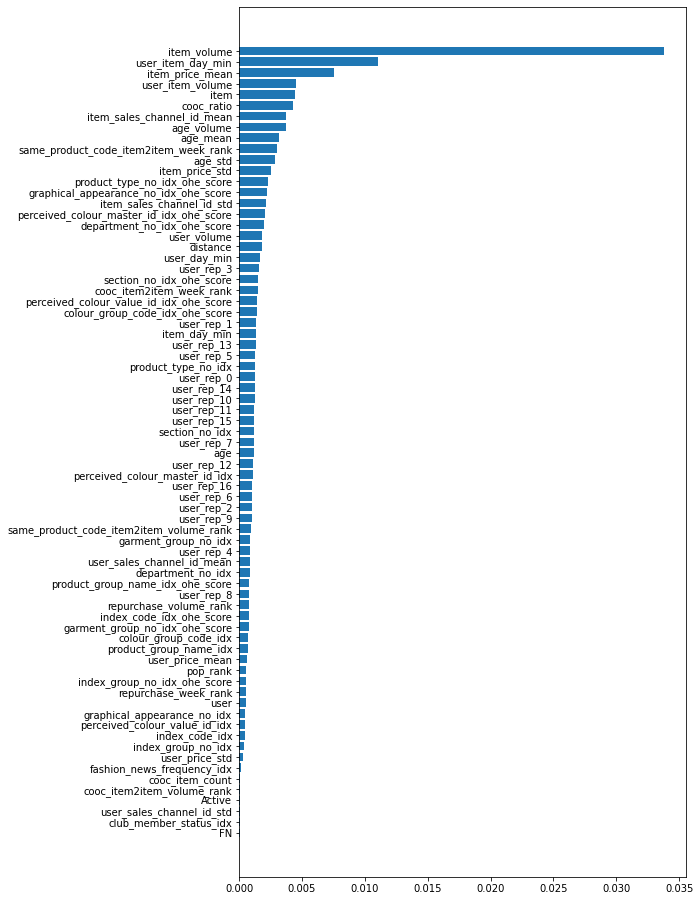

In [17]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_dataset = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
        'iterations': 5000,
        'bagging_temperature': 10.0,
        'colsample_bylevel': 0.9,
        'depth': 10,
        'l2_leaf_reg': 1.0,
        'min_data_in_leaf': 350,
        'random_strength': 0.1,
    }
    model = catboost.CatBoost(params)
    model.fit(train_dataset, eval_set=valid_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])


del train, valid, train_dataset, valid_dataset
gc.collect()
with open('output/model_for_validation.pkl', 'wb') as f:
    pickle.dump(model, f)

In [18]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])

pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

merged.to_pickle(f'output/merged_{dataset}.pkl')
dataset_valid_all.to_pickle(f'output/valid_all_{dataset}.pkl')

print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.03495252342797446


In [19]:
# assert False

submission

In [20]:
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates))]

for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

train = concat_train(datasets, 0, CFG.train_weeks)

attach features (week: 1)


[user static fetaures] 0.580 s


[item stacic features] 1.402 s


[user dynamic features (transactions)] 1.258 s


[item dynamic features (transactions)] 1.031 s


[item dynamic features (user features)] 1.457 s


[item freshness features] 2.843 s


[item volume features] 1.050 s


[user freshness features] 4.012 s


[user volume features] 1.180 s


[user-item freshness features] 20.872 s


[user-item volume features] 1.881 s


[item age volume features] 2.226 s


[ohe dot products] 73.009 s


[lfm features] 2.965 s
attach features (week: 2)


[user static fetaures] 0.624 s


[item stacic features] 1.469 s


[user dynamic features (transactions)] 1.273 s


[item dynamic features (transactions)] 1.103 s


[item dynamic features (user features)] 1.567 s


[item freshness features] 2.886 s


[item volume features] 1.068 s


[user freshness features] 4.066 s


[user volume features] 1.194 s


[user-item freshness features] 21.042 s


[user-item volume features] 2.018 s


[item age volume features] 2.352 s


[ohe dot products] 72.557 s


[lfm features] 2.800 s
attach features (week: 3)


[user static fetaures] 0.644 s


[item stacic features] 1.551 s


[user dynamic features (transactions)] 1.354 s


[item dynamic features (transactions)] 1.105 s


[item dynamic features (user features)] 1.604 s


[item freshness features] 2.906 s


[item volume features] 1.120 s


[user freshness features] 4.044 s


[user volume features] 1.267 s


[user-item freshness features] 21.166 s


[user-item volume features] 2.140 s


[item age volume features] 2.384 s


[ohe dot products] 75.882 s


[lfm features] 3.715 s
attach features (week: 4)


[user static fetaures] 0.688 s


[item stacic features] 1.690 s


[user dynamic features (transactions)] 1.432 s


[item dynamic features (transactions)] 1.221 s


[item dynamic features (user features)] 1.678 s


[item freshness features] 2.990 s


[item volume features] 1.179 s


[user freshness features] 4.191 s


[user volume features] 1.330 s


[user-item freshness features] 20.989 s


[user-item volume features] 2.282 s


[item age volume features] 2.471 s


[ohe dot products] 82.626 s


[lfm features] 3.890 s


In [21]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

del train, train_dataset
gc.collect()
with open('output/model_for_submission.pkl', 'wb') as f:
    pickle.dump(model, f)

0:	total: 4.29s	remaining: 5h 55m 32s


1:	total: 8.68s	remaining: 5h 59m 22s


2:	total: 13.1s	remaining: 6h 36s


3:	total: 17.5s	remaining: 6h 1m 7s


4:	total: 21.6s	remaining: 5h 58m 17s


5:	total: 26.2s	remaining: 6h 1m 11s


6:	total: 30.4s	remaining: 5h 59m 34s


7:	total: 34.8s	remaining: 6h 5s


8:	total: 39.2s	remaining: 6h 30s


9:	total: 43.6s	remaining: 6h 6s


10:	total: 47.9s	remaining: 6h 1s


11:	total: 52.3s	remaining: 6h 13s


12:	total: 56.8s	remaining: 6h 40s


13:	total: 1m 1s	remaining: 6h 59s


14:	total: 1m 5s	remaining: 6h 1m 9s


15:	total: 1m 9s	remaining: 6h 23s


16:	total: 1m 13s	remaining: 5h 59m 16s


17:	total: 1m 18s	remaining: 5h 58m 43s


18:	total: 1m 22s	remaining: 5h 59m 30s


19:	total: 1m 27s	remaining: 6h 1m 33s


20:	total: 1m 32s	remaining: 6h 3m 18s


21:	total: 1m 37s	remaining: 6h 4m 6s


22:	total: 1m 41s	remaining: 6h 5m 29s


23:	total: 1m 46s	remaining: 6h 6m 51s


24:	total: 1m 51s	remaining: 6h 8m 36s


25:	total: 1m 56s	remaining: 6h 9m 30s


26:	total: 2m 1s	remaining: 6h 10m 29s


27:	total: 2m 6s	remaining: 6h 11m 14s


28:	total: 2m 11s	remaining: 6h 12m 1s


29:	total: 2m 16s	remaining: 6h 13m 54s


30:	total: 2m 21s	remaining: 6h 14m 54s


31:	total: 2m 25s	remaining: 6h 15m 28s


32:	total: 2m 30s	remaining: 6h 16m 3s


33:	total: 2m 35s	remaining: 6h 16m 53s


34:	total: 2m 40s	remaining: 6h 17m 46s


35:	total: 2m 45s	remaining: 6h 18m 36s


36:	total: 2m 50s	remaining: 6h 19m 4s


37:	total: 2m 55s	remaining: 6h 19m 37s


38:	total: 3m	remaining: 6h 20m 23s


39:	total: 3m 5s	remaining: 6h 20m 30s


40:	total: 3m 10s	remaining: 6h 21m 9s


41:	total: 3m 15s	remaining: 6h 21m 57s


42:	total: 3m 20s	remaining: 6h 22m 26s


43:	total: 3m 24s	remaining: 6h 22m 28s


44:	total: 3m 29s	remaining: 6h 23m


45:	total: 3m 35s	remaining: 6h 23m 49s


46:	total: 3m 40s	remaining: 6h 24m 10s


47:	total: 3m 44s	remaining: 6h 24m 24s


48:	total: 3m 49s	remaining: 6h 24m 42s


49:	total: 3m 54s	remaining: 6h 24m 55s


50:	total: 3m 59s	remaining: 6h 25m 10s


51:	total: 4m 4s	remaining: 6h 25m 17s


52:	total: 4m 9s	remaining: 6h 25m 22s


53:	total: 4m 14s	remaining: 6h 25m 27s


54:	total: 4m 18s	remaining: 6h 25m 38s


55:	total: 4m 23s	remaining: 6h 25m 50s


56:	total: 4m 28s	remaining: 6h 25m 56s


57:	total: 4m 33s	remaining: 6h 26m


58:	total: 4m 38s	remaining: 6h 26m 6s


59:	total: 4m 43s	remaining: 6h 26m 10s


60:	total: 4m 48s	remaining: 6h 26m 21s


61:	total: 4m 52s	remaining: 6h 26m 19s


62:	total: 4m 57s	remaining: 6h 26m 22s


63:	total: 5m 2s	remaining: 6h 26m 28s


64:	total: 5m 7s	remaining: 6h 26m 38s


65:	total: 5m 12s	remaining: 6h 26m 39s


66:	total: 5m 17s	remaining: 6h 27m 2s


67:	total: 5m 22s	remaining: 6h 27m 17s


68:	total: 5m 27s	remaining: 6h 27m 14s


69:	total: 5m 32s	remaining: 6h 27m 35s


70:	total: 5m 37s	remaining: 6h 27m 44s


71:	total: 5m 42s	remaining: 6h 27m 47s


72:	total: 5m 46s	remaining: 6h 27m 57s


73:	total: 5m 52s	remaining: 6h 28m 21s


74:	total: 5m 57s	remaining: 6h 28m 26s


75:	total: 6m 1s	remaining: 6h 28m 24s


76:	total: 6m 6s	remaining: 6h 28m 29s


77:	total: 6m 11s	remaining: 6h 28m 39s


78:	total: 6m 16s	remaining: 6h 28m 38s


79:	total: 6m 21s	remaining: 6h 28m 41s


80:	total: 6m 26s	remaining: 6h 28m 49s


81:	total: 6m 31s	remaining: 6h 28m 57s


82:	total: 6m 36s	remaining: 6h 28m 55s


83:	total: 6m 41s	remaining: 6h 29m 18s


84:	total: 6m 46s	remaining: 6h 29m 29s


85:	total: 6m 51s	remaining: 6h 29m 32s


86:	total: 6m 56s	remaining: 6h 29m 39s


87:	total: 7m 1s	remaining: 6h 29m 37s


88:	total: 7m 6s	remaining: 6h 29m 40s


89:	total: 7m 11s	remaining: 6h 29m 45s


90:	total: 7m 16s	remaining: 6h 29m 53s


91:	total: 7m 21s	remaining: 6h 29m 56s


92:	total: 7m 26s	remaining: 6h 30m


93:	total: 7m 31s	remaining: 6h 30m


94:	total: 7m 36s	remaining: 6h 30m 15s


95:	total: 7m 41s	remaining: 6h 30m 6s


96:	total: 7m 46s	remaining: 6h 30m 12s


97:	total: 7m 50s	remaining: 6h 30m 15s


98:	total: 7m 55s	remaining: 6h 30m 12s


99:	total: 8m	remaining: 6h 30m 12s


100:	total: 8m 5s	remaining: 6h 30m 20s


101:	total: 8m 10s	remaining: 6h 30m 22s


102:	total: 8m 15s	remaining: 6h 30m 26s


103:	total: 8m 20s	remaining: 6h 30m 28s


104:	total: 8m 25s	remaining: 6h 30m 20s


105:	total: 8m 30s	remaining: 6h 30m 8s


106:	total: 8m 35s	remaining: 6h 30m 8s


107:	total: 8m 39s	remaining: 6h 30m 4s


108:	total: 8m 44s	remaining: 6h 30m 8s


109:	total: 8m 49s	remaining: 6h 30m 13s


110:	total: 8m 54s	remaining: 6h 30m 16s


111:	total: 8m 59s	remaining: 6h 30m 13s


112:	total: 9m 4s	remaining: 6h 30m 17s


113:	total: 9m 9s	remaining: 6h 30m 18s


114:	total: 9m 14s	remaining: 6h 30m 20s


115:	total: 9m 19s	remaining: 6h 30m 19s


116:	total: 9m 24s	remaining: 6h 30m 15s


117:	total: 9m 29s	remaining: 6h 30m 7s


118:	total: 9m 34s	remaining: 6h 30m


119:	total: 9m 39s	remaining: 6h 30m 1s


120:	total: 9m 44s	remaining: 6h 30m 3s


121:	total: 9m 48s	remaining: 6h 29m 59s


122:	total: 9m 53s	remaining: 6h 30m 3s


123:	total: 9m 58s	remaining: 6h 30m 6s


124:	total: 10m 3s	remaining: 6h 30m 6s


125:	total: 10m 8s	remaining: 6h 30m 11s


126:	total: 10m 14s	remaining: 6h 30m 16s


127:	total: 10m 18s	remaining: 6h 30m 11s


128:	total: 10m 23s	remaining: 6h 30m 16s


129:	total: 10m 28s	remaining: 6h 30m 10s


130:	total: 10m 33s	remaining: 6h 30m 13s


131:	total: 10m 38s	remaining: 6h 30m 18s


132:	total: 10m 43s	remaining: 6h 30m 12s


133:	total: 10m 48s	remaining: 6h 30m 14s


134:	total: 10m 53s	remaining: 6h 30m 14s


135:	total: 10m 58s	remaining: 6h 30m 14s


136:	total: 11m 3s	remaining: 6h 30m 15s


137:	total: 11m 8s	remaining: 6h 30m 18s


138:	total: 11m 13s	remaining: 6h 30m 20s


139:	total: 11m 18s	remaining: 6h 30m 17s


140:	total: 11m 23s	remaining: 6h 30m 17s


141:	total: 11m 28s	remaining: 6h 30m 10s


142:	total: 11m 33s	remaining: 6h 30m 15s


143:	total: 11m 38s	remaining: 6h 30m 13s


144:	total: 11m 43s	remaining: 6h 30m 20s


145:	total: 11m 48s	remaining: 6h 30m 15s


146:	total: 11m 53s	remaining: 6h 30m 21s


147:	total: 11m 58s	remaining: 6h 30m 20s


148:	total: 12m 3s	remaining: 6h 30m 18s


149:	total: 12m 8s	remaining: 6h 30m 12s


150:	total: 12m 13s	remaining: 6h 30m 7s


151:	total: 12m 18s	remaining: 6h 30m 5s


152:	total: 12m 23s	remaining: 6h 30m 7s


153:	total: 12m 28s	remaining: 6h 30m 2s


154:	total: 12m 33s	remaining: 6h 29m 53s


155:	total: 12m 38s	remaining: 6h 29m 59s


156:	total: 12m 43s	remaining: 6h 30m


157:	total: 12m 48s	remaining: 6h 30m 4s


158:	total: 12m 53s	remaining: 6h 29m 59s


159:	total: 12m 58s	remaining: 6h 29m 53s


160:	total: 13m 3s	remaining: 6h 29m 52s


161:	total: 13m 8s	remaining: 6h 29m 51s


162:	total: 13m 13s	remaining: 6h 29m 52s


163:	total: 13m 18s	remaining: 6h 29m 45s


164:	total: 13m 22s	remaining: 6h 29m 41s


165:	total: 13m 28s	remaining: 6h 29m 46s


166:	total: 13m 32s	remaining: 6h 29m 41s


167:	total: 13m 38s	remaining: 6h 29m 42s


168:	total: 13m 43s	remaining: 6h 29m 42s


169:	total: 13m 48s	remaining: 6h 29m 41s


170:	total: 13m 53s	remaining: 6h 29m 38s


171:	total: 13m 58s	remaining: 6h 29m 41s


172:	total: 14m 3s	remaining: 6h 29m 43s


173:	total: 14m 8s	remaining: 6h 29m 38s


174:	total: 14m 13s	remaining: 6h 29m 38s


175:	total: 14m 18s	remaining: 6h 29m 39s


176:	total: 14m 23s	remaining: 6h 29m 31s


177:	total: 14m 27s	remaining: 6h 29m 23s


178:	total: 14m 32s	remaining: 6h 29m 24s


179:	total: 14m 37s	remaining: 6h 29m 23s


180:	total: 14m 43s	remaining: 6h 29m 23s


181:	total: 14m 47s	remaining: 6h 29m 15s


182:	total: 14m 52s	remaining: 6h 29m 14s


183:	total: 14m 57s	remaining: 6h 29m 6s


184:	total: 15m 2s	remaining: 6h 29m 3s


185:	total: 15m 7s	remaining: 6h 29m 2s


186:	total: 15m 12s	remaining: 6h 28m 59s


187:	total: 15m 17s	remaining: 6h 28m 54s


188:	total: 15m 22s	remaining: 6h 28m 58s


189:	total: 15m 27s	remaining: 6h 28m 53s


190:	total: 15m 32s	remaining: 6h 28m 52s


191:	total: 15m 37s	remaining: 6h 28m 51s


192:	total: 15m 42s	remaining: 6h 28m 49s


193:	total: 15m 47s	remaining: 6h 28m 44s


194:	total: 15m 52s	remaining: 6h 28m 37s


195:	total: 15m 56s	remaining: 6h 28m 28s


196:	total: 16m 1s	remaining: 6h 28m 21s


197:	total: 16m 6s	remaining: 6h 28m 16s


198:	total: 16m 11s	remaining: 6h 28m 7s


199:	total: 16m 16s	remaining: 6h 28m 4s


200:	total: 16m 21s	remaining: 6h 28m 4s


201:	total: 16m 26s	remaining: 6h 28m 2s


202:	total: 16m 31s	remaining: 6h 27m 59s


203:	total: 16m 36s	remaining: 6h 28m 1s


204:	total: 16m 41s	remaining: 6h 27m 56s


205:	total: 16m 46s	remaining: 6h 27m 54s


206:	total: 16m 51s	remaining: 6h 27m 49s


207:	total: 16m 56s	remaining: 6h 27m 45s


208:	total: 17m 1s	remaining: 6h 27m 44s


209:	total: 17m 6s	remaining: 6h 27m 38s


210:	total: 17m 11s	remaining: 6h 27m 39s


211:	total: 17m 16s	remaining: 6h 27m 40s


212:	total: 17m 21s	remaining: 6h 27m 37s


213:	total: 17m 26s	remaining: 6h 27m 36s


214:	total: 17m 31s	remaining: 6h 27m 35s


215:	total: 17m 36s	remaining: 6h 27m 32s


216:	total: 17m 41s	remaining: 6h 27m 25s


217:	total: 17m 46s	remaining: 6h 27m 23s


218:	total: 17m 51s	remaining: 6h 27m 21s


219:	total: 17m 56s	remaining: 6h 27m 17s


220:	total: 18m 1s	remaining: 6h 27m 17s


221:	total: 18m 6s	remaining: 6h 27m 20s


222:	total: 18m 11s	remaining: 6h 27m 15s


223:	total: 18m 16s	remaining: 6h 27m 9s


224:	total: 18m 21s	remaining: 6h 27m 2s


225:	total: 18m 26s	remaining: 6h 26m 57s


226:	total: 18m 30s	remaining: 6h 26m 50s


227:	total: 18m 35s	remaining: 6h 26m 43s


228:	total: 18m 40s	remaining: 6h 26m 46s


229:	total: 18m 45s	remaining: 6h 26m 44s


230:	total: 18m 50s	remaining: 6h 26m 38s


231:	total: 18m 55s	remaining: 6h 26m 34s


232:	total: 19m	remaining: 6h 26m 30s


233:	total: 19m 5s	remaining: 6h 26m 28s


234:	total: 19m 10s	remaining: 6h 26m 20s


235:	total: 19m 15s	remaining: 6h 26m 16s


236:	total: 19m 20s	remaining: 6h 26m 14s


237:	total: 19m 25s	remaining: 6h 26m 10s


238:	total: 19m 30s	remaining: 6h 26m 6s


239:	total: 19m 35s	remaining: 6h 26m 4s


240:	total: 19m 40s	remaining: 6h 26m 1s


241:	total: 19m 45s	remaining: 6h 25m 59s


242:	total: 19m 50s	remaining: 6h 25m 58s


243:	total: 19m 55s	remaining: 6h 25m 52s


244:	total: 20m	remaining: 6h 25m 49s


245:	total: 20m 5s	remaining: 6h 25m 45s


246:	total: 20m 10s	remaining: 6h 25m 47s


247:	total: 20m 15s	remaining: 6h 25m 44s


248:	total: 20m 20s	remaining: 6h 25m 43s


249:	total: 20m 25s	remaining: 6h 25m 40s


250:	total: 20m 30s	remaining: 6h 25m 37s


251:	total: 20m 35s	remaining: 6h 25m 37s


252:	total: 20m 40s	remaining: 6h 25m 31s


253:	total: 20m 45s	remaining: 6h 25m 25s


254:	total: 20m 50s	remaining: 6h 25m 19s


255:	total: 20m 55s	remaining: 6h 25m 13s


256:	total: 21m	remaining: 6h 25m 6s


257:	total: 21m 5s	remaining: 6h 25m 3s


258:	total: 21m 10s	remaining: 6h 25m


259:	total: 21m 14s	remaining: 6h 24m 56s


260:	total: 21m 19s	remaining: 6h 24m 51s


261:	total: 21m 24s	remaining: 6h 24m 46s


262:	total: 21m 29s	remaining: 6h 24m 45s


263:	total: 21m 34s	remaining: 6h 24m 39s


264:	total: 21m 39s	remaining: 6h 24m 35s


265:	total: 21m 44s	remaining: 6h 24m 32s


266:	total: 21m 49s	remaining: 6h 24m 26s


267:	total: 21m 54s	remaining: 6h 24m 21s


268:	total: 21m 59s	remaining: 6h 24m 16s


269:	total: 22m 4s	remaining: 6h 24m 11s


270:	total: 22m 9s	remaining: 6h 24m 5s


271:	total: 22m 13s	remaining: 6h 23m 59s


272:	total: 22m 18s	remaining: 6h 23m 51s


273:	total: 22m 23s	remaining: 6h 23m 50s


274:	total: 22m 28s	remaining: 6h 23m 41s


275:	total: 22m 33s	remaining: 6h 23m 39s


276:	total: 22m 38s	remaining: 6h 23m 34s


277:	total: 22m 43s	remaining: 6h 23m 26s


278:	total: 22m 47s	remaining: 6h 23m 18s


279:	total: 22m 52s	remaining: 6h 23m 11s


280:	total: 22m 57s	remaining: 6h 23m 8s


281:	total: 23m 2s	remaining: 6h 23m 4s


282:	total: 23m 7s	remaining: 6h 23m 1s


283:	total: 23m 12s	remaining: 6h 23m


284:	total: 23m 17s	remaining: 6h 22m 57s


285:	total: 23m 22s	remaining: 6h 22m 52s


286:	total: 23m 27s	remaining: 6h 22m 45s


287:	total: 23m 32s	remaining: 6h 22m 41s


288:	total: 23m 37s	remaining: 6h 22m 37s


289:	total: 23m 42s	remaining: 6h 22m 32s


290:	total: 23m 47s	remaining: 6h 22m 28s


291:	total: 23m 52s	remaining: 6h 22m 25s


292:	total: 23m 57s	remaining: 6h 22m 19s


293:	total: 24m 2s	remaining: 6h 22m 14s


294:	total: 24m 6s	remaining: 6h 22m 9s


295:	total: 24m 11s	remaining: 6h 22m 3s


296:	total: 24m 16s	remaining: 6h 21m 57s


297:	total: 24m 21s	remaining: 6h 21m 48s


298:	total: 24m 26s	remaining: 6h 21m 44s


299:	total: 24m 31s	remaining: 6h 21m 39s


300:	total: 24m 36s	remaining: 6h 21m 37s


301:	total: 24m 41s	remaining: 6h 21m 36s


302:	total: 24m 45s	remaining: 6h 21m 27s


303:	total: 24m 50s	remaining: 6h 21m 19s


304:	total: 24m 55s	remaining: 6h 21m 15s


305:	total: 25m	remaining: 6h 21m 9s


306:	total: 25m 5s	remaining: 6h 21m 3s


307:	total: 25m 10s	remaining: 6h 20m 59s


308:	total: 25m 15s	remaining: 6h 20m 55s


309:	total: 25m 20s	remaining: 6h 20m 50s


310:	total: 25m 24s	remaining: 6h 20m 44s


311:	total: 25m 29s	remaining: 6h 20m 41s


312:	total: 25m 34s	remaining: 6h 20m 35s


313:	total: 25m 39s	remaining: 6h 20m 27s


314:	total: 25m 44s	remaining: 6h 20m 22s


315:	total: 25m 49s	remaining: 6h 20m 16s


316:	total: 25m 53s	remaining: 6h 20m 8s


317:	total: 25m 59s	remaining: 6h 20m 8s


318:	total: 26m 3s	remaining: 6h 20m 2s


319:	total: 26m 8s	remaining: 6h 19m 58s


320:	total: 26m 13s	remaining: 6h 19m 51s


321:	total: 26m 18s	remaining: 6h 19m 48s


322:	total: 26m 23s	remaining: 6h 19m 43s


323:	total: 26m 28s	remaining: 6h 19m 36s


324:	total: 26m 33s	remaining: 6h 19m 31s


325:	total: 26m 38s	remaining: 6h 19m 27s


326:	total: 26m 42s	remaining: 6h 19m 18s


327:	total: 26m 47s	remaining: 6h 19m 14s


328:	total: 26m 52s	remaining: 6h 19m 11s


329:	total: 26m 58s	remaining: 6h 19m 10s


330:	total: 27m 3s	remaining: 6h 19m 6s


331:	total: 27m 7s	remaining: 6h 19m 1s


332:	total: 27m 12s	remaining: 6h 18m 56s


333:	total: 27m 17s	remaining: 6h 18m 52s


334:	total: 27m 22s	remaining: 6h 18m 47s


335:	total: 27m 27s	remaining: 6h 18m 41s


336:	total: 27m 32s	remaining: 6h 18m 37s


337:	total: 27m 37s	remaining: 6h 18m 30s


338:	total: 27m 42s	remaining: 6h 18m 24s


339:	total: 27m 47s	remaining: 6h 18m 21s


340:	total: 27m 51s	remaining: 6h 18m 16s


341:	total: 27m 56s	remaining: 6h 18m 11s


342:	total: 28m 1s	remaining: 6h 18m 5s


343:	total: 28m 6s	remaining: 6h 18m


344:	total: 28m 11s	remaining: 6h 17m 56s


345:	total: 28m 16s	remaining: 6h 17m 50s


346:	total: 28m 21s	remaining: 6h 17m 45s


347:	total: 28m 26s	remaining: 6h 17m 38s


348:	total: 28m 31s	remaining: 6h 17m 36s


349:	total: 28m 35s	remaining: 6h 17m 30s


350:	total: 28m 40s	remaining: 6h 17m 24s


351:	total: 28m 46s	remaining: 6h 17m 23s


352:	total: 28m 50s	remaining: 6h 17m 15s


353:	total: 28m 55s	remaining: 6h 17m 6s


354:	total: 29m	remaining: 6h 17m 2s


355:	total: 29m 5s	remaining: 6h 16m 56s


356:	total: 29m 9s	remaining: 6h 16m 49s


In [ ]:
del datasets, dataset_valid_all, candidates, candidates_valid_all
gc.collect()

In [ ]:
all_users = users['user'].values
all_users

In [ ]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    print(f"chunk: {i}")
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

In [ ]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [ ]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

In [ ]:
submission.to_csv('submission.csv', index=False)